In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


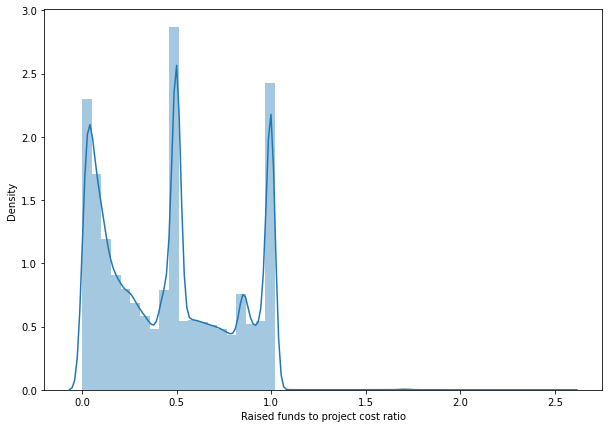

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


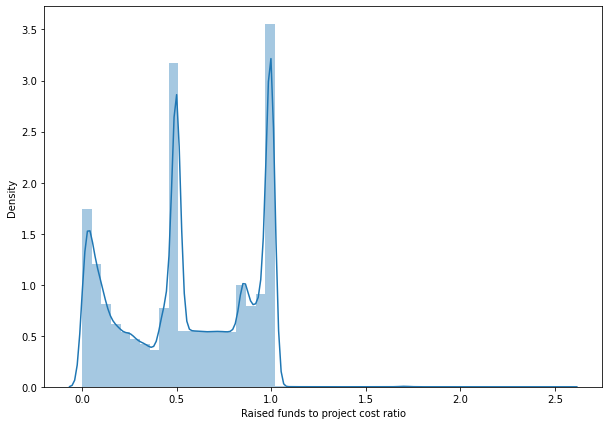

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    count_itr=0
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        count_itr+=1
        print(count_itr,"/",len(combinations),"Time iteration is starting\n")
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

        print("Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]


        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]


        #===================================== Model Training =========================================

            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [8]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=3)

hyper_para=dict()
hyper_para["learning_rate"]=[1,0.3,0.03]
hyper_para["n_estimators"]=[51,200,500]
hyper_para["random_state"]=[23,17,43]
# hyper_para["criterion"]=["gini", "entropy"]

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch","Project Cost",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.14)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True

One-Hot-Encoding removing columns identification
AdaBoostClassifier(learning_rate=1, n_estimators=51, random_state=23)
1 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393526843051631
	Training_TP: 5149 	Training_FP: 2979 
	Training_TN: 4807 	Training_FN: 2637

AdaBoostClassifier  Testing Accuracy =  0.6210500729217306
	Testing_TP: 1174 	Testing_FP: 821 
	Testing_TN: 1381 	Testing_FN: 738

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397856755290288
	Training_TP: 4858 	Training_FP: 2797 
	Training_TN: 4575 	Training_FN: 2514

AdaBoostClassifier  Testing Accuracy =  0.623082542001461
	Testing_TP: 1365 	Testing_FP: 786 
	Testing_TN: 1194 	Testing_FN: 762

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440164634619865
	Training_TP: 4256 	Training_FP: 2402 
	Training_TN: 4037 	Training_FN: 2182

AdaBoostClassifier  Testing Accuracy =  0.6153644467750393
	Testing_TP: 1587 	Testing_FP: 606 
	Testing_TN: 760 	Testing_FN: 861

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.639002418883977
	Training_TP: 4096 	Training_FP: 2430 
	Training_TN: 3565 	Training_FN: 1898

AdaBoostClassifier  Testing Accuracy =  0.6005917159763313
	Testing_TP: 1448 	Testing_FP: 1146 
	Testing_TN: 1394 	Testing_FN: 744

AdaBoostClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315411614550096
	Training_TP: 4202 	Training_FP: 2553 
	Training_TN: 3715 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6247527844280212
	Testing_TP: 2863 	Testing_FP: 2323 
	Testing_TN: 3139 	Testing_FN: 1282

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409873263600642
	Training_TP: 5973 	Training_FP: 3426 
	Training_TN: 5609 	Training_FN: 3061

AdaBoostClassifier  Testing Accuracy =  0.6352176939138504
	Testing_TP: 4961 	Testing_FP: 2086 
	Testing_TN: 3253 	Testing_FN: 2631

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440963943806625
	Training_TP: 8975 	Training_FP: 5047 
	Training_TN: 8585 	Training_FN: 4656

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3427 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1933

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440807120214582
	Training_TP: 10920 	Training_FP: 6193 
	Training_TN: 10211 	Training_FN: 5484

AdaBoostClassifier  Testing Accuracy =  0.667275875336668
	Testing_TP: 3887 	Testing_FP: 1956 
	Testing_TN: 3050 	Testing_FN: 1503

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565990152515913
	Training_TP: 11190 	Training_FP: 5974 
	Training_TN: 10680 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6520028109627547
	Testing_TP: 1732 	Testing_FP: 1661 
	Testing_TN: 2907 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657333479164388
	Training_TP: 8974 	Training_FP: 4659 
	Training_TN: 9056 	Training_FN: 4740

AdaBoostClassifier  Testing Accuracy =  0.6323957322987391
	Testing_TP: 1642 	Testing_FP: 1064 
	Testing_TN: 2270 	Testing_FN: 1210

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653905118814411
	Training_TP: 7524 	Training_FP: 3910 
	Training_TN: 7831 	Training_FN: 4217

AdaBoostClassifier  Testing Accuracy =  0.6120867768595041
	Testing_TP: 1933 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314447864563294
	Training_TP: 6492 	Training_FP: 3759 
	Training_TN: 6637 	Training_FN: 3904

AdaBoostClassifier  Testing Accuracy =  0.6185066855993373
	Testing_TP: 2607 	Testing_FP: 1535 
	Testing_TN: 2620 	Testing_FN: 1689

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324863474297062
	Training_TP: 6896 	Training_FP: 3961 
	Training_TN: 7118 	Training_FN: 4182

AdaBoostClassifier  Testing Accuracy =  0.6317403065825068
	Testing_TP: 1690 	Testing_FP: 1059 
	Testing_TN: 1813 	Testing_FN: 983

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6354682102511436
	Training_TP: 6767 	Training_FP: 3865 
	Training_TN: 6846 	Training_FN: 3944

AdaBoostClassifier  Testing Accuracy =  0.6114794468649365
	Testing_TP: 1736 	Testing_FP: 1049 
	Testing_TN: 1492 	Testing_FN: 1002

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634997906197655
	Training_TP: 5978 	Training_FP: 3399 
	Training_TN: 6153 	Training_FN: 3574

AdaBoostClassifier  Testing Accuracy =  0.6172652531371701
	Testing_TP: 1611 	Testing_FP: 782 
	Testing_TN: 1242 	Testing_FN: 987

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6387309980171844
	Training_TP: 4787 	Training_FP: 2688 
	Training_TN: 4877 	Training_FN: 2778

AdaBoostClassifier  Testing Accuracy =  0.6322033898305085
	Testing_TP: 1807 	Testing_FP: 972 
	Testing_TN: 1550 	Testing_FN: 981

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346865908489817
	Training_TP: 4809 	Training_FP: 2772 
	Training_TN: 4790 	Training_FN: 2753

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3687 	Testing_FP: 2928 
	Testing_TN: 4760 	Testing_FN: 3073

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262268041237113
	Training_TP: 7603 	Training_FP: 4542 
	Training_TN: 7583 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6647064839435467
	Testing_TP: 8162 	Testing_FP: 3021 
	Testing_TN: 4837 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653522634584013
	Training_TP: 12356 	Training_FP: 6333 
	Training_TN: 13283 	Training_FN: 7260

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4219 	Testing_FP: 1849 
	Testing_TN: 3140 	Testing_FN: 2441

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553282483135664
	Training_TP: 14633 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 8048

AdaBoostClassifier  Testing Accuracy =  0.6260890040028255
	Testing_TP: 2684 	Testing_FP: 1746 
	Testing_TN: 2634 	Testing_FN: 1430

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567968416559966
	Training_TP: 12280 	Training_FP: 6402 
	Training_TN: 12342 	Training_FN: 6464

AdaBoostClassifier  Testing Accuracy =  0.6323983357938532
	Testing_TP: 1761 	Testing_FP: 1672 
	Testing_TN: 2951 	Testing_FN: 1067

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398766927226687
	Training_TP: 9011 	Training_FP: 5200 
	Training_TN: 8425 	Training_FN: 4613

AdaBoostClassifier  Testing Accuracy =  0.6300380727320467
	Testing_TP: 1886 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1275

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321482439129498
	Training_TP: 7531 	Training_FP: 4465 
	Training_TN: 7138 	Training_FN: 4071

AdaBoostClassifier  Testing Accuracy =  0.6283520982599795
	Testing_TP: 2929 	Testing_FP: 1821 
	Testing_TN: 3210 	Testing_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6370879232551522
	Training_TP: 8032 	Training_FP: 4660 
	Training_TN: 7641 	Training_FN: 4268

AdaBoostClassifier  Testing Accuracy =  0.6770259176732731
	Testing_TP: 3429 	Testing_FP: 1351 
	Testing_TN: 2344 	Testing_FN: 1403

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6647696265689561
	Training_TP: 8411 	Training_FP: 4184 
	Training_TN: 8643 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.6598248494800218
	Testing_TP: 2326 	Testing_FP: 1233 
	Testing_TN: 2496 	Testing_FN: 1253

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.670739372986564
	Training_TP: 8437 	Training_FP: 4091 
	Training_TN: 8636 	Training_FN: 4290

AdaBoostClassifier  Testing Accuracy =  0.6419423692636073
	Testing_TP: 1736 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1117

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6737602038408909
	Training_TP: 7163 	Training_FP: 3481 
	Training_TN: 7116 	Training_FN: 3433

AdaBoostClassifier  Testing Accuracy =  0.6427908702913342
	Testing_TP: 2015 	Testing_FP: 843 
	Testing_TN: 1449 	Testing_FN: 1082

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6594676042189854
	Training_TP: 6037 	Training_FP: 3180 
	Training_TN: 5780 	Training_FN: 2922

AdaBoostClassifier  Testing Accuracy =  0.6186833098449769
	Testing_TP: 1530 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 881

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466721446179129
	Training_TP: 5193 	Training_FP: 2873 
	Training_TN: 5038 	Training_FN: 2717

AdaBoostClassifier  Testing Accuracy =  0.6168784029038112
	Testing_TP: 2837 	Testing_FP: 2770 
	Testing_TN: 3961 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383229024516494
	Training_TP: 6855 	Training_FP: 3916 
	Training_TN: 6710 	Training_FN: 3770

AdaBoostClassifier  Testing Accuracy =  0.64024081989062
	Testing_TP: 7129 	Testing_FP: 3908 
	Testing_TN: 6802 	Testing_FN: 3920

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433731739707835
	Training_TP: 12288 	Training_FP: 6890 
	Training_TN: 11935 	Training_FN: 6537

AdaBoostClassifier  Testing Accuracy =  0.6406459235919654
	Testing_TP: 4190 	Testing_FP: 2113 
	Testing_TN: 3943 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645955606548696
	Training_TP: 14881 	Training_FP: 8266 
	Training_TN: 14395 	Training_FN: 7780

AdaBoostClassifier  Testing Accuracy =  0.6490991424992774
	Testing_TP: 3430 	Testing_FP: 1954 
	Testing_TN: 3307 	Testing_FN: 1688

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6524322485542579
	Training_TP: 14610 	Training_FP: 7889 
	Training_TN: 14159 	Training_FN: 7437

AdaBoostClassifier  Testing Accuracy =  0.6182621502209131
	Testing_TP: 4190 	Testing_FP: 2807 
	Testing_TN: 4206 	Testing_FN: 2377

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435559453015812
	Training_TP: 11840 	Training_FP: 6602 
	Training_TN: 11644 	Training_FN: 6405

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2432 	Testing_FP: 1527 
	Testing_TN: 3108 	Testing_FN: 1612

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6419907075368736
	Training_TP: 10369 	Training_FP: 5816 
	Training_TN: 10219 	Training_FN: 5665

AdaBoostClassifier  Testing Accuracy =  0.6348206033106462
	Testing_TP: 3528 	Testing_FP: 2174 
	Testing_TN: 4027 	Testing_FN: 2172

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366648914136931
	Training_TP: 10938 	Training_FP: 6319 
	Training_TN: 10580 	Training_FN: 5961

AdaBoostClassifier  Testing Accuracy =  0.6244991789819376
	Testing_TP: 4352 	Testing_FP: 3088 
	Testing_TN: 5156 	Testing_FN: 2629

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284305438151592
	Training_TP: 10866 	Training_FP: 6308 
	Training_TN: 11437 	Training_FN: 6879

AdaBoostClassifier  Testing Accuracy =  0.6254211590296496
	Testing_TP: 3802 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2264

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315271191272124
	Training_TP: 12380 	Training_FP: 7305 
	Training_TN: 11990 	Training_FN: 6914

AdaBoostClassifier  Testing Accuracy =  0.6314601103863522
	Testing_TP: 2803 	Testing_FP: 1536 
	Testing_TN: 2231 	Testing_FN: 1402

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6369238781355785
	Training_TP: 11252 	Training_FP: 6520 
	Training_TN: 10762 	Training_FN: 6029

AdaBoostClassifier  Testing Accuracy =  0.6389207807118255
	Testing_TP: 2785 	Testing_FP: 1093 
	Testing_TN: 1667 	Testing_FN: 1423

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6436328110322023
	Training_TP: 8608 	Training_FP: 4786 
	Training_TN: 8521 	Training_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.6308609271523179
	Testing_TP: 2593 	Testing_FP: 1409 
	Testing_TN: 2170 	Testing_FN: 1378

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638528235769801
	Training_TP: 7057 	Training_FP: 3974 
	Training_TN: 7156 	Training_FN: 4072

AdaBoostClassifier  Testing Accuracy =  0.6569705169400756
	Testing_TP: 5958 	Testing_FP: 3449 
	Testing_TN: 5696 	Testing_FN: 2636

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6555146370388865
	Training_TP: 10267 	Training_FP: 5284 
	Training_TN: 10737 	Training_FN: 5754

AdaBoostClassifier  Testing Accuracy =  0.6624008582704318
	Testing_TP: 8723 	Testing_FP: 4544 
	Testing_TN: 8565 	Testing_FN: 4267

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663673884552941
	Training_TP: 16826 	Training_FP: 8459 
	Training_TN: 17103 	Training_FN: 8735

AdaBoostClassifier  Testing Accuracy =  0.6465658351338964
	Testing_TP: 4940 	Testing_FP: 2487 
	Testing_TN: 4935 	Testing_FN: 2911

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663867688803522
	Training_TP: 19402 	Training_FP: 9762 
	Training_TN: 19654 	Training_FN: 10013

AdaBoostClassifier  Testing Accuracy =  0.6482720178372352
	Testing_TP: 3246 	Testing_FP: 1831 
	Testing_TN: 3732 	Testing_FN: 1955

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595910875041496
	Training_TP: 16976 	Training_FP: 8804 
	Training_TN: 16801 	Training_FN: 8628

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4073 	Testing_FP: 2742 
	Testing_TN: 5604 	Testing_FN: 2444

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518007321658257
	Training_TP: 13506 	Training_FP: 7369 
	Training_TN: 12845 	Training_FN: 6708

AdaBoostClassifier  Testing Accuracy =  0.6489958386104577
	Testing_TP: 2878 	Testing_FP: 2112 
	Testing_TN: 4296 	Testing_FN: 1768

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6490397842953832
	Training_TP: 12031 	Training_FP: 6614 
	Training_TN: 11559 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6417723107819756
	Testing_TP: 4970 	Testing_FP: 3185 
	Testing_TN: 5256 	Testing_FN: 2523

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6504800501760988
	Training_TP: 13572 	Training_FP: 7334 
	Training_TN: 13393 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.6438069624981324
	Testing_TP: 3795 	Testing_FP: 2700 
	Testing_TN: 4823 	Testing_FN: 2068

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518996808934983
	Training_TP: 13004 	Training_FP: 6911 
	Training_TN: 13145 	Training_FN: 7052

AdaBoostClassifier  Testing Accuracy =  0.610846286701209
	Testing_TP: 3990 	Testing_FP: 2372 
	Testing_TN: 4852 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409793157760637
	Training_TP: 13280 	Training_FP: 7389 
	Training_TN: 14393 	Training_FN: 8111

AdaBoostClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2842 	Testing_FP: 1703 
	Testing_TN: 3225 	Testing_FN: 1978

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6297838055592856
	Training_TP: 10993 	Training_FP: 6427 
	Training_TN: 12457 	Training_FN: 7358

AdaBoostClassifier  Testing Accuracy =  0.6139814185361432
	Testing_TP: 3202 	Testing_FP: 1172 
	Testing_TN: 2217 	Testing_FN: 2235

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630029046412459
	Training_TP: 9754 	Training_FP: 5546 
	Training_TN: 10635 	Training_FN: 6427

AdaBoostClassifier  Testing Accuracy =  0.608124363838253
	Testing_TP: 3843 	Testing_FP: 1886 
	Testing_TN: 2729 	Testing_FN: 2349

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400207361327113
	Training_TP: 9249 	Training_FP: 5198 
	Training_TN: 9270 	Training_FN: 5218

AdaBoostClassifier  Testing Accuracy =  0.6243644287641382
	Testing_TP: 5375 	Testing_FP: 4078 
	Testing_TN: 6659 	Testing_FN: 3162

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315694092062342
	Training_TP: 11901 	Training_FP: 6819 
	Training_TN: 12494 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6343922966108121
	Testing_TP: 8027 	Testing_FP: 4981 
	Testing_TN: 8707 	Testing_FN: 4663

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327180253236592
	Training_TP: 17140 	Training_FP: 9677 
	Training_TN: 18439 	Training_FN: 10976

AdaBoostClassifier  Testing Accuracy =  0.6173925246760537
	Testing_TP: 6572 	Testing_FP: 3529 
	Testing_TN: 6626 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6301179008554179
	Training_TP: 20374 	Training_FP: 11689 
	Training_TN: 21687 	Training_FN: 13001

AdaBoostClassifier  Testing Accuracy =  0.6248343141933089
	Testing_TP: 5644 	Testing_FP: 3060 
	Testing_TN: 6141 	Testing_FN: 4016

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338384222949821
	Training_TP: 20092 	Training_FP: 11304 
	Training_TN: 21529 	Training_FN: 12740

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5466 	Testing_FP: 3251 
	Testing_TN: 5379 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300880617657872
	Training_TP: 17819 	Training_FP: 10389 
	Training_TN: 18171 	Training_FN: 10740

AdaBoostClassifier  Testing Accuracy =  0.644578768417076
	Testing_TP: 3656 	Testing_FP: 2762 
	Testing_TN: 4875 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343817743056975
	Training_TP: 15514 	Training_FP: 8943 
	Training_TN: 15506 	Training_FN: 8935

AdaBoostClassifier  Testing Accuracy =  0.6224761016553976
	Testing_TP: 5852 	Testing_FP: 4049 
	Testing_TN: 7497 	Testing_FN: 4047

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184100904810803
	Training_TP: 15684 	Training_FP: 9573 
	Training_TN: 16234 	Training_FN: 10122

AdaBoostClassifier  Testing Accuracy =  0.6151513109119094
	Testing_TP: 4056 	Testing_FP: 2696 
	Testing_TN: 5071 	Testing_FN: 3014

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6252559167963312
	Training_TP: 14855 	Training_FP: 8910 
	Training_TN: 15685 	Training_FN: 9394

AdaBoostClassifier  Testing Accuracy =  0.6399050905953408
	Testing_TP: 9759 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5156

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=51, random_state=17)
2 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393526843051631
	Training_TP: 5149 	Training_FP: 2979 
	Training_TN: 4807 	Training_FN: 2637

AdaBoostClassifier  Testing Accuracy =  0.6210500729217306
	Testing_TP: 1174 	Testing_FP: 821 
	Testing_TN: 1381 	Testing_FN: 738

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397856755290288
	Training_TP: 4858 	Training_FP: 2797 
	Training_TN: 4575 	Training_FN: 2514

AdaBoostClassifier  Testing Accuracy =  0.623082542001461
	Testing_TP: 1365 	Testing_FP: 786 
	Testing_TN: 1194 	Testing_FN: 762

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440164634619865
	Training_TP: 4256 	Training_FP: 2402 
	Training_TN: 4037 	Training_FN: 2182

AdaBoostClassifier  Testing Accuracy =  0.6153644467750393
	Testing_TP: 1587 	Testing_FP: 606 
	Testing_TN: 760 	Testing_FN: 861

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.639002418883977
	Training_TP: 4096 	Training_FP: 2430 
	Training_TN: 3565 	Training_FN: 1898

AdaBoostClassifier  Testing Accuracy =  0.6005917159763313
	Testing_TP: 1448 	Testing_FP: 1146 
	Testing_TN: 1394 	Testing_FN: 744

AdaBoostClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315411614550096
	Training_TP: 4202 	Training_FP: 2553 
	Training_TN: 3715 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6247527844280212
	Testing_TP: 2863 	Testing_FP: 2323 
	Testing_TN: 3139 	Testing_FN: 1282

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409873263600642
	Training_TP: 5973 	Training_FP: 3426 
	Training_TN: 5609 	Training_FN: 3061

AdaBoostClassifier  Testing Accuracy =  0.6352176939138504
	Testing_TP: 4961 	Testing_FP: 2086 
	Testing_TN: 3253 	Testing_FN: 2631

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440963943806625
	Training_TP: 8975 	Training_FP: 5047 
	Training_TN: 8585 	Training_FN: 4656

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3427 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1933

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440807120214582
	Training_TP: 10920 	Training_FP: 6193 
	Training_TN: 10211 	Training_FN: 5484

AdaBoostClassifier  Testing Accuracy =  0.667275875336668
	Testing_TP: 3887 	Testing_FP: 1956 
	Testing_TN: 3050 	Testing_FN: 1503

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565990152515913
	Training_TP: 11190 	Training_FP: 5974 
	Training_TN: 10680 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6520028109627547
	Testing_TP: 1732 	Testing_FP: 1661 
	Testing_TN: 2907 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657333479164388
	Training_TP: 8974 	Training_FP: 4659 
	Training_TN: 9056 	Training_FN: 4740

AdaBoostClassifier  Testing Accuracy =  0.6323957322987391
	Testing_TP: 1642 	Testing_FP: 1064 
	Testing_TN: 2270 	Testing_FN: 1210

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653905118814411
	Training_TP: 7524 	Training_FP: 3910 
	Training_TN: 7831 	Training_FN: 4217

AdaBoostClassifier  Testing Accuracy =  0.6120867768595041
	Testing_TP: 1933 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314447864563294
	Training_TP: 6492 	Training_FP: 3759 
	Training_TN: 6637 	Training_FN: 3904

AdaBoostClassifier  Testing Accuracy =  0.6185066855993373
	Testing_TP: 2607 	Testing_FP: 1535 
	Testing_TN: 2620 	Testing_FN: 1689

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324863474297062
	Training_TP: 6896 	Training_FP: 3961 
	Training_TN: 7118 	Training_FN: 4182

AdaBoostClassifier  Testing Accuracy =  0.6317403065825068
	Testing_TP: 1690 	Testing_FP: 1059 
	Testing_TN: 1813 	Testing_FN: 983

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6354682102511436
	Training_TP: 6767 	Training_FP: 3865 
	Training_TN: 6846 	Training_FN: 3944

AdaBoostClassifier  Testing Accuracy =  0.6114794468649365
	Testing_TP: 1736 	Testing_FP: 1049 
	Testing_TN: 1492 	Testing_FN: 1002

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634997906197655
	Training_TP: 5978 	Training_FP: 3399 
	Training_TN: 6153 	Training_FN: 3574

AdaBoostClassifier  Testing Accuracy =  0.6172652531371701
	Testing_TP: 1611 	Testing_FP: 782 
	Testing_TN: 1242 	Testing_FN: 987

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6387309980171844
	Training_TP: 4787 	Training_FP: 2688 
	Training_TN: 4877 	Training_FN: 2778

AdaBoostClassifier  Testing Accuracy =  0.6322033898305085
	Testing_TP: 1807 	Testing_FP: 972 
	Testing_TN: 1550 	Testing_FN: 981

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346865908489817
	Training_TP: 4809 	Training_FP: 2772 
	Training_TN: 4790 	Training_FN: 2753

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3687 	Testing_FP: 2928 
	Testing_TN: 4760 	Testing_FN: 3073

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262268041237113
	Training_TP: 7603 	Training_FP: 4542 
	Training_TN: 7583 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6647064839435467
	Testing_TP: 8162 	Testing_FP: 3021 
	Testing_TN: 4837 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653522634584013
	Training_TP: 12356 	Training_FP: 6333 
	Training_TN: 13283 	Training_FN: 7260

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4219 	Testing_FP: 1849 
	Testing_TN: 3140 	Testing_FN: 2441

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553282483135664
	Training_TP: 14633 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 8048

AdaBoostClassifier  Testing Accuracy =  0.6260890040028255
	Testing_TP: 2684 	Testing_FP: 1746 
	Testing_TN: 2634 	Testing_FN: 1430

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567968416559966
	Training_TP: 12280 	Training_FP: 6402 
	Training_TN: 12342 	Training_FN: 6464

AdaBoostClassifier  Testing Accuracy =  0.6323983357938532
	Testing_TP: 1761 	Testing_FP: 1672 
	Testing_TN: 2951 	Testing_FN: 1067

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398766927226687
	Training_TP: 9011 	Training_FP: 5200 
	Training_TN: 8425 	Training_FN: 4613

AdaBoostClassifier  Testing Accuracy =  0.6300380727320467
	Testing_TP: 1886 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1275

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321482439129498
	Training_TP: 7531 	Training_FP: 4465 
	Training_TN: 7138 	Training_FN: 4071

AdaBoostClassifier  Testing Accuracy =  0.6283520982599795
	Testing_TP: 2929 	Testing_FP: 1821 
	Testing_TN: 3210 	Testing_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6370879232551522
	Training_TP: 8032 	Training_FP: 4660 
	Training_TN: 7641 	Training_FN: 4268

AdaBoostClassifier  Testing Accuracy =  0.6770259176732731
	Testing_TP: 3429 	Testing_FP: 1351 
	Testing_TN: 2344 	Testing_FN: 1403

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6647696265689561
	Training_TP: 8411 	Training_FP: 4184 
	Training_TN: 8643 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.6598248494800218
	Testing_TP: 2326 	Testing_FP: 1233 
	Testing_TN: 2496 	Testing_FN: 1253

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.670739372986564
	Training_TP: 8437 	Training_FP: 4091 
	Training_TN: 8636 	Training_FN: 4290

AdaBoostClassifier  Testing Accuracy =  0.6419423692636073
	Testing_TP: 1736 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1117

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6737602038408909
	Training_TP: 7163 	Training_FP: 3481 
	Training_TN: 7116 	Training_FN: 3433

AdaBoostClassifier  Testing Accuracy =  0.6427908702913342
	Testing_TP: 2015 	Testing_FP: 843 
	Testing_TN: 1449 	Testing_FN: 1082

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6594676042189854
	Training_TP: 6037 	Training_FP: 3180 
	Training_TN: 5780 	Training_FN: 2922

AdaBoostClassifier  Testing Accuracy =  0.6186833098449769
	Testing_TP: 1530 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 881

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466721446179129
	Training_TP: 5193 	Training_FP: 2873 
	Training_TN: 5038 	Training_FN: 2717

AdaBoostClassifier  Testing Accuracy =  0.6168784029038112
	Testing_TP: 2837 	Testing_FP: 2770 
	Testing_TN: 3961 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383229024516494
	Training_TP: 6855 	Training_FP: 3916 
	Training_TN: 6710 	Training_FN: 3770

AdaBoostClassifier  Testing Accuracy =  0.64024081989062
	Testing_TP: 7129 	Testing_FP: 3908 
	Testing_TN: 6802 	Testing_FN: 3920

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433731739707835
	Training_TP: 12288 	Training_FP: 6890 
	Training_TN: 11935 	Training_FN: 6537

AdaBoostClassifier  Testing Accuracy =  0.6406459235919654
	Testing_TP: 4190 	Testing_FP: 2113 
	Testing_TN: 3943 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645955606548696
	Training_TP: 14881 	Training_FP: 8266 
	Training_TN: 14395 	Training_FN: 7780

AdaBoostClassifier  Testing Accuracy =  0.6490991424992774
	Testing_TP: 3430 	Testing_FP: 1954 
	Testing_TN: 3307 	Testing_FN: 1688

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6524322485542579
	Training_TP: 14610 	Training_FP: 7889 
	Training_TN: 14159 	Training_FN: 7437

AdaBoostClassifier  Testing Accuracy =  0.6182621502209131
	Testing_TP: 4190 	Testing_FP: 2807 
	Testing_TN: 4206 	Testing_FN: 2377

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435559453015812
	Training_TP: 11840 	Training_FP: 6602 
	Training_TN: 11644 	Training_FN: 6405

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2432 	Testing_FP: 1527 
	Testing_TN: 3108 	Testing_FN: 1612

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6419907075368736
	Training_TP: 10369 	Training_FP: 5816 
	Training_TN: 10219 	Training_FN: 5665

AdaBoostClassifier  Testing Accuracy =  0.6348206033106462
	Testing_TP: 3528 	Testing_FP: 2174 
	Testing_TN: 4027 	Testing_FN: 2172

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366648914136931
	Training_TP: 10938 	Training_FP: 6319 
	Training_TN: 10580 	Training_FN: 5961

AdaBoostClassifier  Testing Accuracy =  0.6244991789819376
	Testing_TP: 4352 	Testing_FP: 3088 
	Testing_TN: 5156 	Testing_FN: 2629

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284305438151592
	Training_TP: 10866 	Training_FP: 6308 
	Training_TN: 11437 	Training_FN: 6879

AdaBoostClassifier  Testing Accuracy =  0.6254211590296496
	Testing_TP: 3802 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2264

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315271191272124
	Training_TP: 12380 	Training_FP: 7305 
	Training_TN: 11990 	Training_FN: 6914

AdaBoostClassifier  Testing Accuracy =  0.6314601103863522
	Testing_TP: 2803 	Testing_FP: 1536 
	Testing_TN: 2231 	Testing_FN: 1402

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6369238781355785
	Training_TP: 11252 	Training_FP: 6520 
	Training_TN: 10762 	Training_FN: 6029

AdaBoostClassifier  Testing Accuracy =  0.6389207807118255
	Testing_TP: 2785 	Testing_FP: 1093 
	Testing_TN: 1667 	Testing_FN: 1423

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6436328110322023
	Training_TP: 8608 	Training_FP: 4786 
	Training_TN: 8521 	Training_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.6308609271523179
	Testing_TP: 2593 	Testing_FP: 1409 
	Testing_TN: 2170 	Testing_FN: 1378

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638528235769801
	Training_TP: 7057 	Training_FP: 3974 
	Training_TN: 7156 	Training_FN: 4072

AdaBoostClassifier  Testing Accuracy =  0.6569705169400756
	Testing_TP: 5958 	Testing_FP: 3449 
	Testing_TN: 5696 	Testing_FN: 2636

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6555146370388865
	Training_TP: 10267 	Training_FP: 5284 
	Training_TN: 10737 	Training_FN: 5754

AdaBoostClassifier  Testing Accuracy =  0.6624008582704318
	Testing_TP: 8723 	Testing_FP: 4544 
	Testing_TN: 8565 	Testing_FN: 4267

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663673884552941
	Training_TP: 16826 	Training_FP: 8459 
	Training_TN: 17103 	Training_FN: 8735

AdaBoostClassifier  Testing Accuracy =  0.6465658351338964
	Testing_TP: 4940 	Testing_FP: 2487 
	Testing_TN: 4935 	Testing_FN: 2911

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663867688803522
	Training_TP: 19402 	Training_FP: 9762 
	Training_TN: 19654 	Training_FN: 10013

AdaBoostClassifier  Testing Accuracy =  0.6482720178372352
	Testing_TP: 3246 	Testing_FP: 1831 
	Testing_TN: 3732 	Testing_FN: 1955

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595910875041496
	Training_TP: 16976 	Training_FP: 8804 
	Training_TN: 16801 	Training_FN: 8628

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4073 	Testing_FP: 2742 
	Testing_TN: 5604 	Testing_FN: 2444

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518007321658257
	Training_TP: 13506 	Training_FP: 7369 
	Training_TN: 12845 	Training_FN: 6708

AdaBoostClassifier  Testing Accuracy =  0.6489958386104577
	Testing_TP: 2878 	Testing_FP: 2112 
	Testing_TN: 4296 	Testing_FN: 1768

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6490397842953832
	Training_TP: 12031 	Training_FP: 6614 
	Training_TN: 11559 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6417723107819756
	Testing_TP: 4970 	Testing_FP: 3185 
	Testing_TN: 5256 	Testing_FN: 2523

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6504800501760988
	Training_TP: 13572 	Training_FP: 7334 
	Training_TN: 13393 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.6438069624981324
	Testing_TP: 3795 	Testing_FP: 2700 
	Testing_TN: 4823 	Testing_FN: 2068

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518996808934983
	Training_TP: 13004 	Training_FP: 6911 
	Training_TN: 13145 	Training_FN: 7052

AdaBoostClassifier  Testing Accuracy =  0.610846286701209
	Testing_TP: 3990 	Testing_FP: 2372 
	Testing_TN: 4852 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409793157760637
	Training_TP: 13280 	Training_FP: 7389 
	Training_TN: 14393 	Training_FN: 8111

AdaBoostClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2842 	Testing_FP: 1703 
	Testing_TN: 3225 	Testing_FN: 1978

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6297838055592856
	Training_TP: 10993 	Training_FP: 6427 
	Training_TN: 12457 	Training_FN: 7358

AdaBoostClassifier  Testing Accuracy =  0.6139814185361432
	Testing_TP: 3202 	Testing_FP: 1172 
	Testing_TN: 2217 	Testing_FN: 2235

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630029046412459
	Training_TP: 9754 	Training_FP: 5546 
	Training_TN: 10635 	Training_FN: 6427

AdaBoostClassifier  Testing Accuracy =  0.608124363838253
	Testing_TP: 3843 	Testing_FP: 1886 
	Testing_TN: 2729 	Testing_FN: 2349

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400207361327113
	Training_TP: 9249 	Training_FP: 5198 
	Training_TN: 9270 	Training_FN: 5218

AdaBoostClassifier  Testing Accuracy =  0.6243644287641382
	Testing_TP: 5375 	Testing_FP: 4078 
	Testing_TN: 6659 	Testing_FN: 3162

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315694092062342
	Training_TP: 11901 	Training_FP: 6819 
	Training_TN: 12494 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6343922966108121
	Testing_TP: 8027 	Testing_FP: 4981 
	Testing_TN: 8707 	Testing_FN: 4663

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327180253236592
	Training_TP: 17140 	Training_FP: 9677 
	Training_TN: 18439 	Training_FN: 10976

AdaBoostClassifier  Testing Accuracy =  0.6173925246760537
	Testing_TP: 6572 	Testing_FP: 3529 
	Testing_TN: 6626 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6301179008554179
	Training_TP: 20374 	Training_FP: 11689 
	Training_TN: 21687 	Training_FN: 13001

AdaBoostClassifier  Testing Accuracy =  0.6248343141933089
	Testing_TP: 5644 	Testing_FP: 3060 
	Testing_TN: 6141 	Testing_FN: 4016

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338384222949821
	Training_TP: 20092 	Training_FP: 11304 
	Training_TN: 21529 	Training_FN: 12740

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5466 	Testing_FP: 3251 
	Testing_TN: 5379 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300880617657872
	Training_TP: 17819 	Training_FP: 10389 
	Training_TN: 18171 	Training_FN: 10740

AdaBoostClassifier  Testing Accuracy =  0.644578768417076
	Testing_TP: 3656 	Testing_FP: 2762 
	Testing_TN: 4875 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343817743056975
	Training_TP: 15514 	Training_FP: 8943 
	Training_TN: 15506 	Training_FN: 8935

AdaBoostClassifier  Testing Accuracy =  0.6224761016553976
	Testing_TP: 5852 	Testing_FP: 4049 
	Testing_TN: 7497 	Testing_FN: 4047

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184100904810803
	Training_TP: 15684 	Training_FP: 9573 
	Training_TN: 16234 	Training_FN: 10122

AdaBoostClassifier  Testing Accuracy =  0.6151513109119094
	Testing_TP: 4056 	Testing_FP: 2696 
	Testing_TN: 5071 	Testing_FN: 3014

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6252559167963312
	Training_TP: 14855 	Training_FP: 8910 
	Training_TN: 15685 	Training_FN: 9394

AdaBoostClassifier  Testing Accuracy =  0.6399050905953408
	Testing_TP: 9759 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5156

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=51, random_state=43)
3 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393526843051631
	Training_TP: 5149 	Training_FP: 2979 
	Training_TN: 4807 	Training_FN: 2637

AdaBoostClassifier  Testing Accuracy =  0.6210500729217306
	Testing_TP: 1174 	Testing_FP: 821 
	Testing_TN: 1381 	Testing_FN: 738

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397856755290288
	Training_TP: 4858 	Training_FP: 2797 
	Training_TN: 4575 	Training_FN: 2514

AdaBoostClassifier  Testing Accuracy =  0.623082542001461
	Testing_TP: 1365 	Testing_FP: 786 
	Testing_TN: 1194 	Testing_FN: 762

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440164634619865
	Training_TP: 4256 	Training_FP: 2402 
	Training_TN: 4037 	Training_FN: 2182

AdaBoostClassifier  Testing Accuracy =  0.6153644467750393
	Testing_TP: 1587 	Testing_FP: 606 
	Testing_TN: 760 	Testing_FN: 861

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.639002418883977
	Training_TP: 4096 	Training_FP: 2430 
	Training_TN: 3565 	Training_FN: 1898

AdaBoostClassifier  Testing Accuracy =  0.6005917159763313
	Testing_TP: 1448 	Testing_FP: 1146 
	Testing_TN: 1394 	Testing_FN: 744

AdaBoostClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315411614550096
	Training_TP: 4202 	Training_FP: 2553 
	Training_TN: 3715 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6247527844280212
	Testing_TP: 2863 	Testing_FP: 2323 
	Testing_TN: 3139 	Testing_FN: 1282

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409873263600642
	Training_TP: 5973 	Training_FP: 3426 
	Training_TN: 5609 	Training_FN: 3061

AdaBoostClassifier  Testing Accuracy =  0.6352176939138504
	Testing_TP: 4961 	Testing_FP: 2086 
	Testing_TN: 3253 	Testing_FN: 2631

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440963943806625
	Training_TP: 8975 	Training_FP: 5047 
	Training_TN: 8585 	Training_FN: 4656

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3427 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1933

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440807120214582
	Training_TP: 10920 	Training_FP: 6193 
	Training_TN: 10211 	Training_FN: 5484

AdaBoostClassifier  Testing Accuracy =  0.667275875336668
	Testing_TP: 3887 	Testing_FP: 1956 
	Testing_TN: 3050 	Testing_FN: 1503

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565990152515913
	Training_TP: 11190 	Training_FP: 5974 
	Training_TN: 10680 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6520028109627547
	Testing_TP: 1732 	Testing_FP: 1661 
	Testing_TN: 2907 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657333479164388
	Training_TP: 8974 	Training_FP: 4659 
	Training_TN: 9056 	Training_FN: 4740

AdaBoostClassifier  Testing Accuracy =  0.6323957322987391
	Testing_TP: 1642 	Testing_FP: 1064 
	Testing_TN: 2270 	Testing_FN: 1210

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653905118814411
	Training_TP: 7524 	Training_FP: 3910 
	Training_TN: 7831 	Training_FN: 4217

AdaBoostClassifier  Testing Accuracy =  0.6120867768595041
	Testing_TP: 1933 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314447864563294
	Training_TP: 6492 	Training_FP: 3759 
	Training_TN: 6637 	Training_FN: 3904

AdaBoostClassifier  Testing Accuracy =  0.6185066855993373
	Testing_TP: 2607 	Testing_FP: 1535 
	Testing_TN: 2620 	Testing_FN: 1689

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324863474297062
	Training_TP: 6896 	Training_FP: 3961 
	Training_TN: 7118 	Training_FN: 4182

AdaBoostClassifier  Testing Accuracy =  0.6317403065825068
	Testing_TP: 1690 	Testing_FP: 1059 
	Testing_TN: 1813 	Testing_FN: 983

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6354682102511436
	Training_TP: 6767 	Training_FP: 3865 
	Training_TN: 6846 	Training_FN: 3944

AdaBoostClassifier  Testing Accuracy =  0.6114794468649365
	Testing_TP: 1736 	Testing_FP: 1049 
	Testing_TN: 1492 	Testing_FN: 1002

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634997906197655
	Training_TP: 5978 	Training_FP: 3399 
	Training_TN: 6153 	Training_FN: 3574

AdaBoostClassifier  Testing Accuracy =  0.6172652531371701
	Testing_TP: 1611 	Testing_FP: 782 
	Testing_TN: 1242 	Testing_FN: 987

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6387309980171844
	Training_TP: 4787 	Training_FP: 2688 
	Training_TN: 4877 	Training_FN: 2778

AdaBoostClassifier  Testing Accuracy =  0.6322033898305085
	Testing_TP: 1807 	Testing_FP: 972 
	Testing_TN: 1550 	Testing_FN: 981

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346865908489817
	Training_TP: 4809 	Training_FP: 2772 
	Training_TN: 4790 	Training_FN: 2753

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3687 	Testing_FP: 2928 
	Testing_TN: 4760 	Testing_FN: 3073

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262268041237113
	Training_TP: 7603 	Training_FP: 4542 
	Training_TN: 7583 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6647064839435467
	Testing_TP: 8162 	Testing_FP: 3021 
	Testing_TN: 4837 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653522634584013
	Training_TP: 12356 	Training_FP: 6333 
	Training_TN: 13283 	Training_FN: 7260

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4219 	Testing_FP: 1849 
	Testing_TN: 3140 	Testing_FN: 2441

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553282483135664
	Training_TP: 14633 	Training_FP: 7587 
	Training_TN: 15094 	Training_FN: 8048

AdaBoostClassifier  Testing Accuracy =  0.6260890040028255
	Testing_TP: 2684 	Testing_FP: 1746 
	Testing_TN: 2634 	Testing_FN: 1430

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567968416559966
	Training_TP: 12280 	Training_FP: 6402 
	Training_TN: 12342 	Training_FN: 6464

AdaBoostClassifier  Testing Accuracy =  0.6323983357938532
	Testing_TP: 1761 	Testing_FP: 1672 
	Testing_TN: 2951 	Testing_FN: 1067

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398766927226687
	Training_TP: 9011 	Training_FP: 5200 
	Training_TN: 8425 	Training_FN: 4613

AdaBoostClassifier  Testing Accuracy =  0.6300380727320467
	Testing_TP: 1886 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1275

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321482439129498
	Training_TP: 7531 	Training_FP: 4465 
	Training_TN: 7138 	Training_FN: 4071

AdaBoostClassifier  Testing Accuracy =  0.6283520982599795
	Testing_TP: 2929 	Testing_FP: 1821 
	Testing_TN: 3210 	Testing_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6370879232551522
	Training_TP: 8032 	Training_FP: 4660 
	Training_TN: 7641 	Training_FN: 4268

AdaBoostClassifier  Testing Accuracy =  0.6770259176732731
	Testing_TP: 3429 	Testing_FP: 1351 
	Testing_TN: 2344 	Testing_FN: 1403

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6647696265689561
	Training_TP: 8411 	Training_FP: 4184 
	Training_TN: 8643 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.6598248494800218
	Testing_TP: 2326 	Testing_FP: 1233 
	Testing_TN: 2496 	Testing_FN: 1253

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.670739372986564
	Training_TP: 8437 	Training_FP: 4091 
	Training_TN: 8636 	Training_FN: 4290

AdaBoostClassifier  Testing Accuracy =  0.6419423692636073
	Testing_TP: 1736 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1117

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6737602038408909
	Training_TP: 7163 	Training_FP: 3481 
	Training_TN: 7116 	Training_FN: 3433

AdaBoostClassifier  Testing Accuracy =  0.6427908702913342
	Testing_TP: 2015 	Testing_FP: 843 
	Testing_TN: 1449 	Testing_FN: 1082

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6594676042189854
	Training_TP: 6037 	Training_FP: 3180 
	Training_TN: 5780 	Training_FN: 2922

AdaBoostClassifier  Testing Accuracy =  0.6186833098449769
	Testing_TP: 1530 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 881

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466721446179129
	Training_TP: 5193 	Training_FP: 2873 
	Training_TN: 5038 	Training_FN: 2717

AdaBoostClassifier  Testing Accuracy =  0.6168784029038112
	Testing_TP: 2837 	Testing_FP: 2770 
	Testing_TN: 3961 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383229024516494
	Training_TP: 6855 	Training_FP: 3916 
	Training_TN: 6710 	Training_FN: 3770

AdaBoostClassifier  Testing Accuracy =  0.64024081989062
	Testing_TP: 7129 	Testing_FP: 3908 
	Testing_TN: 6802 	Testing_FN: 3920

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433731739707835
	Training_TP: 12288 	Training_FP: 6890 
	Training_TN: 11935 	Training_FN: 6537

AdaBoostClassifier  Testing Accuracy =  0.6406459235919654
	Testing_TP: 4190 	Testing_FP: 2113 
	Testing_TN: 3943 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645955606548696
	Training_TP: 14881 	Training_FP: 8266 
	Training_TN: 14395 	Training_FN: 7780

AdaBoostClassifier  Testing Accuracy =  0.6490991424992774
	Testing_TP: 3430 	Testing_FP: 1954 
	Testing_TN: 3307 	Testing_FN: 1688

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6524322485542579
	Training_TP: 14610 	Training_FP: 7889 
	Training_TN: 14159 	Training_FN: 7437

AdaBoostClassifier  Testing Accuracy =  0.6182621502209131
	Testing_TP: 4190 	Testing_FP: 2807 
	Testing_TN: 4206 	Testing_FN: 2377

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435559453015812
	Training_TP: 11840 	Training_FP: 6602 
	Training_TN: 11644 	Training_FN: 6405

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2432 	Testing_FP: 1527 
	Testing_TN: 3108 	Testing_FN: 1612

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6419907075368736
	Training_TP: 10369 	Training_FP: 5816 
	Training_TN: 10219 	Training_FN: 5665

AdaBoostClassifier  Testing Accuracy =  0.6348206033106462
	Testing_TP: 3528 	Testing_FP: 2174 
	Testing_TN: 4027 	Testing_FN: 2172

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366648914136931
	Training_TP: 10938 	Training_FP: 6319 
	Training_TN: 10580 	Training_FN: 5961

AdaBoostClassifier  Testing Accuracy =  0.6244991789819376
	Testing_TP: 4352 	Testing_FP: 3088 
	Testing_TN: 5156 	Testing_FN: 2629

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284305438151592
	Training_TP: 10866 	Training_FP: 6308 
	Training_TN: 11437 	Training_FN: 6879

AdaBoostClassifier  Testing Accuracy =  0.6254211590296496
	Testing_TP: 3802 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2264

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315271191272124
	Training_TP: 12380 	Training_FP: 7305 
	Training_TN: 11990 	Training_FN: 6914

AdaBoostClassifier  Testing Accuracy =  0.6314601103863522
	Testing_TP: 2803 	Testing_FP: 1536 
	Testing_TN: 2231 	Testing_FN: 1402

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6369238781355785
	Training_TP: 11252 	Training_FP: 6520 
	Training_TN: 10762 	Training_FN: 6029

AdaBoostClassifier  Testing Accuracy =  0.6389207807118255
	Testing_TP: 2785 	Testing_FP: 1093 
	Testing_TN: 1667 	Testing_FN: 1423

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6436328110322023
	Training_TP: 8608 	Training_FP: 4786 
	Training_TN: 8521 	Training_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.6308609271523179
	Testing_TP: 2593 	Testing_FP: 1409 
	Testing_TN: 2170 	Testing_FN: 1378

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638528235769801
	Training_TP: 7057 	Training_FP: 3974 
	Training_TN: 7156 	Training_FN: 4072

AdaBoostClassifier  Testing Accuracy =  0.6569705169400756
	Testing_TP: 5958 	Testing_FP: 3449 
	Testing_TN: 5696 	Testing_FN: 2636

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6555146370388865
	Training_TP: 10267 	Training_FP: 5284 
	Training_TN: 10737 	Training_FN: 5754

AdaBoostClassifier  Testing Accuracy =  0.6624008582704318
	Testing_TP: 8723 	Testing_FP: 4544 
	Testing_TN: 8565 	Testing_FN: 4267

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663673884552941
	Training_TP: 16826 	Training_FP: 8459 
	Training_TN: 17103 	Training_FN: 8735

AdaBoostClassifier  Testing Accuracy =  0.6465658351338964
	Testing_TP: 4940 	Testing_FP: 2487 
	Testing_TN: 4935 	Testing_FN: 2911

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.663867688803522
	Training_TP: 19402 	Training_FP: 9762 
	Training_TN: 19654 	Training_FN: 10013

AdaBoostClassifier  Testing Accuracy =  0.6482720178372352
	Testing_TP: 3246 	Testing_FP: 1831 
	Testing_TN: 3732 	Testing_FN: 1955

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595910875041496
	Training_TP: 16976 	Training_FP: 8804 
	Training_TN: 16801 	Training_FN: 8628

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4073 	Testing_FP: 2742 
	Testing_TN: 5604 	Testing_FN: 2444

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518007321658257
	Training_TP: 13506 	Training_FP: 7369 
	Training_TN: 12845 	Training_FN: 6708

AdaBoostClassifier  Testing Accuracy =  0.6489958386104577
	Testing_TP: 2878 	Testing_FP: 2112 
	Testing_TN: 4296 	Testing_FN: 1768

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6490397842953832
	Training_TP: 12031 	Training_FP: 6614 
	Training_TN: 11559 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6417723107819756
	Testing_TP: 4970 	Testing_FP: 3185 
	Testing_TN: 5256 	Testing_FN: 2523

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6504800501760988
	Training_TP: 13572 	Training_FP: 7334 
	Training_TN: 13393 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.6438069624981324
	Testing_TP: 3795 	Testing_FP: 2700 
	Testing_TN: 4823 	Testing_FN: 2068

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518996808934983
	Training_TP: 13004 	Training_FP: 6911 
	Training_TN: 13145 	Training_FN: 7052

AdaBoostClassifier  Testing Accuracy =  0.610846286701209
	Testing_TP: 3990 	Testing_FP: 2372 
	Testing_TN: 4852 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409793157760637
	Training_TP: 13280 	Training_FP: 7389 
	Training_TN: 14393 	Training_FN: 8111

AdaBoostClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2842 	Testing_FP: 1703 
	Testing_TN: 3225 	Testing_FN: 1978

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6297838055592856
	Training_TP: 10993 	Training_FP: 6427 
	Training_TN: 12457 	Training_FN: 7358

AdaBoostClassifier  Testing Accuracy =  0.6139814185361432
	Testing_TP: 3202 	Testing_FP: 1172 
	Testing_TN: 2217 	Testing_FN: 2235

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630029046412459
	Training_TP: 9754 	Training_FP: 5546 
	Training_TN: 10635 	Training_FN: 6427

AdaBoostClassifier  Testing Accuracy =  0.608124363838253
	Testing_TP: 3843 	Testing_FP: 1886 
	Testing_TN: 2729 	Testing_FN: 2349

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400207361327113
	Training_TP: 9249 	Training_FP: 5198 
	Training_TN: 9270 	Training_FN: 5218

AdaBoostClassifier  Testing Accuracy =  0.6243644287641382
	Testing_TP: 5375 	Testing_FP: 4078 
	Testing_TN: 6659 	Testing_FN: 3162

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6315694092062342
	Training_TP: 11901 	Training_FP: 6819 
	Training_TN: 12494 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6343922966108121
	Testing_TP: 8027 	Testing_FP: 4981 
	Testing_TN: 8707 	Testing_FN: 4663

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327180253236592
	Training_TP: 17140 	Training_FP: 9677 
	Training_TN: 18439 	Training_FN: 10976

AdaBoostClassifier  Testing Accuracy =  0.6173925246760537
	Testing_TP: 6572 	Testing_FP: 3529 
	Testing_TN: 6626 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6301179008554179
	Training_TP: 20374 	Training_FP: 11689 
	Training_TN: 21687 	Training_FN: 13001

AdaBoostClassifier  Testing Accuracy =  0.6248343141933089
	Testing_TP: 5644 	Testing_FP: 3060 
	Testing_TN: 6141 	Testing_FN: 4016

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338384222949821
	Training_TP: 20092 	Training_FP: 11304 
	Training_TN: 21529 	Training_FN: 12740

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5466 	Testing_FP: 3251 
	Testing_TN: 5379 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300880617657872
	Training_TP: 17819 	Training_FP: 10389 
	Training_TN: 18171 	Training_FN: 10740

AdaBoostClassifier  Testing Accuracy =  0.644578768417076
	Testing_TP: 3656 	Testing_FP: 2762 
	Testing_TN: 4875 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343817743056975
	Training_TP: 15514 	Training_FP: 8943 
	Training_TN: 15506 	Training_FN: 8935

AdaBoostClassifier  Testing Accuracy =  0.6224761016553976
	Testing_TP: 5852 	Testing_FP: 4049 
	Testing_TN: 7497 	Testing_FN: 4047

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184100904810803
	Training_TP: 15684 	Training_FP: 9573 
	Training_TN: 16234 	Training_FN: 10122

AdaBoostClassifier  Testing Accuracy =  0.6151513109119094
	Testing_TP: 4056 	Testing_FP: 2696 
	Testing_TN: 5071 	Testing_FN: 3014

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6252559167963312
	Training_TP: 14855 	Training_FP: 8910 
	Training_TN: 15685 	Training_FN: 9394

AdaBoostClassifier  Testing Accuracy =  0.6399050905953408
	Testing_TP: 9759 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5156

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=23)
4 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6475083483174929
	Training_TP: 5208 	Training_FP: 2911 
	Training_TN: 4875 	Training_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.6232377248420029
	Testing_TP: 1184 	Testing_FP: 822 
	Testing_TN: 1380 	Testing_FN: 728

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6521296798697775
	Training_TP: 4939 	Training_FP: 2696 
	Training_TN: 4676 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.6274653031409788
	Testing_TP: 1364 	Testing_FP: 767 
	Testing_TN: 1213 	Testing_FN: 763

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583831637803836
	Training_TP: 4372 	Training_FP: 2333 
	Training_TN: 4106 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6276874672260094
	Testing_TP: 1613 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 835

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474268079072483
	Training_TP: 4067 	Training_FP: 2300 
	Training_TN: 3695 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.5986897717666948
	Testing_TP: 1415 	Testing_FP: 1122 
	Testing_TN: 1418 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435864709636248
	Training_TP: 4240 	Training_FP: 2440 
	Training_TN: 3828 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2869 	Testing_FP: 2330 
	Testing_TN: 3132 	Testing_FN: 1276

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.651447230062538
	Training_TP: 6039 	Training_FP: 3303 
	Training_TN: 5732 	Training_FN: 2995

AdaBoostClassifier  Testing Accuracy =  0.6374603665609775
	Testing_TP: 4935 	Testing_FP: 2031 
	Testing_TN: 3308 	Testing_FN: 2657

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506253897223343
	Training_TP: 9052 	Training_FP: 4946 
	Training_TN: 8686 	Training_FN: 4579

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3416 	Testing_FP: 1919 
	Testing_TN: 3066 	Testing_FN: 1944

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6472811509387955
	Training_TP: 10923 	Training_FP: 6091 
	Training_TN: 10313 	Training_FN: 5481

AdaBoostClassifier  Testing Accuracy =  0.6652558676414005
	Testing_TP: 3862 	Testing_FP: 1952 
	Testing_TN: 3054 	Testing_FN: 1528

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593611144469798
	Training_TP: 11143 	Training_FP: 5835 
	Training_TN: 10819 	Training_FN: 5511

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1706 	Testing_FP: 1623 
	Testing_TN: 2945 	Testing_FN: 841

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6628021437165045
	Training_TP: 9005 	Training_FP: 4540 
	Training_TN: 9175 	Training_FN: 4709

AdaBoostClassifier  Testing Accuracy =  0.6348205625606208
	Testing_TP: 1652 	Testing_FP: 1059 
	Testing_TN: 2275 	Testing_FN: 1200

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6607188484796865
	Training_TP: 7575 	Training_FP: 3801 
	Training_TN: 7940 	Training_FN: 4166

AdaBoostClassifier  Testing Accuracy =  0.6175103305785123
	Testing_TP: 1953 	Testing_FP: 1516 
	Testing_TN: 2829 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347633705271258
	Training_TP: 6548 	Training_FP: 3746 
	Training_TN: 6650 	Training_FN: 3848

AdaBoostClassifier  Testing Accuracy =  0.6170867352975979
	Testing_TP: 2639 	Testing_FP: 1579 
	Testing_TN: 2576 	Testing_FN: 1657

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392110845331047
	Training_TP: 7054 	Training_FP: 3970 
	Training_TN: 7109 	Training_FN: 4024

AdaBoostClassifier  Testing Accuracy =  0.6297565374211
	Testing_TP: 1707 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 966

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6420969097189805
	Training_TP: 6856 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1733 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1005

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432684254606366
	Training_TP: 6088 	Training_FP: 3351 
	Training_TN: 6201 	Training_FN: 3464

AdaBoostClassifier  Testing Accuracy =  0.6135871916919082
	Testing_TP: 1616 	Testing_FP: 804 
	Testing_TN: 1220 	Testing_FN: 982

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506939854593523
	Training_TP: 4925 	Training_FP: 2645 
	Training_TN: 4920 	Training_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.6274952919020715
	Testing_TP: 1809 	Testing_FP: 999 
	Testing_TN: 1523 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427532398836286
	Training_TP: 4885 	Training_FP: 2726 
	Training_TN: 4836 	Training_FN: 2677

AdaBoostClassifier  Testing Accuracy =  0.58374861572536
	Testing_TP: 3703 	Testing_FP: 2957 
	Testing_TN: 4731 	Testing_FN: 3057

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631340206185567
	Training_TP: 7644 	Training_FP: 4459 
	Training_TN: 7666 	Training_FN: 4481

AdaBoostClassifier  Testing Accuracy =  0.6618429126610759
	Testing_TP: 8125 	Testing_FP: 3040 
	Testing_TN: 4818 	Testing_FN: 3573

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595636215334421
	Training_TP: 12521 	Training_FP: 6261 
	Training_TN: 13355 	Training_FN: 7095

AdaBoostClassifier  Testing Accuracy =  0.6325006438320886
	Testing_TP: 4223 	Testing_FP: 1844 
	Testing_TN: 3145 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593624619725762
	Training_TP: 14732 	Training_FP: 7503 
	Training_TN: 15178 	Training_FN: 7949

AdaBoostClassifier  Testing Accuracy =  0.6296209088768543
	Testing_TP: 2674 	Testing_FP: 1706 
	Testing_TN: 2674 	Testing_FN: 1440

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.662291933418694
	Training_TP: 12390 	Training_FP: 6306 
	Training_TN: 12438 	Training_FN: 6354

AdaBoostClassifier  Testing Accuracy =  0.6259562474835593
	Testing_TP: 1756 	Testing_FP: 1715 
	Testing_TN: 2908 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643986935300378
	Training_TP: 9021 	Training_FP: 5098 
	Training_TN: 8527 	Training_FN: 4603

AdaBoostClassifier  Testing Accuracy =  0.6276749376394906
	Testing_TP: 1868 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1293

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6411118293471235
	Training_TP: 7721 	Training_FP: 4447 
	Training_TN: 7156 	Training_FN: 3881

AdaBoostClassifier  Testing Accuracy =  0.6275332650972364
	Testing_TP: 2960 	Testing_FP: 1860 
	Testing_TN: 3171 	Testing_FN: 1779

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6425755050607699
	Training_TP: 8021 	Training_FP: 4514 
	Training_TN: 7787 	Training_FN: 4279

AdaBoostClassifier  Testing Accuracy =  0.6785504866893397
	Testing_TP: 3432 	Testing_FP: 1341 
	Testing_TN: 2354 	Testing_FN: 1400

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.668823575270913
	Training_TP: 8439 	Training_FP: 4108 
	Training_TN: 8719 	Training_FN: 4388

AdaBoostClassifier  Testing Accuracy =  0.6611932129173509
	Testing_TP: 2331 	Testing_FP: 1228 
	Testing_TN: 2501 	Testing_FN: 1248

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6781252455409759
	Training_TP: 8435 	Training_FP: 3901 
	Training_TN: 8826 	Training_FN: 4292

AdaBoostClassifier  Testing Accuracy =  0.643365350409107
	Testing_TP: 1729 	Testing_FP: 881 
	Testing_TN: 1888 	Testing_FN: 1124

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.67876185532959
	Training_TP: 7133 	Training_FP: 3345 
	Training_TN: 7252 	Training_FN: 3463

AdaBoostClassifier  Testing Accuracy =  0.6424197439228058
	Testing_TP: 1985 	Testing_FP: 815 
	Testing_TN: 1477 	Testing_FN: 1112

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6669457000948714
	Training_TP: 6080 	Training_FP: 3089 
	Training_TN: 5871 	Training_FN: 2879

AdaBoostClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1537 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 874

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6545098287086784
	Training_TP: 5261 	Training_FP: 2817 
	Training_TN: 5094 	Training_FN: 2649

AdaBoostClassifier  Testing Accuracy =  0.617513611615245
	Testing_TP: 2843 	Testing_FP: 2769 
	Testing_TN: 3962 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470283751352878
	Training_TP: 6965 	Training_FP: 3841 
	Training_TN: 6785 	Training_FN: 3660

AdaBoostClassifier  Testing Accuracy =  0.64244680362149
	Testing_TP: 7153 	Testing_FP: 3884 
	Testing_TN: 6826 	Testing_FN: 3896

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.647941567065073
	Training_TP: 12250 	Training_FP: 6680 
	Training_TN: 12145 	Training_FN: 6575

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4185 	Testing_FP: 2066 
	Testing_TN: 3990 	Testing_FN: 2454

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505008605092449
	Training_TP: 14874 	Training_FP: 8053 
	Training_TN: 14608 	Training_FN: 7787

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3402 	Testing_FP: 1917 
	Testing_TN: 3344 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569225535775031
	Training_TP: 14590 	Training_FP: 7671 
	Training_TN: 14377 	Training_FN: 7457

AdaBoostClassifier  Testing Accuracy =  0.6209131075110457
	Testing_TP: 4175 	Testing_FP: 2756 
	Testing_TN: 4257 	Testing_FN: 2392

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466800032884821
	Training_TP: 12012 	Training_FP: 6660 
	Training_TN: 11586 	Training_FN: 6233

AdaBoostClassifier  Testing Accuracy =  0.6384376080193571
	Testing_TP: 2472 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1572

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456079079484861
	Training_TP: 10454 	Training_FP: 5785 
	Training_TN: 10250 	Training_FN: 5580

AdaBoostClassifier  Testing Accuracy =  0.6334761784723972
	Testing_TP: 3538 	Testing_FP: 2200 
	Testing_TN: 4001 	Testing_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421090005325759
	Training_TP: 11024 	Training_FP: 6221 
	Training_TN: 10678 	Training_FN: 5875

AdaBoostClassifier  Testing Accuracy =  0.6237110016420361
	Testing_TP: 4380 	Testing_FP: 3128 
	Testing_TN: 5116 	Testing_FN: 2601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338123415046492
	Training_TP: 10913 	Training_FP: 6164 
	Training_TN: 11581 	Training_FN: 6832

AdaBoostClassifier  Testing Accuracy =  0.6236522911051213
	Testing_TP: 3786 	Testing_FP: 2188 
	Testing_TN: 3618 	Testing_FN: 2280

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6342481017906657
	Training_TP: 12329 	Training_FP: 7149 
	Training_TN: 12146 	Training_FN: 6965

AdaBoostClassifier  Testing Accuracy =  0.6330908178625189
	Testing_TP: 2780 	Testing_FP: 1500 
	Testing_TN: 2267 	Testing_FN: 1425

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392384920290484
	Training_TP: 11185 	Training_FP: 6373 
	Training_TN: 10909 	Training_FN: 6096

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 2745 	Testing_FP: 1074 
	Testing_TN: 1686 	Testing_FN: 1463

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481418855446587
	Training_TP: 8687 	Training_FP: 4745 
	Training_TN: 8562 	Training_FN: 4619

AdaBoostClassifier  Testing Accuracy =  0.629271523178808
	Testing_TP: 2612 	Testing_FP: 1440 
	Testing_TN: 2139 	Testing_FN: 1359

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6442787187205176
	Training_TP: 7211 	Training_FP: 4000 
	Training_TN: 7130 	Training_FN: 3918

AdaBoostClassifier  Testing Accuracy =  0.6561812954507018
	Testing_TP: 6063 	Testing_FP: 3568 
	Testing_TN: 5577 	Testing_FN: 2531

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6611010548654891
	Training_TP: 10325 	Training_FP: 5163 
	Training_TN: 10858 	Training_FN: 5696

AdaBoostClassifier  Testing Accuracy =  0.6620177018276562
	Testing_TP: 8749 	Testing_FP: 4580 
	Testing_TN: 8529 	Testing_FN: 4241

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6680945953875946
	Training_TP: 16896 	Training_FP: 8303 
	Training_TN: 17259 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6466313101551758
	Testing_TP: 4933 	Testing_FP: 2479 
	Testing_TN: 4943 	Testing_FN: 2918

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6681341469633356
	Training_TP: 19563 	Training_FP: 9672 
	Training_TN: 19744 	Training_FN: 9852

AdaBoostClassifier  Testing Accuracy =  0.6459494611668525
	Testing_TP: 3211 	Testing_FP: 1821 
	Testing_TN: 3742 	Testing_FN: 1990

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6627350661016618
	Training_TP: 17053 	Training_FP: 8720 
	Training_TN: 16885 	Training_FN: 8551

AdaBoostClassifier  Testing Accuracy =  0.6502724887304043
	Testing_TP: 4047 	Testing_FP: 2728 
	Testing_TN: 5618 	Testing_FN: 2470

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6559067972692193
	Training_TP: 13569 	Training_FP: 7266 
	Training_TN: 12948 	Training_FN: 6645

AdaBoostClassifier  Testing Accuracy =  0.6504432784512394
	Testing_TP: 2896 	Testing_FP: 2114 
	Testing_TN: 4294 	Testing_FN: 1750

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6536069993947065
	Training_TP: 12098 	Training_FP: 6515 
	Training_TN: 11658 	Training_FN: 6075

AdaBoostClassifier  Testing Accuracy =  0.6410192042173968
	Testing_TP: 4948 	Testing_FP: 3175 
	Testing_TN: 5266 	Testing_FN: 2545

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.654363873208858
	Training_TP: 13763 	Training_FP: 7364 
	Training_TN: 13363 	Training_FN: 6964

AdaBoostClassifier  Testing Accuracy =  0.6407440609592111
	Testing_TP: 3783 	Testing_FP: 2729 
	Testing_TN: 4794 	Testing_FN: 2080

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6546918627842042
	Training_TP: 13204 	Training_FP: 6999 
	Training_TN: 13057 	Training_FN: 6852

AdaBoostClassifier  Testing Accuracy =  0.6117443868739205
	Testing_TP: 4032 	Testing_FP: 2401 
	Testing_TN: 4823 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432492530053505
	Training_TP: 13375 	Training_FP: 7386 
	Training_TN: 14396 	Training_FN: 8016

AdaBoostClassifier  Testing Accuracy =  0.6236151005334427
	Testing_TP: 2845 	Testing_FP: 1694 
	Testing_TN: 3234 	Testing_FN: 1975

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350745266550288
	Training_TP: 11098 	Training_FP: 6335 
	Training_TN: 12549 	Training_FN: 7253

AdaBoostClassifier  Testing Accuracy =  0.6140947201450261
	Testing_TP: 3205 	Testing_FP: 1174 
	Testing_TN: 2215 	Testing_FN: 2232

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6358692293430567
	Training_TP: 9855 	Training_FP: 5458 
	Training_TN: 10723 	Training_FN: 6326

AdaBoostClassifier  Testing Accuracy =  0.6123808642546498
	Testing_TP: 3855 	Testing_FP: 1852 
	Testing_TN: 2763 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447900466562986
	Training_TP: 9140 	Training_FP: 4951 
	Training_TN: 9517 	Training_FN: 5327

AdaBoostClassifier  Testing Accuracy =  0.6241050119331742
	Testing_TP: 5236 	Testing_FP: 3944 
	Testing_TN: 6793 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355563610003625
	Training_TP: 12031 	Training_FP: 6795 
	Training_TN: 12518 	Training_FN: 7282

AdaBoostClassifier  Testing Accuracy =  0.6338236409128819
	Testing_TP: 8002 	Testing_FP: 4971 
	Testing_TN: 8717 	Testing_FN: 4688

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360079669938825
	Training_TP: 17223 	Training_FP: 9575 
	Training_TN: 18541 	Training_FN: 10893

AdaBoostClassifier  Testing Accuracy =  0.6157084717219441
	Testing_TP: 6572 	Testing_FP: 3565 
	Testing_TN: 6590 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327096223277554
	Training_TP: 20407 	Training_FP: 11549 
	Training_TN: 21827 	Training_FN: 12968

AdaBoostClassifier  Testing Accuracy =  0.6269020730608134
	Testing_TP: 5637 	Testing_FP: 3014 
	Testing_TN: 6187 	Testing_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355592781542678
	Training_TP: 20311 	Training_FP: 11410 
	Training_TN: 21423 	Training_FN: 12521

AdaBoostClassifier  Testing Accuracy =  0.62349830430534
	Testing_TP: 5514 	Testing_FP: 3297 
	Testing_TN: 5333 	Testing_FN: 3253

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6312960661075999
	Training_TP: 17949 	Training_FP: 10450 
	Training_TN: 18110 	Training_FN: 10610

AdaBoostClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3684 	Testing_FP: 2830 
	Testing_TN: 4807 	Testing_FN: 1914

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403329379524725
	Training_TP: 15698 	Training_FP: 8836 
	Training_TN: 15613 	Training_FN: 8751

AdaBoostClassifier  Testing Accuracy =  0.6229890417346701
	Testing_TP: 5851 	Testing_FP: 4037 
	Testing_TN: 7509 	Testing_FN: 4048

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230988316896906
	Training_TP: 15825 	Training_FP: 9472 
	Training_TN: 16335 	Training_FN: 9981

AdaBoostClassifier  Testing Accuracy =  0.6162970951000876
	Testing_TP: 4064 	Testing_FP: 2687 
	Testing_TN: 5080 	Testing_FN: 3006

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6281836049463598
	Training_TP: 14899 	Training_FP: 8811 
	Training_TN: 15784 	Training_FN: 9350

AdaBoostClassifier  Testing Accuracy =  0.6385245901639345
	Testing_TP: 9729 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5186

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=17)
5 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6475083483174929
	Training_TP: 5208 	Training_FP: 2911 
	Training_TN: 4875 	Training_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.6232377248420029
	Testing_TP: 1184 	Testing_FP: 822 
	Testing_TN: 1380 	Testing_FN: 728

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6521296798697775
	Training_TP: 4939 	Training_FP: 2696 
	Training_TN: 4676 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.6274653031409788
	Testing_TP: 1364 	Testing_FP: 767 
	Testing_TN: 1213 	Testing_FN: 763

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583831637803836
	Training_TP: 4372 	Training_FP: 2333 
	Training_TN: 4106 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6276874672260094
	Testing_TP: 1613 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 835

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474268079072483
	Training_TP: 4067 	Training_FP: 2300 
	Training_TN: 3695 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.5986897717666948
	Testing_TP: 1415 	Testing_FP: 1122 
	Testing_TN: 1418 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435864709636248
	Training_TP: 4240 	Training_FP: 2440 
	Training_TN: 3828 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2869 	Testing_FP: 2330 
	Testing_TN: 3132 	Testing_FN: 1276

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.651447230062538
	Training_TP: 6039 	Training_FP: 3303 
	Training_TN: 5732 	Training_FN: 2995

AdaBoostClassifier  Testing Accuracy =  0.6374603665609775
	Testing_TP: 4935 	Testing_FP: 2031 
	Testing_TN: 3308 	Testing_FN: 2657

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506253897223343
	Training_TP: 9052 	Training_FP: 4946 
	Training_TN: 8686 	Training_FN: 4579

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3416 	Testing_FP: 1919 
	Testing_TN: 3066 	Testing_FN: 1944

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6472811509387955
	Training_TP: 10923 	Training_FP: 6091 
	Training_TN: 10313 	Training_FN: 5481

AdaBoostClassifier  Testing Accuracy =  0.6652558676414005
	Testing_TP: 3862 	Testing_FP: 1952 
	Testing_TN: 3054 	Testing_FN: 1528

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593611144469798
	Training_TP: 11143 	Training_FP: 5835 
	Training_TN: 10819 	Training_FN: 5511

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1706 	Testing_FP: 1623 
	Testing_TN: 2945 	Testing_FN: 841

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6628021437165045
	Training_TP: 9005 	Training_FP: 4540 
	Training_TN: 9175 	Training_FN: 4709

AdaBoostClassifier  Testing Accuracy =  0.6348205625606208
	Testing_TP: 1652 	Testing_FP: 1059 
	Testing_TN: 2275 	Testing_FN: 1200

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6607188484796865
	Training_TP: 7575 	Training_FP: 3801 
	Training_TN: 7940 	Training_FN: 4166

AdaBoostClassifier  Testing Accuracy =  0.6175103305785123
	Testing_TP: 1953 	Testing_FP: 1516 
	Testing_TN: 2829 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347633705271258
	Training_TP: 6548 	Training_FP: 3746 
	Training_TN: 6650 	Training_FN: 3848

AdaBoostClassifier  Testing Accuracy =  0.6170867352975979
	Testing_TP: 2639 	Testing_FP: 1579 
	Testing_TN: 2576 	Testing_FN: 1657

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392110845331047
	Training_TP: 7054 	Training_FP: 3970 
	Training_TN: 7109 	Training_FN: 4024

AdaBoostClassifier  Testing Accuracy =  0.6297565374211
	Testing_TP: 1707 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 966

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6420969097189805
	Training_TP: 6856 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1733 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1005

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432684254606366
	Training_TP: 6088 	Training_FP: 3351 
	Training_TN: 6201 	Training_FN: 3464

AdaBoostClassifier  Testing Accuracy =  0.6135871916919082
	Testing_TP: 1616 	Testing_FP: 804 
	Testing_TN: 1220 	Testing_FN: 982

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506939854593523
	Training_TP: 4925 	Training_FP: 2645 
	Training_TN: 4920 	Training_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.6274952919020715
	Testing_TP: 1809 	Testing_FP: 999 
	Testing_TN: 1523 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427532398836286
	Training_TP: 4885 	Training_FP: 2726 
	Training_TN: 4836 	Training_FN: 2677

AdaBoostClassifier  Testing Accuracy =  0.58374861572536
	Testing_TP: 3703 	Testing_FP: 2957 
	Testing_TN: 4731 	Testing_FN: 3057

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631340206185567
	Training_TP: 7644 	Training_FP: 4459 
	Training_TN: 7666 	Training_FN: 4481

AdaBoostClassifier  Testing Accuracy =  0.6618429126610759
	Testing_TP: 8125 	Testing_FP: 3040 
	Testing_TN: 4818 	Testing_FN: 3573

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595636215334421
	Training_TP: 12521 	Training_FP: 6261 
	Training_TN: 13355 	Training_FN: 7095

AdaBoostClassifier  Testing Accuracy =  0.6325006438320886
	Testing_TP: 4223 	Testing_FP: 1844 
	Testing_TN: 3145 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593624619725762
	Training_TP: 14732 	Training_FP: 7503 
	Training_TN: 15178 	Training_FN: 7949

AdaBoostClassifier  Testing Accuracy =  0.6296209088768543
	Testing_TP: 2674 	Testing_FP: 1706 
	Testing_TN: 2674 	Testing_FN: 1440

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.662291933418694
	Training_TP: 12390 	Training_FP: 6306 
	Training_TN: 12438 	Training_FN: 6354

AdaBoostClassifier  Testing Accuracy =  0.6259562474835593
	Testing_TP: 1756 	Testing_FP: 1715 
	Testing_TN: 2908 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643986935300378
	Training_TP: 9021 	Training_FP: 5098 
	Training_TN: 8527 	Training_FN: 4603

AdaBoostClassifier  Testing Accuracy =  0.6276749376394906
	Testing_TP: 1868 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1293

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6411118293471235
	Training_TP: 7721 	Training_FP: 4447 
	Training_TN: 7156 	Training_FN: 3881

AdaBoostClassifier  Testing Accuracy =  0.6275332650972364
	Testing_TP: 2960 	Testing_FP: 1860 
	Testing_TN: 3171 	Testing_FN: 1779

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6425755050607699
	Training_TP: 8021 	Training_FP: 4514 
	Training_TN: 7787 	Training_FN: 4279

AdaBoostClassifier  Testing Accuracy =  0.6785504866893397
	Testing_TP: 3432 	Testing_FP: 1341 
	Testing_TN: 2354 	Testing_FN: 1400

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.668823575270913
	Training_TP: 8439 	Training_FP: 4108 
	Training_TN: 8719 	Training_FN: 4388

AdaBoostClassifier  Testing Accuracy =  0.6611932129173509
	Testing_TP: 2331 	Testing_FP: 1228 
	Testing_TN: 2501 	Testing_FN: 1248

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6781252455409759
	Training_TP: 8435 	Training_FP: 3901 
	Training_TN: 8826 	Training_FN: 4292

AdaBoostClassifier  Testing Accuracy =  0.643365350409107
	Testing_TP: 1729 	Testing_FP: 881 
	Testing_TN: 1888 	Testing_FN: 1124

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.67876185532959
	Training_TP: 7133 	Training_FP: 3345 
	Training_TN: 7252 	Training_FN: 3463

AdaBoostClassifier  Testing Accuracy =  0.6424197439228058
	Testing_TP: 1985 	Testing_FP: 815 
	Testing_TN: 1477 	Testing_FN: 1112

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6669457000948714
	Training_TP: 6080 	Training_FP: 3089 
	Training_TN: 5871 	Training_FN: 2879

AdaBoostClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1537 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 874

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6545098287086784
	Training_TP: 5261 	Training_FP: 2817 
	Training_TN: 5094 	Training_FN: 2649

AdaBoostClassifier  Testing Accuracy =  0.617513611615245
	Testing_TP: 2843 	Testing_FP: 2769 
	Testing_TN: 3962 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470283751352878
	Training_TP: 6965 	Training_FP: 3841 
	Training_TN: 6785 	Training_FN: 3660

AdaBoostClassifier  Testing Accuracy =  0.64244680362149
	Testing_TP: 7153 	Testing_FP: 3884 
	Testing_TN: 6826 	Testing_FN: 3896

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.647941567065073
	Training_TP: 12250 	Training_FP: 6680 
	Training_TN: 12145 	Training_FN: 6575

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4185 	Testing_FP: 2066 
	Testing_TN: 3990 	Testing_FN: 2454

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505008605092449
	Training_TP: 14874 	Training_FP: 8053 
	Training_TN: 14608 	Training_FN: 7787

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3402 	Testing_FP: 1917 
	Testing_TN: 3344 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569225535775031
	Training_TP: 14590 	Training_FP: 7671 
	Training_TN: 14377 	Training_FN: 7457

AdaBoostClassifier  Testing Accuracy =  0.6209131075110457
	Testing_TP: 4175 	Testing_FP: 2756 
	Testing_TN: 4257 	Testing_FN: 2392

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466800032884821
	Training_TP: 12012 	Training_FP: 6660 
	Training_TN: 11586 	Training_FN: 6233

AdaBoostClassifier  Testing Accuracy =  0.6384376080193571
	Testing_TP: 2472 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1572

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456079079484861
	Training_TP: 10454 	Training_FP: 5785 
	Training_TN: 10250 	Training_FN: 5580

AdaBoostClassifier  Testing Accuracy =  0.6334761784723972
	Testing_TP: 3538 	Testing_FP: 2200 
	Testing_TN: 4001 	Testing_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421090005325759
	Training_TP: 11024 	Training_FP: 6221 
	Training_TN: 10678 	Training_FN: 5875

AdaBoostClassifier  Testing Accuracy =  0.6237110016420361
	Testing_TP: 4380 	Testing_FP: 3128 
	Testing_TN: 5116 	Testing_FN: 2601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338123415046492
	Training_TP: 10913 	Training_FP: 6164 
	Training_TN: 11581 	Training_FN: 6832

AdaBoostClassifier  Testing Accuracy =  0.6236522911051213
	Testing_TP: 3786 	Testing_FP: 2188 
	Testing_TN: 3618 	Testing_FN: 2280

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6342481017906657
	Training_TP: 12329 	Training_FP: 7149 
	Training_TN: 12146 	Training_FN: 6965

AdaBoostClassifier  Testing Accuracy =  0.6330908178625189
	Testing_TP: 2780 	Testing_FP: 1500 
	Testing_TN: 2267 	Testing_FN: 1425

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392384920290484
	Training_TP: 11185 	Training_FP: 6373 
	Training_TN: 10909 	Training_FN: 6096

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 2745 	Testing_FP: 1074 
	Testing_TN: 1686 	Testing_FN: 1463

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481418855446587
	Training_TP: 8687 	Training_FP: 4745 
	Training_TN: 8562 	Training_FN: 4619

AdaBoostClassifier  Testing Accuracy =  0.629271523178808
	Testing_TP: 2612 	Testing_FP: 1440 
	Testing_TN: 2139 	Testing_FN: 1359

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6442787187205176
	Training_TP: 7211 	Training_FP: 4000 
	Training_TN: 7130 	Training_FN: 3918

AdaBoostClassifier  Testing Accuracy =  0.6561812954507018
	Testing_TP: 6063 	Testing_FP: 3568 
	Testing_TN: 5577 	Testing_FN: 2531

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6611010548654891
	Training_TP: 10325 	Training_FP: 5163 
	Training_TN: 10858 	Training_FN: 5696

AdaBoostClassifier  Testing Accuracy =  0.6620177018276562
	Testing_TP: 8749 	Testing_FP: 4580 
	Testing_TN: 8529 	Testing_FN: 4241

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6680945953875946
	Training_TP: 16896 	Training_FP: 8303 
	Training_TN: 17259 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6466313101551758
	Testing_TP: 4933 	Testing_FP: 2479 
	Testing_TN: 4943 	Testing_FN: 2918

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6681341469633356
	Training_TP: 19563 	Training_FP: 9672 
	Training_TN: 19744 	Training_FN: 9852

AdaBoostClassifier  Testing Accuracy =  0.6459494611668525
	Testing_TP: 3211 	Testing_FP: 1821 
	Testing_TN: 3742 	Testing_FN: 1990

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6627350661016618
	Training_TP: 17053 	Training_FP: 8720 
	Training_TN: 16885 	Training_FN: 8551

AdaBoostClassifier  Testing Accuracy =  0.6502724887304043
	Testing_TP: 4047 	Testing_FP: 2728 
	Testing_TN: 5618 	Testing_FN: 2470

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6559067972692193
	Training_TP: 13569 	Training_FP: 7266 
	Training_TN: 12948 	Training_FN: 6645

AdaBoostClassifier  Testing Accuracy =  0.6504432784512394
	Testing_TP: 2896 	Testing_FP: 2114 
	Testing_TN: 4294 	Testing_FN: 1750

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6536069993947065
	Training_TP: 12098 	Training_FP: 6515 
	Training_TN: 11658 	Training_FN: 6075

AdaBoostClassifier  Testing Accuracy =  0.6410192042173968
	Testing_TP: 4948 	Testing_FP: 3175 
	Testing_TN: 5266 	Testing_FN: 2545

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.654363873208858
	Training_TP: 13763 	Training_FP: 7364 
	Training_TN: 13363 	Training_FN: 6964

AdaBoostClassifier  Testing Accuracy =  0.6407440609592111
	Testing_TP: 3783 	Testing_FP: 2729 
	Testing_TN: 4794 	Testing_FN: 2080

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6546918627842042
	Training_TP: 13204 	Training_FP: 6999 
	Training_TN: 13057 	Training_FN: 6852

AdaBoostClassifier  Testing Accuracy =  0.6117443868739205
	Testing_TP: 4032 	Testing_FP: 2401 
	Testing_TN: 4823 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432492530053505
	Training_TP: 13375 	Training_FP: 7386 
	Training_TN: 14396 	Training_FN: 8016

AdaBoostClassifier  Testing Accuracy =  0.6236151005334427
	Testing_TP: 2845 	Testing_FP: 1694 
	Testing_TN: 3234 	Testing_FN: 1975

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350745266550288
	Training_TP: 11098 	Training_FP: 6335 
	Training_TN: 12549 	Training_FN: 7253

AdaBoostClassifier  Testing Accuracy =  0.6140947201450261
	Testing_TP: 3205 	Testing_FP: 1174 
	Testing_TN: 2215 	Testing_FN: 2232

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6358692293430567
	Training_TP: 9855 	Training_FP: 5458 
	Training_TN: 10723 	Training_FN: 6326

AdaBoostClassifier  Testing Accuracy =  0.6123808642546498
	Testing_TP: 3855 	Testing_FP: 1852 
	Testing_TN: 2763 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447900466562986
	Training_TP: 9140 	Training_FP: 4951 
	Training_TN: 9517 	Training_FN: 5327

AdaBoostClassifier  Testing Accuracy =  0.6241050119331742
	Testing_TP: 5236 	Testing_FP: 3944 
	Testing_TN: 6793 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355563610003625
	Training_TP: 12031 	Training_FP: 6795 
	Training_TN: 12518 	Training_FN: 7282

AdaBoostClassifier  Testing Accuracy =  0.6338236409128819
	Testing_TP: 8002 	Testing_FP: 4971 
	Testing_TN: 8717 	Testing_FN: 4688

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360079669938825
	Training_TP: 17223 	Training_FP: 9575 
	Training_TN: 18541 	Training_FN: 10893

AdaBoostClassifier  Testing Accuracy =  0.6157084717219441
	Testing_TP: 6572 	Testing_FP: 3565 
	Testing_TN: 6590 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327096223277554
	Training_TP: 20407 	Training_FP: 11549 
	Training_TN: 21827 	Training_FN: 12968

AdaBoostClassifier  Testing Accuracy =  0.6269020730608134
	Testing_TP: 5637 	Testing_FP: 3014 
	Testing_TN: 6187 	Testing_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355592781542678
	Training_TP: 20311 	Training_FP: 11410 
	Training_TN: 21423 	Training_FN: 12521

AdaBoostClassifier  Testing Accuracy =  0.62349830430534
	Testing_TP: 5514 	Testing_FP: 3297 
	Testing_TN: 5333 	Testing_FN: 3253

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6312960661075999
	Training_TP: 17949 	Training_FP: 10450 
	Training_TN: 18110 	Training_FN: 10610

AdaBoostClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3684 	Testing_FP: 2830 
	Testing_TN: 4807 	Testing_FN: 1914

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403329379524725
	Training_TP: 15698 	Training_FP: 8836 
	Training_TN: 15613 	Training_FN: 8751

AdaBoostClassifier  Testing Accuracy =  0.6229890417346701
	Testing_TP: 5851 	Testing_FP: 4037 
	Testing_TN: 7509 	Testing_FN: 4048

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230988316896906
	Training_TP: 15825 	Training_FP: 9472 
	Training_TN: 16335 	Training_FN: 9981

AdaBoostClassifier  Testing Accuracy =  0.6162970951000876
	Testing_TP: 4064 	Testing_FP: 2687 
	Testing_TN: 5080 	Testing_FN: 3006

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6281836049463598
	Training_TP: 14899 	Training_FP: 8811 
	Training_TN: 15784 	Training_FN: 9350

AdaBoostClassifier  Testing Accuracy =  0.6385245901639345
	Testing_TP: 9729 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5186

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=43)
6 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6475083483174929
	Training_TP: 5208 	Training_FP: 2911 
	Training_TN: 4875 	Training_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.6232377248420029
	Testing_TP: 1184 	Testing_FP: 822 
	Testing_TN: 1380 	Testing_FN: 728

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6521296798697775
	Training_TP: 4939 	Training_FP: 2696 
	Training_TN: 4676 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.6274653031409788
	Testing_TP: 1364 	Testing_FP: 767 
	Testing_TN: 1213 	Testing_FN: 763

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583831637803836
	Training_TP: 4372 	Training_FP: 2333 
	Training_TN: 4106 	Training_FN: 2066

AdaBoostClassifier  Testing Accuracy =  0.6276874672260094
	Testing_TP: 1613 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 835

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474268079072483
	Training_TP: 4067 	Training_FP: 2300 
	Training_TN: 3695 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.5986897717666948
	Testing_TP: 1415 	Testing_FP: 1122 
	Testing_TN: 1418 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435864709636248
	Training_TP: 4240 	Training_FP: 2440 
	Training_TN: 3828 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2869 	Testing_FP: 2330 
	Testing_TN: 3132 	Testing_FN: 1276

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.651447230062538
	Training_TP: 6039 	Training_FP: 3303 
	Training_TN: 5732 	Training_FN: 2995

AdaBoostClassifier  Testing Accuracy =  0.6374603665609775
	Testing_TP: 4935 	Testing_FP: 2031 
	Testing_TN: 3308 	Testing_FN: 2657

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506253897223343
	Training_TP: 9052 	Training_FP: 4946 
	Training_TN: 8686 	Training_FN: 4579

AdaBoostClassifier  Testing Accuracy =  0.6265828902851619
	Testing_TP: 3416 	Testing_FP: 1919 
	Testing_TN: 3066 	Testing_FN: 1944

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6472811509387955
	Training_TP: 10923 	Training_FP: 6091 
	Training_TN: 10313 	Training_FN: 5481

AdaBoostClassifier  Testing Accuracy =  0.6652558676414005
	Testing_TP: 3862 	Testing_FP: 1952 
	Testing_TN: 3054 	Testing_FN: 1528

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593611144469798
	Training_TP: 11143 	Training_FP: 5835 
	Training_TN: 10819 	Training_FN: 5511

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1706 	Testing_FP: 1623 
	Testing_TN: 2945 	Testing_FN: 841

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6628021437165045
	Training_TP: 9005 	Training_FP: 4540 
	Training_TN: 9175 	Training_FN: 4709

AdaBoostClassifier  Testing Accuracy =  0.6348205625606208
	Testing_TP: 1652 	Testing_FP: 1059 
	Testing_TN: 2275 	Testing_FN: 1200

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6607188484796865
	Training_TP: 7575 	Training_FP: 3801 
	Training_TN: 7940 	Training_FN: 4166

AdaBoostClassifier  Testing Accuracy =  0.6175103305785123
	Testing_TP: 1953 	Testing_FP: 1516 
	Testing_TN: 2829 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347633705271258
	Training_TP: 6548 	Training_FP: 3746 
	Training_TN: 6650 	Training_FN: 3848

AdaBoostClassifier  Testing Accuracy =  0.6170867352975979
	Testing_TP: 2639 	Testing_FP: 1579 
	Testing_TN: 2576 	Testing_FN: 1657

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392110845331047
	Training_TP: 7054 	Training_FP: 3970 
	Training_TN: 7109 	Training_FN: 4024

AdaBoostClassifier  Testing Accuracy =  0.6297565374211
	Testing_TP: 1707 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 966

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6420969097189805
	Training_TP: 6856 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1733 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1005

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432684254606366
	Training_TP: 6088 	Training_FP: 3351 
	Training_TN: 6201 	Training_FN: 3464

AdaBoostClassifier  Testing Accuracy =  0.6135871916919082
	Testing_TP: 1616 	Testing_FP: 804 
	Testing_TN: 1220 	Testing_FN: 982

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6506939854593523
	Training_TP: 4925 	Training_FP: 2645 
	Training_TN: 4920 	Training_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.6274952919020715
	Testing_TP: 1809 	Testing_FP: 999 
	Testing_TN: 1523 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427532398836286
	Training_TP: 4885 	Training_FP: 2726 
	Training_TN: 4836 	Training_FN: 2677

AdaBoostClassifier  Testing Accuracy =  0.58374861572536
	Testing_TP: 3703 	Testing_FP: 2957 
	Testing_TN: 4731 	Testing_FN: 3057

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631340206185567
	Training_TP: 7644 	Training_FP: 4459 
	Training_TN: 7666 	Training_FN: 4481

AdaBoostClassifier  Testing Accuracy =  0.6618429126610759
	Testing_TP: 8125 	Testing_FP: 3040 
	Testing_TN: 4818 	Testing_FN: 3573

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6595636215334421
	Training_TP: 12521 	Training_FP: 6261 
	Training_TN: 13355 	Training_FN: 7095

AdaBoostClassifier  Testing Accuracy =  0.6325006438320886
	Testing_TP: 4223 	Testing_FP: 1844 
	Testing_TN: 3145 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593624619725762
	Training_TP: 14732 	Training_FP: 7503 
	Training_TN: 15178 	Training_FN: 7949

AdaBoostClassifier  Testing Accuracy =  0.6296209088768543
	Testing_TP: 2674 	Testing_FP: 1706 
	Testing_TN: 2674 	Testing_FN: 1440

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.662291933418694
	Training_TP: 12390 	Training_FP: 6306 
	Training_TN: 12438 	Training_FN: 6354

AdaBoostClassifier  Testing Accuracy =  0.6259562474835593
	Testing_TP: 1756 	Testing_FP: 1715 
	Testing_TN: 2908 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643986935300378
	Training_TP: 9021 	Training_FP: 5098 
	Training_TN: 8527 	Training_FN: 4603

AdaBoostClassifier  Testing Accuracy =  0.6276749376394906
	Testing_TP: 1868 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1293

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6411118293471235
	Training_TP: 7721 	Training_FP: 4447 
	Training_TN: 7156 	Training_FN: 3881

AdaBoostClassifier  Testing Accuracy =  0.6275332650972364
	Testing_TP: 2960 	Testing_FP: 1860 
	Testing_TN: 3171 	Testing_FN: 1779

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6425755050607699
	Training_TP: 8021 	Training_FP: 4514 
	Training_TN: 7787 	Training_FN: 4279

AdaBoostClassifier  Testing Accuracy =  0.6785504866893397
	Testing_TP: 3432 	Testing_FP: 1341 
	Testing_TN: 2354 	Testing_FN: 1400

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.668823575270913
	Training_TP: 8439 	Training_FP: 4108 
	Training_TN: 8719 	Training_FN: 4388

AdaBoostClassifier  Testing Accuracy =  0.6611932129173509
	Testing_TP: 2331 	Testing_FP: 1228 
	Testing_TN: 2501 	Testing_FN: 1248

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6781252455409759
	Training_TP: 8435 	Training_FP: 3901 
	Training_TN: 8826 	Training_FN: 4292

AdaBoostClassifier  Testing Accuracy =  0.643365350409107
	Testing_TP: 1729 	Testing_FP: 881 
	Testing_TN: 1888 	Testing_FN: 1124

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.67876185532959
	Training_TP: 7133 	Training_FP: 3345 
	Training_TN: 7252 	Training_FN: 3463

AdaBoostClassifier  Testing Accuracy =  0.6424197439228058
	Testing_TP: 1985 	Testing_FP: 815 
	Testing_TN: 1477 	Testing_FN: 1112

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6669457000948714
	Training_TP: 6080 	Training_FP: 3089 
	Training_TN: 5871 	Training_FN: 2879

AdaBoostClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1537 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 874

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6545098287086784
	Training_TP: 5261 	Training_FP: 2817 
	Training_TN: 5094 	Training_FN: 2649

AdaBoostClassifier  Testing Accuracy =  0.617513611615245
	Testing_TP: 2843 	Testing_FP: 2769 
	Testing_TN: 3962 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470283751352878
	Training_TP: 6965 	Training_FP: 3841 
	Training_TN: 6785 	Training_FN: 3660

AdaBoostClassifier  Testing Accuracy =  0.64244680362149
	Testing_TP: 7153 	Testing_FP: 3884 
	Testing_TN: 6826 	Testing_FN: 3896

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.647941567065073
	Training_TP: 12250 	Training_FP: 6680 
	Training_TN: 12145 	Training_FN: 6575

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4185 	Testing_FP: 2066 
	Testing_TN: 3990 	Testing_FN: 2454

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505008605092449
	Training_TP: 14874 	Training_FP: 8053 
	Training_TN: 14608 	Training_FN: 7787

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3402 	Testing_FP: 1917 
	Testing_TN: 3344 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569225535775031
	Training_TP: 14590 	Training_FP: 7671 
	Training_TN: 14377 	Training_FN: 7457

AdaBoostClassifier  Testing Accuracy =  0.6209131075110457
	Testing_TP: 4175 	Testing_FP: 2756 
	Testing_TN: 4257 	Testing_FN: 2392

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6466800032884821
	Training_TP: 12012 	Training_FP: 6660 
	Training_TN: 11586 	Training_FN: 6233

AdaBoostClassifier  Testing Accuracy =  0.6384376080193571
	Testing_TP: 2472 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1572

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456079079484861
	Training_TP: 10454 	Training_FP: 5785 
	Training_TN: 10250 	Training_FN: 5580

AdaBoostClassifier  Testing Accuracy =  0.6334761784723972
	Testing_TP: 3538 	Testing_FP: 2200 
	Testing_TN: 4001 	Testing_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421090005325759
	Training_TP: 11024 	Training_FP: 6221 
	Training_TN: 10678 	Training_FN: 5875

AdaBoostClassifier  Testing Accuracy =  0.6237110016420361
	Testing_TP: 4380 	Testing_FP: 3128 
	Testing_TN: 5116 	Testing_FN: 2601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338123415046492
	Training_TP: 10913 	Training_FP: 6164 
	Training_TN: 11581 	Training_FN: 6832

AdaBoostClassifier  Testing Accuracy =  0.6236522911051213
	Testing_TP: 3786 	Testing_FP: 2188 
	Testing_TN: 3618 	Testing_FN: 2280

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6342481017906657
	Training_TP: 12329 	Training_FP: 7149 
	Training_TN: 12146 	Training_FN: 6965

AdaBoostClassifier  Testing Accuracy =  0.6330908178625189
	Testing_TP: 2780 	Testing_FP: 1500 
	Testing_TN: 2267 	Testing_FN: 1425

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6392384920290484
	Training_TP: 11185 	Training_FP: 6373 
	Training_TN: 10909 	Training_FN: 6096

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 2745 	Testing_FP: 1074 
	Testing_TN: 1686 	Testing_FN: 1463

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481418855446587
	Training_TP: 8687 	Training_FP: 4745 
	Training_TN: 8562 	Training_FN: 4619

AdaBoostClassifier  Testing Accuracy =  0.629271523178808
	Testing_TP: 2612 	Testing_FP: 1440 
	Testing_TN: 2139 	Testing_FN: 1359

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6442787187205176
	Training_TP: 7211 	Training_FP: 4000 
	Training_TN: 7130 	Training_FN: 3918

AdaBoostClassifier  Testing Accuracy =  0.6561812954507018
	Testing_TP: 6063 	Testing_FP: 3568 
	Testing_TN: 5577 	Testing_FN: 2531

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6611010548654891
	Training_TP: 10325 	Training_FP: 5163 
	Training_TN: 10858 	Training_FN: 5696

AdaBoostClassifier  Testing Accuracy =  0.6620177018276562
	Testing_TP: 8749 	Testing_FP: 4580 
	Testing_TN: 8529 	Testing_FN: 4241

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6680945953875946
	Training_TP: 16896 	Training_FP: 8303 
	Training_TN: 17259 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6466313101551758
	Testing_TP: 4933 	Testing_FP: 2479 
	Testing_TN: 4943 	Testing_FN: 2918

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6681341469633356
	Training_TP: 19563 	Training_FP: 9672 
	Training_TN: 19744 	Training_FN: 9852

AdaBoostClassifier  Testing Accuracy =  0.6459494611668525
	Testing_TP: 3211 	Testing_FP: 1821 
	Testing_TN: 3742 	Testing_FN: 1990

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6627350661016618
	Training_TP: 17053 	Training_FP: 8720 
	Training_TN: 16885 	Training_FN: 8551

AdaBoostClassifier  Testing Accuracy =  0.6502724887304043
	Testing_TP: 4047 	Testing_FP: 2728 
	Testing_TN: 5618 	Testing_FN: 2470

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6559067972692193
	Training_TP: 13569 	Training_FP: 7266 
	Training_TN: 12948 	Training_FN: 6645

AdaBoostClassifier  Testing Accuracy =  0.6504432784512394
	Testing_TP: 2896 	Testing_FP: 2114 
	Testing_TN: 4294 	Testing_FN: 1750

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6536069993947065
	Training_TP: 12098 	Training_FP: 6515 
	Training_TN: 11658 	Training_FN: 6075

AdaBoostClassifier  Testing Accuracy =  0.6410192042173968
	Testing_TP: 4948 	Testing_FP: 3175 
	Testing_TN: 5266 	Testing_FN: 2545

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.654363873208858
	Training_TP: 13763 	Training_FP: 7364 
	Training_TN: 13363 	Training_FN: 6964

AdaBoostClassifier  Testing Accuracy =  0.6407440609592111
	Testing_TP: 3783 	Testing_FP: 2729 
	Testing_TN: 4794 	Testing_FN: 2080

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6546918627842042
	Training_TP: 13204 	Training_FP: 6999 
	Training_TN: 13057 	Training_FN: 6852

AdaBoostClassifier  Testing Accuracy =  0.6117443868739205
	Testing_TP: 4032 	Testing_FP: 2401 
	Testing_TN: 4823 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432492530053505
	Training_TP: 13375 	Training_FP: 7386 
	Training_TN: 14396 	Training_FN: 8016

AdaBoostClassifier  Testing Accuracy =  0.6236151005334427
	Testing_TP: 2845 	Testing_FP: 1694 
	Testing_TN: 3234 	Testing_FN: 1975

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350745266550288
	Training_TP: 11098 	Training_FP: 6335 
	Training_TN: 12549 	Training_FN: 7253

AdaBoostClassifier  Testing Accuracy =  0.6140947201450261
	Testing_TP: 3205 	Testing_FP: 1174 
	Testing_TN: 2215 	Testing_FN: 2232

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6358692293430567
	Training_TP: 9855 	Training_FP: 5458 
	Training_TN: 10723 	Training_FN: 6326

AdaBoostClassifier  Testing Accuracy =  0.6123808642546498
	Testing_TP: 3855 	Testing_FP: 1852 
	Testing_TN: 2763 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447900466562986
	Training_TP: 9140 	Training_FP: 4951 
	Training_TN: 9517 	Training_FN: 5327

AdaBoostClassifier  Testing Accuracy =  0.6241050119331742
	Testing_TP: 5236 	Testing_FP: 3944 
	Testing_TN: 6793 	Testing_FN: 3301

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355563610003625
	Training_TP: 12031 	Training_FP: 6795 
	Training_TN: 12518 	Training_FN: 7282

AdaBoostClassifier  Testing Accuracy =  0.6338236409128819
	Testing_TP: 8002 	Testing_FP: 4971 
	Testing_TN: 8717 	Testing_FN: 4688

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360079669938825
	Training_TP: 17223 	Training_FP: 9575 
	Training_TN: 18541 	Training_FN: 10893

AdaBoostClassifier  Testing Accuracy =  0.6157084717219441
	Testing_TP: 6572 	Testing_FP: 3565 
	Testing_TN: 6590 	Testing_FN: 4650

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327096223277554
	Training_TP: 20407 	Training_FP: 11549 
	Training_TN: 21827 	Training_FN: 12968

AdaBoostClassifier  Testing Accuracy =  0.6269020730608134
	Testing_TP: 5637 	Testing_FP: 3014 
	Testing_TN: 6187 	Testing_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6355592781542678
	Training_TP: 20311 	Training_FP: 11410 
	Training_TN: 21423 	Training_FN: 12521

AdaBoostClassifier  Testing Accuracy =  0.62349830430534
	Testing_TP: 5514 	Testing_FP: 3297 
	Testing_TN: 5333 	Testing_FN: 3253

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6312960661075999
	Training_TP: 17949 	Training_FP: 10450 
	Training_TN: 18110 	Training_FN: 10610

AdaBoostClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3684 	Testing_FP: 2830 
	Testing_TN: 4807 	Testing_FN: 1914

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403329379524725
	Training_TP: 15698 	Training_FP: 8836 
	Training_TN: 15613 	Training_FN: 8751

AdaBoostClassifier  Testing Accuracy =  0.6229890417346701
	Testing_TP: 5851 	Testing_FP: 4037 
	Testing_TN: 7509 	Testing_FN: 4048

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230988316896906
	Training_TP: 15825 	Training_FP: 9472 
	Training_TN: 16335 	Training_FN: 9981

AdaBoostClassifier  Testing Accuracy =  0.6162970951000876
	Testing_TP: 4064 	Testing_FP: 2687 
	Testing_TN: 5080 	Testing_FN: 3006

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6281836049463598
	Training_TP: 14899 	Training_FP: 8811 
	Training_TN: 15784 	Training_FN: 9350

AdaBoostClassifier  Testing Accuracy =  0.6385245901639345
	Testing_TP: 9729 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5186

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=23)
7 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655856665810429
	Training_TP: 5256 	Training_FP: 2829 
	Training_TN: 4957 	Training_FN: 2530

AdaBoostClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1180 	Testing_FP: 830 
	Testing_TN: 1372 	Testing_FN: 732

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583695062398264
	Training_TP: 4968 	Training_FP: 2633 
	Training_TN: 4739 	Training_FN: 2404

AdaBoostClassifier  Testing Accuracy =  0.6233260287314342
	Testing_TP: 1350 	Testing_FP: 770 
	Testing_TN: 1210 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6671584996505397
	Training_TP: 4402 	Training_FP: 2250 
	Training_TN: 4189 	Training_FN: 2036

AdaBoostClassifier  Testing Accuracy =  0.6195595175668589
	Testing_TP: 1582 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 866

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6572691633997831
	Training_TP: 4140 	Training_FP: 2255 
	Training_TN: 3740 	Training_FN: 1854

AdaBoostClassifier  Testing Accuracy =  0.5999577345731192
	Testing_TP: 1414 	Testing_FP: 1115 
	Testing_TN: 1425 	Testing_FN: 778

AdaBoostClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6533184428844927
	Training_TP: 4292 	Training_FP: 2370 
	Training_TN: 3898 	Training_FN: 1976

AdaBoostClassifier  Testing Accuracy =  0.6224627875507442
	Testing_TP: 2835 	Testing_FP: 2317 
	Testing_TN: 3145 	Testing_FN: 1310

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567601970225247
	Training_TP: 6086 	Training_FP: 3254 
	Training_TN: 5781 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.6364550305467481
	Testing_TP: 4945 	Testing_FP: 2054 
	Testing_TN: 3285 	Testing_FN: 2647

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6554304368558119
	Training_TP: 9080 	Training_FP: 4843 
	Training_TN: 8789 	Training_FN: 4551

AdaBoostClassifier  Testing Accuracy =  0.6250362493958435
	Testing_TP: 3394 	Testing_FP: 1913 
	Testing_TN: 3072 	Testing_FN: 1966

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.65042062911485
	Training_TP: 10990 	Training_FP: 6055 
	Training_TN: 10349 	Training_FN: 5414

AdaBoostClassifier  Testing Accuracy =  0.6666987302808772
	Testing_TP: 3870 	Testing_FP: 1945 
	Testing_TN: 3061 	Testing_FN: 1520

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6634141947880389
	Training_TP: 11217 	Training_FP: 5774 
	Training_TN: 10880 	Training_FN: 5437

AdaBoostClassifier  Testing Accuracy =  0.6527055516514406
	Testing_TP: 1718 	Testing_FP: 1642 
	Testing_TN: 2926 	Testing_FN: 829

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655000182288818
	Training_TP: 9013 	Training_FP: 4474 
	Training_TN: 9241 	Training_FN: 4701

AdaBoostClassifier  Testing Accuracy =  0.6325573876495312
	Testing_TP: 1634 	Testing_FP: 1055 
	Testing_TN: 2279 	Testing_FN: 1218

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6651477727621157
	Training_TP: 7620 	Training_FP: 3742 
	Training_TN: 7999 	Training_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.6144111570247934
	Testing_TP: 1951 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1448

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6415448249326664
	Training_TP: 6618 	Training_FP: 3675 
	Training_TN: 6721 	Training_FN: 3778

AdaBoostClassifier  Testing Accuracy =  0.6110519465152053
	Testing_TP: 2617 	Testing_FP: 1608 
	Testing_TN: 2547 	Testing_FN: 1679

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645890689172722
	Training_TP: 7145 	Training_FP: 3913 
	Training_TN: 7166 	Training_FN: 3933

AdaBoostClassifier  Testing Accuracy =  0.6236248872858431
	Testing_TP: 1695 	Testing_FP: 1109 
	Testing_TN: 1763 	Testing_FN: 978

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6473251797217814
	Training_TP: 6923 	Training_FP: 3767 
	Training_TN: 6944 	Training_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.6129948853949612
	Testing_TP: 1729 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1009

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515912897822446
	Training_TP: 6197 	Training_FP: 3301 
	Training_TN: 6251 	Training_FN: 3355

AdaBoostClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1612 	Testing_FP: 801 
	Testing_TN: 1223 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560475875743556
	Training_TP: 4995 	Training_FP: 2634 
	Training_TN: 4931 	Training_FN: 2570

AdaBoostClassifier  Testing Accuracy =  0.6310734463276836
	Testing_TP: 1837 	Testing_FP: 1008 
	Testing_TN: 1514 	Testing_FN: 951

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525390108436921
	Training_TP: 4972 	Training_FP: 2665 
	Training_TN: 4897 	Training_FN: 2590

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3740 	Testing_FP: 2981 
	Testing_TN: 4707 	Testing_FN: 3020

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359587628865979
	Training_TP: 7688 	Training_FP: 4391 
	Training_TN: 7734 	Training_FN: 4437

AdaBoostClassifier  Testing Accuracy =  0.6583145837594601
	Testing_TP: 8075 	Testing_FP: 3059 
	Testing_TN: 4799 	Testing_FN: 3623

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6619341353996737
	Training_TP: 12580 	Training_FP: 6227 
	Training_TN: 13389 	Training_FN: 7036

AdaBoostClassifier  Testing Accuracy =  0.6353335050218903
	Testing_TP: 4232 	Testing_FP: 1820 
	Testing_TN: 3169 	Testing_FN: 2428

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6618314889114236
	Training_TP: 14756 	Training_FP: 7415 
	Training_TN: 15266 	Training_FN: 7925

AdaBoostClassifier  Testing Accuracy =  0.6297386390393219
	Testing_TP: 2671 	Testing_FP: 1702 
	Testing_TN: 2678 	Testing_FN: 1443

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659997865983781
	Training_TP: 12493 	Training_FP: 6270 
	Training_TN: 12474 	Training_FN: 6251

AdaBoostClassifier  Testing Accuracy =  0.6243457254059858
	Testing_TP: 1756 	Testing_FP: 1727 
	Testing_TN: 2896 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499688061947227
	Training_TP: 9102 	Training_FP: 5016 
	Training_TN: 8609 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6253118025469345
	Testing_TP: 1856 	Testing_FP: 1549 
	Testing_TN: 2907 	Testing_FN: 1305

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6462831286360698
	Training_TP: 7749 	Training_FP: 4355 
	Training_TN: 7248 	Training_FN: 3853

AdaBoostClassifier  Testing Accuracy =  0.6227226202661208
	Testing_TP: 2922 	Testing_FP: 1869 
	Testing_TN: 3162 	Testing_FN: 1817

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6483476281451973
	Training_TP: 8104 	Training_FP: 4455 
	Training_TN: 7846 	Training_FN: 4196

AdaBoostClassifier  Testing Accuracy =  0.6760877213556937
	Testing_TP: 3431 	Testing_FP: 1361 
	Testing_TN: 2334 	Testing_FN: 1401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6745926561160053
	Training_TP: 8554 	Training_FP: 4075 
	Training_TN: 8752 	Training_FN: 4273

AdaBoostClassifier  Testing Accuracy =  0.6635194307608101
	Testing_TP: 2344 	Testing_FP: 1224 
	Testing_TN: 2505 	Testing_FN: 1235

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.682800345721694
	Training_TP: 8511 	Training_FP: 3858 
	Training_TN: 8869 	Training_FN: 4216

AdaBoostClassifier  Testing Accuracy =  0.6428317324795446
	Testing_TP: 1716 	Testing_FP: 871 
	Testing_TN: 1898 	Testing_FN: 1137

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6845184730807342
	Training_TP: 7195 	Training_FP: 3285 
	Training_TN: 7312 	Training_FN: 3401

AdaBoostClassifier  Testing Accuracy =  0.6392651697903136
	Testing_TP: 1981 	Testing_FP: 828 
	Testing_TN: 1464 	Testing_FN: 1116

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6748702494558848
	Training_TP: 6143 	Training_FP: 3010 
	Training_TN: 5950 	Training_FN: 2816

AdaBoostClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1543 	Testing_FP: 1022 
	Testing_TN: 1534 	Testing_FN: 868

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645597623411921
	Training_TP: 5333 	Training_FP: 2730 
	Training_TN: 5181 	Training_FN: 2577

AdaBoostClassifier  Testing Accuracy =  0.6148820326678766
	Testing_TP: 2819 	Testing_FP: 2774 
	Testing_TN: 3957 	Testing_FN: 1470

AdaBoostClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488165262811162
	Training_TP: 6960 	Training_FP: 3798 
	Training_TN: 6828 	Training_FN: 3665

AdaBoostClassifier  Testing Accuracy =  0.6388620800588263
	Testing_TP: 7138 	Testing_FP: 3947 
	Testing_TN: 6763 	Testing_FN: 3911

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518193891102257
	Training_TP: 12249 	Training_FP: 6533 
	Training_TN: 12292 	Training_FN: 6576

AdaBoostClassifier  Testing Accuracy =  0.6444269397400552
	Testing_TP: 4156 	Testing_FP: 2031 
	Testing_TN: 4025 	Testing_FN: 2483

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653722254092935
	Training_TP: 14940 	Training_FP: 7973 
	Training_TN: 14688 	Training_FN: 7721

AdaBoostClassifier  Testing Accuracy =  0.6470758261874939
	Testing_TP: 3381 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584420002267831
	Training_TP: 14567 	Training_FP: 7581 
	Training_TN: 14467 	Training_FN: 7480

AdaBoostClassifier  Testing Accuracy =  0.6189248895434463
	Testing_TP: 4142 	Testing_FP: 2750 
	Testing_TN: 4263 	Testing_FN: 2425

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507357978679674
	Training_TP: 12093 	Training_FP: 6593 
	Training_TN: 11653 	Training_FN: 6152

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2477 	Testing_FP: 1572 
	Testing_TN: 3063 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6501917739873398
	Training_TP: 10460 	Training_FP: 5644 
	Training_TN: 10391 	Training_FN: 5574

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3516 	Testing_FP: 2186 
	Testing_TN: 4015 	Testing_FN: 2184

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470501213089532
	Training_TP: 11125 	Training_FP: 6155 
	Training_TN: 10744 	Training_FN: 5774

AdaBoostClassifier  Testing Accuracy =  0.6222660098522167
	Testing_TP: 4362 	Testing_FP: 3132 
	Testing_TN: 5112 	Testing_FN: 2619

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6380107072414765
	Training_TP: 11030 	Training_FP: 6132 
	Training_TN: 11613 	Training_FN: 6715

AdaBoostClassifier  Testing Accuracy =  0.621883423180593
	Testing_TP: 3799 	Testing_FP: 2222 
	Testing_TN: 3584 	Testing_FN: 2267

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6377724221928529
	Training_TP: 12375 	Training_FP: 7059 
	Training_TN: 12236 	Training_FN: 6919

AdaBoostClassifier  Testing Accuracy =  0.6322127446061214
	Testing_TP: 2774 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1431

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432890663426207
	Training_TP: 11237 	Training_FP: 6285 
	Training_TN: 10997 	Training_FN: 6044

AdaBoostClassifier  Testing Accuracy =  0.6360505166475315
	Testing_TP: 2762 	Testing_FP: 1090 
	Testing_TN: 1670 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6541164092736632
	Training_TP: 8764 	Training_FP: 4663 
	Training_TN: 8644 	Training_FN: 4542

AdaBoostClassifier  Testing Accuracy =  0.6300662251655629
	Testing_TP: 2616 	Testing_FP: 1438 
	Testing_TN: 2141 	Testing_FN: 1355

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528145918504874
	Training_TP: 7307 	Training_FP: 3906 
	Training_TN: 7224 	Training_FN: 3822

AdaBoostClassifier  Testing Accuracy =  0.6526861717120469
	Testing_TP: 6027 	Testing_FP: 3594 
	Testing_TN: 5551 	Testing_FN: 2567

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666562636539541
	Training_TP: 10437 	Training_FP: 5097 
	Training_TN: 10924 	Training_FN: 5584

AdaBoostClassifier  Testing Accuracy =  0.6615962297406031
	Testing_TP: 8758 	Testing_FP: 4600 
	Testing_TN: 8509 	Testing_FN: 4232

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703049508049215
	Training_TP: 16947 	Training_FP: 8241 
	Training_TN: 17321 	Training_FN: 8614

AdaBoostClassifier  Testing Accuracy =  0.6442742093891181
	Testing_TP: 4917 	Testing_FP: 2499 
	Testing_TN: 4923 	Testing_FN: 2934

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703948598527987
	Training_TP: 19540 	Training_FP: 9516 
	Training_TN: 19900 	Training_FN: 9875

AdaBoostClassifier  Testing Accuracy =  0.6451133407655146
	Testing_TP: 3207 	Testing_FP: 1826 
	Testing_TN: 3737 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6649026538303814
	Training_TP: 17094 	Training_FP: 8650 
	Training_TN: 16955 	Training_FN: 8510

AdaBoostClassifier  Testing Accuracy =  0.6498688017223979
	Testing_TP: 4065 	Testing_FP: 2752 
	Testing_TN: 5594 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596913030572871
	Training_TP: 13588 	Training_FP: 7132 
	Training_TN: 13082 	Training_FN: 6626

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2909 	Testing_FP: 2142 
	Testing_TN: 4266 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565509271996919
	Training_TP: 12108 	Training_FP: 6418 
	Training_TN: 11755 	Training_FN: 6065

AdaBoostClassifier  Testing Accuracy =  0.6387598845236601
	Testing_TP: 4908 	Testing_FP: 3171 
	Testing_TN: 5270 	Testing_FN: 2585

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560766150431804
	Training_TP: 13758 	Training_FP: 7288 
	Training_TN: 13439 	Training_FN: 6969

AdaBoostClassifier  Testing Accuracy =  0.6393993724787091
	Testing_TP: 3785 	Testing_FP: 2749 
	Testing_TN: 4774 	Testing_FN: 2078

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574591144794575
	Training_TP: 13214 	Training_FP: 6898 
	Training_TN: 13158 	Training_FN: 6842

AdaBoostClassifier  Testing Accuracy =  0.6127115716753022
	Testing_TP: 4027 	Testing_FP: 2382 
	Testing_TN: 4842 	Testing_FN: 3224

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.646445695226183
	Training_TP: 13511 	Training_FP: 7384 
	Training_TN: 14398 	Training_FN: 7880

AdaBoostClassifier  Testing Accuracy =  0.6245383668444809
	Testing_TP: 2869 	Testing_FP: 1709 
	Testing_TN: 3219 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376796025245065
	Training_TP: 11142 	Training_FP: 6282 
	Training_TN: 12602 	Training_FN: 7209

AdaBoostClassifier  Testing Accuracy =  0.6152277362338545
	Testing_TP: 3209 	Testing_FP: 1168 
	Testing_TN: 2221 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409060008652123
	Training_TP: 9896 	Training_FP: 5336 
	Training_TN: 10845 	Training_FN: 6285

AdaBoostClassifier  Testing Accuracy =  0.6131211251966319
	Testing_TP: 3856 	Testing_FP: 1845 
	Testing_TN: 2770 	Testing_FN: 2336

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512528080179714
	Training_TP: 9242 	Training_FP: 4866 
	Training_TN: 9602 	Training_FN: 5225

AdaBoostClassifier  Testing Accuracy =  0.6240531285669815
	Testing_TP: 5247 	Testing_FP: 3956 
	Testing_TN: 6781 	Testing_FN: 3290

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402682131206959
	Training_TP: 12059 	Training_FP: 6641 
	Training_TN: 12672 	Training_FN: 7254

AdaBoostClassifier  Testing Accuracy =  0.6326484191371597
	Testing_TP: 7974 	Testing_FP: 4974 
	Testing_TN: 8714 	Testing_FN: 4716

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384976525821596
	Training_TP: 17314 	Training_FP: 9526 
	Training_TN: 18590 	Training_FN: 10802

AdaBoostClassifier  Testing Accuracy =  0.6144454320063619
	Testing_TP: 6552 	Testing_FP: 3572 
	Testing_TN: 6583 	Testing_FN: 4670

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351365522613893
	Training_TP: 20500 	Training_FP: 11480 
	Training_TN: 21896 	Training_FN: 12875

AdaBoostClassifier  Testing Accuracy =  0.6245692169026033
	Testing_TP: 5620 	Testing_FP: 3041 
	Testing_TN: 6160 	Testing_FN: 4040

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378131424655448
	Training_TP: 20378 	Training_FP: 11329 
	Training_TN: 21504 	Training_FN: 12454

AdaBoostClassifier  Testing Accuracy =  0.6251077772029661
	Testing_TP: 5526 	Testing_FP: 3281 
	Testing_TN: 5349 	Testing_FN: 3241

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353227472469756
	Training_TP: 18067 	Training_FP: 10338 
	Training_TN: 18222 	Training_FN: 10492

AdaBoostClassifier  Testing Accuracy =  0.6426142803173404
	Testing_TP: 3679 	Testing_FP: 2811 
	Testing_TN: 4826 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431960407378625
	Training_TP: 15775 	Training_FP: 8773 
	Training_TN: 15676 	Training_FN: 8674

AdaBoostClassifier  Testing Accuracy =  0.6220097924924225
	Testing_TP: 5823 	Testing_FP: 4030 
	Testing_TN: 7516 	Testing_FN: 4076

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6272256989518145
	Training_TP: 15871 	Training_FP: 9305 
	Training_TN: 16502 	Training_FN: 9935

AdaBoostClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 4019 	Testing_FP: 2688 
	Testing_TN: 5079 	Testing_FN: 3051

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319302268446483
	Training_TP: 14968 	Training_FP: 8697 
	Training_TN: 15898 	Training_FN: 9281

AdaBoostClassifier  Testing Accuracy =  0.6377049180327868
	Testing_TP: 9702 	Testing_FP: 3185 
	Testing_TN: 5080 	Testing_FN: 5213

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=17)
8 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655856665810429
	Training_TP: 5256 	Training_FP: 2829 
	Training_TN: 4957 	Training_FN: 2530

AdaBoostClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1180 	Testing_FP: 830 
	Testing_TN: 1372 	Testing_FN: 732

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583695062398264
	Training_TP: 4968 	Training_FP: 2633 
	Training_TN: 4739 	Training_FN: 2404

AdaBoostClassifier  Testing Accuracy =  0.6233260287314342
	Testing_TP: 1350 	Testing_FP: 770 
	Testing_TN: 1210 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6671584996505397
	Training_TP: 4402 	Training_FP: 2250 
	Training_TN: 4189 	Training_FN: 2036

AdaBoostClassifier  Testing Accuracy =  0.6195595175668589
	Testing_TP: 1582 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 866

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6572691633997831
	Training_TP: 4140 	Training_FP: 2255 
	Training_TN: 3740 	Training_FN: 1854

AdaBoostClassifier  Testing Accuracy =  0.5999577345731192
	Testing_TP: 1414 	Testing_FP: 1115 
	Testing_TN: 1425 	Testing_FN: 778

AdaBoostClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6533184428844927
	Training_TP: 4292 	Training_FP: 2370 
	Training_TN: 3898 	Training_FN: 1976

AdaBoostClassifier  Testing Accuracy =  0.6224627875507442
	Testing_TP: 2835 	Testing_FP: 2317 
	Testing_TN: 3145 	Testing_FN: 1310

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567601970225247
	Training_TP: 6086 	Training_FP: 3254 
	Training_TN: 5781 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.6364550305467481
	Testing_TP: 4945 	Testing_FP: 2054 
	Testing_TN: 3285 	Testing_FN: 2647

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6554304368558119
	Training_TP: 9080 	Training_FP: 4843 
	Training_TN: 8789 	Training_FN: 4551

AdaBoostClassifier  Testing Accuracy =  0.6250362493958435
	Testing_TP: 3394 	Testing_FP: 1913 
	Testing_TN: 3072 	Testing_FN: 1966

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.65042062911485
	Training_TP: 10990 	Training_FP: 6055 
	Training_TN: 10349 	Training_FN: 5414

AdaBoostClassifier  Testing Accuracy =  0.6666987302808772
	Testing_TP: 3870 	Testing_FP: 1945 
	Testing_TN: 3061 	Testing_FN: 1520

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6634141947880389
	Training_TP: 11217 	Training_FP: 5774 
	Training_TN: 10880 	Training_FN: 5437

AdaBoostClassifier  Testing Accuracy =  0.6527055516514406
	Testing_TP: 1718 	Testing_FP: 1642 
	Testing_TN: 2926 	Testing_FN: 829

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655000182288818
	Training_TP: 9013 	Training_FP: 4474 
	Training_TN: 9241 	Training_FN: 4701

AdaBoostClassifier  Testing Accuracy =  0.6325573876495312
	Testing_TP: 1634 	Testing_FP: 1055 
	Testing_TN: 2279 	Testing_FN: 1218

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6651477727621157
	Training_TP: 7620 	Training_FP: 3742 
	Training_TN: 7999 	Training_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.6144111570247934
	Testing_TP: 1951 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1448

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6415448249326664
	Training_TP: 6618 	Training_FP: 3675 
	Training_TN: 6721 	Training_FN: 3778

AdaBoostClassifier  Testing Accuracy =  0.6110519465152053
	Testing_TP: 2617 	Testing_FP: 1608 
	Testing_TN: 2547 	Testing_FN: 1679

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645890689172722
	Training_TP: 7145 	Training_FP: 3913 
	Training_TN: 7166 	Training_FN: 3933

AdaBoostClassifier  Testing Accuracy =  0.6236248872858431
	Testing_TP: 1695 	Testing_FP: 1109 
	Testing_TN: 1763 	Testing_FN: 978

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6473251797217814
	Training_TP: 6923 	Training_FP: 3767 
	Training_TN: 6944 	Training_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.6129948853949612
	Testing_TP: 1729 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1009

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515912897822446
	Training_TP: 6197 	Training_FP: 3301 
	Training_TN: 6251 	Training_FN: 3355

AdaBoostClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1612 	Testing_FP: 801 
	Testing_TN: 1223 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560475875743556
	Training_TP: 4995 	Training_FP: 2634 
	Training_TN: 4931 	Training_FN: 2570

AdaBoostClassifier  Testing Accuracy =  0.6310734463276836
	Testing_TP: 1837 	Testing_FP: 1008 
	Testing_TN: 1514 	Testing_FN: 951

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525390108436921
	Training_TP: 4972 	Training_FP: 2665 
	Training_TN: 4897 	Training_FN: 2590

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3740 	Testing_FP: 2981 
	Testing_TN: 4707 	Testing_FN: 3020

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359587628865979
	Training_TP: 7688 	Training_FP: 4391 
	Training_TN: 7734 	Training_FN: 4437

AdaBoostClassifier  Testing Accuracy =  0.6583145837594601
	Testing_TP: 8075 	Testing_FP: 3059 
	Testing_TN: 4799 	Testing_FN: 3623

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6619341353996737
	Training_TP: 12580 	Training_FP: 6227 
	Training_TN: 13389 	Training_FN: 7036

AdaBoostClassifier  Testing Accuracy =  0.6353335050218903
	Testing_TP: 4232 	Testing_FP: 1820 
	Testing_TN: 3169 	Testing_FN: 2428

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6618314889114236
	Training_TP: 14756 	Training_FP: 7415 
	Training_TN: 15266 	Training_FN: 7925

AdaBoostClassifier  Testing Accuracy =  0.6297386390393219
	Testing_TP: 2671 	Testing_FP: 1702 
	Testing_TN: 2678 	Testing_FN: 1443

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659997865983781
	Training_TP: 12493 	Training_FP: 6270 
	Training_TN: 12474 	Training_FN: 6251

AdaBoostClassifier  Testing Accuracy =  0.6243457254059858
	Testing_TP: 1756 	Testing_FP: 1727 
	Testing_TN: 2896 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499688061947227
	Training_TP: 9102 	Training_FP: 5016 
	Training_TN: 8609 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6253118025469345
	Testing_TP: 1856 	Testing_FP: 1549 
	Testing_TN: 2907 	Testing_FN: 1305

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6462831286360698
	Training_TP: 7749 	Training_FP: 4355 
	Training_TN: 7248 	Training_FN: 3853

AdaBoostClassifier  Testing Accuracy =  0.6227226202661208
	Testing_TP: 2922 	Testing_FP: 1869 
	Testing_TN: 3162 	Testing_FN: 1817

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6483476281451973
	Training_TP: 8104 	Training_FP: 4455 
	Training_TN: 7846 	Training_FN: 4196

AdaBoostClassifier  Testing Accuracy =  0.6760877213556937
	Testing_TP: 3431 	Testing_FP: 1361 
	Testing_TN: 2334 	Testing_FN: 1401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6745926561160053
	Training_TP: 8554 	Training_FP: 4075 
	Training_TN: 8752 	Training_FN: 4273

AdaBoostClassifier  Testing Accuracy =  0.6635194307608101
	Testing_TP: 2344 	Testing_FP: 1224 
	Testing_TN: 2505 	Testing_FN: 1235

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.682800345721694
	Training_TP: 8511 	Training_FP: 3858 
	Training_TN: 8869 	Training_FN: 4216

AdaBoostClassifier  Testing Accuracy =  0.6428317324795446
	Testing_TP: 1716 	Testing_FP: 871 
	Testing_TN: 1898 	Testing_FN: 1137

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6845184730807342
	Training_TP: 7195 	Training_FP: 3285 
	Training_TN: 7312 	Training_FN: 3401

AdaBoostClassifier  Testing Accuracy =  0.6392651697903136
	Testing_TP: 1981 	Testing_FP: 828 
	Testing_TN: 1464 	Testing_FN: 1116

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6748702494558848
	Training_TP: 6143 	Training_FP: 3010 
	Training_TN: 5950 	Training_FN: 2816

AdaBoostClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1543 	Testing_FP: 1022 
	Testing_TN: 1534 	Testing_FN: 868

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645597623411921
	Training_TP: 5333 	Training_FP: 2730 
	Training_TN: 5181 	Training_FN: 2577

AdaBoostClassifier  Testing Accuracy =  0.6148820326678766
	Testing_TP: 2819 	Testing_FP: 2774 
	Testing_TN: 3957 	Testing_FN: 1470

AdaBoostClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488165262811162
	Training_TP: 6960 	Training_FP: 3798 
	Training_TN: 6828 	Training_FN: 3665

AdaBoostClassifier  Testing Accuracy =  0.6388620800588263
	Testing_TP: 7138 	Testing_FP: 3947 
	Testing_TN: 6763 	Testing_FN: 3911

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518193891102257
	Training_TP: 12249 	Training_FP: 6533 
	Training_TN: 12292 	Training_FN: 6576

AdaBoostClassifier  Testing Accuracy =  0.6444269397400552
	Testing_TP: 4156 	Testing_FP: 2031 
	Testing_TN: 4025 	Testing_FN: 2483

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653722254092935
	Training_TP: 14940 	Training_FP: 7973 
	Training_TN: 14688 	Training_FN: 7721

AdaBoostClassifier  Testing Accuracy =  0.6470758261874939
	Testing_TP: 3381 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584420002267831
	Training_TP: 14567 	Training_FP: 7581 
	Training_TN: 14467 	Training_FN: 7480

AdaBoostClassifier  Testing Accuracy =  0.6189248895434463
	Testing_TP: 4142 	Testing_FP: 2750 
	Testing_TN: 4263 	Testing_FN: 2425

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507357978679674
	Training_TP: 12093 	Training_FP: 6593 
	Training_TN: 11653 	Training_FN: 6152

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2477 	Testing_FP: 1572 
	Testing_TN: 3063 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6501917739873398
	Training_TP: 10460 	Training_FP: 5644 
	Training_TN: 10391 	Training_FN: 5574

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3516 	Testing_FP: 2186 
	Testing_TN: 4015 	Testing_FN: 2184

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470501213089532
	Training_TP: 11125 	Training_FP: 6155 
	Training_TN: 10744 	Training_FN: 5774

AdaBoostClassifier  Testing Accuracy =  0.6222660098522167
	Testing_TP: 4362 	Testing_FP: 3132 
	Testing_TN: 5112 	Testing_FN: 2619

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6380107072414765
	Training_TP: 11030 	Training_FP: 6132 
	Training_TN: 11613 	Training_FN: 6715

AdaBoostClassifier  Testing Accuracy =  0.621883423180593
	Testing_TP: 3799 	Testing_FP: 2222 
	Testing_TN: 3584 	Testing_FN: 2267

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6377724221928529
	Training_TP: 12375 	Training_FP: 7059 
	Training_TN: 12236 	Training_FN: 6919

AdaBoostClassifier  Testing Accuracy =  0.6322127446061214
	Testing_TP: 2774 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1431

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432890663426207
	Training_TP: 11237 	Training_FP: 6285 
	Training_TN: 10997 	Training_FN: 6044

AdaBoostClassifier  Testing Accuracy =  0.6360505166475315
	Testing_TP: 2762 	Testing_FP: 1090 
	Testing_TN: 1670 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6541164092736632
	Training_TP: 8764 	Training_FP: 4663 
	Training_TN: 8644 	Training_FN: 4542

AdaBoostClassifier  Testing Accuracy =  0.6300662251655629
	Testing_TP: 2616 	Testing_FP: 1438 
	Testing_TN: 2141 	Testing_FN: 1355

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528145918504874
	Training_TP: 7307 	Training_FP: 3906 
	Training_TN: 7224 	Training_FN: 3822

AdaBoostClassifier  Testing Accuracy =  0.6526861717120469
	Testing_TP: 6027 	Testing_FP: 3594 
	Testing_TN: 5551 	Testing_FN: 2567

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666562636539541
	Training_TP: 10437 	Training_FP: 5097 
	Training_TN: 10924 	Training_FN: 5584

AdaBoostClassifier  Testing Accuracy =  0.6615962297406031
	Testing_TP: 8758 	Testing_FP: 4600 
	Testing_TN: 8509 	Testing_FN: 4232

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703049508049215
	Training_TP: 16947 	Training_FP: 8241 
	Training_TN: 17321 	Training_FN: 8614

AdaBoostClassifier  Testing Accuracy =  0.6442742093891181
	Testing_TP: 4917 	Testing_FP: 2499 
	Testing_TN: 4923 	Testing_FN: 2934

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703948598527987
	Training_TP: 19540 	Training_FP: 9516 
	Training_TN: 19900 	Training_FN: 9875

AdaBoostClassifier  Testing Accuracy =  0.6451133407655146
	Testing_TP: 3207 	Testing_FP: 1826 
	Testing_TN: 3737 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6649026538303814
	Training_TP: 17094 	Training_FP: 8650 
	Training_TN: 16955 	Training_FN: 8510

AdaBoostClassifier  Testing Accuracy =  0.6498688017223979
	Testing_TP: 4065 	Testing_FP: 2752 
	Testing_TN: 5594 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596913030572871
	Training_TP: 13588 	Training_FP: 7132 
	Training_TN: 13082 	Training_FN: 6626

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2909 	Testing_FP: 2142 
	Testing_TN: 4266 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565509271996919
	Training_TP: 12108 	Training_FP: 6418 
	Training_TN: 11755 	Training_FN: 6065

AdaBoostClassifier  Testing Accuracy =  0.6387598845236601
	Testing_TP: 4908 	Testing_FP: 3171 
	Testing_TN: 5270 	Testing_FN: 2585

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560766150431804
	Training_TP: 13758 	Training_FP: 7288 
	Training_TN: 13439 	Training_FN: 6969

AdaBoostClassifier  Testing Accuracy =  0.6393993724787091
	Testing_TP: 3785 	Testing_FP: 2749 
	Testing_TN: 4774 	Testing_FN: 2078

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574591144794575
	Training_TP: 13214 	Training_FP: 6898 
	Training_TN: 13158 	Training_FN: 6842

AdaBoostClassifier  Testing Accuracy =  0.6127115716753022
	Testing_TP: 4027 	Testing_FP: 2382 
	Testing_TN: 4842 	Testing_FN: 3224

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.646445695226183
	Training_TP: 13511 	Training_FP: 7384 
	Training_TN: 14398 	Training_FN: 7880

AdaBoostClassifier  Testing Accuracy =  0.6245383668444809
	Testing_TP: 2869 	Testing_FP: 1709 
	Testing_TN: 3219 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376796025245065
	Training_TP: 11142 	Training_FP: 6282 
	Training_TN: 12602 	Training_FN: 7209

AdaBoostClassifier  Testing Accuracy =  0.6152277362338545
	Testing_TP: 3209 	Testing_FP: 1168 
	Testing_TN: 2221 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409060008652123
	Training_TP: 9896 	Training_FP: 5336 
	Training_TN: 10845 	Training_FN: 6285

AdaBoostClassifier  Testing Accuracy =  0.6131211251966319
	Testing_TP: 3856 	Testing_FP: 1845 
	Testing_TN: 2770 	Testing_FN: 2336

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512528080179714
	Training_TP: 9242 	Training_FP: 4866 
	Training_TN: 9602 	Training_FN: 5225

AdaBoostClassifier  Testing Accuracy =  0.6240531285669815
	Testing_TP: 5247 	Testing_FP: 3956 
	Testing_TN: 6781 	Testing_FN: 3290

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402682131206959
	Training_TP: 12059 	Training_FP: 6641 
	Training_TN: 12672 	Training_FN: 7254

AdaBoostClassifier  Testing Accuracy =  0.6326484191371597
	Testing_TP: 7974 	Testing_FP: 4974 
	Testing_TN: 8714 	Testing_FN: 4716

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384976525821596
	Training_TP: 17314 	Training_FP: 9526 
	Training_TN: 18590 	Training_FN: 10802

AdaBoostClassifier  Testing Accuracy =  0.6144454320063619
	Testing_TP: 6552 	Testing_FP: 3572 
	Testing_TN: 6583 	Testing_FN: 4670

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351365522613893
	Training_TP: 20500 	Training_FP: 11480 
	Training_TN: 21896 	Training_FN: 12875

AdaBoostClassifier  Testing Accuracy =  0.6245692169026033
	Testing_TP: 5620 	Testing_FP: 3041 
	Testing_TN: 6160 	Testing_FN: 4040

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378131424655448
	Training_TP: 20378 	Training_FP: 11329 
	Training_TN: 21504 	Training_FN: 12454

AdaBoostClassifier  Testing Accuracy =  0.6251077772029661
	Testing_TP: 5526 	Testing_FP: 3281 
	Testing_TN: 5349 	Testing_FN: 3241

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353227472469756
	Training_TP: 18067 	Training_FP: 10338 
	Training_TN: 18222 	Training_FN: 10492

AdaBoostClassifier  Testing Accuracy =  0.6426142803173404
	Testing_TP: 3679 	Testing_FP: 2811 
	Testing_TN: 4826 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431960407378625
	Training_TP: 15775 	Training_FP: 8773 
	Training_TN: 15676 	Training_FN: 8674

AdaBoostClassifier  Testing Accuracy =  0.6220097924924225
	Testing_TP: 5823 	Testing_FP: 4030 
	Testing_TN: 7516 	Testing_FN: 4076

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6272256989518145
	Training_TP: 15871 	Training_FP: 9305 
	Training_TN: 16502 	Training_FN: 9935

AdaBoostClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 4019 	Testing_FP: 2688 
	Testing_TN: 5079 	Testing_FN: 3051

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319302268446483
	Training_TP: 14968 	Training_FP: 8697 
	Training_TN: 15898 	Training_FN: 9281

AdaBoostClassifier  Testing Accuracy =  0.6377049180327868
	Testing_TP: 9702 	Testing_FP: 3185 
	Testing_TN: 5080 	Testing_FN: 5213

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=43)
9 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655856665810429
	Training_TP: 5256 	Training_FP: 2829 
	Training_TN: 4957 	Training_FN: 2530

AdaBoostClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1180 	Testing_FP: 830 
	Testing_TN: 1372 	Testing_FN: 732

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6583695062398264
	Training_TP: 4968 	Training_FP: 2633 
	Training_TN: 4739 	Training_FN: 2404

AdaBoostClassifier  Testing Accuracy =  0.6233260287314342
	Testing_TP: 1350 	Testing_FP: 770 
	Testing_TN: 1210 	Testing_FN: 777

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6671584996505397
	Training_TP: 4402 	Training_FP: 2250 
	Training_TN: 4189 	Training_FN: 2036

AdaBoostClassifier  Testing Accuracy =  0.6195595175668589
	Testing_TP: 1582 	Testing_FP: 585 
	Testing_TN: 781 	Testing_FN: 866

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6572691633997831
	Training_TP: 4140 	Training_FP: 2255 
	Training_TN: 3740 	Training_FN: 1854

AdaBoostClassifier  Testing Accuracy =  0.5999577345731192
	Testing_TP: 1414 	Testing_FP: 1115 
	Testing_TN: 1425 	Testing_FN: 778

AdaBoostClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6533184428844927
	Training_TP: 4292 	Training_FP: 2370 
	Training_TN: 3898 	Training_FN: 1976

AdaBoostClassifier  Testing Accuracy =  0.6224627875507442
	Testing_TP: 2835 	Testing_FP: 2317 
	Testing_TN: 3145 	Testing_FN: 1310

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6567601970225247
	Training_TP: 6086 	Training_FP: 3254 
	Training_TN: 5781 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.6364550305467481
	Testing_TP: 4945 	Testing_FP: 2054 
	Testing_TN: 3285 	Testing_FN: 2647

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6554304368558119
	Training_TP: 9080 	Training_FP: 4843 
	Training_TN: 8789 	Training_FN: 4551

AdaBoostClassifier  Testing Accuracy =  0.6250362493958435
	Testing_TP: 3394 	Testing_FP: 1913 
	Testing_TN: 3072 	Testing_FN: 1966

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.65042062911485
	Training_TP: 10990 	Training_FP: 6055 
	Training_TN: 10349 	Training_FN: 5414

AdaBoostClassifier  Testing Accuracy =  0.6666987302808772
	Testing_TP: 3870 	Testing_FP: 1945 
	Testing_TN: 3061 	Testing_FN: 1520

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6634141947880389
	Training_TP: 11217 	Training_FP: 5774 
	Training_TN: 10880 	Training_FN: 5437

AdaBoostClassifier  Testing Accuracy =  0.6527055516514406
	Testing_TP: 1718 	Testing_FP: 1642 
	Testing_TN: 2926 	Testing_FN: 829

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655000182288818
	Training_TP: 9013 	Training_FP: 4474 
	Training_TN: 9241 	Training_FN: 4701

AdaBoostClassifier  Testing Accuracy =  0.6325573876495312
	Testing_TP: 1634 	Testing_FP: 1055 
	Testing_TN: 2279 	Testing_FN: 1218

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6651477727621157
	Training_TP: 7620 	Training_FP: 3742 
	Training_TN: 7999 	Training_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.6144111570247934
	Testing_TP: 1951 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1448

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6415448249326664
	Training_TP: 6618 	Training_FP: 3675 
	Training_TN: 6721 	Training_FN: 3778

AdaBoostClassifier  Testing Accuracy =  0.6110519465152053
	Testing_TP: 2617 	Testing_FP: 1608 
	Testing_TN: 2547 	Testing_FN: 1679

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645890689172722
	Training_TP: 7145 	Training_FP: 3913 
	Training_TN: 7166 	Training_FN: 3933

AdaBoostClassifier  Testing Accuracy =  0.6236248872858431
	Testing_TP: 1695 	Testing_FP: 1109 
	Testing_TN: 1763 	Testing_FN: 978

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6473251797217814
	Training_TP: 6923 	Training_FP: 3767 
	Training_TN: 6944 	Training_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.6129948853949612
	Testing_TP: 1729 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1009

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515912897822446
	Training_TP: 6197 	Training_FP: 3301 
	Training_TN: 6251 	Training_FN: 3355

AdaBoostClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1612 	Testing_FP: 801 
	Testing_TN: 1223 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560475875743556
	Training_TP: 4995 	Training_FP: 2634 
	Training_TN: 4931 	Training_FN: 2570

AdaBoostClassifier  Testing Accuracy =  0.6310734463276836
	Testing_TP: 1837 	Testing_FP: 1008 
	Testing_TN: 1514 	Testing_FN: 951

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525390108436921
	Training_TP: 4972 	Training_FP: 2665 
	Training_TN: 4897 	Training_FN: 2590

AdaBoostClassifier  Testing Accuracy =  0.5846483942414175
	Testing_TP: 3740 	Testing_FP: 2981 
	Testing_TN: 4707 	Testing_FN: 3020

AdaBoostClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359587628865979
	Training_TP: 7688 	Training_FP: 4391 
	Training_TN: 7734 	Training_FN: 4437

AdaBoostClassifier  Testing Accuracy =  0.6583145837594601
	Testing_TP: 8075 	Testing_FP: 3059 
	Testing_TN: 4799 	Testing_FN: 3623

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6619341353996737
	Training_TP: 12580 	Training_FP: 6227 
	Training_TN: 13389 	Training_FN: 7036

AdaBoostClassifier  Testing Accuracy =  0.6353335050218903
	Testing_TP: 4232 	Testing_FP: 1820 
	Testing_TN: 3169 	Testing_FN: 2428

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6618314889114236
	Training_TP: 14756 	Training_FP: 7415 
	Training_TN: 15266 	Training_FN: 7925

AdaBoostClassifier  Testing Accuracy =  0.6297386390393219
	Testing_TP: 2671 	Testing_FP: 1702 
	Testing_TN: 2678 	Testing_FN: 1443

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659997865983781
	Training_TP: 12493 	Training_FP: 6270 
	Training_TN: 12474 	Training_FN: 6251

AdaBoostClassifier  Testing Accuracy =  0.6243457254059858
	Testing_TP: 1756 	Testing_FP: 1727 
	Testing_TN: 2896 	Testing_FN: 1072

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499688061947227
	Training_TP: 9102 	Training_FP: 5016 
	Training_TN: 8609 	Training_FN: 4522

AdaBoostClassifier  Testing Accuracy =  0.6253118025469345
	Testing_TP: 1856 	Testing_FP: 1549 
	Testing_TN: 2907 	Testing_FN: 1305

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6462831286360698
	Training_TP: 7749 	Training_FP: 4355 
	Training_TN: 7248 	Training_FN: 3853

AdaBoostClassifier  Testing Accuracy =  0.6227226202661208
	Testing_TP: 2922 	Testing_FP: 1869 
	Testing_TN: 3162 	Testing_FN: 1817

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6483476281451973
	Training_TP: 8104 	Training_FP: 4455 
	Training_TN: 7846 	Training_FN: 4196

AdaBoostClassifier  Testing Accuracy =  0.6760877213556937
	Testing_TP: 3431 	Testing_FP: 1361 
	Testing_TN: 2334 	Testing_FN: 1401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6745926561160053
	Training_TP: 8554 	Training_FP: 4075 
	Training_TN: 8752 	Training_FN: 4273

AdaBoostClassifier  Testing Accuracy =  0.6635194307608101
	Testing_TP: 2344 	Testing_FP: 1224 
	Testing_TN: 2505 	Testing_FN: 1235

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.682800345721694
	Training_TP: 8511 	Training_FP: 3858 
	Training_TN: 8869 	Training_FN: 4216

AdaBoostClassifier  Testing Accuracy =  0.6428317324795446
	Testing_TP: 1716 	Testing_FP: 871 
	Testing_TN: 1898 	Testing_FN: 1137

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6845184730807342
	Training_TP: 7195 	Training_FP: 3285 
	Training_TN: 7312 	Training_FN: 3401

AdaBoostClassifier  Testing Accuracy =  0.6392651697903136
	Testing_TP: 1981 	Testing_FP: 828 
	Testing_TN: 1464 	Testing_FN: 1116

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6748702494558848
	Training_TP: 6143 	Training_FP: 3010 
	Training_TN: 5950 	Training_FN: 2816

AdaBoostClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1543 	Testing_FP: 1022 
	Testing_TN: 1534 	Testing_FN: 868

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645597623411921
	Training_TP: 5333 	Training_FP: 2730 
	Training_TN: 5181 	Training_FN: 2577

AdaBoostClassifier  Testing Accuracy =  0.6148820326678766
	Testing_TP: 2819 	Testing_FP: 2774 
	Testing_TN: 3957 	Testing_FN: 1470

AdaBoostClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488165262811162
	Training_TP: 6960 	Training_FP: 3798 
	Training_TN: 6828 	Training_FN: 3665

AdaBoostClassifier  Testing Accuracy =  0.6388620800588263
	Testing_TP: 7138 	Testing_FP: 3947 
	Testing_TN: 6763 	Testing_FN: 3911

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518193891102257
	Training_TP: 12249 	Training_FP: 6533 
	Training_TN: 12292 	Training_FN: 6576

AdaBoostClassifier  Testing Accuracy =  0.6444269397400552
	Testing_TP: 4156 	Testing_FP: 2031 
	Testing_TN: 4025 	Testing_FN: 2483

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653722254092935
	Training_TP: 14940 	Training_FP: 7973 
	Training_TN: 14688 	Training_FN: 7721

AdaBoostClassifier  Testing Accuracy =  0.6470758261874939
	Testing_TP: 3381 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584420002267831
	Training_TP: 14567 	Training_FP: 7581 
	Training_TN: 14467 	Training_FN: 7480

AdaBoostClassifier  Testing Accuracy =  0.6189248895434463
	Testing_TP: 4142 	Testing_FP: 2750 
	Testing_TN: 4263 	Testing_FN: 2425

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507357978679674
	Training_TP: 12093 	Training_FP: 6593 
	Training_TN: 11653 	Training_FN: 6152

AdaBoostClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2477 	Testing_FP: 1572 
	Testing_TN: 3063 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6501917739873398
	Training_TP: 10460 	Training_FP: 5644 
	Training_TN: 10391 	Training_FN: 5574

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3516 	Testing_FP: 2186 
	Testing_TN: 4015 	Testing_FN: 2184

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470501213089532
	Training_TP: 11125 	Training_FP: 6155 
	Training_TN: 10744 	Training_FN: 5774

AdaBoostClassifier  Testing Accuracy =  0.6222660098522167
	Testing_TP: 4362 	Testing_FP: 3132 
	Testing_TN: 5112 	Testing_FN: 2619

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6380107072414765
	Training_TP: 11030 	Training_FP: 6132 
	Training_TN: 11613 	Training_FN: 6715

AdaBoostClassifier  Testing Accuracy =  0.621883423180593
	Testing_TP: 3799 	Testing_FP: 2222 
	Testing_TN: 3584 	Testing_FN: 2267

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6377724221928529
	Training_TP: 12375 	Training_FP: 7059 
	Training_TN: 12236 	Training_FN: 6919

AdaBoostClassifier  Testing Accuracy =  0.6322127446061214
	Testing_TP: 2774 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1431

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6432890663426207
	Training_TP: 11237 	Training_FP: 6285 
	Training_TN: 10997 	Training_FN: 6044

AdaBoostClassifier  Testing Accuracy =  0.6360505166475315
	Testing_TP: 2762 	Testing_FP: 1090 
	Testing_TN: 1670 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6541164092736632
	Training_TP: 8764 	Training_FP: 4663 
	Training_TN: 8644 	Training_FN: 4542

AdaBoostClassifier  Testing Accuracy =  0.6300662251655629
	Testing_TP: 2616 	Testing_FP: 1438 
	Testing_TN: 2141 	Testing_FN: 1355

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528145918504874
	Training_TP: 7307 	Training_FP: 3906 
	Training_TN: 7224 	Training_FN: 3822

AdaBoostClassifier  Testing Accuracy =  0.6526861717120469
	Testing_TP: 6027 	Testing_FP: 3594 
	Testing_TN: 5551 	Testing_FN: 2567

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666562636539541
	Training_TP: 10437 	Training_FP: 5097 
	Training_TN: 10924 	Training_FN: 5584

AdaBoostClassifier  Testing Accuracy =  0.6615962297406031
	Testing_TP: 8758 	Testing_FP: 4600 
	Testing_TN: 8509 	Testing_FN: 4232

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703049508049215
	Training_TP: 16947 	Training_FP: 8241 
	Training_TN: 17321 	Training_FN: 8614

AdaBoostClassifier  Testing Accuracy =  0.6442742093891181
	Testing_TP: 4917 	Testing_FP: 2499 
	Testing_TN: 4923 	Testing_FN: 2934

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6703948598527987
	Training_TP: 19540 	Training_FP: 9516 
	Training_TN: 19900 	Training_FN: 9875

AdaBoostClassifier  Testing Accuracy =  0.6451133407655146
	Testing_TP: 3207 	Testing_FP: 1826 
	Testing_TN: 3737 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6649026538303814
	Training_TP: 17094 	Training_FP: 8650 
	Training_TN: 16955 	Training_FN: 8510

AdaBoostClassifier  Testing Accuracy =  0.6498688017223979
	Testing_TP: 4065 	Testing_FP: 2752 
	Testing_TN: 5594 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596913030572871
	Training_TP: 13588 	Training_FP: 7132 
	Training_TN: 13082 	Training_FN: 6626

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2909 	Testing_FP: 2142 
	Testing_TN: 4266 	Testing_FN: 1737

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6565509271996919
	Training_TP: 12108 	Training_FP: 6418 
	Training_TN: 11755 	Training_FN: 6065

AdaBoostClassifier  Testing Accuracy =  0.6387598845236601
	Testing_TP: 4908 	Testing_FP: 3171 
	Testing_TN: 5270 	Testing_FN: 2585

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560766150431804
	Training_TP: 13758 	Training_FP: 7288 
	Training_TN: 13439 	Training_FN: 6969

AdaBoostClassifier  Testing Accuracy =  0.6393993724787091
	Testing_TP: 3785 	Testing_FP: 2749 
	Testing_TN: 4774 	Testing_FN: 2078

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574591144794575
	Training_TP: 13214 	Training_FP: 6898 
	Training_TN: 13158 	Training_FN: 6842

AdaBoostClassifier  Testing Accuracy =  0.6127115716753022
	Testing_TP: 4027 	Testing_FP: 2382 
	Testing_TN: 4842 	Testing_FN: 3224

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.646445695226183
	Training_TP: 13511 	Training_FP: 7384 
	Training_TN: 14398 	Training_FN: 7880

AdaBoostClassifier  Testing Accuracy =  0.6245383668444809
	Testing_TP: 2869 	Testing_FP: 1709 
	Testing_TN: 3219 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376796025245065
	Training_TP: 11142 	Training_FP: 6282 
	Training_TN: 12602 	Training_FN: 7209

AdaBoostClassifier  Testing Accuracy =  0.6152277362338545
	Testing_TP: 3209 	Testing_FP: 1168 
	Testing_TN: 2221 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409060008652123
	Training_TP: 9896 	Training_FP: 5336 
	Training_TN: 10845 	Training_FN: 6285

AdaBoostClassifier  Testing Accuracy =  0.6131211251966319
	Testing_TP: 3856 	Testing_FP: 1845 
	Testing_TN: 2770 	Testing_FN: 2336

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512528080179714
	Training_TP: 9242 	Training_FP: 4866 
	Training_TN: 9602 	Training_FN: 5225

AdaBoostClassifier  Testing Accuracy =  0.6240531285669815
	Testing_TP: 5247 	Testing_FP: 3956 
	Testing_TN: 6781 	Testing_FN: 3290

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402682131206959
	Training_TP: 12059 	Training_FP: 6641 
	Training_TN: 12672 	Training_FN: 7254

AdaBoostClassifier  Testing Accuracy =  0.6326484191371597
	Testing_TP: 7974 	Testing_FP: 4974 
	Testing_TN: 8714 	Testing_FN: 4716

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384976525821596
	Training_TP: 17314 	Training_FP: 9526 
	Training_TN: 18590 	Training_FN: 10802

AdaBoostClassifier  Testing Accuracy =  0.6144454320063619
	Testing_TP: 6552 	Testing_FP: 3572 
	Testing_TN: 6583 	Testing_FN: 4670

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351365522613893
	Training_TP: 20500 	Training_FP: 11480 
	Training_TN: 21896 	Training_FN: 12875

AdaBoostClassifier  Testing Accuracy =  0.6245692169026033
	Testing_TP: 5620 	Testing_FP: 3041 
	Testing_TN: 6160 	Testing_FN: 4040

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378131424655448
	Training_TP: 20378 	Training_FP: 11329 
	Training_TN: 21504 	Training_FN: 12454

AdaBoostClassifier  Testing Accuracy =  0.6251077772029661
	Testing_TP: 5526 	Testing_FP: 3281 
	Testing_TN: 5349 	Testing_FN: 3241

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353227472469756
	Training_TP: 18067 	Training_FP: 10338 
	Training_TN: 18222 	Training_FN: 10492

AdaBoostClassifier  Testing Accuracy =  0.6426142803173404
	Testing_TP: 3679 	Testing_FP: 2811 
	Testing_TN: 4826 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431960407378625
	Training_TP: 15775 	Training_FP: 8773 
	Training_TN: 15676 	Training_FN: 8674

AdaBoostClassifier  Testing Accuracy =  0.6220097924924225
	Testing_TP: 5823 	Testing_FP: 4030 
	Testing_TN: 7516 	Testing_FN: 4076

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6272256989518145
	Training_TP: 15871 	Training_FP: 9305 
	Training_TN: 16502 	Training_FN: 9935

AdaBoostClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 4019 	Testing_FP: 2688 
	Testing_TN: 5079 	Testing_FN: 3051

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319302268446483
	Training_TP: 14968 	Training_FP: 8697 
	Training_TN: 15898 	Training_FN: 9281

AdaBoostClassifier  Testing Accuracy =  0.6377049180327868
	Testing_TP: 9702 	Testing_FP: 3185 
	Testing_TN: 5080 	Testing_FN: 5213

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=51, random_state=23)
10 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350500899049576
	Training_TP: 5162 	Training_FP: 3059 
	Training_TN: 4727 	Training_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.6249392318911036
	Testing_TP: 1200 	Testing_FP: 831 
	Testing_TN: 1371 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6362588171459577
	Training_TP: 4844 	Training_FP: 2835 
	Training_TN: 4537 	Training_FN: 2528

AdaBoostClassifier  Testing Accuracy =  0.6337959581202824
	Testing_TP: 1408 	Testing_FP: 785 
	Testing_TN: 1195 	Testing_FN: 719

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643550516424633
	Training_TP: 4340 	Training_FP: 2492 
	Training_TN: 3947 	Training_FN: 2098

AdaBoostClassifier  Testing Accuracy =  0.6321447299423177
	Testing_TP: 1661 	Testing_FP: 616 
	Testing_TN: 750 	Testing_FN: 787

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318291767453499
	Training_TP: 4186 	Training_FP: 2606 
	Training_TN: 3389 	Training_FN: 1808

AdaBoostClassifier  Testing Accuracy =  0.6010143702451395
	Testing_TP: 1500 	Testing_FP: 1196 
	Testing_TN: 1344 	Testing_FN: 692

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290682833439694
	Training_TP: 4341 	Training_FP: 2723 
	Training_TN: 3545 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2948 	Testing_FP: 2409 
	Testing_TN: 3053 	Testing_FN: 1197

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.641208699983397
	Training_TP: 6078 	Training_FP: 3527 
	Training_TN: 5508 	Training_FN: 2956

AdaBoostClassifier  Testing Accuracy =  0.6439563838836904
	Testing_TP: 5116 	Testing_FP: 2128 
	Testing_TN: 3211 	Testing_FN: 2476

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398048637347321
	Training_TP: 8996 	Training_FP: 5185 
	Training_TN: 8447 	Training_FN: 4635

AdaBoostClassifier  Testing Accuracy =  0.6269695505074916
	Testing_TP: 3431 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1929

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6412155571811753
	Training_TP: 10936 	Training_FP: 6303 
	Training_TN: 10101 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6641015775298191
	Testing_TP: 3912 	Testing_FP: 2014 
	Testing_TN: 2992 	Testing_FN: 1478

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6495736759937553
	Training_TP: 11086 	Training_FP: 6104 
	Training_TN: 10550 	Training_FN: 5568

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1726 	Testing_FP: 1643 
	Testing_TN: 2925 	Testing_FN: 821

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528491742316527
	Training_TP: 8859 	Training_FP: 4667 
	Training_TN: 9048 	Training_FN: 4855

AdaBoostClassifier  Testing Accuracy =  0.6311024894924022
	Testing_TP: 1593 	Testing_FP: 1023 
	Testing_TN: 2311 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512222127587088
	Training_TP: 7532 	Training_FP: 3981 
	Training_TN: 7760 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6137654958677686
	Testing_TP: 1941 	Testing_FP: 1533 
	Testing_TN: 2812 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274528664871104
	Training_TP: 6539 	Training_FP: 3889 
	Training_TN: 6507 	Training_FN: 3857

AdaBoostClassifier  Testing Accuracy =  0.6196899775174536
	Testing_TP: 2646 	Testing_FP: 1564 
	Testing_TN: 2591 	Testing_FN: 1650

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6291014126461163
	Training_TP: 6839 	Training_FP: 3979 
	Training_TN: 7100 	Training_FN: 4239

AdaBoostClassifier  Testing Accuracy =  0.6324616771866547
	Testing_TP: 1697 	Testing_FP: 1062 
	Testing_TN: 1810 	Testing_FN: 976

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299598543553356
	Training_TP: 6626 	Training_FP: 3842 
	Training_TN: 6869 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.612616025762455
	Testing_TP: 1682 	Testing_FP: 989 
	Testing_TN: 1552 	Testing_FN: 1056

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331658291457286
	Training_TP: 5866 	Training_FP: 3322 
	Training_TN: 6230 	Training_FN: 3686

AdaBoostClassifier  Testing Accuracy =  0.6138035482475119
	Testing_TP: 1582 	Testing_FP: 769 
	Testing_TN: 1255 	Testing_FN: 1016

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350958360872438
	Training_TP: 4683 	Training_FP: 2639 
	Training_TN: 4926 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1790 	Testing_FP: 989 
	Testing_TN: 1533 	Testing_FN: 998

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319756678127479
	Training_TP: 4817 	Training_FP: 2821 
	Training_TN: 4741 	Training_FN: 2745

AdaBoostClassifier  Testing Accuracy =  0.5825027685492802
	Testing_TP: 3671 	Testing_FP: 2943 
	Testing_TN: 4745 	Testing_FN: 3089

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224742268041237
	Training_TP: 7582 	Training_FP: 4612 
	Training_TN: 7513 	Training_FN: 4543

AdaBoostClassifier  Testing Accuracy =  0.6679280016363265
	Testing_TP: 8287 	Testing_FP: 3083 
	Testing_TN: 4775 	Testing_FN: 3411

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499796084828712
	Training_TP: 12204 	Training_FP: 6320 
	Training_TN: 13296 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6332732423383981
	Testing_TP: 4238 	Testing_FP: 1850 
	Testing_TN: 3139 	Testing_FN: 2422

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507870023367577
	Training_TP: 14560 	Training_FP: 7720 
	Training_TN: 14961 	Training_FN: 8121

AdaBoostClassifier  Testing Accuracy =  0.624676242053214
	Testing_TP: 2645 	Testing_FP: 1719 
	Testing_TN: 2661 	Testing_FN: 1469

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6537291933418694
	Training_TP: 12356 	Training_FP: 6593 
	Training_TN: 12151 	Training_FN: 6388

AdaBoostClassifier  Testing Accuracy =  0.6303851831968863
	Testing_TP: 1792 	Testing_FP: 1718 
	Testing_TN: 2905 	Testing_FN: 1036

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356563543616279
	Training_TP: 9126 	Training_FP: 5430 
	Training_TN: 8195 	Training_FN: 4498

AdaBoostClassifier  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1876 	Testing_FP: 1622 
	Testing_TN: 2834 	Testing_FN: 1285

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324499030381383
	Training_TP: 7747 	Training_FP: 4674 
	Training_TN: 6929 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6353121801432958
	Testing_TP: 3057 	Testing_FP: 1881 
	Testing_TN: 3150 	Testing_FN: 1682

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345677004999797
	Training_TP: 8066 	Training_FP: 4756 
	Training_TN: 7545 	Training_FN: 4234

AdaBoostClassifier  Testing Accuracy =  0.6746804268793245
	Testing_TP: 3394 	Testing_FP: 1336 
	Testing_TN: 2359 	Testing_FN: 1438

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598191315194512
	Training_TP: 8437 	Training_FP: 4337 
	Training_TN: 8490 	Training_FN: 4390

AdaBoostClassifier  Testing Accuracy =  0.6590038314176245
	Testing_TP: 2380 	Testing_FP: 1293 
	Testing_TN: 2436 	Testing_FN: 1199

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659464131374244
	Training_TP: 8452 	Training_FP: 4228 
	Training_TN: 8499 	Training_FN: 4275

AdaBoostClassifier  Testing Accuracy =  0.6424759871931697
	Testing_TP: 1799 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1054

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6690416647006087
	Training_TP: 7173 	Training_FP: 3591 
	Training_TN: 7006 	Training_FN: 3423

AdaBoostClassifier  Testing Accuracy =  0.6344405269994433
	Testing_TP: 1978 	Testing_FP: 851 
	Testing_TN: 1441 	Testing_FN: 1119

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569563033651431
	Training_TP: 6120 	Training_FP: 3308 
	Training_TN: 5652 	Training_FN: 2839

AdaBoostClassifier  Testing Accuracy =  0.6219045701630763
	Testing_TP: 1568 	Testing_FP: 1035 
	Testing_TN: 1521 	Testing_FN: 843

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417419884963024
	Training_TP: 5145 	Training_FP: 2903 
	Training_TN: 5008 	Training_FN: 2765

AdaBoostClassifier  Testing Accuracy =  0.6189655172413793
	Testing_TP: 2836 	Testing_FP: 2746 
	Testing_TN: 3985 	Testing_FN: 1453

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6361112418239142
	Training_TP: 6806 	Training_FP: 3914 
	Training_TN: 6712 	Training_FN: 3819

AdaBoostClassifier  Testing Accuracy =  0.6481455949262375
	Testing_TP: 7272 	Testing_FP: 3879 
	Testing_TN: 6831 	Testing_FN: 3777

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6430544488711819
	Training_TP: 12126 	Training_FP: 6740 
	Training_TN: 12085 	Training_FN: 6699

AdaBoostClassifier  Testing Accuracy =  0.6425364316660103
	Testing_TP: 4176 	Testing_FP: 2075 
	Testing_TN: 3981 	Testing_FN: 2463

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455584484356384
	Training_TP: 14750 	Training_FP: 8153 
	Training_TN: 14508 	Training_FN: 7911

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3397 	Testing_FP: 1912 
	Testing_TN: 3349 	Testing_FN: 1721

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650051026193446
	Training_TP: 14578 	Training_FP: 7962 
	Training_TN: 14086 	Training_FN: 7469

AdaBoostClassifier  Testing Accuracy =  0.6192930780559647
	Testing_TP: 4210 	Testing_FP: 2813 
	Testing_TN: 4200 	Testing_FN: 2357

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383491819900797
	Training_TP: 11771 	Training_FP: 6723 
	Training_TN: 11523 	Training_FN: 6474

AdaBoostClassifier  Testing Accuracy =  0.6385528286668971
	Testing_TP: 2404 	Testing_FP: 1497 
	Testing_TN: 3138 	Testing_FN: 1640

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6381552277900776
	Training_TP: 10241 	Training_FP: 5811 
	Training_TN: 10224 	Training_FN: 5793

AdaBoostClassifier  Testing Accuracy =  0.6324678598437106
	Testing_TP: 3472 	Testing_FP: 2146 
	Testing_TN: 4055 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324634593762944
	Training_TP: 10949 	Training_FP: 6472 
	Training_TN: 10427 	Training_FN: 5950

AdaBoostClassifier  Testing Accuracy =  0.6236453201970443
	Testing_TP: 4357 	Testing_FP: 3106 
	Testing_TN: 5138 	Testing_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274161735700198
	Training_TP: 10511 	Training_FP: 5989 
	Training_TN: 11756 	Training_FN: 7234

AdaBoostClassifier  Testing Accuracy =  0.6257580862533693
	Testing_TP: 3679 	Testing_FP: 2056 
	Testing_TN: 3750 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6287024799813419
	Training_TP: 12139 	Training_FP: 7173 
	Training_TN: 12122 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.634470647265429
	Testing_TP: 2778 	Testing_FP: 1487 
	Testing_TN: 2280 	Testing_FN: 1427

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346671295894454
	Training_TP: 10940 	Training_FP: 6286 
	Training_TN: 10996 	Training_FN: 6341

AdaBoostClassifier  Testing Accuracy =  0.6403559127439724
	Testing_TP: 2753 	Testing_FP: 1051 
	Testing_TN: 1709 	Testing_FN: 1455

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417540299853455
	Training_TP: 8565 	Training_FP: 4793 
	Training_TN: 8514 	Training_FN: 4741

AdaBoostClassifier  Testing Accuracy =  0.6286092715231788
	Testing_TP: 2596 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1375

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347994069814457
	Training_TP: 7040 	Training_FP: 4040 
	Training_TN: 7090 	Training_FN: 4089

AdaBoostClassifier  Testing Accuracy =  0.6679632448277806
	Testing_TP: 6196 	Testing_FP: 3492 
	Testing_TN: 5653 	Testing_FN: 2398

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560763997253605
	Training_TP: 10230 	Training_FP: 5229 
	Training_TN: 10792 	Training_FN: 5791

AdaBoostClassifier  Testing Accuracy =  0.6636269588873137
	Testing_TP: 8780 	Testing_FP: 4569 
	Testing_TN: 8540 	Testing_FN: 4210

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6636934452203509
	Training_TP: 16726 	Training_FP: 8358 
	Training_TN: 17204 	Training_FN: 8835

AdaBoostClassifier  Testing Accuracy =  0.6446670595167944
	Testing_TP: 4920 	Testing_FP: 2496 
	Testing_TN: 4926 	Testing_FN: 2931

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629328075334433
	Training_TP: 19219 	Training_FP: 9634 
	Training_TN: 19782 	Training_FN: 10196

AdaBoostClassifier  Testing Accuracy =  0.6472500929022668
	Testing_TP: 3180 	Testing_FP: 1776 
	Testing_TN: 3787 	Testing_FN: 2021

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657579722314437
	Training_TP: 16887 	Training_FP: 8818 
	Training_TN: 16787 	Training_FN: 8717

AdaBoostClassifier  Testing Accuracy =  0.6530982977864496
	Testing_TP: 4065 	Testing_FP: 2704 
	Testing_TN: 5642 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6489561689917879
	Training_TP: 13455 	Training_FP: 7433 
	Training_TN: 12781 	Training_FN: 6759

AdaBoostClassifier  Testing Accuracy =  0.6496290935407997
	Testing_TP: 2840 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1806

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12040 	Training_FP: 6729 
	Training_TN: 11444 	Training_FN: 6133

AdaBoostClassifier  Testing Accuracy =  0.6405798920547258
	Testing_TP: 4994 	Testing_FP: 3228 
	Testing_TN: 5213 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481642302310995
	Training_TP: 13511 	Training_FP: 7369 
	Training_TN: 13358 	Training_FN: 7216

AdaBoostClassifier  Testing Accuracy =  0.6443298969072165
	Testing_TP: 3776 	Testing_FP: 2674 
	Testing_TN: 4849 	Testing_FN: 2087

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6503540087754288
	Training_TP: 13048 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 7008

AdaBoostClassifier  Testing Accuracy =  0.6116062176165803
	Testing_TP: 4020 	Testing_FP: 2391 
	Testing_TN: 4833 	Testing_FN: 3231

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393116067912816
	Training_TP: 13247 	Training_FP: 7428 
	Training_TN: 14354 	Training_FN: 8144

AdaBoostClassifier  Testing Accuracy =  0.6283340172343045
	Testing_TP: 2853 	Testing_FP: 1656 
	Testing_TN: 3272 	Testing_FN: 1967

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298106620115482
	Training_TP: 10797 	Training_FP: 6230 
	Training_TN: 12654 	Training_FN: 7554

AdaBoostClassifier  Testing Accuracy =  0.6157942442782688
	Testing_TP: 3171 	Testing_FP: 1125 
	Testing_TN: 2264 	Testing_FN: 2266

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300908472900315
	Training_TP: 9713 	Training_FP: 5503 
	Training_TN: 10678 	Training_FN: 6468

AdaBoostClassifier  Testing Accuracy =  0.6155269732580735
	Testing_TP: 3864 	Testing_FP: 1827 
	Testing_TN: 2788 	Testing_FN: 2328

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398824952479696
	Training_TP: 9262 	Training_FP: 5215 
	Training_TN: 9253 	Training_FN: 5205

AdaBoostClassifier  Testing Accuracy =  0.6250389125246446
	Testing_TP: 5373 	Testing_FP: 4063 
	Testing_TN: 6674 	Testing_FN: 3164

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296794904986278
	Training_TP: 11780 	Training_FP: 6771 
	Training_TN: 12542 	Training_FN: 7533

AdaBoostClassifier  Testing Accuracy =  0.6359845325650163
	Testing_TP: 7994 	Testing_FP: 4906 
	Testing_TN: 8782 	Testing_FN: 4696

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327713757291222
	Training_TP: 16937 	Training_FP: 9471 
	Training_TN: 18645 	Training_FN: 11179

AdaBoostClassifier  Testing Accuracy =  0.6184684473967348
	Testing_TP: 6535 	Testing_FP: 3469 
	Testing_TN: 6686 	Testing_FN: 4687

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296534883372533
	Training_TP: 20056 	Training_FP: 11402 
	Training_TN: 21974 	Training_FN: 13319

AdaBoostClassifier  Testing Accuracy =  0.6257356449817083
	Testing_TP: 5576 	Testing_FP: 2975 
	Testing_TN: 6226 	Testing_FN: 4084

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632437371506891
	Training_TP: 20062 	Training_FP: 11366 
	Training_TN: 21467 	Training_FN: 12770

AdaBoostClassifier  Testing Accuracy =  0.6245904466287291
	Testing_TP: 5494 	Testing_FP: 3258 
	Testing_TN: 5372 	Testing_FN: 3273

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6278471261751781
	Training_TP: 17750 	Training_FP: 10448 
	Training_TN: 18112 	Training_FN: 10809

AdaBoostClassifier  Testing Accuracy =  0.6479788439743105
	Testing_TP: 3647 	Testing_FP: 2708 
	Testing_TN: 4929 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341159147613399
	Training_TP: 15354 	Training_FP: 8796 
	Training_TN: 15653 	Training_FN: 9095

AdaBoostClassifier  Testing Accuracy =  0.6265329913732804
	Testing_TP: 5787 	Testing_FP: 3897 
	Testing_TN: 7649 	Testing_FN: 4112

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.619882587720148
	Training_TP: 15643 	Training_FP: 9456 
	Training_TN: 16351 	Training_FN: 10163

AdaBoostClassifier  Testing Accuracy =  0.6169036867291231
	Testing_TP: 4055 	Testing_FP: 2669 
	Testing_TN: 5098 	Testing_FN: 3015

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624088936205061
	Training_TP: 14724 	Training_FP: 8836 
	Training_TN: 15759 	Training_FN: 9525

AdaBoostClassifier  Testing Accuracy =  0.6404659188955997
	Testing_TP: 9752 	Testing_FP: 3171 
	Testing_TN: 5094 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=51, random_state=17)
11 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350500899049576
	Training_TP: 5162 	Training_FP: 3059 
	Training_TN: 4727 	Training_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.6249392318911036
	Testing_TP: 1200 	Testing_FP: 831 
	Testing_TN: 1371 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6362588171459577
	Training_TP: 4844 	Training_FP: 2835 
	Training_TN: 4537 	Training_FN: 2528

AdaBoostClassifier  Testing Accuracy =  0.6337959581202824
	Testing_TP: 1408 	Testing_FP: 785 
	Testing_TN: 1195 	Testing_FN: 719

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643550516424633
	Training_TP: 4340 	Training_FP: 2492 
	Training_TN: 3947 	Training_FN: 2098

AdaBoostClassifier  Testing Accuracy =  0.6321447299423177
	Testing_TP: 1661 	Testing_FP: 616 
	Testing_TN: 750 	Testing_FN: 787

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318291767453499
	Training_TP: 4186 	Training_FP: 2606 
	Training_TN: 3389 	Training_FN: 1808

AdaBoostClassifier  Testing Accuracy =  0.6010143702451395
	Testing_TP: 1500 	Testing_FP: 1196 
	Testing_TN: 1344 	Testing_FN: 692

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290682833439694
	Training_TP: 4341 	Training_FP: 2723 
	Training_TN: 3545 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2948 	Testing_FP: 2409 
	Testing_TN: 3053 	Testing_FN: 1197

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.641208699983397
	Training_TP: 6078 	Training_FP: 3527 
	Training_TN: 5508 	Training_FN: 2956

AdaBoostClassifier  Testing Accuracy =  0.6439563838836904
	Testing_TP: 5116 	Testing_FP: 2128 
	Testing_TN: 3211 	Testing_FN: 2476

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398048637347321
	Training_TP: 8996 	Training_FP: 5185 
	Training_TN: 8447 	Training_FN: 4635

AdaBoostClassifier  Testing Accuracy =  0.6269695505074916
	Testing_TP: 3431 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1929

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6412155571811753
	Training_TP: 10936 	Training_FP: 6303 
	Training_TN: 10101 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6641015775298191
	Testing_TP: 3912 	Testing_FP: 2014 
	Testing_TN: 2992 	Testing_FN: 1478

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6495736759937553
	Training_TP: 11086 	Training_FP: 6104 
	Training_TN: 10550 	Training_FN: 5568

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1726 	Testing_FP: 1643 
	Testing_TN: 2925 	Testing_FN: 821

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528491742316527
	Training_TP: 8859 	Training_FP: 4667 
	Training_TN: 9048 	Training_FN: 4855

AdaBoostClassifier  Testing Accuracy =  0.6311024894924022
	Testing_TP: 1593 	Testing_FP: 1023 
	Testing_TN: 2311 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512222127587088
	Training_TP: 7532 	Training_FP: 3981 
	Training_TN: 7760 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6137654958677686
	Testing_TP: 1941 	Testing_FP: 1533 
	Testing_TN: 2812 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274528664871104
	Training_TP: 6539 	Training_FP: 3889 
	Training_TN: 6507 	Training_FN: 3857

AdaBoostClassifier  Testing Accuracy =  0.6196899775174536
	Testing_TP: 2646 	Testing_FP: 1564 
	Testing_TN: 2591 	Testing_FN: 1650

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6291014126461163
	Training_TP: 6839 	Training_FP: 3979 
	Training_TN: 7100 	Training_FN: 4239

AdaBoostClassifier  Testing Accuracy =  0.6324616771866547
	Testing_TP: 1697 	Testing_FP: 1062 
	Testing_TN: 1810 	Testing_FN: 976

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299598543553356
	Training_TP: 6626 	Training_FP: 3842 
	Training_TN: 6869 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.612616025762455
	Testing_TP: 1682 	Testing_FP: 989 
	Testing_TN: 1552 	Testing_FN: 1056

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331658291457286
	Training_TP: 5866 	Training_FP: 3322 
	Training_TN: 6230 	Training_FN: 3686

AdaBoostClassifier  Testing Accuracy =  0.6138035482475119
	Testing_TP: 1582 	Testing_FP: 769 
	Testing_TN: 1255 	Testing_FN: 1016

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350958360872438
	Training_TP: 4683 	Training_FP: 2639 
	Training_TN: 4926 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1790 	Testing_FP: 989 
	Testing_TN: 1533 	Testing_FN: 998

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319756678127479
	Training_TP: 4817 	Training_FP: 2821 
	Training_TN: 4741 	Training_FN: 2745

AdaBoostClassifier  Testing Accuracy =  0.5825027685492802
	Testing_TP: 3671 	Testing_FP: 2943 
	Testing_TN: 4745 	Testing_FN: 3089

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224742268041237
	Training_TP: 7582 	Training_FP: 4612 
	Training_TN: 7513 	Training_FN: 4543

AdaBoostClassifier  Testing Accuracy =  0.6679280016363265
	Testing_TP: 8287 	Testing_FP: 3083 
	Testing_TN: 4775 	Testing_FN: 3411

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499796084828712
	Training_TP: 12204 	Training_FP: 6320 
	Training_TN: 13296 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6332732423383981
	Testing_TP: 4238 	Testing_FP: 1850 
	Testing_TN: 3139 	Testing_FN: 2422

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507870023367577
	Training_TP: 14560 	Training_FP: 7720 
	Training_TN: 14961 	Training_FN: 8121

AdaBoostClassifier  Testing Accuracy =  0.624676242053214
	Testing_TP: 2645 	Testing_FP: 1719 
	Testing_TN: 2661 	Testing_FN: 1469

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6537291933418694
	Training_TP: 12356 	Training_FP: 6593 
	Training_TN: 12151 	Training_FN: 6388

AdaBoostClassifier  Testing Accuracy =  0.6303851831968863
	Testing_TP: 1792 	Testing_FP: 1718 
	Testing_TN: 2905 	Testing_FN: 1036

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356563543616279
	Training_TP: 9126 	Training_FP: 5430 
	Training_TN: 8195 	Training_FN: 4498

AdaBoostClassifier  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1876 	Testing_FP: 1622 
	Testing_TN: 2834 	Testing_FN: 1285

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324499030381383
	Training_TP: 7747 	Training_FP: 4674 
	Training_TN: 6929 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6353121801432958
	Testing_TP: 3057 	Testing_FP: 1881 
	Testing_TN: 3150 	Testing_FN: 1682

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345677004999797
	Training_TP: 8066 	Training_FP: 4756 
	Training_TN: 7545 	Training_FN: 4234

AdaBoostClassifier  Testing Accuracy =  0.6746804268793245
	Testing_TP: 3394 	Testing_FP: 1336 
	Testing_TN: 2359 	Testing_FN: 1438

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598191315194512
	Training_TP: 8437 	Training_FP: 4337 
	Training_TN: 8490 	Training_FN: 4390

AdaBoostClassifier  Testing Accuracy =  0.6590038314176245
	Testing_TP: 2380 	Testing_FP: 1293 
	Testing_TN: 2436 	Testing_FN: 1199

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659464131374244
	Training_TP: 8452 	Training_FP: 4228 
	Training_TN: 8499 	Training_FN: 4275

AdaBoostClassifier  Testing Accuracy =  0.6424759871931697
	Testing_TP: 1799 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1054

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6690416647006087
	Training_TP: 7173 	Training_FP: 3591 
	Training_TN: 7006 	Training_FN: 3423

AdaBoostClassifier  Testing Accuracy =  0.6344405269994433
	Testing_TP: 1978 	Testing_FP: 851 
	Testing_TN: 1441 	Testing_FN: 1119

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569563033651431
	Training_TP: 6120 	Training_FP: 3308 
	Training_TN: 5652 	Training_FN: 2839

AdaBoostClassifier  Testing Accuracy =  0.6219045701630763
	Testing_TP: 1568 	Testing_FP: 1035 
	Testing_TN: 1521 	Testing_FN: 843

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417419884963024
	Training_TP: 5145 	Training_FP: 2903 
	Training_TN: 5008 	Training_FN: 2765

AdaBoostClassifier  Testing Accuracy =  0.6189655172413793
	Testing_TP: 2836 	Testing_FP: 2746 
	Testing_TN: 3985 	Testing_FN: 1453

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6361112418239142
	Training_TP: 6806 	Training_FP: 3914 
	Training_TN: 6712 	Training_FN: 3819

AdaBoostClassifier  Testing Accuracy =  0.6481455949262375
	Testing_TP: 7272 	Testing_FP: 3879 
	Testing_TN: 6831 	Testing_FN: 3777

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6430544488711819
	Training_TP: 12126 	Training_FP: 6740 
	Training_TN: 12085 	Training_FN: 6699

AdaBoostClassifier  Testing Accuracy =  0.6425364316660103
	Testing_TP: 4176 	Testing_FP: 2075 
	Testing_TN: 3981 	Testing_FN: 2463

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455584484356384
	Training_TP: 14750 	Training_FP: 8153 
	Training_TN: 14508 	Training_FN: 7911

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3397 	Testing_FP: 1912 
	Testing_TN: 3349 	Testing_FN: 1721

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650051026193446
	Training_TP: 14578 	Training_FP: 7962 
	Training_TN: 14086 	Training_FN: 7469

AdaBoostClassifier  Testing Accuracy =  0.6192930780559647
	Testing_TP: 4210 	Testing_FP: 2813 
	Testing_TN: 4200 	Testing_FN: 2357

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383491819900797
	Training_TP: 11771 	Training_FP: 6723 
	Training_TN: 11523 	Training_FN: 6474

AdaBoostClassifier  Testing Accuracy =  0.6385528286668971
	Testing_TP: 2404 	Testing_FP: 1497 
	Testing_TN: 3138 	Testing_FN: 1640

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6381552277900776
	Training_TP: 10241 	Training_FP: 5811 
	Training_TN: 10224 	Training_FN: 5793

AdaBoostClassifier  Testing Accuracy =  0.6324678598437106
	Testing_TP: 3472 	Testing_FP: 2146 
	Testing_TN: 4055 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324634593762944
	Training_TP: 10949 	Training_FP: 6472 
	Training_TN: 10427 	Training_FN: 5950

AdaBoostClassifier  Testing Accuracy =  0.6236453201970443
	Testing_TP: 4357 	Testing_FP: 3106 
	Testing_TN: 5138 	Testing_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274161735700198
	Training_TP: 10511 	Training_FP: 5989 
	Training_TN: 11756 	Training_FN: 7234

AdaBoostClassifier  Testing Accuracy =  0.6257580862533693
	Testing_TP: 3679 	Testing_FP: 2056 
	Testing_TN: 3750 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6287024799813419
	Training_TP: 12139 	Training_FP: 7173 
	Training_TN: 12122 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.634470647265429
	Testing_TP: 2778 	Testing_FP: 1487 
	Testing_TN: 2280 	Testing_FN: 1427

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346671295894454
	Training_TP: 10940 	Training_FP: 6286 
	Training_TN: 10996 	Training_FN: 6341

AdaBoostClassifier  Testing Accuracy =  0.6403559127439724
	Testing_TP: 2753 	Testing_FP: 1051 
	Testing_TN: 1709 	Testing_FN: 1455

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417540299853455
	Training_TP: 8565 	Training_FP: 4793 
	Training_TN: 8514 	Training_FN: 4741

AdaBoostClassifier  Testing Accuracy =  0.6286092715231788
	Testing_TP: 2596 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1375

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347994069814457
	Training_TP: 7040 	Training_FP: 4040 
	Training_TN: 7090 	Training_FN: 4089

AdaBoostClassifier  Testing Accuracy =  0.6679632448277806
	Testing_TP: 6196 	Testing_FP: 3492 
	Testing_TN: 5653 	Testing_FN: 2398

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560763997253605
	Training_TP: 10230 	Training_FP: 5229 
	Training_TN: 10792 	Training_FN: 5791

AdaBoostClassifier  Testing Accuracy =  0.6636269588873137
	Testing_TP: 8780 	Testing_FP: 4569 
	Testing_TN: 8540 	Testing_FN: 4210

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6636934452203509
	Training_TP: 16726 	Training_FP: 8358 
	Training_TN: 17204 	Training_FN: 8835

AdaBoostClassifier  Testing Accuracy =  0.6446670595167944
	Testing_TP: 4920 	Testing_FP: 2496 
	Testing_TN: 4926 	Testing_FN: 2931

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629328075334433
	Training_TP: 19219 	Training_FP: 9634 
	Training_TN: 19782 	Training_FN: 10196

AdaBoostClassifier  Testing Accuracy =  0.6472500929022668
	Testing_TP: 3180 	Testing_FP: 1776 
	Testing_TN: 3787 	Testing_FN: 2021

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657579722314437
	Training_TP: 16887 	Training_FP: 8818 
	Training_TN: 16787 	Training_FN: 8717

AdaBoostClassifier  Testing Accuracy =  0.6530982977864496
	Testing_TP: 4065 	Testing_FP: 2704 
	Testing_TN: 5642 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6489561689917879
	Training_TP: 13455 	Training_FP: 7433 
	Training_TN: 12781 	Training_FN: 6759

AdaBoostClassifier  Testing Accuracy =  0.6496290935407997
	Testing_TP: 2840 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1806

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12040 	Training_FP: 6729 
	Training_TN: 11444 	Training_FN: 6133

AdaBoostClassifier  Testing Accuracy =  0.6405798920547258
	Testing_TP: 4994 	Testing_FP: 3228 
	Testing_TN: 5213 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481642302310995
	Training_TP: 13511 	Training_FP: 7369 
	Training_TN: 13358 	Training_FN: 7216

AdaBoostClassifier  Testing Accuracy =  0.6443298969072165
	Testing_TP: 3776 	Testing_FP: 2674 
	Testing_TN: 4849 	Testing_FN: 2087

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6503540087754288
	Training_TP: 13048 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 7008

AdaBoostClassifier  Testing Accuracy =  0.6116062176165803
	Testing_TP: 4020 	Testing_FP: 2391 
	Testing_TN: 4833 	Testing_FN: 3231

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393116067912816
	Training_TP: 13247 	Training_FP: 7428 
	Training_TN: 14354 	Training_FN: 8144

AdaBoostClassifier  Testing Accuracy =  0.6283340172343045
	Testing_TP: 2853 	Testing_FP: 1656 
	Testing_TN: 3272 	Testing_FN: 1967

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298106620115482
	Training_TP: 10797 	Training_FP: 6230 
	Training_TN: 12654 	Training_FN: 7554

AdaBoostClassifier  Testing Accuracy =  0.6157942442782688
	Testing_TP: 3171 	Testing_FP: 1125 
	Testing_TN: 2264 	Testing_FN: 2266

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300908472900315
	Training_TP: 9713 	Training_FP: 5503 
	Training_TN: 10678 	Training_FN: 6468

AdaBoostClassifier  Testing Accuracy =  0.6155269732580735
	Testing_TP: 3864 	Testing_FP: 1827 
	Testing_TN: 2788 	Testing_FN: 2328

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398824952479696
	Training_TP: 9262 	Training_FP: 5215 
	Training_TN: 9253 	Training_FN: 5205

AdaBoostClassifier  Testing Accuracy =  0.6250389125246446
	Testing_TP: 5373 	Testing_FP: 4063 
	Testing_TN: 6674 	Testing_FN: 3164

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296794904986278
	Training_TP: 11780 	Training_FP: 6771 
	Training_TN: 12542 	Training_FN: 7533

AdaBoostClassifier  Testing Accuracy =  0.6359845325650163
	Testing_TP: 7994 	Testing_FP: 4906 
	Testing_TN: 8782 	Testing_FN: 4696

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327713757291222
	Training_TP: 16937 	Training_FP: 9471 
	Training_TN: 18645 	Training_FN: 11179

AdaBoostClassifier  Testing Accuracy =  0.6184684473967348
	Testing_TP: 6535 	Testing_FP: 3469 
	Testing_TN: 6686 	Testing_FN: 4687

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296534883372533
	Training_TP: 20056 	Training_FP: 11402 
	Training_TN: 21974 	Training_FN: 13319

AdaBoostClassifier  Testing Accuracy =  0.6257356449817083
	Testing_TP: 5576 	Testing_FP: 2975 
	Testing_TN: 6226 	Testing_FN: 4084

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632437371506891
	Training_TP: 20062 	Training_FP: 11366 
	Training_TN: 21467 	Training_FN: 12770

AdaBoostClassifier  Testing Accuracy =  0.6245904466287291
	Testing_TP: 5494 	Testing_FP: 3258 
	Testing_TN: 5372 	Testing_FN: 3273

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6278471261751781
	Training_TP: 17750 	Training_FP: 10448 
	Training_TN: 18112 	Training_FN: 10809

AdaBoostClassifier  Testing Accuracy =  0.6479788439743105
	Testing_TP: 3647 	Testing_FP: 2708 
	Testing_TN: 4929 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341159147613399
	Training_TP: 15354 	Training_FP: 8796 
	Training_TN: 15653 	Training_FN: 9095

AdaBoostClassifier  Testing Accuracy =  0.6265329913732804
	Testing_TP: 5787 	Testing_FP: 3897 
	Testing_TN: 7649 	Testing_FN: 4112

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.619882587720148
	Training_TP: 15643 	Training_FP: 9456 
	Training_TN: 16351 	Training_FN: 10163

AdaBoostClassifier  Testing Accuracy =  0.6169036867291231
	Testing_TP: 4055 	Testing_FP: 2669 
	Testing_TN: 5098 	Testing_FN: 3015

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624088936205061
	Training_TP: 14724 	Training_FP: 8836 
	Training_TN: 15759 	Training_FN: 9525

AdaBoostClassifier  Testing Accuracy =  0.6404659188955997
	Testing_TP: 9752 	Testing_FP: 3171 
	Testing_TN: 5094 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=51, random_state=43)
12 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350500899049576
	Training_TP: 5162 	Training_FP: 3059 
	Training_TN: 4727 	Training_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.6249392318911036
	Testing_TP: 1200 	Testing_FP: 831 
	Testing_TN: 1371 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6362588171459577
	Training_TP: 4844 	Training_FP: 2835 
	Training_TN: 4537 	Training_FN: 2528

AdaBoostClassifier  Testing Accuracy =  0.6337959581202824
	Testing_TP: 1408 	Testing_FP: 785 
	Testing_TN: 1195 	Testing_FN: 719

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.643550516424633
	Training_TP: 4340 	Training_FP: 2492 
	Training_TN: 3947 	Training_FN: 2098

AdaBoostClassifier  Testing Accuracy =  0.6321447299423177
	Testing_TP: 1661 	Testing_FP: 616 
	Testing_TN: 750 	Testing_FN: 787

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318291767453499
	Training_TP: 4186 	Training_FP: 2606 
	Training_TN: 3389 	Training_FN: 1808

AdaBoostClassifier  Testing Accuracy =  0.6010143702451395
	Testing_TP: 1500 	Testing_FP: 1196 
	Testing_TN: 1344 	Testing_FN: 692

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290682833439694
	Training_TP: 4341 	Training_FP: 2723 
	Training_TN: 3545 	Training_FN: 1927

AdaBoostClassifier  Testing Accuracy =  0.6246486936608723
	Testing_TP: 2948 	Testing_FP: 2409 
	Testing_TN: 3053 	Testing_FN: 1197

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.641208699983397
	Training_TP: 6078 	Training_FP: 3527 
	Training_TN: 5508 	Training_FN: 2956

AdaBoostClassifier  Testing Accuracy =  0.6439563838836904
	Testing_TP: 5116 	Testing_FP: 2128 
	Testing_TN: 3211 	Testing_FN: 2476

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398048637347321
	Training_TP: 8996 	Training_FP: 5185 
	Training_TN: 8447 	Training_FN: 4635

AdaBoostClassifier  Testing Accuracy =  0.6269695505074916
	Testing_TP: 3431 	Testing_FP: 1930 
	Testing_TN: 3055 	Testing_FN: 1929

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6412155571811753
	Training_TP: 10936 	Training_FP: 6303 
	Training_TN: 10101 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6641015775298191
	Testing_TP: 3912 	Testing_FP: 2014 
	Testing_TN: 2992 	Testing_FN: 1478

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6495736759937553
	Training_TP: 11086 	Training_FP: 6104 
	Training_TN: 10550 	Training_FN: 5568

AdaBoostClassifier  Testing Accuracy =  0.6536893886156009
	Testing_TP: 1726 	Testing_FP: 1643 
	Testing_TN: 2925 	Testing_FN: 821

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6528491742316527
	Training_TP: 8859 	Training_FP: 4667 
	Training_TN: 9048 	Training_FN: 4855

AdaBoostClassifier  Testing Accuracy =  0.6311024894924022
	Testing_TP: 1593 	Testing_FP: 1023 
	Testing_TN: 2311 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6512222127587088
	Training_TP: 7532 	Training_FP: 3981 
	Training_TN: 7760 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6137654958677686
	Testing_TP: 1941 	Testing_FP: 1533 
	Testing_TN: 2812 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274528664871104
	Training_TP: 6539 	Training_FP: 3889 
	Training_TN: 6507 	Training_FN: 3857

AdaBoostClassifier  Testing Accuracy =  0.6196899775174536
	Testing_TP: 2646 	Testing_FP: 1564 
	Testing_TN: 2591 	Testing_FN: 1650

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6291014126461163
	Training_TP: 6839 	Training_FP: 3979 
	Training_TN: 7100 	Training_FN: 4239

AdaBoostClassifier  Testing Accuracy =  0.6324616771866547
	Testing_TP: 1697 	Testing_FP: 1062 
	Testing_TN: 1810 	Testing_FN: 976

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299598543553356
	Training_TP: 6626 	Training_FP: 3842 
	Training_TN: 6869 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.612616025762455
	Testing_TP: 1682 	Testing_FP: 989 
	Testing_TN: 1552 	Testing_FN: 1056

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331658291457286
	Training_TP: 5866 	Training_FP: 3322 
	Training_TN: 6230 	Training_FN: 3686

AdaBoostClassifier  Testing Accuracy =  0.6138035482475119
	Testing_TP: 1582 	Testing_FP: 769 
	Testing_TN: 1255 	Testing_FN: 1016

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6350958360872438
	Training_TP: 4683 	Training_FP: 2639 
	Training_TN: 4926 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1790 	Testing_FP: 989 
	Testing_TN: 1533 	Testing_FN: 998

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319756678127479
	Training_TP: 4817 	Training_FP: 2821 
	Training_TN: 4741 	Training_FN: 2745

AdaBoostClassifier  Testing Accuracy =  0.5825027685492802
	Testing_TP: 3671 	Testing_FP: 2943 
	Testing_TN: 4745 	Testing_FN: 3089

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224742268041237
	Training_TP: 7582 	Training_FP: 4612 
	Training_TN: 7513 	Training_FN: 4543

AdaBoostClassifier  Testing Accuracy =  0.6679280016363265
	Testing_TP: 8287 	Testing_FP: 3083 
	Testing_TN: 4775 	Testing_FN: 3411

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499796084828712
	Training_TP: 12204 	Training_FP: 6320 
	Training_TN: 13296 	Training_FN: 7412

AdaBoostClassifier  Testing Accuracy =  0.6332732423383981
	Testing_TP: 4238 	Testing_FP: 1850 
	Testing_TN: 3139 	Testing_FN: 2422

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507870023367577
	Training_TP: 14560 	Training_FP: 7720 
	Training_TN: 14961 	Training_FN: 8121

AdaBoostClassifier  Testing Accuracy =  0.624676242053214
	Testing_TP: 2645 	Testing_FP: 1719 
	Testing_TN: 2661 	Testing_FN: 1469

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6537291933418694
	Training_TP: 12356 	Training_FP: 6593 
	Training_TN: 12151 	Training_FN: 6388

AdaBoostClassifier  Testing Accuracy =  0.6303851831968863
	Testing_TP: 1792 	Testing_FP: 1718 
	Testing_TN: 2905 	Testing_FN: 1036

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356563543616279
	Training_TP: 9126 	Training_FP: 5430 
	Training_TN: 8195 	Training_FN: 4498

AdaBoostClassifier  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1876 	Testing_FP: 1622 
	Testing_TN: 2834 	Testing_FN: 1285

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324499030381383
	Training_TP: 7747 	Training_FP: 4674 
	Training_TN: 6929 	Training_FN: 3855

AdaBoostClassifier  Testing Accuracy =  0.6353121801432958
	Testing_TP: 3057 	Testing_FP: 1881 
	Testing_TN: 3150 	Testing_FN: 1682

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345677004999797
	Training_TP: 8066 	Training_FP: 4756 
	Training_TN: 7545 	Training_FN: 4234

AdaBoostClassifier  Testing Accuracy =  0.6746804268793245
	Testing_TP: 3394 	Testing_FP: 1336 
	Testing_TN: 2359 	Testing_FN: 1438

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598191315194512
	Training_TP: 8437 	Training_FP: 4337 
	Training_TN: 8490 	Training_FN: 4390

AdaBoostClassifier  Testing Accuracy =  0.6590038314176245
	Testing_TP: 2380 	Testing_FP: 1293 
	Testing_TN: 2436 	Testing_FN: 1199

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6659464131374244
	Training_TP: 8452 	Training_FP: 4228 
	Training_TN: 8499 	Training_FN: 4275

AdaBoostClassifier  Testing Accuracy =  0.6424759871931697
	Testing_TP: 1799 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1054

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6690416647006087
	Training_TP: 7173 	Training_FP: 3591 
	Training_TN: 7006 	Training_FN: 3423

AdaBoostClassifier  Testing Accuracy =  0.6344405269994433
	Testing_TP: 1978 	Testing_FP: 851 
	Testing_TN: 1441 	Testing_FN: 1119

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6569563033651431
	Training_TP: 6120 	Training_FP: 3308 
	Training_TN: 5652 	Training_FN: 2839

AdaBoostClassifier  Testing Accuracy =  0.6219045701630763
	Testing_TP: 1568 	Testing_FP: 1035 
	Testing_TN: 1521 	Testing_FN: 843

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417419884963024
	Training_TP: 5145 	Training_FP: 2903 
	Training_TN: 5008 	Training_FN: 2765

AdaBoostClassifier  Testing Accuracy =  0.6189655172413793
	Testing_TP: 2836 	Testing_FP: 2746 
	Testing_TN: 3985 	Testing_FN: 1453

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6361112418239142
	Training_TP: 6806 	Training_FP: 3914 
	Training_TN: 6712 	Training_FN: 3819

AdaBoostClassifier  Testing Accuracy =  0.6481455949262375
	Testing_TP: 7272 	Testing_FP: 3879 
	Testing_TN: 6831 	Testing_FN: 3777

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6430544488711819
	Training_TP: 12126 	Training_FP: 6740 
	Training_TN: 12085 	Training_FN: 6699

AdaBoostClassifier  Testing Accuracy =  0.6425364316660103
	Testing_TP: 4176 	Testing_FP: 2075 
	Testing_TN: 3981 	Testing_FN: 2463

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455584484356384
	Training_TP: 14750 	Training_FP: 8153 
	Training_TN: 14508 	Training_FN: 7911

AdaBoostClassifier  Testing Accuracy =  0.6499662780614702
	Testing_TP: 3397 	Testing_FP: 1912 
	Testing_TN: 3349 	Testing_FN: 1721

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650051026193446
	Training_TP: 14578 	Training_FP: 7962 
	Training_TN: 14086 	Training_FN: 7469

AdaBoostClassifier  Testing Accuracy =  0.6192930780559647
	Testing_TP: 4210 	Testing_FP: 2813 
	Testing_TN: 4200 	Testing_FN: 2357

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6383491819900797
	Training_TP: 11771 	Training_FP: 6723 
	Training_TN: 11523 	Training_FN: 6474

AdaBoostClassifier  Testing Accuracy =  0.6385528286668971
	Testing_TP: 2404 	Testing_FP: 1497 
	Testing_TN: 3138 	Testing_FN: 1640

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6381552277900776
	Training_TP: 10241 	Training_FP: 5811 
	Training_TN: 10224 	Training_FN: 5793

AdaBoostClassifier  Testing Accuracy =  0.6324678598437106
	Testing_TP: 3472 	Testing_FP: 2146 
	Testing_TN: 4055 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6324634593762944
	Training_TP: 10949 	Training_FP: 6472 
	Training_TN: 10427 	Training_FN: 5950

AdaBoostClassifier  Testing Accuracy =  0.6236453201970443
	Testing_TP: 4357 	Testing_FP: 3106 
	Testing_TN: 5138 	Testing_FN: 2624

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274161735700198
	Training_TP: 10511 	Training_FP: 5989 
	Training_TN: 11756 	Training_FN: 7234

AdaBoostClassifier  Testing Accuracy =  0.6257580862533693
	Testing_TP: 3679 	Testing_FP: 2056 
	Testing_TN: 3750 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6287024799813419
	Training_TP: 12139 	Training_FP: 7173 
	Training_TN: 12122 	Training_FN: 7155

AdaBoostClassifier  Testing Accuracy =  0.634470647265429
	Testing_TP: 2778 	Testing_FP: 1487 
	Testing_TN: 2280 	Testing_FN: 1427

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6346671295894454
	Training_TP: 10940 	Training_FP: 6286 
	Training_TN: 10996 	Training_FN: 6341

AdaBoostClassifier  Testing Accuracy =  0.6403559127439724
	Testing_TP: 2753 	Testing_FP: 1051 
	Testing_TN: 1709 	Testing_FN: 1455

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417540299853455
	Training_TP: 8565 	Training_FP: 4793 
	Training_TN: 8514 	Training_FN: 4741

AdaBoostClassifier  Testing Accuracy =  0.6286092715231788
	Testing_TP: 2596 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1375

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347994069814457
	Training_TP: 7040 	Training_FP: 4040 
	Training_TN: 7090 	Training_FN: 4089

AdaBoostClassifier  Testing Accuracy =  0.6679632448277806
	Testing_TP: 6196 	Testing_FP: 3492 
	Testing_TN: 5653 	Testing_FN: 2398

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6560763997253605
	Training_TP: 10230 	Training_FP: 5229 
	Training_TN: 10792 	Training_FN: 5791

AdaBoostClassifier  Testing Accuracy =  0.6636269588873137
	Testing_TP: 8780 	Testing_FP: 4569 
	Testing_TN: 8540 	Testing_FN: 4210

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6636934452203509
	Training_TP: 16726 	Training_FP: 8358 
	Training_TN: 17204 	Training_FN: 8835

AdaBoostClassifier  Testing Accuracy =  0.6446670595167944
	Testing_TP: 4920 	Testing_FP: 2496 
	Testing_TN: 4926 	Testing_FN: 2931

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629328075334433
	Training_TP: 19219 	Training_FP: 9634 
	Training_TN: 19782 	Training_FN: 10196

AdaBoostClassifier  Testing Accuracy =  0.6472500929022668
	Testing_TP: 3180 	Testing_FP: 1776 
	Testing_TN: 3787 	Testing_FN: 2021

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.657579722314437
	Training_TP: 16887 	Training_FP: 8818 
	Training_TN: 16787 	Training_FN: 8717

AdaBoostClassifier  Testing Accuracy =  0.6530982977864496
	Testing_TP: 4065 	Testing_FP: 2704 
	Testing_TN: 5642 	Testing_FN: 2452

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6489561689917879
	Training_TP: 13455 	Training_FP: 7433 
	Training_TN: 12781 	Training_FN: 6759

AdaBoostClassifier  Testing Accuracy =  0.6496290935407997
	Testing_TP: 2840 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1806

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12040 	Training_FP: 6729 
	Training_TN: 11444 	Training_FN: 6133

AdaBoostClassifier  Testing Accuracy =  0.6405798920547258
	Testing_TP: 4994 	Testing_FP: 3228 
	Testing_TN: 5213 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481642302310995
	Training_TP: 13511 	Training_FP: 7369 
	Training_TN: 13358 	Training_FN: 7216

AdaBoostClassifier  Testing Accuracy =  0.6443298969072165
	Testing_TP: 3776 	Testing_FP: 2674 
	Testing_TN: 4849 	Testing_FN: 2087

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6503540087754288
	Training_TP: 13048 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 7008

AdaBoostClassifier  Testing Accuracy =  0.6116062176165803
	Testing_TP: 4020 	Testing_FP: 2391 
	Testing_TN: 4833 	Testing_FN: 3231

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6393116067912816
	Training_TP: 13247 	Training_FP: 7428 
	Training_TN: 14354 	Training_FN: 8144

AdaBoostClassifier  Testing Accuracy =  0.6283340172343045
	Testing_TP: 2853 	Testing_FP: 1656 
	Testing_TN: 3272 	Testing_FN: 1967

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298106620115482
	Training_TP: 10797 	Training_FP: 6230 
	Training_TN: 12654 	Training_FN: 7554

AdaBoostClassifier  Testing Accuracy =  0.6157942442782688
	Testing_TP: 3171 	Testing_FP: 1125 
	Testing_TN: 2264 	Testing_FN: 2266

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6300908472900315
	Training_TP: 9713 	Training_FP: 5503 
	Training_TN: 10678 	Training_FN: 6468

AdaBoostClassifier  Testing Accuracy =  0.6155269732580735
	Testing_TP: 3864 	Testing_FP: 1827 
	Testing_TN: 2788 	Testing_FN: 2328

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6398824952479696
	Training_TP: 9262 	Training_FP: 5215 
	Training_TN: 9253 	Training_FN: 5205

AdaBoostClassifier  Testing Accuracy =  0.6250389125246446
	Testing_TP: 5373 	Testing_FP: 4063 
	Testing_TN: 6674 	Testing_FN: 3164

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296794904986278
	Training_TP: 11780 	Training_FP: 6771 
	Training_TN: 12542 	Training_FN: 7533

AdaBoostClassifier  Testing Accuracy =  0.6359845325650163
	Testing_TP: 7994 	Testing_FP: 4906 
	Testing_TN: 8782 	Testing_FN: 4696

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6327713757291222
	Training_TP: 16937 	Training_FP: 9471 
	Training_TN: 18645 	Training_FN: 11179

AdaBoostClassifier  Testing Accuracy =  0.6184684473967348
	Testing_TP: 6535 	Testing_FP: 3469 
	Testing_TN: 6686 	Testing_FN: 4687

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6296534883372533
	Training_TP: 20056 	Training_FP: 11402 
	Training_TN: 21974 	Training_FN: 13319

AdaBoostClassifier  Testing Accuracy =  0.6257356449817083
	Testing_TP: 5576 	Testing_FP: 2975 
	Testing_TN: 6226 	Testing_FN: 4084

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632437371506891
	Training_TP: 20062 	Training_FP: 11366 
	Training_TN: 21467 	Training_FN: 12770

AdaBoostClassifier  Testing Accuracy =  0.6245904466287291
	Testing_TP: 5494 	Testing_FP: 3258 
	Testing_TN: 5372 	Testing_FN: 3273

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6278471261751781
	Training_TP: 17750 	Training_FP: 10448 
	Training_TN: 18112 	Training_FN: 10809

AdaBoostClassifier  Testing Accuracy =  0.6479788439743105
	Testing_TP: 3647 	Testing_FP: 2708 
	Testing_TN: 4929 	Testing_FN: 1951

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341159147613399
	Training_TP: 15354 	Training_FP: 8796 
	Training_TN: 15653 	Training_FN: 9095

AdaBoostClassifier  Testing Accuracy =  0.6265329913732804
	Testing_TP: 5787 	Testing_FP: 3897 
	Testing_TN: 7649 	Testing_FN: 4112

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.619882587720148
	Training_TP: 15643 	Training_FP: 9456 
	Training_TN: 16351 	Training_FN: 10163

AdaBoostClassifier  Testing Accuracy =  0.6169036867291231
	Testing_TP: 4055 	Testing_FP: 2669 
	Testing_TN: 5098 	Testing_FN: 3015

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624088936205061
	Training_TP: 14724 	Training_FP: 8836 
	Training_TN: 15759 	Training_FN: 9525

AdaBoostClassifier  Testing Accuracy =  0.6404659188955997
	Testing_TP: 9752 	Testing_FP: 3171 
	Testing_TN: 5094 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=200, random_state=23)
13 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6407012586694066
	Training_TP: 5163 	Training_FP: 2972 
	Training_TN: 4814 	Training_FN: 2623

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1200 	Testing_FP: 823 
	Testing_TN: 1379 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435838307107976
	Training_TP: 4894 	Training_FP: 2777 
	Training_TN: 4595 	Training_FN: 2478

AdaBoostClassifier  Testing Accuracy =  0.6296566837107378
	Testing_TP: 1401 	Testing_FP: 795 
	Testing_TN: 1185 	Testing_FN: 726

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6516269317387591
	Training_TP: 4356 	Training_FP: 2404 
	Training_TN: 4035 	Training_FN: 2082

AdaBoostClassifier  Testing Accuracy =  0.6269008914525432
	Testing_TP: 1637 	Testing_FP: 612 
	Testing_TN: 754 	Testing_FN: 811

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.640754024522479
	Training_TP: 4107 	Training_FP: 2420 
	Training_TN: 3575 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6031276415891801
	Testing_TP: 1462 	Testing_FP: 1148 
	Testing_TN: 1392 	Testing_FN: 730

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343331206126356
	Training_TP: 4240 	Training_FP: 2556 
	Training_TN: 3712 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6322473196627459
	Testing_TP: 2916 	Testing_FP: 2304 
	Testing_TN: 3158 	Testing_FN: 1229

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476285350600476
	Training_TP: 6042 	Training_FP: 3375 
	Training_TN: 5660 	Training_FN: 2992

AdaBoostClassifier  Testing Accuracy =  0.6421777124738999
	Testing_TP: 5020 	Testing_FP: 2055 
	Testing_TN: 3284 	Testing_FN: 2572

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456736235924146
	Training_TP: 9058 	Training_FP: 5087 
	Training_TN: 8545 	Training_FN: 4573

AdaBoostClassifier  Testing Accuracy =  0.6317061382310295
	Testing_TP: 3475 	Testing_FP: 1925 
	Testing_TN: 3060 	Testing_FN: 1885

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455437698122409
	Training_TP: 10973 	Training_FP: 6198 
	Training_TN: 10206 	Training_FN: 5431

AdaBoostClassifier  Testing Accuracy =  0.6669873028087726
	Testing_TP: 3895 	Testing_FP: 1967 
	Testing_TN: 3039 	Testing_FN: 1495

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553080341059205
	Training_TP: 11160 	Training_FP: 5987 
	Training_TN: 10667 	Training_FN: 5494

AdaBoostClassifier  Testing Accuracy =  0.655375966268447
	Testing_TP: 1731 	Testing_FP: 1636 
	Testing_TN: 2932 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6568230704728572
	Training_TP: 8957 	Training_FP: 4656 
	Training_TN: 9059 	Training_FN: 4757

AdaBoostClassifier  Testing Accuracy =  0.6346589072098286
	Testing_TP: 1633 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1219

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574823268886807
	Training_TP: 7563 	Training_FP: 3865 
	Training_TN: 7876 	Training_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.6164772727272727
	Testing_TP: 1957 	Testing_FP: 1528 
	Testing_TN: 2817 	Testing_FN: 1442

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325028857252789
	Training_TP: 6540 	Training_FP: 3785 
	Training_TN: 6611 	Training_FN: 3856

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2625 	Testing_FP: 1555 
	Testing_TN: 2600 	Testing_FN: 1671

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347429706187661
	Training_TP: 6973 	Training_FP: 3988 
	Training_TN: 7091 	Training_FN: 4105

AdaBoostClassifier  Testing Accuracy =  0.6335437330928765
	Testing_TP: 1726 	Testing_FP: 1085 
	Testing_TN: 1787 	Testing_FN: 947

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366352348053403
	Training_TP: 6753 	Training_FP: 3826 
	Training_TN: 6885 	Training_FN: 3958

AdaBoostClassifier  Testing Accuracy =  0.6158363326387574
	Testing_TP: 1718 	Testing_FP: 1008 
	Testing_TN: 1533 	Testing_FN: 1020

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399183417085427
	Training_TP: 6046 	Training_FP: 3373 
	Training_TN: 6179 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6142362613587191
	Testing_TP: 1612 	Testing_FP: 797 
	Testing_TN: 1227 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433575677461996
	Training_TP: 4847 	Training_FP: 2678 
	Training_TN: 4887 	Training_FN: 2718

AdaBoostClassifier  Testing Accuracy =  0.6237288135593221
	Testing_TP: 1802 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.633893149960328
	Training_TP: 4863 	Training_FP: 2838 
	Training_TN: 4724 	Training_FN: 2699

AdaBoostClassifier  Testing Accuracy =  0.5858250276854928
	Testing_TP: 3744 	Testing_FP: 2968 
	Testing_TN: 4720 	Testing_FN: 3016

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6258969072164948
	Training_TP: 7557 	Training_FP: 4504 
	Training_TN: 7621 	Training_FN: 4568

AdaBoostClassifier  Testing Accuracy =  0.6662916751892003
	Testing_TP: 8189 	Testing_FP: 3017 
	Testing_TN: 4841 	Testing_FN: 3509

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6556382544861338
	Training_TP: 12372 	Training_FP: 6266 
	Training_TN: 13350 	Training_FN: 7244

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4225 	Testing_FP: 1829 
	Testing_TN: 3160 	Testing_FN: 2435

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6561439089987214
	Training_TP: 14643 	Training_FP: 7560 
	Training_TN: 15121 	Training_FN: 8038

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2660 	Testing_FP: 1710 
	Testing_TN: 2670 	Testing_FN: 1454

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574103713188221
	Training_TP: 12402 	Training_FP: 6501 
	Training_TN: 12243 	Training_FN: 6342

AdaBoostClassifier  Testing Accuracy =  0.6326667561401155
	Testing_TP: 1796 	Testing_FP: 1705 
	Testing_TN: 2918 	Testing_FN: 1032

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417483210393042
	Training_TP: 9128 	Training_FP: 5266 
	Training_TN: 8359 	Training_FN: 4496

AdaBoostClassifier  Testing Accuracy =  0.6271497965078114
	Testing_TP: 1892 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1269

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360698125404007
	Training_TP: 7726 	Training_FP: 4569 
	Training_TN: 7034 	Training_FN: 3876

AdaBoostClassifier  Testing Accuracy =  0.6330603889457523
	Testing_TP: 3012 	Testing_FP: 1858 
	Testing_TN: 3173 	Testing_FN: 1727

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397300922726719
	Training_TP: 8133 	Training_FP: 4696 
	Training_TN: 7605 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6803096047848012
	Testing_TP: 3461 	Testing_FP: 1355 
	Testing_TN: 2340 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666796600919934
	Training_TP: 8510 	Training_FP: 4234 
	Training_TN: 8593 	Training_FN: 4317

AdaBoostClassifier  Testing Accuracy =  0.6594143404488232
	Testing_TP: 2356 	Testing_FP: 1266 
	Testing_TN: 2463 	Testing_FN: 1223

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6708179460988449
	Training_TP: 8416 	Training_FP: 4068 
	Training_TN: 8659 	Training_FN: 4311

AdaBoostClassifier  Testing Accuracy =  0.6451440768409819
	Testing_TP: 1772 	Testing_FP: 914 
	Testing_TN: 1855 	Testing_FN: 1081

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6742320577549191
	Training_TP: 7152 	Training_FP: 3460 
	Training_TN: 7137 	Training_FN: 3444

AdaBoostClassifier  Testing Accuracy =  0.6413063648172203
	Testing_TP: 1990 	Testing_FP: 826 
	Testing_TN: 1466 	Testing_FN: 1107

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629276187287237
	Training_TP: 6065 	Training_FP: 3146 
	Training_TN: 5814 	Training_FN: 2894

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1554 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 857

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6482523228620188
	Training_TP: 5242 	Training_FP: 2897 
	Training_TN: 5014 	Training_FN: 2668

AdaBoostClassifier  Testing Accuracy =  0.6213248638838476
	Testing_TP: 2876 	Testing_FP: 2760 
	Testing_TN: 3971 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6414756952613995
	Training_TP: 6901 	Training_FP: 3895 
	Training_TN: 6731 	Training_FN: 3724

AdaBoostClassifier  Testing Accuracy =  0.6467668550944436
	Testing_TP: 7231 	Testing_FP: 3868 
	Testing_TN: 6842 	Testing_FN: 3818

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455511288180611
	Training_TP: 12189 	Training_FP: 6709 
	Training_TN: 12116 	Training_FN: 6636

AdaBoostClassifier  Testing Accuracy =  0.6462386766443482
	Testing_TP: 4194 	Testing_FP: 2046 
	Testing_TN: 4010 	Testing_FN: 2445

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481399761705132
	Training_TP: 14845 	Training_FP: 8131 
	Training_TN: 14530 	Training_FN: 7816

AdaBoostClassifier  Testing Accuracy =  0.6497735812698718
	Testing_TP: 3427 	Testing_FP: 1944 
	Testing_TN: 3317 	Testing_FN: 1691

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653430094114979
	Training_TP: 14518 	Training_FP: 7753 
	Training_TN: 14295 	Training_FN: 7529

AdaBoostClassifier  Testing Accuracy =  0.6202503681885125
	Testing_TP: 4170 	Testing_FP: 2760 
	Testing_TN: 4253 	Testing_FN: 2397

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428708448658573
	Training_TP: 11986 	Training_FP: 6773 
	Training_TN: 11473 	Training_FN: 6259

AdaBoostClassifier  Testing Accuracy =  0.6361331950685563
	Testing_TP: 2452 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1592

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422089868720571
	Training_TP: 10348 	Training_FP: 5788 
	Training_TN: 10247 	Training_FN: 5686

AdaBoostClassifier  Testing Accuracy =  0.6337282581295689
	Testing_TP: 3488 	Testing_FP: 2147 
	Testing_TN: 4054 	Testing_FN: 2212

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.636635303864134
	Training_TP: 11027 	Training_FP: 6409 
	Training_TN: 10490 	Training_FN: 5872

AdaBoostClassifier  Testing Accuracy =  0.6230541871921182
	Testing_TP: 4386 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2595

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306565229642153
	Training_TP: 10840 	Training_FP: 6203 
	Training_TN: 11542 	Training_FN: 6905

AdaBoostClassifier  Testing Accuracy =  0.6282008086253369
	Testing_TP: 3805 	Testing_FP: 2153 
	Testing_TN: 3653 	Testing_FN: 2261

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319158309362771
	Training_TP: 12217 	Training_FP: 7127 
	Training_TN: 12168 	Training_FN: 7077

AdaBoostClassifier  Testing Accuracy =  0.6332162568991471
	Testing_TP: 2776 	Testing_FP: 1495 
	Testing_TN: 2272 	Testing_FN: 1429

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364609553568845
	Training_TP: 11079 	Training_FP: 6363 
	Training_TN: 10919 	Training_FN: 6202

AdaBoostClassifier  Testing Accuracy =  0.6409299655568312
	Testing_TP: 2763 	Testing_FP: 1057 
	Testing_TN: 1703 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447225040393793
	Training_TP: 8634 	Training_FP: 4783 
	Training_TN: 8524 	Training_FN: 4672

AdaBoostClassifier  Testing Accuracy =  0.6301986754966887
	Testing_TP: 2614 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401006334516376
	Training_TP: 7170 	Training_FP: 4052 
	Training_TN: 7078 	Training_FN: 3959

AdaBoostClassifier  Testing Accuracy =  0.6631715429280117
	Testing_TP: 6162 	Testing_FP: 3543 
	Testing_TN: 5602 	Testing_FN: 2432

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584794956619437
	Training_TP: 10290 	Training_FP: 5212 
	Training_TN: 10809 	Training_FN: 5731

AdaBoostClassifier  Testing Accuracy =  0.663856852752979
	Testing_TP: 8812 	Testing_FP: 4595 
	Testing_TN: 8514 	Testing_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645541145863897
	Training_TP: 16848 	Training_FP: 8436 
	Training_TN: 17126 	Training_FN: 8713

AdaBoostClassifier  Testing Accuracy =  0.6464348850913376
	Testing_TP: 4937 	Testing_FP: 2486 
	Testing_TN: 4936 	Testing_FN: 2914

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6653634988356478
	Training_TP: 19359 	Training_FP: 9631 
	Training_TN: 19785 	Training_FN: 10056

AdaBoostClassifier  Testing Accuracy =  0.6457636566332219
	Testing_TP: 3187 	Testing_FP: 1799 
	Testing_TN: 3764 	Testing_FN: 2014

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596106153215255
	Training_TP: 17036 	Training_FP: 8863 
	Training_TN: 16742 	Training_FN: 8568

AdaBoostClassifier  Testing Accuracy =  0.6512817062504205
	Testing_TP: 4087 	Testing_FP: 2753 
	Testing_TN: 5593 	Testing_FN: 2430

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652493321460374
	Training_TP: 13542 	Training_FP: 7377 
	Training_TN: 12837 	Training_FN: 6672

AdaBoostClassifier  Testing Accuracy =  0.6505337434412882
	Testing_TP: 2891 	Testing_FP: 2108 
	Testing_TN: 4300 	Testing_FN: 1755

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.649865184614538
	Training_TP: 12054 	Training_FP: 6607 
	Training_TN: 11566 	Training_FN: 6119

AdaBoostClassifier  Testing Accuracy =  0.6413329986193046
	Testing_TP: 4976 	Testing_FP: 3198 
	Testing_TN: 5243 	Testing_FN: 2517

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505041733005259
	Training_TP: 13703 	Training_FP: 7464 
	Training_TN: 13263 	Training_FN: 7024

AdaBoostClassifier  Testing Accuracy =  0.6441804870760496
	Testing_TP: 3812 	Testing_FP: 2712 
	Testing_TN: 4811 	Testing_FN: 2051

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6520492620662146
	Training_TP: 13149 	Training_FP: 7050 
	Training_TN: 13006 	Training_FN: 6907

AdaBoostClassifier  Testing Accuracy =  0.6122279792746114
	Testing_TP: 4036 	Testing_FP: 2398 
	Testing_TN: 4826 	Testing_FN: 3215

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409098279016978
	Training_TP: 13368 	Training_FP: 7480 
	Training_TN: 14302 	Training_FN: 8023

AdaBoostClassifier  Testing Accuracy =  0.6284366023799753
	Testing_TP: 2878 	Testing_FP: 1680 
	Testing_TN: 3248 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6307506378407413
	Training_TP: 10995 	Training_FP: 6393 
	Training_TN: 12491 	Training_FN: 7356

AdaBoostClassifier  Testing Accuracy =  0.6165873555404486
	Testing_TP: 3209 	Testing_FP: 1156 
	Testing_TN: 2233 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321302762499228
	Training_TP: 9715 	Training_FP: 5439 
	Training_TN: 10742 	Training_FN: 6466

AdaBoostClassifier  Testing Accuracy =  0.6129360599611363
	Testing_TP: 3833 	Testing_FP: 1824 
	Testing_TN: 2791 	Testing_FN: 2359

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427509936063591
	Training_TP: 9201 	Training_FP: 5071 
	Training_TN: 9397 	Training_FN: 5266

AdaBoostClassifier  Testing Accuracy =  0.6256615129189582
	Testing_TP: 5318 	Testing_FP: 3996 
	Testing_TN: 6741 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325790918034484
	Training_TP: 11937 	Training_FP: 6816 
	Training_TN: 12497 	Training_FN: 7376

AdaBoostClassifier  Testing Accuracy =  0.6352263249677762
	Testing_TP: 8058 	Testing_FP: 4990 
	Testing_TN: 8698 	Testing_FN: 4632

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6334649310001422
	Training_TP: 17086 	Training_FP: 9581 
	Training_TN: 18535 	Training_FN: 11030

AdaBoostClassifier  Testing Accuracy =  0.6184216681480096
	Testing_TP: 6574 	Testing_FP: 3509 
	Testing_TN: 6646 	Testing_FN: 4648

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6316309868016958
	Training_TP: 20227 	Training_FP: 11441 
	Training_TN: 21935 	Training_FN: 13148

AdaBoostClassifier  Testing Accuracy =  0.6264779173956843
	Testing_TP: 5619 	Testing_FP: 3004 
	Testing_TN: 6197 	Testing_FN: 4041

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341429985532627
	Training_TP: 20185 	Training_FP: 11377 
	Training_TN: 21456 	Training_FN: 12647

AdaBoostClassifier  Testing Accuracy =  0.6238431913548312
	Testing_TP: 5499 	Testing_FP: 3276 
	Testing_TN: 5354 	Testing_FN: 3268

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306482956634395
	Training_TP: 17916 	Training_FP: 10454 
	Training_TN: 18106 	Training_FN: 10643

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3660 	Testing_FP: 2777 
	Testing_TN: 4860 	Testing_FN: 1938

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366927072681909
	Training_TP: 15556 	Training_FP: 8872 
	Training_TN: 15577 	Training_FN: 8893

AdaBoostClassifier  Testing Accuracy =  0.6234553508976451
	Testing_TP: 5845 	Testing_FP: 4021 
	Testing_TN: 7525 	Testing_FN: 4054

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6209869606494488
	Training_TP: 15713 	Training_FP: 9469 
	Training_TN: 16338 	Training_FN: 10093

AdaBoostClassifier  Testing Accuracy =  0.615757902540945
	Testing_TP: 4061 	Testing_FP: 2692 
	Testing_TN: 5075 	Testing_FN: 3009

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6266481041683728
	Training_TP: 14904 	Training_FP: 8891 
	Training_TN: 15704 	Training_FN: 9345

AdaBoostClassifier  Testing Accuracy =  0.6396031061259707
	Testing_TP: 9752 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=200, random_state=17)
14 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6407012586694066
	Training_TP: 5163 	Training_FP: 2972 
	Training_TN: 4814 	Training_FN: 2623

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1200 	Testing_FP: 823 
	Testing_TN: 1379 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435838307107976
	Training_TP: 4894 	Training_FP: 2777 
	Training_TN: 4595 	Training_FN: 2478

AdaBoostClassifier  Testing Accuracy =  0.6296566837107378
	Testing_TP: 1401 	Testing_FP: 795 
	Testing_TN: 1185 	Testing_FN: 726

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6516269317387591
	Training_TP: 4356 	Training_FP: 2404 
	Training_TN: 4035 	Training_FN: 2082

AdaBoostClassifier  Testing Accuracy =  0.6269008914525432
	Testing_TP: 1637 	Testing_FP: 612 
	Testing_TN: 754 	Testing_FN: 811

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.640754024522479
	Training_TP: 4107 	Training_FP: 2420 
	Training_TN: 3575 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6031276415891801
	Testing_TP: 1462 	Testing_FP: 1148 
	Testing_TN: 1392 	Testing_FN: 730

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343331206126356
	Training_TP: 4240 	Training_FP: 2556 
	Training_TN: 3712 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6322473196627459
	Testing_TP: 2916 	Testing_FP: 2304 
	Testing_TN: 3158 	Testing_FN: 1229

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476285350600476
	Training_TP: 6042 	Training_FP: 3375 
	Training_TN: 5660 	Training_FN: 2992

AdaBoostClassifier  Testing Accuracy =  0.6421777124738999
	Testing_TP: 5020 	Testing_FP: 2055 
	Testing_TN: 3284 	Testing_FN: 2572

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456736235924146
	Training_TP: 9058 	Training_FP: 5087 
	Training_TN: 8545 	Training_FN: 4573

AdaBoostClassifier  Testing Accuracy =  0.6317061382310295
	Testing_TP: 3475 	Testing_FP: 1925 
	Testing_TN: 3060 	Testing_FN: 1885

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455437698122409
	Training_TP: 10973 	Training_FP: 6198 
	Training_TN: 10206 	Training_FN: 5431

AdaBoostClassifier  Testing Accuracy =  0.6669873028087726
	Testing_TP: 3895 	Testing_FP: 1967 
	Testing_TN: 3039 	Testing_FN: 1495

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553080341059205
	Training_TP: 11160 	Training_FP: 5987 
	Training_TN: 10667 	Training_FN: 5494

AdaBoostClassifier  Testing Accuracy =  0.655375966268447
	Testing_TP: 1731 	Testing_FP: 1636 
	Testing_TN: 2932 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6568230704728572
	Training_TP: 8957 	Training_FP: 4656 
	Training_TN: 9059 	Training_FN: 4757

AdaBoostClassifier  Testing Accuracy =  0.6346589072098286
	Testing_TP: 1633 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1219

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574823268886807
	Training_TP: 7563 	Training_FP: 3865 
	Training_TN: 7876 	Training_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.6164772727272727
	Testing_TP: 1957 	Testing_FP: 1528 
	Testing_TN: 2817 	Testing_FN: 1442

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325028857252789
	Training_TP: 6540 	Training_FP: 3785 
	Training_TN: 6611 	Training_FN: 3856

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2625 	Testing_FP: 1555 
	Testing_TN: 2600 	Testing_FN: 1671

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347429706187661
	Training_TP: 6973 	Training_FP: 3988 
	Training_TN: 7091 	Training_FN: 4105

AdaBoostClassifier  Testing Accuracy =  0.6335437330928765
	Testing_TP: 1726 	Testing_FP: 1085 
	Testing_TN: 1787 	Testing_FN: 947

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366352348053403
	Training_TP: 6753 	Training_FP: 3826 
	Training_TN: 6885 	Training_FN: 3958

AdaBoostClassifier  Testing Accuracy =  0.6158363326387574
	Testing_TP: 1718 	Testing_FP: 1008 
	Testing_TN: 1533 	Testing_FN: 1020

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399183417085427
	Training_TP: 6046 	Training_FP: 3373 
	Training_TN: 6179 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6142362613587191
	Testing_TP: 1612 	Testing_FP: 797 
	Testing_TN: 1227 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433575677461996
	Training_TP: 4847 	Training_FP: 2678 
	Training_TN: 4887 	Training_FN: 2718

AdaBoostClassifier  Testing Accuracy =  0.6237288135593221
	Testing_TP: 1802 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.633893149960328
	Training_TP: 4863 	Training_FP: 2838 
	Training_TN: 4724 	Training_FN: 2699

AdaBoostClassifier  Testing Accuracy =  0.5858250276854928
	Testing_TP: 3744 	Testing_FP: 2968 
	Testing_TN: 4720 	Testing_FN: 3016

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6258969072164948
	Training_TP: 7557 	Training_FP: 4504 
	Training_TN: 7621 	Training_FN: 4568

AdaBoostClassifier  Testing Accuracy =  0.6662916751892003
	Testing_TP: 8189 	Testing_FP: 3017 
	Testing_TN: 4841 	Testing_FN: 3509

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6556382544861338
	Training_TP: 12372 	Training_FP: 6266 
	Training_TN: 13350 	Training_FN: 7244

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4225 	Testing_FP: 1829 
	Testing_TN: 3160 	Testing_FN: 2435

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6561439089987214
	Training_TP: 14643 	Training_FP: 7560 
	Training_TN: 15121 	Training_FN: 8038

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2660 	Testing_FP: 1710 
	Testing_TN: 2670 	Testing_FN: 1454

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574103713188221
	Training_TP: 12402 	Training_FP: 6501 
	Training_TN: 12243 	Training_FN: 6342

AdaBoostClassifier  Testing Accuracy =  0.6326667561401155
	Testing_TP: 1796 	Testing_FP: 1705 
	Testing_TN: 2918 	Testing_FN: 1032

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417483210393042
	Training_TP: 9128 	Training_FP: 5266 
	Training_TN: 8359 	Training_FN: 4496

AdaBoostClassifier  Testing Accuracy =  0.6271497965078114
	Testing_TP: 1892 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1269

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360698125404007
	Training_TP: 7726 	Training_FP: 4569 
	Training_TN: 7034 	Training_FN: 3876

AdaBoostClassifier  Testing Accuracy =  0.6330603889457523
	Testing_TP: 3012 	Testing_FP: 1858 
	Testing_TN: 3173 	Testing_FN: 1727

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397300922726719
	Training_TP: 8133 	Training_FP: 4696 
	Training_TN: 7605 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6803096047848012
	Testing_TP: 3461 	Testing_FP: 1355 
	Testing_TN: 2340 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666796600919934
	Training_TP: 8510 	Training_FP: 4234 
	Training_TN: 8593 	Training_FN: 4317

AdaBoostClassifier  Testing Accuracy =  0.6594143404488232
	Testing_TP: 2356 	Testing_FP: 1266 
	Testing_TN: 2463 	Testing_FN: 1223

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6708179460988449
	Training_TP: 8416 	Training_FP: 4068 
	Training_TN: 8659 	Training_FN: 4311

AdaBoostClassifier  Testing Accuracy =  0.6451440768409819
	Testing_TP: 1772 	Testing_FP: 914 
	Testing_TN: 1855 	Testing_FN: 1081

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6742320577549191
	Training_TP: 7152 	Training_FP: 3460 
	Training_TN: 7137 	Training_FN: 3444

AdaBoostClassifier  Testing Accuracy =  0.6413063648172203
	Testing_TP: 1990 	Testing_FP: 826 
	Testing_TN: 1466 	Testing_FN: 1107

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629276187287237
	Training_TP: 6065 	Training_FP: 3146 
	Training_TN: 5814 	Training_FN: 2894

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1554 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 857

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6482523228620188
	Training_TP: 5242 	Training_FP: 2897 
	Training_TN: 5014 	Training_FN: 2668

AdaBoostClassifier  Testing Accuracy =  0.6213248638838476
	Testing_TP: 2876 	Testing_FP: 2760 
	Testing_TN: 3971 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6414756952613995
	Training_TP: 6901 	Training_FP: 3895 
	Training_TN: 6731 	Training_FN: 3724

AdaBoostClassifier  Testing Accuracy =  0.6467668550944436
	Testing_TP: 7231 	Testing_FP: 3868 
	Testing_TN: 6842 	Testing_FN: 3818

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455511288180611
	Training_TP: 12189 	Training_FP: 6709 
	Training_TN: 12116 	Training_FN: 6636

AdaBoostClassifier  Testing Accuracy =  0.6462386766443482
	Testing_TP: 4194 	Testing_FP: 2046 
	Testing_TN: 4010 	Testing_FN: 2445

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481399761705132
	Training_TP: 14845 	Training_FP: 8131 
	Training_TN: 14530 	Training_FN: 7816

AdaBoostClassifier  Testing Accuracy =  0.6497735812698718
	Testing_TP: 3427 	Testing_FP: 1944 
	Testing_TN: 3317 	Testing_FN: 1691

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653430094114979
	Training_TP: 14518 	Training_FP: 7753 
	Training_TN: 14295 	Training_FN: 7529

AdaBoostClassifier  Testing Accuracy =  0.6202503681885125
	Testing_TP: 4170 	Testing_FP: 2760 
	Testing_TN: 4253 	Testing_FN: 2397

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428708448658573
	Training_TP: 11986 	Training_FP: 6773 
	Training_TN: 11473 	Training_FN: 6259

AdaBoostClassifier  Testing Accuracy =  0.6361331950685563
	Testing_TP: 2452 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1592

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422089868720571
	Training_TP: 10348 	Training_FP: 5788 
	Training_TN: 10247 	Training_FN: 5686

AdaBoostClassifier  Testing Accuracy =  0.6337282581295689
	Testing_TP: 3488 	Testing_FP: 2147 
	Testing_TN: 4054 	Testing_FN: 2212

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.636635303864134
	Training_TP: 11027 	Training_FP: 6409 
	Training_TN: 10490 	Training_FN: 5872

AdaBoostClassifier  Testing Accuracy =  0.6230541871921182
	Testing_TP: 4386 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2595

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306565229642153
	Training_TP: 10840 	Training_FP: 6203 
	Training_TN: 11542 	Training_FN: 6905

AdaBoostClassifier  Testing Accuracy =  0.6282008086253369
	Testing_TP: 3805 	Testing_FP: 2153 
	Testing_TN: 3653 	Testing_FN: 2261

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319158309362771
	Training_TP: 12217 	Training_FP: 7127 
	Training_TN: 12168 	Training_FN: 7077

AdaBoostClassifier  Testing Accuracy =  0.6332162568991471
	Testing_TP: 2776 	Testing_FP: 1495 
	Testing_TN: 2272 	Testing_FN: 1429

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364609553568845
	Training_TP: 11079 	Training_FP: 6363 
	Training_TN: 10919 	Training_FN: 6202

AdaBoostClassifier  Testing Accuracy =  0.6409299655568312
	Testing_TP: 2763 	Testing_FP: 1057 
	Testing_TN: 1703 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447225040393793
	Training_TP: 8634 	Training_FP: 4783 
	Training_TN: 8524 	Training_FN: 4672

AdaBoostClassifier  Testing Accuracy =  0.6301986754966887
	Testing_TP: 2614 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401006334516376
	Training_TP: 7170 	Training_FP: 4052 
	Training_TN: 7078 	Training_FN: 3959

AdaBoostClassifier  Testing Accuracy =  0.6631715429280117
	Testing_TP: 6162 	Testing_FP: 3543 
	Testing_TN: 5602 	Testing_FN: 2432

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584794956619437
	Training_TP: 10290 	Training_FP: 5212 
	Training_TN: 10809 	Training_FN: 5731

AdaBoostClassifier  Testing Accuracy =  0.663856852752979
	Testing_TP: 8812 	Testing_FP: 4595 
	Testing_TN: 8514 	Testing_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645541145863897
	Training_TP: 16848 	Training_FP: 8436 
	Training_TN: 17126 	Training_FN: 8713

AdaBoostClassifier  Testing Accuracy =  0.6464348850913376
	Testing_TP: 4937 	Testing_FP: 2486 
	Testing_TN: 4936 	Testing_FN: 2914

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6653634988356478
	Training_TP: 19359 	Training_FP: 9631 
	Training_TN: 19785 	Training_FN: 10056

AdaBoostClassifier  Testing Accuracy =  0.6457636566332219
	Testing_TP: 3187 	Testing_FP: 1799 
	Testing_TN: 3764 	Testing_FN: 2014

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596106153215255
	Training_TP: 17036 	Training_FP: 8863 
	Training_TN: 16742 	Training_FN: 8568

AdaBoostClassifier  Testing Accuracy =  0.6512817062504205
	Testing_TP: 4087 	Testing_FP: 2753 
	Testing_TN: 5593 	Testing_FN: 2430

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652493321460374
	Training_TP: 13542 	Training_FP: 7377 
	Training_TN: 12837 	Training_FN: 6672

AdaBoostClassifier  Testing Accuracy =  0.6505337434412882
	Testing_TP: 2891 	Testing_FP: 2108 
	Testing_TN: 4300 	Testing_FN: 1755

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.649865184614538
	Training_TP: 12054 	Training_FP: 6607 
	Training_TN: 11566 	Training_FN: 6119

AdaBoostClassifier  Testing Accuracy =  0.6413329986193046
	Testing_TP: 4976 	Testing_FP: 3198 
	Testing_TN: 5243 	Testing_FN: 2517

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505041733005259
	Training_TP: 13703 	Training_FP: 7464 
	Training_TN: 13263 	Training_FN: 7024

AdaBoostClassifier  Testing Accuracy =  0.6441804870760496
	Testing_TP: 3812 	Testing_FP: 2712 
	Testing_TN: 4811 	Testing_FN: 2051

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6520492620662146
	Training_TP: 13149 	Training_FP: 7050 
	Training_TN: 13006 	Training_FN: 6907

AdaBoostClassifier  Testing Accuracy =  0.6122279792746114
	Testing_TP: 4036 	Testing_FP: 2398 
	Testing_TN: 4826 	Testing_FN: 3215

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409098279016978
	Training_TP: 13368 	Training_FP: 7480 
	Training_TN: 14302 	Training_FN: 8023

AdaBoostClassifier  Testing Accuracy =  0.6284366023799753
	Testing_TP: 2878 	Testing_FP: 1680 
	Testing_TN: 3248 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6307506378407413
	Training_TP: 10995 	Training_FP: 6393 
	Training_TN: 12491 	Training_FN: 7356

AdaBoostClassifier  Testing Accuracy =  0.6165873555404486
	Testing_TP: 3209 	Testing_FP: 1156 
	Testing_TN: 2233 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321302762499228
	Training_TP: 9715 	Training_FP: 5439 
	Training_TN: 10742 	Training_FN: 6466

AdaBoostClassifier  Testing Accuracy =  0.6129360599611363
	Testing_TP: 3833 	Testing_FP: 1824 
	Testing_TN: 2791 	Testing_FN: 2359

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427509936063591
	Training_TP: 9201 	Training_FP: 5071 
	Training_TN: 9397 	Training_FN: 5266

AdaBoostClassifier  Testing Accuracy =  0.6256615129189582
	Testing_TP: 5318 	Testing_FP: 3996 
	Testing_TN: 6741 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325790918034484
	Training_TP: 11937 	Training_FP: 6816 
	Training_TN: 12497 	Training_FN: 7376

AdaBoostClassifier  Testing Accuracy =  0.6352263249677762
	Testing_TP: 8058 	Testing_FP: 4990 
	Testing_TN: 8698 	Testing_FN: 4632

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6334649310001422
	Training_TP: 17086 	Training_FP: 9581 
	Training_TN: 18535 	Training_FN: 11030

AdaBoostClassifier  Testing Accuracy =  0.6184216681480096
	Testing_TP: 6574 	Testing_FP: 3509 
	Testing_TN: 6646 	Testing_FN: 4648

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6316309868016958
	Training_TP: 20227 	Training_FP: 11441 
	Training_TN: 21935 	Training_FN: 13148

AdaBoostClassifier  Testing Accuracy =  0.6264779173956843
	Testing_TP: 5619 	Testing_FP: 3004 
	Testing_TN: 6197 	Testing_FN: 4041

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341429985532627
	Training_TP: 20185 	Training_FP: 11377 
	Training_TN: 21456 	Training_FN: 12647

AdaBoostClassifier  Testing Accuracy =  0.6238431913548312
	Testing_TP: 5499 	Testing_FP: 3276 
	Testing_TN: 5354 	Testing_FN: 3268

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306482956634395
	Training_TP: 17916 	Training_FP: 10454 
	Training_TN: 18106 	Training_FN: 10643

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3660 	Testing_FP: 2777 
	Testing_TN: 4860 	Testing_FN: 1938

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366927072681909
	Training_TP: 15556 	Training_FP: 8872 
	Training_TN: 15577 	Training_FN: 8893

AdaBoostClassifier  Testing Accuracy =  0.6234553508976451
	Testing_TP: 5845 	Testing_FP: 4021 
	Testing_TN: 7525 	Testing_FN: 4054

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6209869606494488
	Training_TP: 15713 	Training_FP: 9469 
	Training_TN: 16338 	Training_FN: 10093

AdaBoostClassifier  Testing Accuracy =  0.615757902540945
	Testing_TP: 4061 	Testing_FP: 2692 
	Testing_TN: 5075 	Testing_FN: 3009

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6266481041683728
	Training_TP: 14904 	Training_FP: 8891 
	Training_TN: 15704 	Training_FN: 9345

AdaBoostClassifier  Testing Accuracy =  0.6396031061259707
	Testing_TP: 9752 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=200, random_state=43)
15 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6407012586694066
	Training_TP: 5163 	Training_FP: 2972 
	Training_TN: 4814 	Training_FN: 2623

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1200 	Testing_FP: 823 
	Testing_TN: 1379 	Testing_FN: 712

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6435838307107976
	Training_TP: 4894 	Training_FP: 2777 
	Training_TN: 4595 	Training_FN: 2478

AdaBoostClassifier  Testing Accuracy =  0.6296566837107378
	Testing_TP: 1401 	Testing_FP: 795 
	Testing_TN: 1185 	Testing_FN: 726

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6516269317387591
	Training_TP: 4356 	Training_FP: 2404 
	Training_TN: 4035 	Training_FN: 2082

AdaBoostClassifier  Testing Accuracy =  0.6269008914525432
	Testing_TP: 1637 	Testing_FP: 612 
	Testing_TN: 754 	Testing_FN: 811

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.640754024522479
	Training_TP: 4107 	Training_FP: 2420 
	Training_TN: 3575 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6031276415891801
	Testing_TP: 1462 	Testing_FP: 1148 
	Testing_TN: 1392 	Testing_FN: 730

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343331206126356
	Training_TP: 4240 	Training_FP: 2556 
	Training_TN: 3712 	Training_FN: 2028

AdaBoostClassifier  Testing Accuracy =  0.6322473196627459
	Testing_TP: 2916 	Testing_FP: 2304 
	Testing_TN: 3158 	Testing_FN: 1229

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476285350600476
	Training_TP: 6042 	Training_FP: 3375 
	Training_TN: 5660 	Training_FN: 2992

AdaBoostClassifier  Testing Accuracy =  0.6421777124738999
	Testing_TP: 5020 	Testing_FP: 2055 
	Testing_TN: 3284 	Testing_FN: 2572

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6456736235924146
	Training_TP: 9058 	Training_FP: 5087 
	Training_TN: 8545 	Training_FN: 4573

AdaBoostClassifier  Testing Accuracy =  0.6317061382310295
	Testing_TP: 3475 	Testing_FP: 1925 
	Testing_TN: 3060 	Testing_FN: 1885

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455437698122409
	Training_TP: 10973 	Training_FP: 6198 
	Training_TN: 10206 	Training_FN: 5431

AdaBoostClassifier  Testing Accuracy =  0.6669873028087726
	Testing_TP: 3895 	Testing_FP: 1967 
	Testing_TN: 3039 	Testing_FN: 1495

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6553080341059205
	Training_TP: 11160 	Training_FP: 5987 
	Training_TN: 10667 	Training_FN: 5494

AdaBoostClassifier  Testing Accuracy =  0.655375966268447
	Testing_TP: 1731 	Testing_FP: 1636 
	Testing_TN: 2932 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6568230704728572
	Training_TP: 8957 	Training_FP: 4656 
	Training_TN: 9059 	Training_FN: 4757

AdaBoostClassifier  Testing Accuracy =  0.6346589072098286
	Testing_TP: 1633 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1219

AdaBoostClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574823268886807
	Training_TP: 7563 	Training_FP: 3865 
	Training_TN: 7876 	Training_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.6164772727272727
	Testing_TP: 1957 	Testing_FP: 1528 
	Testing_TN: 2817 	Testing_FN: 1442

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325028857252789
	Training_TP: 6540 	Training_FP: 3785 
	Training_TN: 6611 	Training_FN: 3856

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2625 	Testing_FP: 1555 
	Testing_TN: 2600 	Testing_FN: 1671

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347429706187661
	Training_TP: 6973 	Training_FP: 3988 
	Training_TN: 7091 	Training_FN: 4105

AdaBoostClassifier  Testing Accuracy =  0.6335437330928765
	Testing_TP: 1726 	Testing_FP: 1085 
	Testing_TN: 1787 	Testing_FN: 947

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366352348053403
	Training_TP: 6753 	Training_FP: 3826 
	Training_TN: 6885 	Training_FN: 3958

AdaBoostClassifier  Testing Accuracy =  0.6158363326387574
	Testing_TP: 1718 	Testing_FP: 1008 
	Testing_TN: 1533 	Testing_FN: 1020

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399183417085427
	Training_TP: 6046 	Training_FP: 3373 
	Training_TN: 6179 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6142362613587191
	Testing_TP: 1612 	Testing_FP: 797 
	Testing_TN: 1227 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6433575677461996
	Training_TP: 4847 	Training_FP: 2678 
	Training_TN: 4887 	Training_FN: 2718

AdaBoostClassifier  Testing Accuracy =  0.6237288135593221
	Testing_TP: 1802 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 986

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.633893149960328
	Training_TP: 4863 	Training_FP: 2838 
	Training_TN: 4724 	Training_FN: 2699

AdaBoostClassifier  Testing Accuracy =  0.5858250276854928
	Testing_TP: 3744 	Testing_FP: 2968 
	Testing_TN: 4720 	Testing_FN: 3016

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6258969072164948
	Training_TP: 7557 	Training_FP: 4504 
	Training_TN: 7621 	Training_FN: 4568

AdaBoostClassifier  Testing Accuracy =  0.6662916751892003
	Testing_TP: 8189 	Testing_FP: 3017 
	Testing_TN: 4841 	Testing_FN: 3509

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6556382544861338
	Training_TP: 12372 	Training_FP: 6266 
	Training_TN: 13350 	Training_FN: 7244

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4225 	Testing_FP: 1829 
	Testing_TN: 3160 	Testing_FN: 2435

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6561439089987214
	Training_TP: 14643 	Training_FP: 7560 
	Training_TN: 15121 	Training_FN: 8038

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2660 	Testing_FP: 1710 
	Testing_TN: 2670 	Testing_FN: 1454

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574103713188221
	Training_TP: 12402 	Training_FP: 6501 
	Training_TN: 12243 	Training_FN: 6342

AdaBoostClassifier  Testing Accuracy =  0.6326667561401155
	Testing_TP: 1796 	Testing_FP: 1705 
	Testing_TN: 2918 	Testing_FN: 1032

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417483210393042
	Training_TP: 9128 	Training_FP: 5266 
	Training_TN: 8359 	Training_FN: 4496

AdaBoostClassifier  Testing Accuracy =  0.6271497965078114
	Testing_TP: 1892 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1269

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360698125404007
	Training_TP: 7726 	Training_FP: 4569 
	Training_TN: 7034 	Training_FN: 3876

AdaBoostClassifier  Testing Accuracy =  0.6330603889457523
	Testing_TP: 3012 	Testing_FP: 1858 
	Testing_TN: 3173 	Testing_FN: 1727

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397300922726719
	Training_TP: 8133 	Training_FP: 4696 
	Training_TN: 7605 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6803096047848012
	Testing_TP: 3461 	Testing_FP: 1355 
	Testing_TN: 2340 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6666796600919934
	Training_TP: 8510 	Training_FP: 4234 
	Training_TN: 8593 	Training_FN: 4317

AdaBoostClassifier  Testing Accuracy =  0.6594143404488232
	Testing_TP: 2356 	Testing_FP: 1266 
	Testing_TN: 2463 	Testing_FN: 1223

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6708179460988449
	Training_TP: 8416 	Training_FP: 4068 
	Training_TN: 8659 	Training_FN: 4311

AdaBoostClassifier  Testing Accuracy =  0.6451440768409819
	Testing_TP: 1772 	Testing_FP: 914 
	Testing_TN: 1855 	Testing_FN: 1081

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6742320577549191
	Training_TP: 7152 	Training_FP: 3460 
	Training_TN: 7137 	Training_FN: 3444

AdaBoostClassifier  Testing Accuracy =  0.6413063648172203
	Testing_TP: 1990 	Testing_FP: 826 
	Testing_TN: 1466 	Testing_FN: 1107

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6629276187287237
	Training_TP: 6065 	Training_FP: 3146 
	Training_TN: 5814 	Training_FN: 2894

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1554 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 857

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6482523228620188
	Training_TP: 5242 	Training_FP: 2897 
	Training_TN: 5014 	Training_FN: 2668

AdaBoostClassifier  Testing Accuracy =  0.6213248638838476
	Testing_TP: 2876 	Testing_FP: 2760 
	Testing_TN: 3971 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6414756952613995
	Training_TP: 6901 	Training_FP: 3895 
	Training_TN: 6731 	Training_FN: 3724

AdaBoostClassifier  Testing Accuracy =  0.6467668550944436
	Testing_TP: 7231 	Testing_FP: 3868 
	Testing_TN: 6842 	Testing_FN: 3818

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6455511288180611
	Training_TP: 12189 	Training_FP: 6709 
	Training_TN: 12116 	Training_FN: 6636

AdaBoostClassifier  Testing Accuracy =  0.6462386766443482
	Testing_TP: 4194 	Testing_FP: 2046 
	Testing_TN: 4010 	Testing_FN: 2445

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481399761705132
	Training_TP: 14845 	Training_FP: 8131 
	Training_TN: 14530 	Training_FN: 7816

AdaBoostClassifier  Testing Accuracy =  0.6497735812698718
	Testing_TP: 3427 	Testing_FP: 1944 
	Testing_TN: 3317 	Testing_FN: 1691

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.653430094114979
	Training_TP: 14518 	Training_FP: 7753 
	Training_TN: 14295 	Training_FN: 7529

AdaBoostClassifier  Testing Accuracy =  0.6202503681885125
	Testing_TP: 4170 	Testing_FP: 2760 
	Testing_TN: 4253 	Testing_FN: 2397

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428708448658573
	Training_TP: 11986 	Training_FP: 6773 
	Training_TN: 11473 	Training_FN: 6259

AdaBoostClassifier  Testing Accuracy =  0.6361331950685563
	Testing_TP: 2452 	Testing_FP: 1566 
	Testing_TN: 3069 	Testing_FN: 1592

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422089868720571
	Training_TP: 10348 	Training_FP: 5788 
	Training_TN: 10247 	Training_FN: 5686

AdaBoostClassifier  Testing Accuracy =  0.6337282581295689
	Testing_TP: 3488 	Testing_FP: 2147 
	Testing_TN: 4054 	Testing_FN: 2212

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.636635303864134
	Training_TP: 11027 	Training_FP: 6409 
	Training_TN: 10490 	Training_FN: 5872

AdaBoostClassifier  Testing Accuracy =  0.6230541871921182
	Testing_TP: 4386 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2595

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306565229642153
	Training_TP: 10840 	Training_FP: 6203 
	Training_TN: 11542 	Training_FN: 6905

AdaBoostClassifier  Testing Accuracy =  0.6282008086253369
	Testing_TP: 3805 	Testing_FP: 2153 
	Testing_TN: 3653 	Testing_FN: 2261

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319158309362771
	Training_TP: 12217 	Training_FP: 7127 
	Training_TN: 12168 	Training_FN: 7077

AdaBoostClassifier  Testing Accuracy =  0.6332162568991471
	Testing_TP: 2776 	Testing_FP: 1495 
	Testing_TN: 2272 	Testing_FN: 1429

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364609553568845
	Training_TP: 11079 	Training_FP: 6363 
	Training_TN: 10919 	Training_FN: 6202

AdaBoostClassifier  Testing Accuracy =  0.6409299655568312
	Testing_TP: 2763 	Testing_FP: 1057 
	Testing_TN: 1703 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447225040393793
	Training_TP: 8634 	Training_FP: 4783 
	Training_TN: 8524 	Training_FN: 4672

AdaBoostClassifier  Testing Accuracy =  0.6301986754966887
	Testing_TP: 2614 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401006334516376
	Training_TP: 7170 	Training_FP: 4052 
	Training_TN: 7078 	Training_FN: 3959

AdaBoostClassifier  Testing Accuracy =  0.6631715429280117
	Testing_TP: 6162 	Testing_FP: 3543 
	Testing_TN: 5602 	Testing_FN: 2432

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6584794956619437
	Training_TP: 10290 	Training_FP: 5212 
	Training_TN: 10809 	Training_FN: 5731

AdaBoostClassifier  Testing Accuracy =  0.663856852752979
	Testing_TP: 8812 	Testing_FP: 4595 
	Testing_TN: 8514 	Testing_FN: 4178

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6645541145863897
	Training_TP: 16848 	Training_FP: 8436 
	Training_TN: 17126 	Training_FN: 8713

AdaBoostClassifier  Testing Accuracy =  0.6464348850913376
	Testing_TP: 4937 	Testing_FP: 2486 
	Testing_TN: 4936 	Testing_FN: 2914

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6653634988356478
	Training_TP: 19359 	Training_FP: 9631 
	Training_TN: 19785 	Training_FN: 10056

AdaBoostClassifier  Testing Accuracy =  0.6457636566332219
	Testing_TP: 3187 	Testing_FP: 1799 
	Testing_TN: 3764 	Testing_FN: 2014

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6596106153215255
	Training_TP: 17036 	Training_FP: 8863 
	Training_TN: 16742 	Training_FN: 8568

AdaBoostClassifier  Testing Accuracy =  0.6512817062504205
	Testing_TP: 4087 	Testing_FP: 2753 
	Testing_TN: 5593 	Testing_FN: 2430

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652493321460374
	Training_TP: 13542 	Training_FP: 7377 
	Training_TN: 12837 	Training_FN: 6672

AdaBoostClassifier  Testing Accuracy =  0.6505337434412882
	Testing_TP: 2891 	Testing_FP: 2108 
	Testing_TN: 4300 	Testing_FN: 1755

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.649865184614538
	Training_TP: 12054 	Training_FP: 6607 
	Training_TN: 11566 	Training_FN: 6119

AdaBoostClassifier  Testing Accuracy =  0.6413329986193046
	Testing_TP: 4976 	Testing_FP: 3198 
	Testing_TN: 5243 	Testing_FN: 2517

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6505041733005259
	Training_TP: 13703 	Training_FP: 7464 
	Training_TN: 13263 	Training_FN: 7024

AdaBoostClassifier  Testing Accuracy =  0.6441804870760496
	Testing_TP: 3812 	Testing_FP: 2712 
	Testing_TN: 4811 	Testing_FN: 2051

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6520492620662146
	Training_TP: 13149 	Training_FP: 7050 
	Training_TN: 13006 	Training_FN: 6907

AdaBoostClassifier  Testing Accuracy =  0.6122279792746114
	Testing_TP: 4036 	Testing_FP: 2398 
	Testing_TN: 4826 	Testing_FN: 3215

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6409098279016978
	Training_TP: 13368 	Training_FP: 7480 
	Training_TN: 14302 	Training_FN: 8023

AdaBoostClassifier  Testing Accuracy =  0.6284366023799753
	Testing_TP: 2878 	Testing_FP: 1680 
	Testing_TN: 3248 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6307506378407413
	Training_TP: 10995 	Training_FP: 6393 
	Training_TN: 12491 	Training_FN: 7356

AdaBoostClassifier  Testing Accuracy =  0.6165873555404486
	Testing_TP: 3209 	Testing_FP: 1156 
	Testing_TN: 2233 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6321302762499228
	Training_TP: 9715 	Training_FP: 5439 
	Training_TN: 10742 	Training_FN: 6466

AdaBoostClassifier  Testing Accuracy =  0.6129360599611363
	Testing_TP: 3833 	Testing_FP: 1824 
	Testing_TN: 2791 	Testing_FN: 2359

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6427509936063591
	Training_TP: 9201 	Training_FP: 5071 
	Training_TN: 9397 	Training_FN: 5266

AdaBoostClassifier  Testing Accuracy =  0.6256615129189582
	Testing_TP: 5318 	Testing_FP: 3996 
	Testing_TN: 6741 	Testing_FN: 3219

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6325790918034484
	Training_TP: 11937 	Training_FP: 6816 
	Training_TN: 12497 	Training_FN: 7376

AdaBoostClassifier  Testing Accuracy =  0.6352263249677762
	Testing_TP: 8058 	Testing_FP: 4990 
	Testing_TN: 8698 	Testing_FN: 4632

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6334649310001422
	Training_TP: 17086 	Training_FP: 9581 
	Training_TN: 18535 	Training_FN: 11030

AdaBoostClassifier  Testing Accuracy =  0.6184216681480096
	Testing_TP: 6574 	Testing_FP: 3509 
	Testing_TN: 6646 	Testing_FN: 4648

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6316309868016958
	Training_TP: 20227 	Training_FP: 11441 
	Training_TN: 21935 	Training_FN: 13148

AdaBoostClassifier  Testing Accuracy =  0.6264779173956843
	Testing_TP: 5619 	Testing_FP: 3004 
	Testing_TN: 6197 	Testing_FN: 4041

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6341429985532627
	Training_TP: 20185 	Training_FP: 11377 
	Training_TN: 21456 	Training_FN: 12647

AdaBoostClassifier  Testing Accuracy =  0.6238431913548312
	Testing_TP: 5499 	Testing_FP: 3276 
	Testing_TN: 5354 	Testing_FN: 3268

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6306482956634395
	Training_TP: 17916 	Training_FP: 10454 
	Training_TN: 18106 	Training_FN: 10643

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3660 	Testing_FP: 2777 
	Testing_TN: 4860 	Testing_FN: 1938

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366927072681909
	Training_TP: 15556 	Training_FP: 8872 
	Training_TN: 15577 	Training_FN: 8893

AdaBoostClassifier  Testing Accuracy =  0.6234553508976451
	Testing_TP: 5845 	Testing_FP: 4021 
	Testing_TN: 7525 	Testing_FN: 4054

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6209869606494488
	Training_TP: 15713 	Training_FP: 9469 
	Training_TN: 16338 	Training_FN: 10093

AdaBoostClassifier  Testing Accuracy =  0.615757902540945
	Testing_TP: 4061 	Testing_FP: 2692 
	Testing_TN: 5075 	Testing_FN: 3009

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6266481041683728
	Training_TP: 14904 	Training_FP: 8891 
	Training_TN: 15704 	Training_FN: 9345

AdaBoostClassifier  Testing Accuracy =  0.6396031061259707
	Testing_TP: 9752 	Testing_FP: 3191 
	Testing_TN: 5074 	Testing_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=23)
16 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439763678397123
	Training_TP: 5194 	Training_FP: 2952 
	Training_TN: 4834 	Training_FN: 2592

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1205 	Testing_FP: 828 
	Testing_TN: 1374 	Testing_FN: 707

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481280520889854
	Training_TP: 4929 	Training_FP: 2745 
	Training_TN: 4627 	Training_FN: 2443

AdaBoostClassifier  Testing Accuracy =  0.629900170440711
	Testing_TP: 1386 	Testing_FP: 779 
	Testing_TN: 1201 	Testing_FN: 741

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6573736118661179
	Training_TP: 4379 	Training_FP: 2353 
	Training_TN: 4086 	Training_FN: 2059

AdaBoostClassifier  Testing Accuracy =  0.6255899318300996
	Testing_TP: 1618 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 830

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6469263491533906
	Training_TP: 4107 	Training_FP: 2346 
	Training_TN: 3649 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6001690617075233
	Testing_TP: 1439 	Testing_FP: 1139 
	Testing_TN: 1401 	Testing_FN: 753

AdaBoostClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421506062539886
	Training_TP: 4261 	Training_FP: 2479 
	Training_TN: 3789 	Training_FN: 2007

AdaBoostClassifier  Testing Accuracy =  0.6305818673883626
	Testing_TP: 2909 	Testing_FP: 2313 
	Testing_TN: 3149 	Testing_FN: 1236

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518346339033704
	Training_TP: 6063 	Training_FP: 3320 
	Training_TN: 5715 	Training_FN: 2971

AdaBoostClassifier  Testing Accuracy =  0.6426417137112366
	Testing_TP: 5014 	Testing_FP: 2043 
	Testing_TN: 3296 	Testing_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6478744085390455
	Training_TP: 9070 	Training_FP: 5039 
	Training_TN: 8593 	Training_FN: 4561

AdaBoostClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3463 	Testing_FP: 1927 
	Testing_TN: 3058 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479517190929042
	Training_TP: 10996 	Training_FP: 6142 
	Training_TN: 10262 	Training_FN: 5408

AdaBoostClassifier  Testing Accuracy =  0.6673720661792998
	Testing_TP: 3886 	Testing_FP: 1954 
	Testing_TN: 3052 	Testing_FN: 1504

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574396541371442
	Training_TP: 11190 	Training_FP: 5946 
	Training_TN: 10708 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6550948699929726
	Testing_TP: 1732 	Testing_FP: 1639 
	Testing_TN: 2929 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6605417623682963
	Training_TP: 9000 	Training_FP: 4597 
	Training_TN: 9118 	Training_FN: 4714

AdaBoostClassifier  Testing Accuracy =  0.6357904946653734
	Testing_TP: 1647 	Testing_FP: 1048 
	Testing_TN: 2286 	Testing_FN: 1205

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.660207818754791
	Training_TP: 7574 	Training_FP: 3812 
	Training_TN: 7929 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6173811983471075
	Testing_TP: 1954 	Testing_FP: 1518 
	Testing_TN: 2827 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348595613697576
	Training_TP: 6562 	Training_FP: 3758 
	Training_TN: 6638 	Training_FN: 3834

AdaBoostClassifier  Testing Accuracy =  0.617678381256656
	Testing_TP: 2636 	Testing_FP: 1571 
	Testing_TN: 2584 	Testing_FN: 1660

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376765807645439
	Training_TP: 7012 	Training_FP: 3962 
	Training_TN: 7117 	Training_FN: 4066

AdaBoostClassifier  Testing Accuracy =  0.6353471596032462
	Testing_TP: 1740 	Testing_FP: 1089 
	Testing_TN: 1783 	Testing_FN: 933

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6389692839137335
	Training_TP: 6789 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3922

AdaBoostClassifier  Testing Accuracy =  0.6120477363136958
	Testing_TP: 1719 	Testing_FP: 1029 
	Testing_TN: 1512 	Testing_FN: 1019

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438965661641541
	Training_TP: 6123 	Training_FP: 3374 
	Training_TN: 6178 	Training_FN: 3429

AdaBoostClassifier  Testing Accuracy =  0.6153180441367373
	Testing_TP: 1619 	Testing_FP: 799 
	Testing_TN: 1225 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450760079312624
	Training_TP: 4880 	Training_FP: 2685 
	Training_TN: 4880 	Training_FN: 2685

AdaBoostClassifier  Testing Accuracy =  0.6293785310734463
	Testing_TP: 1832 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 956

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397117164771224
	Training_TP: 4890 	Training_FP: 2777 
	Training_TN: 4785 	Training_FN: 2672

AdaBoostClassifier  Testing Accuracy =  0.5876245847176079
	Testing_TP: 3758 	Testing_FP: 2956 
	Testing_TN: 4732 	Testing_FN: 3002

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6292371134020619
	Training_TP: 7606 	Training_FP: 4472 
	Training_TN: 7653 	Training_FN: 4519

AdaBoostClassifier  Testing Accuracy =  0.6638883207199836
	Testing_TP: 8162 	Testing_FP: 3037 
	Testing_TN: 4821 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580342577487766
	Training_TP: 12444 	Training_FP: 6244 
	Training_TN: 13372 	Training_FN: 7172

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4220 	Testing_FP: 1824 
	Testing_TN: 3165 	Testing_FN: 2440

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.656827300383581
	Training_TP: 14677 	Training_FP: 7563 
	Training_TN: 15118 	Training_FN: 8004

AdaBoostClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2656 	Testing_FP: 1698 
	Testing_TN: 2682 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6599711907810499
	Training_TP: 12393 	Training_FP: 6396 
	Training_TN: 12348 	Training_FN: 6351

AdaBoostClassifier  Testing Accuracy =  0.6307878137162797
	Testing_TP: 1787 	Testing_FP: 1710 
	Testing_TN: 2913 	Testing_FN: 1041

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6434731549781644
	Training_TP: 9101 	Training_FP: 5192 
	Training_TN: 8433 	Training_FN: 4523

AdaBoostClassifier  Testing Accuracy =  0.62806879348825
	Testing_TP: 1884 	Testing_FP: 1556 
	Testing_TN: 2900 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403361344537815
	Training_TP: 7761 	Training_FP: 4505 
	Training_TN: 7098 	Training_FN: 3841

AdaBoostClassifier  Testing Accuracy =  0.6302968270214944
	Testing_TP: 2976 	Testing_FP: 1849 
	Testing_TN: 3182 	Testing_FN: 1763

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.642047071257266
	Training_TP: 8093 	Training_FP: 4599 
	Training_TN: 7702 	Training_FN: 4207

AdaBoostClassifier  Testing Accuracy =  0.6844142136742113
	Testing_TP: 3475 	Testing_FP: 1334 
	Testing_TN: 2361 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686676541669915
	Training_TP: 8493 	Training_FP: 4166 
	Training_TN: 8661 	Training_FN: 4334

AdaBoostClassifier  Testing Accuracy =  0.6616037219485496
	Testing_TP: 2359 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1220

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6760037715093895
	Training_TP: 8420 	Training_FP: 3940 
	Training_TN: 8787 	Training_FN: 4307

AdaBoostClassifier  Testing Accuracy =  0.6462113127001067
	Testing_TP: 1760 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1093

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6769688104562828
	Training_TP: 7134 	Training_FP: 3384 
	Training_TN: 7213 	Training_FN: 3462

AdaBoostClassifier  Testing Accuracy =  0.6442753757654481
	Testing_TP: 1992 	Testing_FP: 812 
	Testing_TN: 1480 	Testing_FN: 1105

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6648250460405156
	Training_TP: 6066 	Training_FP: 3113 
	Training_TN: 5847 	Training_FN: 2893

AdaBoostClassifier  Testing Accuracy =  0.6204952687739078
	Testing_TP: 1541 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 870

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6526768219455155
	Training_TP: 5267 	Training_FP: 2852 
	Training_TN: 5059 	Training_FN: 2643

AdaBoostClassifier  Testing Accuracy =  0.6188747731397459
	Testing_TP: 2848 	Testing_FP: 2759 
	Testing_TN: 3972 	Testing_FN: 1441

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438285257164369
	Training_TP: 6933 	Training_FP: 3877 
	Training_TN: 6749 	Training_FN: 3692

AdaBoostClassifier  Testing Accuracy =  0.6448825773243255
	Testing_TP: 7200 	Testing_FP: 3878 
	Testing_TN: 6832 	Testing_FN: 3849

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470650730411687
	Training_TP: 12191 	Training_FP: 6654 
	Training_TN: 12171 	Training_FN: 6634

AdaBoostClassifier  Testing Accuracy =  0.6456872784560851
	Testing_TP: 4179 	Testing_FP: 2038 
	Testing_TN: 4018 	Testing_FN: 2460

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6497506729623582
	Training_TP: 14853 	Training_FP: 8066 
	Training_TN: 14595 	Training_FN: 7808

AdaBoostClassifier  Testing Accuracy =  0.6502553232488679
	Testing_TP: 3409 	Testing_FP: 1921 
	Testing_TN: 3340 	Testing_FN: 1709

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655380428620025
	Training_TP: 14526 	Training_FP: 7675 
	Training_TN: 14373 	Training_FN: 7521

AdaBoostClassifier  Testing Accuracy =  0.6204712812960236
	Testing_TP: 4171 	Testing_FP: 2758 
	Testing_TN: 4255 	Testing_FN: 2396

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6457208626784686
	Training_TP: 12041 	Training_FP: 6724 
	Training_TN: 11522 	Training_FN: 6204

AdaBoostClassifier  Testing Accuracy =  0.6377462841341168
	Testing_TP: 2477 	Testing_FP: 1577 
	Testing_TN: 3058 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439864043156943
	Training_TP: 10370 	Training_FP: 5753 
	Training_TN: 10282 	Training_FN: 5664

AdaBoostClassifier  Testing Accuracy =  0.6347365767582556
	Testing_TP: 3510 	Testing_FP: 2157 
	Testing_TN: 4044 	Testing_FN: 2190

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400082845138766
	Training_TP: 11049 	Training_FP: 6317 
	Training_TN: 10582 	Training_FN: 5850

AdaBoostClassifier  Testing Accuracy =  0.623448275862069
	Testing_TP: 4392 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2589

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6332206255283178
	Training_TP: 10939 	Training_FP: 6211 
	Training_TN: 11534 	Training_FN: 6806

AdaBoostClassifier  Testing Accuracy =  0.6271057951482479
	Testing_TP: 3822 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2244

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6337298193785794
	Training_TP: 12259 	Training_FP: 7099 
	Training_TN: 12196 	Training_FN: 7035

AdaBoostClassifier  Testing Accuracy =  0.6335925740090316
	Testing_TP: 2777 	Testing_FP: 1493 
	Testing_TN: 2274 	Testing_FN: 1428

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638196915776987
	Training_TP: 11131 	Training_FP: 6355 
	Training_TN: 10927 	Training_FN: 6150

AdaBoostClassifier  Testing Accuracy =  0.6402123995407577
	Testing_TP: 2764 	Testing_FP: 1063 
	Testing_TN: 1697 	Testing_FN: 1444

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476534024724758
	Training_TP: 8702 	Training_FP: 4773 
	Training_TN: 8534 	Training_FN: 4604

AdaBoostClassifier  Testing Accuracy =  0.6319205298013245
	Testing_TP: 2621 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1350

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440091648322027
	Training_TP: 7224 	Training_FP: 4019 
	Training_TN: 7111 	Training_FN: 3905

AdaBoostClassifier  Testing Accuracy =  0.6604092677152038
	Testing_TP: 6145 	Testing_FP: 3575 
	Testing_TN: 5570 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6601335746832283
	Training_TP: 10351 	Training_FP: 5220 
	Training_TN: 10801 	Training_FN: 5670

AdaBoostClassifier  Testing Accuracy =  0.6639717996858118
	Testing_TP: 8825 	Testing_FP: 4605 
	Testing_TN: 8504 	Testing_FN: 4165

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6661972106488273
	Training_TP: 16836 	Training_FP: 8340 
	Training_TN: 17222 	Training_FN: 8725

AdaBoostClassifier  Testing Accuracy =  0.646500360112617
	Testing_TP: 4927 	Testing_FP: 2475 
	Testing_TN: 4947 	Testing_FN: 2924

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6667403239788546
	Training_TP: 19475 	Training_FP: 9666 
	Training_TN: 19750 	Training_FN: 9940

AdaBoostClassifier  Testing Accuracy =  0.646692679301375
	Testing_TP: 3208 	Testing_FP: 1810 
	Testing_TN: 3753 	Testing_FN: 1993

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.661133785076842
	Training_TP: 17061 	Training_FP: 8810 
	Training_TN: 16795 	Training_FN: 8543

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4080 	Testing_FP: 2749 
	Testing_TN: 5597 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655214207974671
	Training_TP: 13593 	Training_FP: 7318 
	Training_TN: 12896 	Training_FN: 6621

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2897 	Testing_FP: 2130 
	Testing_TN: 4278 	Testing_FN: 1749

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515434985968195
	Training_TP: 12062 	Training_FP: 6554 
	Training_TN: 11619 	Training_FN: 6111

AdaBoostClassifier  Testing Accuracy =  0.6427764528680808
	Testing_TP: 4985 	Testing_FP: 3184 
	Testing_TN: 5257 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6517344526463067
	Training_TP: 13728 	Training_FP: 7438 
	Training_TN: 13289 	Training_FN: 6999

AdaBoostClassifier  Testing Accuracy =  0.6411175855371284
	Testing_TP: 3799 	Testing_FP: 2740 
	Testing_TN: 4783 	Testing_FN: 2064

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6532209812524931
	Training_TP: 13163 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 6893

AdaBoostClassifier  Testing Accuracy =  0.6118134715025907
	Testing_TP: 4035 	Testing_FP: 2403 
	Testing_TN: 4821 	Testing_FN: 3216

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422764227642277
	Training_TP: 13401 	Training_FP: 7454 
	Training_TN: 14328 	Training_FN: 7990

AdaBoostClassifier  Testing Accuracy =  0.6256668034468609
	Testing_TP: 2863 	Testing_FP: 1692 
	Testing_TN: 3236 	Testing_FN: 1957

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632012891097086
	Training_TP: 11055 	Training_FP: 6406 
	Training_TN: 12478 	Training_FN: 7296

AdaBoostClassifier  Testing Accuracy =  0.6171538635848629
	Testing_TP: 3215 	Testing_FP: 1157 
	Testing_TN: 2232 	Testing_FN: 2222

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6329954885359372
	Training_TP: 9757 	Training_FP: 5453 
	Training_TN: 10728 	Training_FN: 6424

AdaBoostClassifier  Testing Accuracy =  0.614601647080596
	Testing_TP: 3844 	Testing_FP: 1817 
	Testing_TN: 2798 	Testing_FN: 2348

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645239329531709
	Training_TP: 9190 	Training_FP: 4988 
	Training_TN: 9480 	Training_FN: 5277

AdaBoostClassifier  Testing Accuracy =  0.6254020960879942
	Testing_TP: 5292 	Testing_FP: 3975 
	Testing_TN: 6762 	Testing_FN: 3245

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6349867964583441
	Training_TP: 11984 	Training_FP: 6770 
	Training_TN: 12543 	Training_FN: 7329

AdaBoostClassifier  Testing Accuracy =  0.6348093107892941
	Testing_TP: 8029 	Testing_FP: 4972 
	Testing_TN: 8716 	Testing_FN: 4661

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345141556409162
	Training_TP: 17124 	Training_FP: 9560 
	Training_TN: 18556 	Training_FN: 10992

AdaBoostClassifier  Testing Accuracy =  0.6168311736913505
	Testing_TP: 6569 	Testing_FP: 3538 
	Testing_TN: 6617 	Testing_FN: 4653

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631960569879103
	Training_TP: 20266 	Training_FP: 11458 
	Training_TN: 21918 	Training_FN: 13109

AdaBoostClassifier  Testing Accuracy =  0.6262128201049785
	Testing_TP: 5610 	Testing_FP: 3000 
	Testing_TN: 6201 	Testing_FN: 4050

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359095408512906
	Training_TP: 20288 	Training_FP: 11364 
	Training_TN: 21469 	Training_FN: 12544

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5506 	Testing_FP: 3291 
	Testing_TN: 5339 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6309634272308688
	Training_TP: 17953 	Training_FP: 10473 
	Training_TN: 18087 	Training_FN: 10606

AdaBoostClassifier  Testing Accuracy =  0.6434454098979977
	Testing_TP: 3667 	Testing_FP: 2788 
	Testing_TN: 4849 	Testing_FN: 1931

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376947932430774
	Training_TP: 15610 	Training_FP: 8877 
	Training_TN: 15572 	Training_FN: 8839

AdaBoostClassifier  Testing Accuracy =  0.6241081837258102
	Testing_TP: 5847 	Testing_FP: 4009 
	Testing_TN: 7537 	Testing_FN: 4052

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6225369577432043
	Training_TP: 15797 	Training_FP: 9473 
	Training_TN: 16334 	Training_FN: 10009

AdaBoostClassifier  Testing Accuracy =  0.6171732830086945
	Testing_TP: 4069 	Testing_FP: 2679 
	Testing_TN: 5088 	Testing_FN: 3001

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284292850708377
	Training_TP: 14938 	Training_FP: 8838 
	Training_TN: 15757 	Training_FN: 9311

AdaBoostClassifier  Testing Accuracy =  0.6387402933563416
	Testing_TP: 9734 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5181

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=17)
17 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439763678397123
	Training_TP: 5194 	Training_FP: 2952 
	Training_TN: 4834 	Training_FN: 2592

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1205 	Testing_FP: 828 
	Testing_TN: 1374 	Testing_FN: 707

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481280520889854
	Training_TP: 4929 	Training_FP: 2745 
	Training_TN: 4627 	Training_FN: 2443

AdaBoostClassifier  Testing Accuracy =  0.629900170440711
	Testing_TP: 1386 	Testing_FP: 779 
	Testing_TN: 1201 	Testing_FN: 741

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6573736118661179
	Training_TP: 4379 	Training_FP: 2353 
	Training_TN: 4086 	Training_FN: 2059

AdaBoostClassifier  Testing Accuracy =  0.6255899318300996
	Testing_TP: 1618 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 830

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6469263491533906
	Training_TP: 4107 	Training_FP: 2346 
	Training_TN: 3649 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6001690617075233
	Testing_TP: 1439 	Testing_FP: 1139 
	Testing_TN: 1401 	Testing_FN: 753

AdaBoostClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421506062539886
	Training_TP: 4261 	Training_FP: 2479 
	Training_TN: 3789 	Training_FN: 2007

AdaBoostClassifier  Testing Accuracy =  0.6305818673883626
	Testing_TP: 2909 	Testing_FP: 2313 
	Testing_TN: 3149 	Testing_FN: 1236

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518346339033704
	Training_TP: 6063 	Training_FP: 3320 
	Training_TN: 5715 	Training_FN: 2971

AdaBoostClassifier  Testing Accuracy =  0.6426417137112366
	Testing_TP: 5014 	Testing_FP: 2043 
	Testing_TN: 3296 	Testing_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6478744085390455
	Training_TP: 9070 	Training_FP: 5039 
	Training_TN: 8593 	Training_FN: 4561

AdaBoostClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3463 	Testing_FP: 1927 
	Testing_TN: 3058 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479517190929042
	Training_TP: 10996 	Training_FP: 6142 
	Training_TN: 10262 	Training_FN: 5408

AdaBoostClassifier  Testing Accuracy =  0.6673720661792998
	Testing_TP: 3886 	Testing_FP: 1954 
	Testing_TN: 3052 	Testing_FN: 1504

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574396541371442
	Training_TP: 11190 	Training_FP: 5946 
	Training_TN: 10708 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6550948699929726
	Testing_TP: 1732 	Testing_FP: 1639 
	Testing_TN: 2929 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6605417623682963
	Training_TP: 9000 	Training_FP: 4597 
	Training_TN: 9118 	Training_FN: 4714

AdaBoostClassifier  Testing Accuracy =  0.6357904946653734
	Testing_TP: 1647 	Testing_FP: 1048 
	Testing_TN: 2286 	Testing_FN: 1205

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.660207818754791
	Training_TP: 7574 	Training_FP: 3812 
	Training_TN: 7929 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6173811983471075
	Testing_TP: 1954 	Testing_FP: 1518 
	Testing_TN: 2827 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348595613697576
	Training_TP: 6562 	Training_FP: 3758 
	Training_TN: 6638 	Training_FN: 3834

AdaBoostClassifier  Testing Accuracy =  0.617678381256656
	Testing_TP: 2636 	Testing_FP: 1571 
	Testing_TN: 2584 	Testing_FN: 1660

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376765807645439
	Training_TP: 7012 	Training_FP: 3962 
	Training_TN: 7117 	Training_FN: 4066

AdaBoostClassifier  Testing Accuracy =  0.6353471596032462
	Testing_TP: 1740 	Testing_FP: 1089 
	Testing_TN: 1783 	Testing_FN: 933

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6389692839137335
	Training_TP: 6789 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3922

AdaBoostClassifier  Testing Accuracy =  0.6120477363136958
	Testing_TP: 1719 	Testing_FP: 1029 
	Testing_TN: 1512 	Testing_FN: 1019

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438965661641541
	Training_TP: 6123 	Training_FP: 3374 
	Training_TN: 6178 	Training_FN: 3429

AdaBoostClassifier  Testing Accuracy =  0.6153180441367373
	Testing_TP: 1619 	Testing_FP: 799 
	Testing_TN: 1225 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450760079312624
	Training_TP: 4880 	Training_FP: 2685 
	Training_TN: 4880 	Training_FN: 2685

AdaBoostClassifier  Testing Accuracy =  0.6293785310734463
	Testing_TP: 1832 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 956

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397117164771224
	Training_TP: 4890 	Training_FP: 2777 
	Training_TN: 4785 	Training_FN: 2672

AdaBoostClassifier  Testing Accuracy =  0.5876245847176079
	Testing_TP: 3758 	Testing_FP: 2956 
	Testing_TN: 4732 	Testing_FN: 3002

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6292371134020619
	Training_TP: 7606 	Training_FP: 4472 
	Training_TN: 7653 	Training_FN: 4519

AdaBoostClassifier  Testing Accuracy =  0.6638883207199836
	Testing_TP: 8162 	Testing_FP: 3037 
	Testing_TN: 4821 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580342577487766
	Training_TP: 12444 	Training_FP: 6244 
	Training_TN: 13372 	Training_FN: 7172

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4220 	Testing_FP: 1824 
	Testing_TN: 3165 	Testing_FN: 2440

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.656827300383581
	Training_TP: 14677 	Training_FP: 7563 
	Training_TN: 15118 	Training_FN: 8004

AdaBoostClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2656 	Testing_FP: 1698 
	Testing_TN: 2682 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6599711907810499
	Training_TP: 12393 	Training_FP: 6396 
	Training_TN: 12348 	Training_FN: 6351

AdaBoostClassifier  Testing Accuracy =  0.6307878137162797
	Testing_TP: 1787 	Testing_FP: 1710 
	Testing_TN: 2913 	Testing_FN: 1041

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6434731549781644
	Training_TP: 9101 	Training_FP: 5192 
	Training_TN: 8433 	Training_FN: 4523

AdaBoostClassifier  Testing Accuracy =  0.62806879348825
	Testing_TP: 1884 	Testing_FP: 1556 
	Testing_TN: 2900 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403361344537815
	Training_TP: 7761 	Training_FP: 4505 
	Training_TN: 7098 	Training_FN: 3841

AdaBoostClassifier  Testing Accuracy =  0.6302968270214944
	Testing_TP: 2976 	Testing_FP: 1849 
	Testing_TN: 3182 	Testing_FN: 1763

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.642047071257266
	Training_TP: 8093 	Training_FP: 4599 
	Training_TN: 7702 	Training_FN: 4207

AdaBoostClassifier  Testing Accuracy =  0.6844142136742113
	Testing_TP: 3475 	Testing_FP: 1334 
	Testing_TN: 2361 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686676541669915
	Training_TP: 8493 	Training_FP: 4166 
	Training_TN: 8661 	Training_FN: 4334

AdaBoostClassifier  Testing Accuracy =  0.6616037219485496
	Testing_TP: 2359 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1220

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6760037715093895
	Training_TP: 8420 	Training_FP: 3940 
	Training_TN: 8787 	Training_FN: 4307

AdaBoostClassifier  Testing Accuracy =  0.6462113127001067
	Testing_TP: 1760 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1093

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6769688104562828
	Training_TP: 7134 	Training_FP: 3384 
	Training_TN: 7213 	Training_FN: 3462

AdaBoostClassifier  Testing Accuracy =  0.6442753757654481
	Testing_TP: 1992 	Testing_FP: 812 
	Testing_TN: 1480 	Testing_FN: 1105

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6648250460405156
	Training_TP: 6066 	Training_FP: 3113 
	Training_TN: 5847 	Training_FN: 2893

AdaBoostClassifier  Testing Accuracy =  0.6204952687739078
	Testing_TP: 1541 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 870

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6526768219455155
	Training_TP: 5267 	Training_FP: 2852 
	Training_TN: 5059 	Training_FN: 2643

AdaBoostClassifier  Testing Accuracy =  0.6188747731397459
	Testing_TP: 2848 	Testing_FP: 2759 
	Testing_TN: 3972 	Testing_FN: 1441

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438285257164369
	Training_TP: 6933 	Training_FP: 3877 
	Training_TN: 6749 	Training_FN: 3692

AdaBoostClassifier  Testing Accuracy =  0.6448825773243255
	Testing_TP: 7200 	Testing_FP: 3878 
	Testing_TN: 6832 	Testing_FN: 3849

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470650730411687
	Training_TP: 12191 	Training_FP: 6654 
	Training_TN: 12171 	Training_FN: 6634

AdaBoostClassifier  Testing Accuracy =  0.6456872784560851
	Testing_TP: 4179 	Testing_FP: 2038 
	Testing_TN: 4018 	Testing_FN: 2460

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6497506729623582
	Training_TP: 14853 	Training_FP: 8066 
	Training_TN: 14595 	Training_FN: 7808

AdaBoostClassifier  Testing Accuracy =  0.6502553232488679
	Testing_TP: 3409 	Testing_FP: 1921 
	Testing_TN: 3340 	Testing_FN: 1709

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655380428620025
	Training_TP: 14526 	Training_FP: 7675 
	Training_TN: 14373 	Training_FN: 7521

AdaBoostClassifier  Testing Accuracy =  0.6204712812960236
	Testing_TP: 4171 	Testing_FP: 2758 
	Testing_TN: 4255 	Testing_FN: 2396

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6457208626784686
	Training_TP: 12041 	Training_FP: 6724 
	Training_TN: 11522 	Training_FN: 6204

AdaBoostClassifier  Testing Accuracy =  0.6377462841341168
	Testing_TP: 2477 	Testing_FP: 1577 
	Testing_TN: 3058 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439864043156943
	Training_TP: 10370 	Training_FP: 5753 
	Training_TN: 10282 	Training_FN: 5664

AdaBoostClassifier  Testing Accuracy =  0.6347365767582556
	Testing_TP: 3510 	Testing_FP: 2157 
	Testing_TN: 4044 	Testing_FN: 2190

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400082845138766
	Training_TP: 11049 	Training_FP: 6317 
	Training_TN: 10582 	Training_FN: 5850

AdaBoostClassifier  Testing Accuracy =  0.623448275862069
	Testing_TP: 4392 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2589

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6332206255283178
	Training_TP: 10939 	Training_FP: 6211 
	Training_TN: 11534 	Training_FN: 6806

AdaBoostClassifier  Testing Accuracy =  0.6271057951482479
	Testing_TP: 3822 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2244

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6337298193785794
	Training_TP: 12259 	Training_FP: 7099 
	Training_TN: 12196 	Training_FN: 7035

AdaBoostClassifier  Testing Accuracy =  0.6335925740090316
	Testing_TP: 2777 	Testing_FP: 1493 
	Testing_TN: 2274 	Testing_FN: 1428

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638196915776987
	Training_TP: 11131 	Training_FP: 6355 
	Training_TN: 10927 	Training_FN: 6150

AdaBoostClassifier  Testing Accuracy =  0.6402123995407577
	Testing_TP: 2764 	Testing_FP: 1063 
	Testing_TN: 1697 	Testing_FN: 1444

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476534024724758
	Training_TP: 8702 	Training_FP: 4773 
	Training_TN: 8534 	Training_FN: 4604

AdaBoostClassifier  Testing Accuracy =  0.6319205298013245
	Testing_TP: 2621 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1350

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440091648322027
	Training_TP: 7224 	Training_FP: 4019 
	Training_TN: 7111 	Training_FN: 3905

AdaBoostClassifier  Testing Accuracy =  0.6604092677152038
	Testing_TP: 6145 	Testing_FP: 3575 
	Testing_TN: 5570 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6601335746832283
	Training_TP: 10351 	Training_FP: 5220 
	Training_TN: 10801 	Training_FN: 5670

AdaBoostClassifier  Testing Accuracy =  0.6639717996858118
	Testing_TP: 8825 	Testing_FP: 4605 
	Testing_TN: 8504 	Testing_FN: 4165

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6661972106488273
	Training_TP: 16836 	Training_FP: 8340 
	Training_TN: 17222 	Training_FN: 8725

AdaBoostClassifier  Testing Accuracy =  0.646500360112617
	Testing_TP: 4927 	Testing_FP: 2475 
	Testing_TN: 4947 	Testing_FN: 2924

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6667403239788546
	Training_TP: 19475 	Training_FP: 9666 
	Training_TN: 19750 	Training_FN: 9940

AdaBoostClassifier  Testing Accuracy =  0.646692679301375
	Testing_TP: 3208 	Testing_FP: 1810 
	Testing_TN: 3753 	Testing_FN: 1993

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.661133785076842
	Training_TP: 17061 	Training_FP: 8810 
	Training_TN: 16795 	Training_FN: 8543

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4080 	Testing_FP: 2749 
	Testing_TN: 5597 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655214207974671
	Training_TP: 13593 	Training_FP: 7318 
	Training_TN: 12896 	Training_FN: 6621

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2897 	Testing_FP: 2130 
	Testing_TN: 4278 	Testing_FN: 1749

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515434985968195
	Training_TP: 12062 	Training_FP: 6554 
	Training_TN: 11619 	Training_FN: 6111

AdaBoostClassifier  Testing Accuracy =  0.6427764528680808
	Testing_TP: 4985 	Testing_FP: 3184 
	Testing_TN: 5257 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6517344526463067
	Training_TP: 13728 	Training_FP: 7438 
	Training_TN: 13289 	Training_FN: 6999

AdaBoostClassifier  Testing Accuracy =  0.6411175855371284
	Testing_TP: 3799 	Testing_FP: 2740 
	Testing_TN: 4783 	Testing_FN: 2064

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6532209812524931
	Training_TP: 13163 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 6893

AdaBoostClassifier  Testing Accuracy =  0.6118134715025907
	Testing_TP: 4035 	Testing_FP: 2403 
	Testing_TN: 4821 	Testing_FN: 3216

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422764227642277
	Training_TP: 13401 	Training_FP: 7454 
	Training_TN: 14328 	Training_FN: 7990

AdaBoostClassifier  Testing Accuracy =  0.6256668034468609
	Testing_TP: 2863 	Testing_FP: 1692 
	Testing_TN: 3236 	Testing_FN: 1957

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632012891097086
	Training_TP: 11055 	Training_FP: 6406 
	Training_TN: 12478 	Training_FN: 7296

AdaBoostClassifier  Testing Accuracy =  0.6171538635848629
	Testing_TP: 3215 	Testing_FP: 1157 
	Testing_TN: 2232 	Testing_FN: 2222

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6329954885359372
	Training_TP: 9757 	Training_FP: 5453 
	Training_TN: 10728 	Training_FN: 6424

AdaBoostClassifier  Testing Accuracy =  0.614601647080596
	Testing_TP: 3844 	Testing_FP: 1817 
	Testing_TN: 2798 	Testing_FN: 2348

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645239329531709
	Training_TP: 9190 	Training_FP: 4988 
	Training_TN: 9480 	Training_FN: 5277

AdaBoostClassifier  Testing Accuracy =  0.6254020960879942
	Testing_TP: 5292 	Testing_FP: 3975 
	Testing_TN: 6762 	Testing_FN: 3245

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6349867964583441
	Training_TP: 11984 	Training_FP: 6770 
	Training_TN: 12543 	Training_FN: 7329

AdaBoostClassifier  Testing Accuracy =  0.6348093107892941
	Testing_TP: 8029 	Testing_FP: 4972 
	Testing_TN: 8716 	Testing_FN: 4661

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345141556409162
	Training_TP: 17124 	Training_FP: 9560 
	Training_TN: 18556 	Training_FN: 10992

AdaBoostClassifier  Testing Accuracy =  0.6168311736913505
	Testing_TP: 6569 	Testing_FP: 3538 
	Testing_TN: 6617 	Testing_FN: 4653

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631960569879103
	Training_TP: 20266 	Training_FP: 11458 
	Training_TN: 21918 	Training_FN: 13109

AdaBoostClassifier  Testing Accuracy =  0.6262128201049785
	Testing_TP: 5610 	Testing_FP: 3000 
	Testing_TN: 6201 	Testing_FN: 4050

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359095408512906
	Training_TP: 20288 	Training_FP: 11364 
	Training_TN: 21469 	Training_FN: 12544

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5506 	Testing_FP: 3291 
	Testing_TN: 5339 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6309634272308688
	Training_TP: 17953 	Training_FP: 10473 
	Training_TN: 18087 	Training_FN: 10606

AdaBoostClassifier  Testing Accuracy =  0.6434454098979977
	Testing_TP: 3667 	Testing_FP: 2788 
	Testing_TN: 4849 	Testing_FN: 1931

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376947932430774
	Training_TP: 15610 	Training_FP: 8877 
	Training_TN: 15572 	Training_FN: 8839

AdaBoostClassifier  Testing Accuracy =  0.6241081837258102
	Testing_TP: 5847 	Testing_FP: 4009 
	Testing_TN: 7537 	Testing_FN: 4052

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6225369577432043
	Training_TP: 15797 	Training_FP: 9473 
	Training_TN: 16334 	Training_FN: 10009

AdaBoostClassifier  Testing Accuracy =  0.6171732830086945
	Testing_TP: 4069 	Testing_FP: 2679 
	Testing_TN: 5088 	Testing_FN: 3001

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284292850708377
	Training_TP: 14938 	Training_FP: 8838 
	Training_TN: 15757 	Training_FN: 9311

AdaBoostClassifier  Testing Accuracy =  0.6387402933563416
	Testing_TP: 9734 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5181

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=43)
18 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439763678397123
	Training_TP: 5194 	Training_FP: 2952 
	Training_TN: 4834 	Training_FN: 2592

AdaBoostClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1205 	Testing_FP: 828 
	Testing_TN: 1374 	Testing_FN: 707

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6481280520889854
	Training_TP: 4929 	Training_FP: 2745 
	Training_TN: 4627 	Training_FN: 2443

AdaBoostClassifier  Testing Accuracy =  0.629900170440711
	Testing_TP: 1386 	Testing_FP: 779 
	Testing_TN: 1201 	Testing_FN: 741

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6573736118661179
	Training_TP: 4379 	Training_FP: 2353 
	Training_TN: 4086 	Training_FN: 2059

AdaBoostClassifier  Testing Accuracy =  0.6255899318300996
	Testing_TP: 1618 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 830

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6469263491533906
	Training_TP: 4107 	Training_FP: 2346 
	Training_TN: 3649 	Training_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.6001690617075233
	Testing_TP: 1439 	Testing_FP: 1139 
	Testing_TN: 1401 	Testing_FN: 753

AdaBoostClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421506062539886
	Training_TP: 4261 	Training_FP: 2479 
	Training_TN: 3789 	Training_FN: 2007

AdaBoostClassifier  Testing Accuracy =  0.6305818673883626
	Testing_TP: 2909 	Testing_FP: 2313 
	Testing_TN: 3149 	Testing_FN: 1236

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6518346339033704
	Training_TP: 6063 	Training_FP: 3320 
	Training_TN: 5715 	Training_FN: 2971

AdaBoostClassifier  Testing Accuracy =  0.6426417137112366
	Testing_TP: 5014 	Testing_FP: 2043 
	Testing_TN: 3296 	Testing_FN: 2578

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6478744085390455
	Training_TP: 9070 	Training_FP: 5039 
	Training_TN: 8593 	Training_FN: 4561

AdaBoostClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3463 	Testing_FP: 1927 
	Testing_TN: 3058 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479517190929042
	Training_TP: 10996 	Training_FP: 6142 
	Training_TN: 10262 	Training_FN: 5408

AdaBoostClassifier  Testing Accuracy =  0.6673720661792998
	Testing_TP: 3886 	Testing_FP: 1954 
	Testing_TN: 3052 	Testing_FN: 1504

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574396541371442
	Training_TP: 11190 	Training_FP: 5946 
	Training_TN: 10708 	Training_FN: 5464

AdaBoostClassifier  Testing Accuracy =  0.6550948699929726
	Testing_TP: 1732 	Testing_FP: 1639 
	Testing_TN: 2929 	Testing_FN: 815

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6605417623682963
	Training_TP: 9000 	Training_FP: 4597 
	Training_TN: 9118 	Training_FN: 4714

AdaBoostClassifier  Testing Accuracy =  0.6357904946653734
	Testing_TP: 1647 	Testing_FP: 1048 
	Testing_TN: 2286 	Testing_FN: 1205

AdaBoostClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.660207818754791
	Training_TP: 7574 	Training_FP: 3812 
	Training_TN: 7929 	Training_FN: 4167

AdaBoostClassifier  Testing Accuracy =  0.6173811983471075
	Testing_TP: 1954 	Testing_FP: 1518 
	Testing_TN: 2827 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348595613697576
	Training_TP: 6562 	Training_FP: 3758 
	Training_TN: 6638 	Training_FN: 3834

AdaBoostClassifier  Testing Accuracy =  0.617678381256656
	Testing_TP: 2636 	Testing_FP: 1571 
	Testing_TN: 2584 	Testing_FN: 1660

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376765807645439
	Training_TP: 7012 	Training_FP: 3962 
	Training_TN: 7117 	Training_FN: 4066

AdaBoostClassifier  Testing Accuracy =  0.6353471596032462
	Testing_TP: 1740 	Testing_FP: 1089 
	Testing_TN: 1783 	Testing_FN: 933

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6389692839137335
	Training_TP: 6789 	Training_FP: 3812 
	Training_TN: 6899 	Training_FN: 3922

AdaBoostClassifier  Testing Accuracy =  0.6120477363136958
	Testing_TP: 1719 	Testing_FP: 1029 
	Testing_TN: 1512 	Testing_FN: 1019

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438965661641541
	Training_TP: 6123 	Training_FP: 3374 
	Training_TN: 6178 	Training_FN: 3429

AdaBoostClassifier  Testing Accuracy =  0.6153180441367373
	Testing_TP: 1619 	Testing_FP: 799 
	Testing_TN: 1225 	Testing_FN: 979

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450760079312624
	Training_TP: 4880 	Training_FP: 2685 
	Training_TN: 4880 	Training_FN: 2685

AdaBoostClassifier  Testing Accuracy =  0.6293785310734463
	Testing_TP: 1832 	Testing_FP: 1012 
	Testing_TN: 1510 	Testing_FN: 956

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6397117164771224
	Training_TP: 4890 	Training_FP: 2777 
	Training_TN: 4785 	Training_FN: 2672

AdaBoostClassifier  Testing Accuracy =  0.5876245847176079
	Testing_TP: 3758 	Testing_FP: 2956 
	Testing_TN: 4732 	Testing_FN: 3002

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6292371134020619
	Training_TP: 7606 	Training_FP: 4472 
	Training_TN: 7653 	Training_FN: 4519

AdaBoostClassifier  Testing Accuracy =  0.6638883207199836
	Testing_TP: 8162 	Testing_FP: 3037 
	Testing_TN: 4821 	Testing_FN: 3536

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580342577487766
	Training_TP: 12444 	Training_FP: 6244 
	Training_TN: 13372 	Training_FN: 7172

AdaBoostClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4220 	Testing_FP: 1824 
	Testing_TN: 3165 	Testing_FN: 2440

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.656827300383581
	Training_TP: 14677 	Training_FP: 7563 
	Training_TN: 15118 	Training_FN: 8004

AdaBoostClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2656 	Testing_FP: 1698 
	Testing_TN: 2682 	Testing_FN: 1458

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6599711907810499
	Training_TP: 12393 	Training_FP: 6396 
	Training_TN: 12348 	Training_FN: 6351

AdaBoostClassifier  Testing Accuracy =  0.6307878137162797
	Testing_TP: 1787 	Testing_FP: 1710 
	Testing_TN: 2913 	Testing_FN: 1041

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6434731549781644
	Training_TP: 9101 	Training_FP: 5192 
	Training_TN: 8433 	Training_FN: 4523

AdaBoostClassifier  Testing Accuracy =  0.62806879348825
	Testing_TP: 1884 	Testing_FP: 1556 
	Testing_TN: 2900 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403361344537815
	Training_TP: 7761 	Training_FP: 4505 
	Training_TN: 7098 	Training_FN: 3841

AdaBoostClassifier  Testing Accuracy =  0.6302968270214944
	Testing_TP: 2976 	Testing_FP: 1849 
	Testing_TN: 3182 	Testing_FN: 1763

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.642047071257266
	Training_TP: 8093 	Training_FP: 4599 
	Training_TN: 7702 	Training_FN: 4207

AdaBoostClassifier  Testing Accuracy =  0.6844142136742113
	Testing_TP: 3475 	Testing_FP: 1334 
	Testing_TN: 2361 	Testing_FN: 1357

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686676541669915
	Training_TP: 8493 	Training_FP: 4166 
	Training_TN: 8661 	Training_FN: 4334

AdaBoostClassifier  Testing Accuracy =  0.6616037219485496
	Testing_TP: 2359 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1220

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6760037715093895
	Training_TP: 8420 	Training_FP: 3940 
	Training_TN: 8787 	Training_FN: 4307

AdaBoostClassifier  Testing Accuracy =  0.6462113127001067
	Testing_TP: 1760 	Testing_FP: 896 
	Testing_TN: 1873 	Testing_FN: 1093

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6769688104562828
	Training_TP: 7134 	Training_FP: 3384 
	Training_TN: 7213 	Training_FN: 3462

AdaBoostClassifier  Testing Accuracy =  0.6442753757654481
	Testing_TP: 1992 	Testing_FP: 812 
	Testing_TN: 1480 	Testing_FN: 1105

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6648250460405156
	Training_TP: 6066 	Training_FP: 3113 
	Training_TN: 5847 	Training_FN: 2893

AdaBoostClassifier  Testing Accuracy =  0.6204952687739078
	Testing_TP: 1541 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 870

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6526768219455155
	Training_TP: 5267 	Training_FP: 2852 
	Training_TN: 5059 	Training_FN: 2643

AdaBoostClassifier  Testing Accuracy =  0.6188747731397459
	Testing_TP: 2848 	Testing_FP: 2759 
	Testing_TN: 3972 	Testing_FN: 1441

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6438285257164369
	Training_TP: 6933 	Training_FP: 3877 
	Training_TN: 6749 	Training_FN: 3692

AdaBoostClassifier  Testing Accuracy =  0.6448825773243255
	Testing_TP: 7200 	Testing_FP: 3878 
	Testing_TN: 6832 	Testing_FN: 3849

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6470650730411687
	Training_TP: 12191 	Training_FP: 6654 
	Training_TN: 12171 	Training_FN: 6634

AdaBoostClassifier  Testing Accuracy =  0.6456872784560851
	Testing_TP: 4179 	Testing_FP: 2038 
	Testing_TN: 4018 	Testing_FN: 2460

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6497506729623582
	Training_TP: 14853 	Training_FP: 8066 
	Training_TN: 14595 	Training_FN: 7808

AdaBoostClassifier  Testing Accuracy =  0.6502553232488679
	Testing_TP: 3409 	Testing_FP: 1921 
	Testing_TN: 3340 	Testing_FN: 1709

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655380428620025
	Training_TP: 14526 	Training_FP: 7675 
	Training_TN: 14373 	Training_FN: 7521

AdaBoostClassifier  Testing Accuracy =  0.6204712812960236
	Testing_TP: 4171 	Testing_FP: 2758 
	Testing_TN: 4255 	Testing_FN: 2396

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6457208626784686
	Training_TP: 12041 	Training_FP: 6724 
	Training_TN: 11522 	Training_FN: 6204

AdaBoostClassifier  Testing Accuracy =  0.6377462841341168
	Testing_TP: 2477 	Testing_FP: 1577 
	Testing_TN: 3058 	Testing_FN: 1567

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439864043156943
	Training_TP: 10370 	Training_FP: 5753 
	Training_TN: 10282 	Training_FN: 5664

AdaBoostClassifier  Testing Accuracy =  0.6347365767582556
	Testing_TP: 3510 	Testing_FP: 2157 
	Testing_TN: 4044 	Testing_FN: 2190

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400082845138766
	Training_TP: 11049 	Training_FP: 6317 
	Training_TN: 10582 	Training_FN: 5850

AdaBoostClassifier  Testing Accuracy =  0.623448275862069
	Testing_TP: 4392 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2589

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6332206255283178
	Training_TP: 10939 	Training_FP: 6211 
	Training_TN: 11534 	Training_FN: 6806

AdaBoostClassifier  Testing Accuracy =  0.6271057951482479
	Testing_TP: 3822 	Testing_FP: 2183 
	Testing_TN: 3623 	Testing_FN: 2244

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6337298193785794
	Training_TP: 12259 	Training_FP: 7099 
	Training_TN: 12196 	Training_FN: 7035

AdaBoostClassifier  Testing Accuracy =  0.6335925740090316
	Testing_TP: 2777 	Testing_FP: 1493 
	Testing_TN: 2274 	Testing_FN: 1428

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.638196915776987
	Training_TP: 11131 	Training_FP: 6355 
	Training_TN: 10927 	Training_FN: 6150

AdaBoostClassifier  Testing Accuracy =  0.6402123995407577
	Testing_TP: 2764 	Testing_FP: 1063 
	Testing_TN: 1697 	Testing_FN: 1444

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6476534024724758
	Training_TP: 8702 	Training_FP: 4773 
	Training_TN: 8534 	Training_FN: 4604

AdaBoostClassifier  Testing Accuracy =  0.6319205298013245
	Testing_TP: 2621 	Testing_FP: 1429 
	Testing_TN: 2150 	Testing_FN: 1350

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6440091648322027
	Training_TP: 7224 	Training_FP: 4019 
	Training_TN: 7111 	Training_FN: 3905

AdaBoostClassifier  Testing Accuracy =  0.6604092677152038
	Testing_TP: 6145 	Testing_FP: 3575 
	Testing_TN: 5570 	Testing_FN: 2449

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6601335746832283
	Training_TP: 10351 	Training_FP: 5220 
	Training_TN: 10801 	Training_FN: 5670

AdaBoostClassifier  Testing Accuracy =  0.6639717996858118
	Testing_TP: 8825 	Testing_FP: 4605 
	Testing_TN: 8504 	Testing_FN: 4165

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6661972106488273
	Training_TP: 16836 	Training_FP: 8340 
	Training_TN: 17222 	Training_FN: 8725

AdaBoostClassifier  Testing Accuracy =  0.646500360112617
	Testing_TP: 4927 	Testing_FP: 2475 
	Testing_TN: 4947 	Testing_FN: 2924

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6667403239788546
	Training_TP: 19475 	Training_FP: 9666 
	Training_TN: 19750 	Training_FN: 9940

AdaBoostClassifier  Testing Accuracy =  0.646692679301375
	Testing_TP: 3208 	Testing_FP: 1810 
	Testing_TN: 3753 	Testing_FN: 1993

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.661133785076842
	Training_TP: 17061 	Training_FP: 8810 
	Training_TN: 16795 	Training_FN: 8543

AdaBoostClassifier  Testing Accuracy =  0.6510798627464173
	Testing_TP: 4080 	Testing_FP: 2749 
	Testing_TN: 5597 	Testing_FN: 2437

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.655214207974671
	Training_TP: 13593 	Training_FP: 7318 
	Training_TN: 12896 	Training_FN: 6621

AdaBoostClassifier  Testing Accuracy =  0.6490863036005066
	Testing_TP: 2897 	Testing_FP: 2130 
	Testing_TN: 4278 	Testing_FN: 1749

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6515434985968195
	Training_TP: 12062 	Training_FP: 6554 
	Training_TN: 11619 	Training_FN: 6111

AdaBoostClassifier  Testing Accuracy =  0.6427764528680808
	Testing_TP: 4985 	Testing_FP: 3184 
	Testing_TN: 5257 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6517344526463067
	Training_TP: 13728 	Training_FP: 7438 
	Training_TN: 13289 	Training_FN: 6999

AdaBoostClassifier  Testing Accuracy =  0.6411175855371284
	Testing_TP: 3799 	Testing_FP: 2740 
	Testing_TN: 4783 	Testing_FN: 2064

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6532209812524931
	Training_TP: 13163 	Training_FP: 7017 
	Training_TN: 13039 	Training_FN: 6893

AdaBoostClassifier  Testing Accuracy =  0.6118134715025907
	Testing_TP: 4035 	Testing_FP: 2403 
	Testing_TN: 4821 	Testing_FN: 3216

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6422764227642277
	Training_TP: 13401 	Training_FP: 7454 
	Training_TN: 14328 	Training_FN: 7990

AdaBoostClassifier  Testing Accuracy =  0.6256668034468609
	Testing_TP: 2863 	Testing_FP: 1692 
	Testing_TN: 3236 	Testing_FN: 1957

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.632012891097086
	Training_TP: 11055 	Training_FP: 6406 
	Training_TN: 12478 	Training_FN: 7296

AdaBoostClassifier  Testing Accuracy =  0.6171538635848629
	Testing_TP: 3215 	Testing_FP: 1157 
	Testing_TN: 2232 	Testing_FN: 2222

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6329954885359372
	Training_TP: 9757 	Training_FP: 5453 
	Training_TN: 10728 	Training_FN: 6424

AdaBoostClassifier  Testing Accuracy =  0.614601647080596
	Testing_TP: 3844 	Testing_FP: 1817 
	Testing_TN: 2798 	Testing_FN: 2348

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.645239329531709
	Training_TP: 9190 	Training_FP: 4988 
	Training_TN: 9480 	Training_FN: 5277

AdaBoostClassifier  Testing Accuracy =  0.6254020960879942
	Testing_TP: 5292 	Testing_FP: 3975 
	Testing_TN: 6762 	Testing_FN: 3245

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6349867964583441
	Training_TP: 11984 	Training_FP: 6770 
	Training_TN: 12543 	Training_FN: 7329

AdaBoostClassifier  Testing Accuracy =  0.6348093107892941
	Testing_TP: 8029 	Testing_FP: 4972 
	Testing_TN: 8716 	Testing_FN: 4661

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6345141556409162
	Training_TP: 17124 	Training_FP: 9560 
	Training_TN: 18556 	Training_FN: 10992

AdaBoostClassifier  Testing Accuracy =  0.6168311736913505
	Testing_TP: 6569 	Testing_FP: 3538 
	Testing_TN: 6617 	Testing_FN: 4653

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.631960569879103
	Training_TP: 20266 	Training_FP: 11458 
	Training_TN: 21918 	Training_FN: 13109

AdaBoostClassifier  Testing Accuracy =  0.6262128201049785
	Testing_TP: 5610 	Testing_FP: 3000 
	Testing_TN: 6201 	Testing_FN: 4050

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6359095408512906
	Training_TP: 20288 	Training_FP: 11364 
	Training_TN: 21469 	Training_FN: 12544

AdaBoostClassifier  Testing Accuracy =  0.6233833419555096
	Testing_TP: 5506 	Testing_FP: 3291 
	Testing_TN: 5339 	Testing_FN: 3261

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6309634272308688
	Training_TP: 17953 	Training_FP: 10473 
	Training_TN: 18087 	Training_FN: 10606

AdaBoostClassifier  Testing Accuracy =  0.6434454098979977
	Testing_TP: 3667 	Testing_FP: 2788 
	Testing_TN: 4849 	Testing_FN: 1931

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6376947932430774
	Training_TP: 15610 	Training_FP: 8877 
	Training_TN: 15572 	Training_FN: 8839

AdaBoostClassifier  Testing Accuracy =  0.6241081837258102
	Testing_TP: 5847 	Testing_FP: 4009 
	Testing_TN: 7537 	Testing_FN: 4052

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6225369577432043
	Training_TP: 15797 	Training_FP: 9473 
	Training_TN: 16334 	Training_FN: 10009

AdaBoostClassifier  Testing Accuracy =  0.6171732830086945
	Testing_TP: 4069 	Testing_FP: 2679 
	Testing_TN: 5088 	Testing_FN: 3001

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6284292850708377
	Training_TP: 14938 	Training_FP: 8838 
	Training_TN: 15757 	Training_FN: 9311

AdaBoostClassifier  Testing Accuracy =  0.6387402933563416
	Testing_TP: 9734 	Testing_FP: 3193 
	Testing_TN: 5072 	Testing_FN: 5181

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=51, random_state=23)
19 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.617261751862317
	Training_TP: 5428 	Training_FP: 3602 
	Training_TN: 4184 	Training_FN: 2358

AdaBoostClassifier  Testing Accuracy =  0.616917841516772
	Testing_TP: 1278 	Testing_FP: 942 
	Testing_TN: 1260 	Testing_FN: 634

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6151654910472056
	Training_TP: 5210 	Training_FP: 3512 
	Training_TN: 3860 	Training_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.6106647187728269
	Testing_TP: 1526 	Testing_FP: 998 
	Testing_TN: 982 	Testing_FN: 601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184670342471073
	Training_TP: 4661 	Training_FP: 3136 
	Training_TN: 3303 	Training_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.6418458311484007
	Testing_TP: 1792 	Testing_FP: 710 
	Testing_TN: 656 	Testing_FN: 656

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6047209942447244
	Training_TP: 4733 	Training_FP: 3478 
	Training_TN: 2517 	Training_FN: 1261

AdaBoostClassifier  Testing Accuracy =  0.5621301775147929
	Testing_TP: 1715 	Testing_FP: 1595 
	Testing_TN: 945 	Testing_FN: 477

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5981174218251436
	Training_TP: 4878 	Training_FP: 3648 
	Training_TN: 2620 	Training_FN: 1390

AdaBoostClassifier  Testing Accuracy =  0.5706255855105652
	Testing_TP: 3274 	Testing_FP: 3254 
	Testing_TN: 2208 	Testing_FN: 871

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6052908295976535
	Training_TP: 6488 	Training_FP: 4586 
	Training_TN: 4449 	Training_FN: 2546

AdaBoostClassifier  Testing Accuracy =  0.6518444049184131
	Testing_TP: 5746 	Testing_FP: 2656 
	Testing_TN: 2683 	Testing_FN: 1846

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6201078384623849
	Training_TP: 9562 	Training_FP: 6288 
	Training_TN: 7344 	Training_FN: 4069

AdaBoostClassifier  Testing Accuracy =  0.6209763170613823
	Testing_TP: 3670 	Testing_FP: 2231 
	Testing_TN: 2754 	Testing_FN: 1690

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6241770299926848
	Training_TP: 10891 	Training_FP: 6817 
	Training_TN: 9587 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6515005771450558
	Testing_TP: 3840 	Testing_FP: 2073 
	Testing_TN: 2933 	Testing_FN: 1550

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366038189023658
	Training_TP: 11058 	Training_FP: 6508 
	Training_TN: 10146 	Training_FN: 5596

AdaBoostClassifier  Testing Accuracy =  0.6438510189739985
	Testing_TP: 1692 	Testing_FP: 1679 
	Testing_TN: 2889 	Testing_FN: 855

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384118998140654
	Training_TP: 8551 	Training_FP: 4755 
	Training_TN: 8960 	Training_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.6165535079211122
	Testing_TP: 1505 	Testing_FP: 1025 
	Testing_TN: 2309 	Testing_FN: 1347

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634060131164296
	Training_TP: 7172 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4569

AdaBoostClassifier  Testing Accuracy =  0.5867768595041323
	Testing_TP: 1852 	Testing_FP: 1653 
	Testing_TN: 2692 	Testing_FN: 1547

AdaBoostClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6084551750673336
	Training_TP: 6928 	Training_FP: 4673 
	Training_TN: 5723 	Training_FN: 3468

AdaBoostClassifier  Testing Accuracy =  0.6129452135841912
	Testing_TP: 2830 	Testing_FP: 1805 
	Testing_TN: 2350 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6145236268447895
	Training_TP: 7470 	Training_FP: 4933 
	Training_TN: 6146 	Training_FN: 3608

AdaBoostClassifier  Testing Accuracy =  0.6128043282236249
	Testing_TP: 1824 	Testing_FP: 1298 
	Testing_TN: 1574 	Testing_FN: 849

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6122677621137149
	Training_TP: 5198 	Training_FP: 2793 
	Training_TN: 7918 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1367 	Testing_FP: 668 
	Testing_TN: 1873 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6269367671691792
	Training_TP: 5319 	Training_FP: 2894 
	Training_TN: 6658 	Training_FN: 4233

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1439 	Testing_FP: 655 
	Testing_TN: 1369 	Testing_FN: 1159

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6251156642432254
	Training_TP: 4059 	Training_FP: 2166 
	Training_TN: 5399 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6048964218455744
	Testing_TP: 1549 	Testing_FP: 859 
	Testing_TN: 1663 	Testing_FN: 1239

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6217931764083576
	Training_TP: 4390 	Training_FP: 2548 
	Training_TN: 5014 	Training_FN: 3172

AdaBoostClassifier  Testing Accuracy =  0.5697674418604651
	Testing_TP: 3231 	Testing_FP: 2687 
	Testing_TN: 5001 	Testing_FN: 3529

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5929896907216495
	Training_TP: 8678 	Training_FP: 6423 
	Training_TN: 5702 	Training_FN: 3447

AdaBoostClassifier  Testing Accuracy =  0.6545305788504807
	Testing_TP: 9307 	Testing_FP: 4365 
	Testing_TN: 3493 	Testing_FN: 2391

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6285175367047309
	Training_TP: 10951 	Training_FP: 5909 
	Training_TN: 13707 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3905 	Testing_FP: 1754 
	Testing_TN: 3235 	Testing_FN: 2755

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326881530796702
	Training_TP: 13233 	Training_FP: 7214 
	Training_TN: 15467 	Training_FN: 9448

AdaBoostClassifier  Testing Accuracy =  0.6104308923946316
	Testing_TP: 2382 	Testing_FP: 1577 
	Testing_TN: 2803 	Testing_FN: 1732

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314020486555698
	Training_TP: 13272 	Training_FP: 8346 
	Training_TN: 10398 	Training_FN: 5472

AdaBoostClassifier  Testing Accuracy =  0.6110589182660046
	Testing_TP: 1928 	Testing_FP: 1998 
	Testing_TN: 2625 	Testing_FN: 900

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185915079452456
	Training_TP: 9208 	Training_FP: 5977 
	Training_TN: 7648 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.5903899172902718
	Testing_TP: 1785 	Testing_FP: 1744 
	Testing_TN: 2712 	Testing_FN: 1376

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6087050204697263
	Training_TP: 8442 	Training_FP: 5920 
	Training_TN: 5683 	Training_FN: 3160

AdaBoostClassifier  Testing Accuracy =  0.6105424769703173
	Testing_TP: 3441 	Testing_FP: 2507 
	Testing_TN: 2524 	Testing_FN: 1298

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6056257875696109
	Training_TP: 8430 	Training_FP: 5832 
	Training_TN: 6469 	Training_FN: 3870

AdaBoostClassifier  Testing Accuracy =  0.6710449161487041
	Testing_TP: 3626 	Testing_FP: 1599 
	Testing_TN: 2096 	Testing_FN: 1206

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283620488033055
	Training_TP: 8540 	Training_FP: 5247 
	Training_TN: 7580 	Training_FN: 4287

AdaBoostClassifier  Testing Accuracy =  0.6473727422003284
	Testing_TP: 2478 	Testing_FP: 1476 
	Testing_TN: 2253 	Testing_FN: 1101

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399779995285614
	Training_TP: 7984 	Training_FP: 4421 
	Training_TN: 8306 	Training_FN: 4743

AdaBoostClassifier  Testing Accuracy =  0.6072572038420491
	Testing_TP: 1664 	Testing_FP: 1019 
	Testing_TN: 1750 	Testing_FN: 1189

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6445996319539471
	Training_TP: 7400 	Training_FP: 4336 
	Training_TN: 6261 	Training_FN: 3196

AdaBoostClassifier  Testing Accuracy =  0.6251623677862312
	Testing_TP: 2076 	Testing_FP: 999 
	Testing_TN: 1293 	Testing_FN: 1021

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288297338021095
	Training_TP: 6526 	Training_FP: 4218 
	Training_TN: 4742 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.605798268572579
	Testing_TP: 1647 	Testing_FP: 1194 
	Testing_TN: 1362 	Testing_FN: 764

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185449718728273
	Training_TP: 5853 	Training_FP: 3978 
	Training_TN: 3933 	Training_FN: 2057

AdaBoostClassifier  Testing Accuracy =  0.5770417422867513
	Testing_TP: 3244 	Testing_FP: 3616 
	Testing_TN: 3115 	Testing_FN: 1045

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6075008234906593
	Training_TP: 7468 	Training_FP: 5184 
	Training_TN: 5442 	Training_FN: 3157

AdaBoostClassifier  Testing Accuracy =  0.6117928213612758
	Testing_TP: 8207 	Testing_FP: 5605 
	Testing_TN: 5105 	Testing_FN: 2842

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352456839309429
	Training_TP: 11487 	Training_FP: 6395 
	Training_TN: 12430 	Training_FN: 7338

AdaBoostClassifier  Testing Accuracy =  0.6339503741630563
	Testing_TP: 3956 	Testing_FP: 1964 
	Testing_TN: 4092 	Testing_FN: 2683

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364900048541547
	Training_TP: 13991 	Training_FP: 7805 
	Training_TN: 14856 	Training_FN: 8670

AdaBoostClassifier  Testing Accuracy =  0.6411985740437421
	Testing_TP: 3231 	Testing_FP: 1837 
	Testing_TN: 3424 	Testing_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6410930944551536
	Training_TP: 14044 	Training_FP: 7823 
	Training_TN: 14225 	Training_FN: 8003

AdaBoostClassifier  Testing Accuracy =  0.6187039764359352
	Testing_TP: 4068 	Testing_FP: 2679 
	Testing_TN: 4334 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277986352799321
	Training_TP: 12209 	Training_FP: 7546 
	Training_TN: 10700 	Training_FN: 6036

AdaBoostClassifier  Testing Accuracy =  0.6162000230441295
	Testing_TP: 2407 	Testing_FP: 1694 
	Testing_TN: 2941 	Testing_FN: 1637

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6221896535595123
	Training_TP: 10072 	Training_FP: 6154 
	Training_TN: 9881 	Training_FN: 5962

AdaBoostClassifier  Testing Accuracy =  0.6165868414418957
	Testing_TP: 3334 	Testing_FP: 2197 
	Testing_TN: 4004 	Testing_FN: 2366

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232913190129593
	Training_TP: 11655 	Training_FP: 7488 
	Training_TN: 9411 	Training_FN: 5244

AdaBoostClassifier  Testing Accuracy =  0.6170771756978654
	Testing_TP: 4775 	Testing_FP: 3624 
	Testing_TN: 4620 	Testing_FN: 2206

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6142857142857143
	Training_TP: 11646 	Training_FP: 7590 
	Training_TN: 10155 	Training_FN: 6099

AdaBoostClassifier  Testing Accuracy =  0.6183456873315364
	Testing_TP: 4072 	Testing_FP: 2537 
	Testing_TN: 3269 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172743527948379
	Training_TP: 12848 	Training_FP: 8323 
	Training_TN: 10972 	Training_FN: 6446

AdaBoostClassifier  Testing Accuracy =  0.6236828901154039
	Testing_TP: 2959 	Testing_FP: 1754 
	Testing_TN: 2013 	Testing_FN: 1246

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6188988224401817
	Training_TP: 12332 	Training_FP: 8223 
	Training_TN: 9059 	Training_FN: 4949

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 3037 	Testing_FP: 1366 
	Testing_TN: 1394 	Testing_FN: 1171

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6206365310186751
	Training_TP: 9630 	Training_FP: 6420 
	Training_TN: 6887 	Training_FN: 3676

AdaBoostClassifier  Testing Accuracy =  0.6112582781456953
	Testing_TP: 2843 	Testing_FP: 1807 
	Testing_TN: 1772 	Testing_FN: 1128

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6128307650837863
	Training_TP: 8270 	Training_FP: 5759 
	Training_TN: 5371 	Training_FN: 2859

AdaBoostClassifier  Testing Accuracy =  0.6287276622132025
	Testing_TP: 6778 	Testing_FP: 4770 
	Testing_TN: 4375 	Testing_FN: 1816

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.635259971287685
	Training_TP: 9694 	Training_FP: 5360 
	Training_TN: 10661 	Training_FN: 6327

AdaBoostClassifier  Testing Accuracy =  0.6458484999425266
	Testing_TP: 8545 	Testing_FP: 4798 
	Testing_TN: 8311 	Testing_FN: 4445

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525243041292569
	Training_TP: 14698 	Training_FP: 6901 
	Training_TN: 18661 	Training_FN: 10863

AdaBoostClassifier  Testing Accuracy =  0.6352386564525634
	Testing_TP: 4373 	Testing_FP: 2093 
	Testing_TN: 5329 	Testing_FN: 3478

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6494025258792133
	Training_TP: 18328 	Training_FP: 9539 
	Training_TN: 19877 	Training_FN: 11087

AdaBoostClassifier  Testing Accuracy =  0.6384243775548123
	Testing_TP: 2994 	Testing_FP: 1685 
	Testing_TN: 3878 	Testing_FN: 2207

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450623913765159
	Training_TP: 16860 	Training_FP: 9432 
	Training_TN: 16173 	Training_FN: 8744

AdaBoostClassifier  Testing Accuracy =  0.6487250218663796
	Testing_TP: 3996 	Testing_FP: 2700 
	Testing_TN: 5646 	Testing_FN: 2521

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402988028099337
	Training_TP: 13612 	Training_FP: 7940 
	Training_TN: 12274 	Training_FN: 6602

AdaBoostClassifier  Testing Accuracy =  0.6380495748145467
	Testing_TP: 2834 	Testing_FP: 2189 
	Testing_TN: 4219 	Testing_FN: 1812

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364936994442304
	Training_TP: 12649 	Training_FP: 7688 
	Training_TN: 10485 	Training_FN: 5524

AdaBoostClassifier  Testing Accuracy =  0.6273377682942136
	Testing_TP: 5262 	Testing_FP: 3707 
	Testing_TN: 4734 	Testing_FN: 2231

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352101124137598
	Training_TP: 14773 	Training_FP: 9168 
	Training_TN: 11559 	Training_FN: 5954

AdaBoostClassifier  Testing Accuracy =  0.6172120125504258
	Testing_TP: 4117 	Testing_FP: 3378 
	Testing_TN: 4145 	Testing_FN: 1746

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335759872357399
	Training_TP: 14209 	Training_FP: 8851 
	Training_TN: 11205 	Training_FN: 5847

AdaBoostClassifier  Testing Accuracy =  0.5979274611398964
	Testing_TP: 4601 	Testing_FP: 3170 
	Testing_TN: 4054 	Testing_FN: 2650

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6199939777175549
	Training_TP: 14506 	Training_FP: 9521 
	Training_TN: 12261 	Training_FN: 6885

AdaBoostClassifier  Testing Accuracy =  0.6013541239228559
	Testing_TP: 3164 	Testing_FP: 2230 
	Testing_TN: 2698 	Testing_FN: 1656

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174835504229891
	Training_TP: 10184 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 8167

AdaBoostClassifier  Testing Accuracy =  0.5989123045547247
	Testing_TP: 2937 	Testing_FP: 1040 
	Testing_TN: 2349 	Testing_FN: 2500

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172053643161733
	Training_TP: 8782 	Training_FP: 4989 
	Training_TN: 11192 	Training_FN: 7399

AdaBoostClassifier  Testing Accuracy =  0.5975756454150087
	Testing_TP: 3398 	Testing_FP: 1555 
	Testing_TN: 3060 	Testing_FN: 2794

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6260584067738033
	Training_TP: 8269 	Training_FP: 4622 
	Training_TN: 9846 	Training_FN: 6198

AdaBoostClassifier  Testing Accuracy =  0.6171526408633392
	Testing_TP: 4716 	Testing_FP: 3558 
	Testing_TN: 7179 	Testing_FN: 3821

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6147154766219645
	Training_TP: 10853 	Training_FP: 6422 
	Training_TN: 12891 	Training_FN: 8460

AdaBoostClassifier  Testing Accuracy =  0.6270755932974449
	Testing_TP: 7670 	Testing_FP: 4817 
	Testing_TN: 8871 	Testing_FN: 5020

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6192381562099872
	Training_TP: 14622 	Training_FP: 7917 
	Training_TN: 20199 	Training_FN: 13494

AdaBoostClassifier  Testing Accuracy =  0.6033587500584741
	Testing_TP: 5670 	Testing_FP: 2927 
	Testing_TN: 7228 	Testing_FN: 5552

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137735764258213
	Training_TP: 17072 	Training_FP: 9478 
	Training_TN: 23898 	Training_FN: 16303

AdaBoostClassifier  Testing Accuracy =  0.6115264301998834
	Testing_TP: 4840 	Testing_FP: 2507 
	Testing_TN: 6694 	Testing_FN: 4820

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6139648214421686
	Training_TP: 19219 	Training_FP: 11736 
	Training_TN: 21097 	Training_FN: 13613

AdaBoostClassifier  Testing Accuracy =  0.6054492153819624
	Testing_TP: 4979 	Testing_FP: 3076 
	Testing_TN: 5554 	Testing_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6165899262942278
	Training_TP: 18785 	Training_FP: 12126 
	Training_TN: 16434 	Training_FN: 9774

AdaBoostClassifier  Testing Accuracy =  0.6294673214960332
	Testing_TP: 3701 	Testing_FP: 3007 
	Testing_TN: 4630 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185733567835086
	Training_TP: 15856 	Training_FP: 10058 
	Training_TN: 14391 	Training_FN: 8593

AdaBoostClassifier  Testing Accuracy =  0.6073676847750058
	Testing_TP: 5938 	Testing_FP: 4459 
	Testing_TN: 7087 	Testing_FN: 3961

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5986863774630422
	Training_TP: 15594 	Training_FP: 10501 
	Training_TN: 15306 	Training_FN: 10212

AdaBoostClassifier  Testing Accuracy =  0.6015366987935566
	Testing_TP: 4121 	Testing_FP: 2963 
	Testing_TN: 4804 	Testing_FN: 2949

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6076693145524527
	Training_TP: 15679 	Training_FP: 10593 
	Training_TN: 14002 	Training_FN: 8570

AdaBoostClassifier  Testing Accuracy =  0.6434857635893011
	Testing_TP: 10387 	Testing_FP: 3736 
	Testing_TN: 4529 	Testing_FN: 4528

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=51, random_state=17)
20 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.617261751862317
	Training_TP: 5428 	Training_FP: 3602 
	Training_TN: 4184 	Training_FN: 2358

AdaBoostClassifier  Testing Accuracy =  0.616917841516772
	Testing_TP: 1278 	Testing_FP: 942 
	Testing_TN: 1260 	Testing_FN: 634

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6151654910472056
	Training_TP: 5210 	Training_FP: 3512 
	Training_TN: 3860 	Training_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.6106647187728269
	Testing_TP: 1526 	Testing_FP: 998 
	Testing_TN: 982 	Testing_FN: 601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184670342471073
	Training_TP: 4661 	Training_FP: 3136 
	Training_TN: 3303 	Training_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.6418458311484007
	Testing_TP: 1792 	Testing_FP: 710 
	Testing_TN: 656 	Testing_FN: 656

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6047209942447244
	Training_TP: 4733 	Training_FP: 3478 
	Training_TN: 2517 	Training_FN: 1261

AdaBoostClassifier  Testing Accuracy =  0.5621301775147929
	Testing_TP: 1715 	Testing_FP: 1595 
	Testing_TN: 945 	Testing_FN: 477

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5981174218251436
	Training_TP: 4878 	Training_FP: 3648 
	Training_TN: 2620 	Training_FN: 1390

AdaBoostClassifier  Testing Accuracy =  0.5706255855105652
	Testing_TP: 3274 	Testing_FP: 3254 
	Testing_TN: 2208 	Testing_FN: 871

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6052908295976535
	Training_TP: 6488 	Training_FP: 4586 
	Training_TN: 4449 	Training_FN: 2546

AdaBoostClassifier  Testing Accuracy =  0.6518444049184131
	Testing_TP: 5746 	Testing_FP: 2656 
	Testing_TN: 2683 	Testing_FN: 1846

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6201078384623849
	Training_TP: 9562 	Training_FP: 6288 
	Training_TN: 7344 	Training_FN: 4069

AdaBoostClassifier  Testing Accuracy =  0.6209763170613823
	Testing_TP: 3670 	Testing_FP: 2231 
	Testing_TN: 2754 	Testing_FN: 1690

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6241770299926848
	Training_TP: 10891 	Training_FP: 6817 
	Training_TN: 9587 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6515005771450558
	Testing_TP: 3840 	Testing_FP: 2073 
	Testing_TN: 2933 	Testing_FN: 1550

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366038189023658
	Training_TP: 11058 	Training_FP: 6508 
	Training_TN: 10146 	Training_FN: 5596

AdaBoostClassifier  Testing Accuracy =  0.6438510189739985
	Testing_TP: 1692 	Testing_FP: 1679 
	Testing_TN: 2889 	Testing_FN: 855

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384118998140654
	Training_TP: 8551 	Training_FP: 4755 
	Training_TN: 8960 	Training_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.6165535079211122
	Testing_TP: 1505 	Testing_FP: 1025 
	Testing_TN: 2309 	Testing_FN: 1347

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634060131164296
	Training_TP: 7172 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4569

AdaBoostClassifier  Testing Accuracy =  0.5867768595041323
	Testing_TP: 1852 	Testing_FP: 1653 
	Testing_TN: 2692 	Testing_FN: 1547

AdaBoostClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6084551750673336
	Training_TP: 6928 	Training_FP: 4673 
	Training_TN: 5723 	Training_FN: 3468

AdaBoostClassifier  Testing Accuracy =  0.6129452135841912
	Testing_TP: 2830 	Testing_FP: 1805 
	Testing_TN: 2350 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6145236268447895
	Training_TP: 7470 	Training_FP: 4933 
	Training_TN: 6146 	Training_FN: 3608

AdaBoostClassifier  Testing Accuracy =  0.6128043282236249
	Testing_TP: 1824 	Testing_FP: 1298 
	Testing_TN: 1574 	Testing_FN: 849

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6122677621137149
	Training_TP: 5198 	Training_FP: 2793 
	Training_TN: 7918 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1367 	Testing_FP: 668 
	Testing_TN: 1873 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6269367671691792
	Training_TP: 5319 	Training_FP: 2894 
	Training_TN: 6658 	Training_FN: 4233

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1439 	Testing_FP: 655 
	Testing_TN: 1369 	Testing_FN: 1159

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6251156642432254
	Training_TP: 4059 	Training_FP: 2166 
	Training_TN: 5399 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6048964218455744
	Testing_TP: 1549 	Testing_FP: 859 
	Testing_TN: 1663 	Testing_FN: 1239

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6217931764083576
	Training_TP: 4390 	Training_FP: 2548 
	Training_TN: 5014 	Training_FN: 3172

AdaBoostClassifier  Testing Accuracy =  0.5697674418604651
	Testing_TP: 3231 	Testing_FP: 2687 
	Testing_TN: 5001 	Testing_FN: 3529

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5929896907216495
	Training_TP: 8678 	Training_FP: 6423 
	Training_TN: 5702 	Training_FN: 3447

AdaBoostClassifier  Testing Accuracy =  0.6545305788504807
	Testing_TP: 9307 	Testing_FP: 4365 
	Testing_TN: 3493 	Testing_FN: 2391

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6285175367047309
	Training_TP: 10951 	Training_FP: 5909 
	Training_TN: 13707 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3905 	Testing_FP: 1754 
	Testing_TN: 3235 	Testing_FN: 2755

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326881530796702
	Training_TP: 13233 	Training_FP: 7214 
	Training_TN: 15467 	Training_FN: 9448

AdaBoostClassifier  Testing Accuracy =  0.6104308923946316
	Testing_TP: 2382 	Testing_FP: 1577 
	Testing_TN: 2803 	Testing_FN: 1732

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314020486555698
	Training_TP: 13272 	Training_FP: 8346 
	Training_TN: 10398 	Training_FN: 5472

AdaBoostClassifier  Testing Accuracy =  0.6110589182660046
	Testing_TP: 1928 	Testing_FP: 1998 
	Testing_TN: 2625 	Testing_FN: 900

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185915079452456
	Training_TP: 9208 	Training_FP: 5977 
	Training_TN: 7648 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.5903899172902718
	Testing_TP: 1785 	Testing_FP: 1744 
	Testing_TN: 2712 	Testing_FN: 1376

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6087050204697263
	Training_TP: 8442 	Training_FP: 5920 
	Training_TN: 5683 	Training_FN: 3160

AdaBoostClassifier  Testing Accuracy =  0.6105424769703173
	Testing_TP: 3441 	Testing_FP: 2507 
	Testing_TN: 2524 	Testing_FN: 1298

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6056257875696109
	Training_TP: 8430 	Training_FP: 5832 
	Training_TN: 6469 	Training_FN: 3870

AdaBoostClassifier  Testing Accuracy =  0.6710449161487041
	Testing_TP: 3626 	Testing_FP: 1599 
	Testing_TN: 2096 	Testing_FN: 1206

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283620488033055
	Training_TP: 8540 	Training_FP: 5247 
	Training_TN: 7580 	Training_FN: 4287

AdaBoostClassifier  Testing Accuracy =  0.6473727422003284
	Testing_TP: 2478 	Testing_FP: 1476 
	Testing_TN: 2253 	Testing_FN: 1101

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399779995285614
	Training_TP: 7984 	Training_FP: 4421 
	Training_TN: 8306 	Training_FN: 4743

AdaBoostClassifier  Testing Accuracy =  0.6072572038420491
	Testing_TP: 1664 	Testing_FP: 1019 
	Testing_TN: 1750 	Testing_FN: 1189

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6445996319539471
	Training_TP: 7400 	Training_FP: 4336 
	Training_TN: 6261 	Training_FN: 3196

AdaBoostClassifier  Testing Accuracy =  0.6251623677862312
	Testing_TP: 2076 	Testing_FP: 999 
	Testing_TN: 1293 	Testing_FN: 1021

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288297338021095
	Training_TP: 6526 	Training_FP: 4218 
	Training_TN: 4742 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.605798268572579
	Testing_TP: 1647 	Testing_FP: 1194 
	Testing_TN: 1362 	Testing_FN: 764

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185449718728273
	Training_TP: 5853 	Training_FP: 3978 
	Training_TN: 3933 	Training_FN: 2057

AdaBoostClassifier  Testing Accuracy =  0.5770417422867513
	Testing_TP: 3244 	Testing_FP: 3616 
	Testing_TN: 3115 	Testing_FN: 1045

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6075008234906593
	Training_TP: 7468 	Training_FP: 5184 
	Training_TN: 5442 	Training_FN: 3157

AdaBoostClassifier  Testing Accuracy =  0.6117928213612758
	Testing_TP: 8207 	Testing_FP: 5605 
	Testing_TN: 5105 	Testing_FN: 2842

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352456839309429
	Training_TP: 11487 	Training_FP: 6395 
	Training_TN: 12430 	Training_FN: 7338

AdaBoostClassifier  Testing Accuracy =  0.6339503741630563
	Testing_TP: 3956 	Testing_FP: 1964 
	Testing_TN: 4092 	Testing_FN: 2683

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364900048541547
	Training_TP: 13991 	Training_FP: 7805 
	Training_TN: 14856 	Training_FN: 8670

AdaBoostClassifier  Testing Accuracy =  0.6411985740437421
	Testing_TP: 3231 	Testing_FP: 1837 
	Testing_TN: 3424 	Testing_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6410930944551536
	Training_TP: 14044 	Training_FP: 7823 
	Training_TN: 14225 	Training_FN: 8003

AdaBoostClassifier  Testing Accuracy =  0.6187039764359352
	Testing_TP: 4068 	Testing_FP: 2679 
	Testing_TN: 4334 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277986352799321
	Training_TP: 12209 	Training_FP: 7546 
	Training_TN: 10700 	Training_FN: 6036

AdaBoostClassifier  Testing Accuracy =  0.6162000230441295
	Testing_TP: 2407 	Testing_FP: 1694 
	Testing_TN: 2941 	Testing_FN: 1637

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6221896535595123
	Training_TP: 10072 	Training_FP: 6154 
	Training_TN: 9881 	Training_FN: 5962

AdaBoostClassifier  Testing Accuracy =  0.6165868414418957
	Testing_TP: 3334 	Testing_FP: 2197 
	Testing_TN: 4004 	Testing_FN: 2366

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232913190129593
	Training_TP: 11655 	Training_FP: 7488 
	Training_TN: 9411 	Training_FN: 5244

AdaBoostClassifier  Testing Accuracy =  0.6170771756978654
	Testing_TP: 4775 	Testing_FP: 3624 
	Testing_TN: 4620 	Testing_FN: 2206

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6142857142857143
	Training_TP: 11646 	Training_FP: 7590 
	Training_TN: 10155 	Training_FN: 6099

AdaBoostClassifier  Testing Accuracy =  0.6183456873315364
	Testing_TP: 4072 	Testing_FP: 2537 
	Testing_TN: 3269 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172743527948379
	Training_TP: 12848 	Training_FP: 8323 
	Training_TN: 10972 	Training_FN: 6446

AdaBoostClassifier  Testing Accuracy =  0.6236828901154039
	Testing_TP: 2959 	Testing_FP: 1754 
	Testing_TN: 2013 	Testing_FN: 1246

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6188988224401817
	Training_TP: 12332 	Training_FP: 8223 
	Training_TN: 9059 	Training_FN: 4949

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 3037 	Testing_FP: 1366 
	Testing_TN: 1394 	Testing_FN: 1171

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6206365310186751
	Training_TP: 9630 	Training_FP: 6420 
	Training_TN: 6887 	Training_FN: 3676

AdaBoostClassifier  Testing Accuracy =  0.6112582781456953
	Testing_TP: 2843 	Testing_FP: 1807 
	Testing_TN: 1772 	Testing_FN: 1128

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6128307650837863
	Training_TP: 8270 	Training_FP: 5759 
	Training_TN: 5371 	Training_FN: 2859

AdaBoostClassifier  Testing Accuracy =  0.6287276622132025
	Testing_TP: 6778 	Testing_FP: 4770 
	Testing_TN: 4375 	Testing_FN: 1816

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.635259971287685
	Training_TP: 9694 	Training_FP: 5360 
	Training_TN: 10661 	Training_FN: 6327

AdaBoostClassifier  Testing Accuracy =  0.6458484999425266
	Testing_TP: 8545 	Testing_FP: 4798 
	Testing_TN: 8311 	Testing_FN: 4445

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525243041292569
	Training_TP: 14698 	Training_FP: 6901 
	Training_TN: 18661 	Training_FN: 10863

AdaBoostClassifier  Testing Accuracy =  0.6352386564525634
	Testing_TP: 4373 	Testing_FP: 2093 
	Testing_TN: 5329 	Testing_FN: 3478

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6494025258792133
	Training_TP: 18328 	Training_FP: 9539 
	Training_TN: 19877 	Training_FN: 11087

AdaBoostClassifier  Testing Accuracy =  0.6384243775548123
	Testing_TP: 2994 	Testing_FP: 1685 
	Testing_TN: 3878 	Testing_FN: 2207

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450623913765159
	Training_TP: 16860 	Training_FP: 9432 
	Training_TN: 16173 	Training_FN: 8744

AdaBoostClassifier  Testing Accuracy =  0.6487250218663796
	Testing_TP: 3996 	Testing_FP: 2700 
	Testing_TN: 5646 	Testing_FN: 2521

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402988028099337
	Training_TP: 13612 	Training_FP: 7940 
	Training_TN: 12274 	Training_FN: 6602

AdaBoostClassifier  Testing Accuracy =  0.6380495748145467
	Testing_TP: 2834 	Testing_FP: 2189 
	Testing_TN: 4219 	Testing_FN: 1812

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364936994442304
	Training_TP: 12649 	Training_FP: 7688 
	Training_TN: 10485 	Training_FN: 5524

AdaBoostClassifier  Testing Accuracy =  0.6273377682942136
	Testing_TP: 5262 	Testing_FP: 3707 
	Testing_TN: 4734 	Testing_FN: 2231

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352101124137598
	Training_TP: 14773 	Training_FP: 9168 
	Training_TN: 11559 	Training_FN: 5954

AdaBoostClassifier  Testing Accuracy =  0.6172120125504258
	Testing_TP: 4117 	Testing_FP: 3378 
	Testing_TN: 4145 	Testing_FN: 1746

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335759872357399
	Training_TP: 14209 	Training_FP: 8851 
	Training_TN: 11205 	Training_FN: 5847

AdaBoostClassifier  Testing Accuracy =  0.5979274611398964
	Testing_TP: 4601 	Testing_FP: 3170 
	Testing_TN: 4054 	Testing_FN: 2650

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6199939777175549
	Training_TP: 14506 	Training_FP: 9521 
	Training_TN: 12261 	Training_FN: 6885

AdaBoostClassifier  Testing Accuracy =  0.6013541239228559
	Testing_TP: 3164 	Testing_FP: 2230 
	Testing_TN: 2698 	Testing_FN: 1656

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174835504229891
	Training_TP: 10184 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 8167

AdaBoostClassifier  Testing Accuracy =  0.5989123045547247
	Testing_TP: 2937 	Testing_FP: 1040 
	Testing_TN: 2349 	Testing_FN: 2500

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172053643161733
	Training_TP: 8782 	Training_FP: 4989 
	Training_TN: 11192 	Training_FN: 7399

AdaBoostClassifier  Testing Accuracy =  0.5975756454150087
	Testing_TP: 3398 	Testing_FP: 1555 
	Testing_TN: 3060 	Testing_FN: 2794

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6260584067738033
	Training_TP: 8269 	Training_FP: 4622 
	Training_TN: 9846 	Training_FN: 6198

AdaBoostClassifier  Testing Accuracy =  0.6171526408633392
	Testing_TP: 4716 	Testing_FP: 3558 
	Testing_TN: 7179 	Testing_FN: 3821

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6147154766219645
	Training_TP: 10853 	Training_FP: 6422 
	Training_TN: 12891 	Training_FN: 8460

AdaBoostClassifier  Testing Accuracy =  0.6270755932974449
	Testing_TP: 7670 	Testing_FP: 4817 
	Testing_TN: 8871 	Testing_FN: 5020

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6192381562099872
	Training_TP: 14622 	Training_FP: 7917 
	Training_TN: 20199 	Training_FN: 13494

AdaBoostClassifier  Testing Accuracy =  0.6033587500584741
	Testing_TP: 5670 	Testing_FP: 2927 
	Testing_TN: 7228 	Testing_FN: 5552

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137735764258213
	Training_TP: 17072 	Training_FP: 9478 
	Training_TN: 23898 	Training_FN: 16303

AdaBoostClassifier  Testing Accuracy =  0.6115264301998834
	Testing_TP: 4840 	Testing_FP: 2507 
	Testing_TN: 6694 	Testing_FN: 4820

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6139648214421686
	Training_TP: 19219 	Training_FP: 11736 
	Training_TN: 21097 	Training_FN: 13613

AdaBoostClassifier  Testing Accuracy =  0.6054492153819624
	Testing_TP: 4979 	Testing_FP: 3076 
	Testing_TN: 5554 	Testing_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6165899262942278
	Training_TP: 18785 	Training_FP: 12126 
	Training_TN: 16434 	Training_FN: 9774

AdaBoostClassifier  Testing Accuracy =  0.6294673214960332
	Testing_TP: 3701 	Testing_FP: 3007 
	Testing_TN: 4630 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185733567835086
	Training_TP: 15856 	Training_FP: 10058 
	Training_TN: 14391 	Training_FN: 8593

AdaBoostClassifier  Testing Accuracy =  0.6073676847750058
	Testing_TP: 5938 	Testing_FP: 4459 
	Testing_TN: 7087 	Testing_FN: 3961

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5986863774630422
	Training_TP: 15594 	Training_FP: 10501 
	Training_TN: 15306 	Training_FN: 10212

AdaBoostClassifier  Testing Accuracy =  0.6015366987935566
	Testing_TP: 4121 	Testing_FP: 2963 
	Testing_TN: 4804 	Testing_FN: 2949

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6076693145524527
	Training_TP: 15679 	Training_FP: 10593 
	Training_TN: 14002 	Training_FN: 8570

AdaBoostClassifier  Testing Accuracy =  0.6434857635893011
	Testing_TP: 10387 	Testing_FP: 3736 
	Testing_TN: 4529 	Testing_FN: 4528

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=51, random_state=43)
21 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.617261751862317
	Training_TP: 5428 	Training_FP: 3602 
	Training_TN: 4184 	Training_FN: 2358

AdaBoostClassifier  Testing Accuracy =  0.616917841516772
	Testing_TP: 1278 	Testing_FP: 942 
	Testing_TN: 1260 	Testing_FN: 634

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6151654910472056
	Training_TP: 5210 	Training_FP: 3512 
	Training_TN: 3860 	Training_FN: 2162

AdaBoostClassifier  Testing Accuracy =  0.6106647187728269
	Testing_TP: 1526 	Testing_FP: 998 
	Testing_TN: 982 	Testing_FN: 601

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6184670342471073
	Training_TP: 4661 	Training_FP: 3136 
	Training_TN: 3303 	Training_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.6418458311484007
	Testing_TP: 1792 	Testing_FP: 710 
	Testing_TN: 656 	Testing_FN: 656

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6047209942447244
	Training_TP: 4733 	Training_FP: 3478 
	Training_TN: 2517 	Training_FN: 1261

AdaBoostClassifier  Testing Accuracy =  0.5621301775147929
	Testing_TP: 1715 	Testing_FP: 1595 
	Testing_TN: 945 	Testing_FN: 477

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5981174218251436
	Training_TP: 4878 	Training_FP: 3648 
	Training_TN: 2620 	Training_FN: 1390

AdaBoostClassifier  Testing Accuracy =  0.5706255855105652
	Testing_TP: 3274 	Testing_FP: 3254 
	Testing_TN: 2208 	Testing_FN: 871

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6052908295976535
	Training_TP: 6488 	Training_FP: 4586 
	Training_TN: 4449 	Training_FN: 2546

AdaBoostClassifier  Testing Accuracy =  0.6518444049184131
	Testing_TP: 5746 	Testing_FP: 2656 
	Testing_TN: 2683 	Testing_FN: 1846

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6201078384623849
	Training_TP: 9562 	Training_FP: 6288 
	Training_TN: 7344 	Training_FN: 4069

AdaBoostClassifier  Testing Accuracy =  0.6209763170613823
	Testing_TP: 3670 	Testing_FP: 2231 
	Testing_TN: 2754 	Testing_FN: 1690

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6241770299926848
	Training_TP: 10891 	Training_FP: 6817 
	Training_TN: 9587 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6515005771450558
	Testing_TP: 3840 	Testing_FP: 2073 
	Testing_TN: 2933 	Testing_FN: 1550

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6366038189023658
	Training_TP: 11058 	Training_FP: 6508 
	Training_TN: 10146 	Training_FN: 5596

AdaBoostClassifier  Testing Accuracy =  0.6438510189739985
	Testing_TP: 1692 	Testing_FP: 1679 
	Testing_TN: 2889 	Testing_FN: 855

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384118998140654
	Training_TP: 8551 	Training_FP: 4755 
	Training_TN: 8960 	Training_FN: 5163

AdaBoostClassifier  Testing Accuracy =  0.6165535079211122
	Testing_TP: 1505 	Testing_FP: 1025 
	Testing_TN: 2309 	Testing_FN: 1347

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.634060131164296
	Training_TP: 7172 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4569

AdaBoostClassifier  Testing Accuracy =  0.5867768595041323
	Testing_TP: 1852 	Testing_FP: 1653 
	Testing_TN: 2692 	Testing_FN: 1547

AdaBoostClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6084551750673336
	Training_TP: 6928 	Training_FP: 4673 
	Training_TN: 5723 	Training_FN: 3468

AdaBoostClassifier  Testing Accuracy =  0.6129452135841912
	Testing_TP: 2830 	Testing_FP: 1805 
	Testing_TN: 2350 	Testing_FN: 1466

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6145236268447895
	Training_TP: 7470 	Training_FP: 4933 
	Training_TN: 6146 	Training_FN: 3608

AdaBoostClassifier  Testing Accuracy =  0.6128043282236249
	Testing_TP: 1824 	Testing_FP: 1298 
	Testing_TN: 1574 	Testing_FN: 849

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6122677621137149
	Training_TP: 5198 	Training_FP: 2793 
	Training_TN: 7918 	Training_FN: 5513

AdaBoostClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1367 	Testing_FP: 668 
	Testing_TN: 1873 	Testing_FN: 1371

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6269367671691792
	Training_TP: 5319 	Training_FP: 2894 
	Training_TN: 6658 	Training_FN: 4233

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1439 	Testing_FP: 655 
	Testing_TN: 1369 	Testing_FN: 1159

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6251156642432254
	Training_TP: 4059 	Training_FP: 2166 
	Training_TN: 5399 	Training_FN: 3506

AdaBoostClassifier  Testing Accuracy =  0.6048964218455744
	Testing_TP: 1549 	Testing_FP: 859 
	Testing_TN: 1663 	Testing_FN: 1239

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6217931764083576
	Training_TP: 4390 	Training_FP: 2548 
	Training_TN: 5014 	Training_FN: 3172

AdaBoostClassifier  Testing Accuracy =  0.5697674418604651
	Testing_TP: 3231 	Testing_FP: 2687 
	Testing_TN: 5001 	Testing_FN: 3529

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5929896907216495
	Training_TP: 8678 	Training_FP: 6423 
	Training_TN: 5702 	Training_FN: 3447

AdaBoostClassifier  Testing Accuracy =  0.6545305788504807
	Testing_TP: 9307 	Testing_FP: 4365 
	Testing_TN: 3493 	Testing_FN: 2391

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6285175367047309
	Training_TP: 10951 	Training_FP: 5909 
	Training_TN: 13707 	Training_FN: 8665

AdaBoostClassifier  Testing Accuracy =  0.6129281483389132
	Testing_TP: 3905 	Testing_FP: 1754 
	Testing_TN: 3235 	Testing_FN: 2755

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326881530796702
	Training_TP: 13233 	Training_FP: 7214 
	Training_TN: 15467 	Training_FN: 9448

AdaBoostClassifier  Testing Accuracy =  0.6104308923946316
	Testing_TP: 2382 	Testing_FP: 1577 
	Testing_TN: 2803 	Testing_FN: 1732

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6314020486555698
	Training_TP: 13272 	Training_FP: 8346 
	Training_TN: 10398 	Training_FN: 5472

AdaBoostClassifier  Testing Accuracy =  0.6110589182660046
	Testing_TP: 1928 	Testing_FP: 1998 
	Testing_TN: 2625 	Testing_FN: 900

AdaBoostClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185915079452456
	Training_TP: 9208 	Training_FP: 5977 
	Training_TN: 7648 	Training_FN: 4416

AdaBoostClassifier  Testing Accuracy =  0.5903899172902718
	Testing_TP: 1785 	Testing_FP: 1744 
	Testing_TN: 2712 	Testing_FN: 1376

AdaBoostClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6087050204697263
	Training_TP: 8442 	Training_FP: 5920 
	Training_TN: 5683 	Training_FN: 3160

AdaBoostClassifier  Testing Accuracy =  0.6105424769703173
	Testing_TP: 3441 	Testing_FP: 2507 
	Testing_TN: 2524 	Testing_FN: 1298

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6056257875696109
	Training_TP: 8430 	Training_FP: 5832 
	Training_TN: 6469 	Training_FN: 3870

AdaBoostClassifier  Testing Accuracy =  0.6710449161487041
	Testing_TP: 3626 	Testing_FP: 1599 
	Testing_TN: 2096 	Testing_FN: 1206

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283620488033055
	Training_TP: 8540 	Training_FP: 5247 
	Training_TN: 7580 	Training_FN: 4287

AdaBoostClassifier  Testing Accuracy =  0.6473727422003284
	Testing_TP: 2478 	Testing_FP: 1476 
	Testing_TN: 2253 	Testing_FN: 1101

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399779995285614
	Training_TP: 7984 	Training_FP: 4421 
	Training_TN: 8306 	Training_FN: 4743

AdaBoostClassifier  Testing Accuracy =  0.6072572038420491
	Testing_TP: 1664 	Testing_FP: 1019 
	Testing_TN: 1750 	Testing_FN: 1189

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6445996319539471
	Training_TP: 7400 	Training_FP: 4336 
	Training_TN: 6261 	Training_FN: 3196

AdaBoostClassifier  Testing Accuracy =  0.6251623677862312
	Testing_TP: 2076 	Testing_FP: 999 
	Testing_TN: 1293 	Testing_FN: 1021

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288297338021095
	Training_TP: 6526 	Training_FP: 4218 
	Training_TN: 4742 	Training_FN: 2433

AdaBoostClassifier  Testing Accuracy =  0.605798268572579
	Testing_TP: 1647 	Testing_FP: 1194 
	Testing_TN: 1362 	Testing_FN: 764

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185449718728273
	Training_TP: 5853 	Training_FP: 3978 
	Training_TN: 3933 	Training_FN: 2057

AdaBoostClassifier  Testing Accuracy =  0.5770417422867513
	Testing_TP: 3244 	Testing_FP: 3616 
	Testing_TN: 3115 	Testing_FN: 1045

AdaBoostClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6075008234906593
	Training_TP: 7468 	Training_FP: 5184 
	Training_TN: 5442 	Training_FN: 3157

AdaBoostClassifier  Testing Accuracy =  0.6117928213612758
	Testing_TP: 8207 	Testing_FP: 5605 
	Testing_TN: 5105 	Testing_FN: 2842

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352456839309429
	Training_TP: 11487 	Training_FP: 6395 
	Training_TN: 12430 	Training_FN: 7338

AdaBoostClassifier  Testing Accuracy =  0.6339503741630563
	Testing_TP: 3956 	Testing_FP: 1964 
	Testing_TN: 4092 	Testing_FN: 2683

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364900048541547
	Training_TP: 13991 	Training_FP: 7805 
	Training_TN: 14856 	Training_FN: 8670

AdaBoostClassifier  Testing Accuracy =  0.6411985740437421
	Testing_TP: 3231 	Testing_FP: 1837 
	Testing_TN: 3424 	Testing_FN: 1887

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6410930944551536
	Training_TP: 14044 	Training_FP: 7823 
	Training_TN: 14225 	Training_FN: 8003

AdaBoostClassifier  Testing Accuracy =  0.6187039764359352
	Testing_TP: 4068 	Testing_FP: 2679 
	Testing_TN: 4334 	Testing_FN: 2499

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277986352799321
	Training_TP: 12209 	Training_FP: 7546 
	Training_TN: 10700 	Training_FN: 6036

AdaBoostClassifier  Testing Accuracy =  0.6162000230441295
	Testing_TP: 2407 	Testing_FP: 1694 
	Testing_TN: 2941 	Testing_FN: 1637

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6221896535595123
	Training_TP: 10072 	Training_FP: 6154 
	Training_TN: 9881 	Training_FN: 5962

AdaBoostClassifier  Testing Accuracy =  0.6165868414418957
	Testing_TP: 3334 	Testing_FP: 2197 
	Testing_TN: 4004 	Testing_FN: 2366

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232913190129593
	Training_TP: 11655 	Training_FP: 7488 
	Training_TN: 9411 	Training_FN: 5244

AdaBoostClassifier  Testing Accuracy =  0.6170771756978654
	Testing_TP: 4775 	Testing_FP: 3624 
	Testing_TN: 4620 	Testing_FN: 2206

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6142857142857143
	Training_TP: 11646 	Training_FP: 7590 
	Training_TN: 10155 	Training_FN: 6099

AdaBoostClassifier  Testing Accuracy =  0.6183456873315364
	Testing_TP: 4072 	Testing_FP: 2537 
	Testing_TN: 3269 	Testing_FN: 1994

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172743527948379
	Training_TP: 12848 	Training_FP: 8323 
	Training_TN: 10972 	Training_FN: 6446

AdaBoostClassifier  Testing Accuracy =  0.6236828901154039
	Testing_TP: 2959 	Testing_FP: 1754 
	Testing_TN: 2013 	Testing_FN: 1246

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6188988224401817
	Training_TP: 12332 	Training_FP: 8223 
	Training_TN: 9059 	Training_FN: 4949

AdaBoostClassifier  Testing Accuracy =  0.6359070034443168
	Testing_TP: 3037 	Testing_FP: 1366 
	Testing_TN: 1394 	Testing_FN: 1171

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6206365310186751
	Training_TP: 9630 	Training_FP: 6420 
	Training_TN: 6887 	Training_FN: 3676

AdaBoostClassifier  Testing Accuracy =  0.6112582781456953
	Testing_TP: 2843 	Testing_FP: 1807 
	Testing_TN: 1772 	Testing_FN: 1128

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6128307650837863
	Training_TP: 8270 	Training_FP: 5759 
	Training_TN: 5371 	Training_FN: 2859

AdaBoostClassifier  Testing Accuracy =  0.6287276622132025
	Testing_TP: 6778 	Testing_FP: 4770 
	Testing_TN: 4375 	Testing_FN: 1816

AdaBoostClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.635259971287685
	Training_TP: 9694 	Training_FP: 5360 
	Training_TN: 10661 	Training_FN: 6327

AdaBoostClassifier  Testing Accuracy =  0.6458484999425266
	Testing_TP: 8545 	Testing_FP: 4798 
	Testing_TN: 8311 	Testing_FN: 4445

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525243041292569
	Training_TP: 14698 	Training_FP: 6901 
	Training_TN: 18661 	Training_FN: 10863

AdaBoostClassifier  Testing Accuracy =  0.6352386564525634
	Testing_TP: 4373 	Testing_FP: 2093 
	Testing_TN: 5329 	Testing_FN: 3478

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6494025258792133
	Training_TP: 18328 	Training_FP: 9539 
	Training_TN: 19877 	Training_FN: 11087

AdaBoostClassifier  Testing Accuracy =  0.6384243775548123
	Testing_TP: 2994 	Testing_FP: 1685 
	Testing_TN: 3878 	Testing_FN: 2207

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6450623913765159
	Training_TP: 16860 	Training_FP: 9432 
	Training_TN: 16173 	Training_FN: 8744

AdaBoostClassifier  Testing Accuracy =  0.6487250218663796
	Testing_TP: 3996 	Testing_FP: 2700 
	Testing_TN: 5646 	Testing_FN: 2521

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402988028099337
	Training_TP: 13612 	Training_FP: 7940 
	Training_TN: 12274 	Training_FN: 6602

AdaBoostClassifier  Testing Accuracy =  0.6380495748145467
	Testing_TP: 2834 	Testing_FP: 2189 
	Testing_TN: 4219 	Testing_FN: 1812

AdaBoostClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6364936994442304
	Training_TP: 12649 	Training_FP: 7688 
	Training_TN: 10485 	Training_FN: 5524

AdaBoostClassifier  Testing Accuracy =  0.6273377682942136
	Testing_TP: 5262 	Testing_FP: 3707 
	Testing_TN: 4734 	Testing_FN: 2231

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352101124137598
	Training_TP: 14773 	Training_FP: 9168 
	Training_TN: 11559 	Training_FN: 5954

AdaBoostClassifier  Testing Accuracy =  0.6172120125504258
	Testing_TP: 4117 	Testing_FP: 3378 
	Testing_TN: 4145 	Testing_FN: 1746

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335759872357399
	Training_TP: 14209 	Training_FP: 8851 
	Training_TN: 11205 	Training_FN: 5847

AdaBoostClassifier  Testing Accuracy =  0.5979274611398964
	Testing_TP: 4601 	Testing_FP: 3170 
	Testing_TN: 4054 	Testing_FN: 2650

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6199939777175549
	Training_TP: 14506 	Training_FP: 9521 
	Training_TN: 12261 	Training_FN: 6885

AdaBoostClassifier  Testing Accuracy =  0.6013541239228559
	Testing_TP: 3164 	Testing_FP: 2230 
	Testing_TN: 2698 	Testing_FN: 1656

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174835504229891
	Training_TP: 10184 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 8167

AdaBoostClassifier  Testing Accuracy =  0.5989123045547247
	Testing_TP: 2937 	Testing_FP: 1040 
	Testing_TN: 2349 	Testing_FN: 2500

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6172053643161733
	Training_TP: 8782 	Training_FP: 4989 
	Training_TN: 11192 	Training_FN: 7399

AdaBoostClassifier  Testing Accuracy =  0.5975756454150087
	Testing_TP: 3398 	Testing_FP: 1555 
	Testing_TN: 3060 	Testing_FN: 2794

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6260584067738033
	Training_TP: 8269 	Training_FP: 4622 
	Training_TN: 9846 	Training_FN: 6198

AdaBoostClassifier  Testing Accuracy =  0.6171526408633392
	Testing_TP: 4716 	Testing_FP: 3558 
	Testing_TN: 7179 	Testing_FN: 3821

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6147154766219645
	Training_TP: 10853 	Training_FP: 6422 
	Training_TN: 12891 	Training_FN: 8460

AdaBoostClassifier  Testing Accuracy =  0.6270755932974449
	Testing_TP: 7670 	Testing_FP: 4817 
	Testing_TN: 8871 	Testing_FN: 5020

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6192381562099872
	Training_TP: 14622 	Training_FP: 7917 
	Training_TN: 20199 	Training_FN: 13494

AdaBoostClassifier  Testing Accuracy =  0.6033587500584741
	Testing_TP: 5670 	Testing_FP: 2927 
	Testing_TN: 7228 	Testing_FN: 5552

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137735764258213
	Training_TP: 17072 	Training_FP: 9478 
	Training_TN: 23898 	Training_FN: 16303

AdaBoostClassifier  Testing Accuracy =  0.6115264301998834
	Testing_TP: 4840 	Testing_FP: 2507 
	Testing_TN: 6694 	Testing_FN: 4820

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6139648214421686
	Training_TP: 19219 	Training_FP: 11736 
	Training_TN: 21097 	Training_FN: 13613

AdaBoostClassifier  Testing Accuracy =  0.6054492153819624
	Testing_TP: 4979 	Testing_FP: 3076 
	Testing_TN: 5554 	Testing_FN: 3788

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6165899262942278
	Training_TP: 18785 	Training_FP: 12126 
	Training_TN: 16434 	Training_FN: 9774

AdaBoostClassifier  Testing Accuracy =  0.6294673214960332
	Testing_TP: 3701 	Testing_FP: 3007 
	Testing_TN: 4630 	Testing_FN: 1897

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6185733567835086
	Training_TP: 15856 	Training_FP: 10058 
	Training_TN: 14391 	Training_FN: 8593

AdaBoostClassifier  Testing Accuracy =  0.6073676847750058
	Testing_TP: 5938 	Testing_FP: 4459 
	Testing_TN: 7087 	Testing_FN: 3961

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.5986863774630422
	Training_TP: 15594 	Training_FP: 10501 
	Training_TN: 15306 	Training_FN: 10212

AdaBoostClassifier  Testing Accuracy =  0.6015366987935566
	Testing_TP: 4121 	Testing_FP: 2963 
	Testing_TN: 4804 	Testing_FN: 2949

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6076693145524527
	Training_TP: 15679 	Training_FP: 10593 
	Training_TN: 14002 	Training_FN: 8570

AdaBoostClassifier  Testing Accuracy =  0.6434857635893011
	Testing_TP: 10387 	Testing_FP: 3736 
	Testing_TN: 4529 	Testing_FN: 4528

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=200, random_state=23)
22 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6280503467762651
	Training_TP: 5403 	Training_FP: 3409 
	Training_TN: 4377 	Training_FN: 2383

AdaBoostClassifier  Testing Accuracy =  0.6259115216334468
	Testing_TP: 1272 	Testing_FP: 899 
	Testing_TN: 1303 	Testing_FN: 640

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626695604991861
	Training_TP: 5131 	Training_FP: 3263 
	Training_TN: 4109 	Training_FN: 2241

AdaBoostClassifier  Testing Accuracy =  0.617482347212077
	Testing_TP: 1488 	Testing_FP: 932 
	Testing_TN: 1048 	Testing_FN: 639

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6294167896249127
	Training_TP: 4423 	Training_FP: 2757 
	Training_TN: 3682 	Training_FN: 2015

AdaBoostClassifier  Testing Accuracy =  0.6337178814892501
	Testing_TP: 1712 	Testing_FP: 661 
	Testing_TN: 705 	Testing_FN: 736

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220702310451247
	Training_TP: 4371 	Training_FP: 2908 
	Training_TN: 3087 	Training_FN: 1623

AdaBoostClassifier  Testing Accuracy =  0.584319526627219
	Testing_TP: 1578 	Testing_FP: 1353 
	Testing_TN: 1187 	Testing_FN: 614

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220485003190811
	Training_TP: 4419 	Training_FP: 2889 
	Training_TN: 3379 	Training_FN: 1849

AdaBoostClassifier  Testing Accuracy =  0.6125741646715936
	Testing_TP: 2985 	Testing_FP: 2562 
	Testing_TN: 2900 	Testing_FN: 1160

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6289224638884277
	Training_TP: 6152 	Training_FP: 3823 
	Training_TN: 5212 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.649601732271286
	Testing_TP: 5290 	Testing_FP: 2229 
	Testing_TN: 3110 	Testing_FN: 2302

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348897773539229
	Training_TP: 9115 	Training_FP: 5438 
	Training_TN: 8194 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6257129047849203
	Testing_TP: 3485 	Testing_FP: 1997 
	Testing_TN: 2988 	Testing_FN: 1875

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356376493538162
	Training_TP: 11111 	Training_FP: 6661 
	Training_TN: 9743 	Training_FN: 5293

AdaBoostClassifier  Testing Accuracy =  0.6573682185455945
	Testing_TP: 3944 	Testing_FP: 2116 
	Testing_TN: 2890 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428785877266723
	Training_TP: 11165 	Training_FP: 6406 
	Training_TN: 10248 	Training_FN: 5489

AdaBoostClassifier  Testing Accuracy =  0.6444132115249473
	Testing_TP: 1709 	Testing_FP: 1692 
	Testing_TN: 2876 	Testing_FN: 838

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402347879981042
	Training_TP: 8711 	Training_FP: 4865 
	Training_TN: 8850 	Training_FN: 5003

AdaBoostClassifier  Testing Accuracy =  0.6197866149369544
	Testing_TP: 1541 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1311

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400221446214122
	Training_TP: 7312 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4429

AdaBoostClassifier  Testing Accuracy =  0.5987861570247934
	Testing_TP: 1869 	Testing_FP: 1577 
	Testing_TN: 2768 	Testing_FN: 1530

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174490188534052
	Training_TP: 6418 	Training_FP: 3976 
	Training_TN: 6420 	Training_FN: 3978

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2596 	Testing_FP: 1526 
	Testing_TN: 2629 	Testing_FN: 1700

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232341923545607
	Training_TP: 6869 	Training_FP: 4139 
	Training_TN: 6940 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6288548241659152
	Testing_TP: 1702 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 971

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6242180935486883
	Training_TP: 6690 	Training_FP: 4029 
	Training_TN: 6682 	Training_FN: 4021

AdaBoostClassifier  Testing Accuracy =  0.6146997537412389
	Testing_TP: 1721 	Testing_FP: 1017 
	Testing_TN: 1524 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6293446398659966
	Training_TP: 5361 	Training_FP: 2890 
	Training_TN: 6662 	Training_FN: 4191

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1442 	Testing_FP: 658 
	Testing_TN: 1366 	Testing_FN: 1156

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319233311302049
	Training_TP: 4419 	Training_FP: 2423 
	Training_TN: 5142 	Training_FN: 3146

AdaBoostClassifier  Testing Accuracy =  0.6210922787193973
	Testing_TP: 1693 	Testing_FP: 917 
	Testing_TN: 1605 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224543771489024
	Training_TP: 4361 	Training_FP: 2509 
	Training_TN: 5053 	Training_FN: 3201

AdaBoostClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3217 	Testing_FP: 2602 
	Testing_TN: 5086 	Testing_FN: 3543

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6138969072164948
	Training_TP: 7609 	Training_FP: 4847 
	Training_TN: 7278 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6612292902434036
	Testing_TP: 8346 	Testing_FP: 3273 
	Testing_TN: 4585 	Testing_FN: 3352

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439131321370309
	Training_TP: 11946 	Training_FP: 6300 
	Training_TN: 13316 	Training_FN: 7670

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4186 	Testing_FP: 1816 
	Testing_TN: 3173 	Testing_FN: 2474

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439310436047794
	Training_TP: 14331 	Training_FP: 7802 
	Training_TN: 14879 	Training_FN: 8350

AdaBoostClassifier  Testing Accuracy =  0.6185542736048976
	Testing_TP: 2589 	Testing_FP: 1715 
	Testing_TN: 2665 	Testing_FN: 1525

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447663252240717
	Training_TP: 12680 	Training_FP: 7253 
	Training_TN: 11491 	Training_FN: 6064

AdaBoostClassifier  Testing Accuracy =  0.6224667829821501
	Testing_TP: 1837 	Testing_FP: 1822 
	Testing_TN: 2801 	Testing_FN: 991

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283533340673052
	Training_TP: 9221 	Training_FP: 5724 
	Training_TN: 7901 	Training_FN: 4403

AdaBoostClassifier  Testing Accuracy =  0.6082447157673625
	Testing_TP: 1842 	Testing_FP: 1665 
	Testing_TN: 2791 	Testing_FN: 1319

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6216763628528335
	Training_TP: 7802 	Training_FP: 4979 
	Training_TN: 6624 	Training_FN: 3800

AdaBoostClassifier  Testing Accuracy =  0.6344933469805527
	Testing_TP: 3154 	Testing_FP: 1986 
	Testing_TN: 3045 	Testing_FN: 1585

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264785984309581
	Training_TP: 8277 	Training_FP: 5166 
	Training_TN: 7135 	Training_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.6751495250381142
	Testing_TP: 3511 	Testing_FP: 1449 
	Testing_TN: 2246 	Testing_FN: 1321

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488656739689717
	Training_TP: 8404 	Training_FP: 4585 
	Training_TN: 8242 	Training_FN: 4423

AdaBoostClassifier  Testing Accuracy =  0.657088122605364
	Testing_TP: 2407 	Testing_FP: 1334 
	Testing_TN: 2395 	Testing_FN: 1172

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598177103795081
	Training_TP: 8307 	Training_FP: 4239 
	Training_TN: 8488 	Training_FN: 4420

AdaBoostClassifier  Testing Accuracy =  0.6360725720384205
	Testing_TP: 1763 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1090

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6625772660784222
	Training_TP: 7220 	Training_FP: 3775 
	Training_TN: 6822 	Training_FN: 3376

AdaBoostClassifier  Testing Accuracy =  0.631100389682687
	Testing_TP: 2023 	Testing_FP: 914 
	Testing_TN: 1378 	Testing_FN: 1074

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507617612589989
	Training_TP: 6152 	Training_FP: 3451 
	Training_TN: 5509 	Training_FN: 2807

AdaBoostClassifier  Testing Accuracy =  0.6237165290920073
	Testing_TP: 1574 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 837

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384552177485621
	Training_TP: 5313 	Training_FP: 3123 
	Training_TN: 4788 	Training_FN: 2597

AdaBoostClassifier  Testing Accuracy =  0.6100725952813068
	Testing_TP: 2943 	Testing_FP: 2951 
	Testing_TN: 3780 	Testing_FN: 1346

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298527128135146
	Training_TP: 6552 	Training_FP: 3793 
	Training_TN: 6833 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.6466749391056574
	Testing_TP: 7097 	Testing_FP: 3736 
	Testing_TN: 6974 	Testing_FN: 3952

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6379282868525896
	Training_TP: 11699 	Training_FP: 6506 
	Training_TN: 12319 	Training_FN: 7126

AdaBoostClassifier  Testing Accuracy =  0.6388341866876723
	Testing_TP: 4022 	Testing_FP: 1968 
	Testing_TN: 4088 	Testing_FN: 2617

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401306208905168
	Training_TP: 14515 	Training_FP: 8164 
	Training_TN: 14497 	Training_FN: 8146

AdaBoostClassifier  Testing Accuracy =  0.6451488582715098
	Testing_TP: 3343 	Testing_FP: 1908 
	Testing_TN: 3353 	Testing_FN: 1775

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447896586914617
	Training_TP: 14027 	Training_FP: 7643 
	Training_TN: 14405 	Training_FN: 8020

AdaBoostClassifier  Testing Accuracy =  0.6193667157584684
	Testing_TP: 4062 	Testing_FP: 2664 
	Testing_TN: 4349 	Testing_FN: 2505

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347592557068866
	Training_TP: 12031 	Training_FP: 7114 
	Training_TN: 11132 	Training_FN: 6214

AdaBoostClassifier  Testing Accuracy =  0.6309482659292546
	Testing_TP: 2416 	Testing_FP: 1575 
	Testing_TN: 3060 	Testing_FN: 1628

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351304998596776
	Training_TP: 10206 	Training_FP: 5873 
	Training_TN: 10162 	Training_FN: 5828

AdaBoostClassifier  Testing Accuracy =  0.6316275943198051
	Testing_TP: 3423 	Testing_FP: 2107 
	Testing_TN: 4094 	Testing_FN: 2277

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6282324397893366
	Training_TP: 11396 	Training_FP: 7062 
	Training_TN: 9837 	Training_FN: 5503

AdaBoostClassifier  Testing Accuracy =  0.6220032840722496
	Testing_TP: 4570 	Testing_FP: 3344 
	Testing_TN: 4900 	Testing_FN: 2411

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6239222316145393
	Training_TP: 10273 	Training_FP: 5875 
	Training_TN: 11870 	Training_FN: 7472

AdaBoostClassifier  Testing Accuracy =  0.6212938005390836
	Testing_TP: 3630 	Testing_FP: 2060 
	Testing_TN: 3746 	Testing_FN: 2436

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6236233123428957
	Training_TP: 12849 	Training_FP: 8079 
	Training_TN: 11216 	Training_FN: 6445

AdaBoostClassifier  Testing Accuracy =  0.6288258906171601
	Testing_TP: 2948 	Testing_FP: 1702 
	Testing_TN: 2065 	Testing_FN: 1257

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277522205827041
	Training_TP: 10702 	Training_FP: 6287 
	Training_TN: 10995 	Training_FN: 6579

AdaBoostClassifier  Testing Accuracy =  0.633467278989667
	Testing_TP: 2719 	Testing_FP: 1065 
	Testing_TN: 1695 	Testing_FN: 1489

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353661744260324
	Training_TP: 8156 	Training_FP: 4554 
	Training_TN: 8753 	Training_FN: 5150

AdaBoostClassifier  Testing Accuracy =  0.6267549668874172
	Testing_TP: 2519 	Testing_FP: 1366 
	Testing_TN: 2213 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335414888359765
	Training_TP: 7056 	Training_FP: 4084 
	Training_TN: 7046 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.665313715542026
	Testing_TP: 6187 	Testing_FP: 3530 
	Testing_TN: 5615 	Testing_FN: 2407

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6502091005555208
	Training_TP: 9896 	Training_FP: 5083 
	Training_TN: 10938 	Training_FN: 6125

AdaBoostClassifier  Testing Accuracy =  0.6609831794321621
	Testing_TP: 8615 	Testing_FP: 4473 
	Testing_TN: 8636 	Testing_FN: 4375

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593118557205172
	Training_TP: 16376 	Training_FP: 8232 
	Training_TN: 17330 	Training_FN: 9185

AdaBoostClassifier  Testing Accuracy =  0.641524258495384
	Testing_TP: 4782 	Testing_FP: 2406 
	Testing_TN: 5016 	Testing_FN: 3069

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580884227703082
	Training_TP: 18567 	Training_FP: 9267 
	Training_TN: 20149 	Training_FN: 10848

AdaBoostClassifier  Testing Accuracy =  0.6445559271646228
	Testing_TP: 3054 	Testing_FP: 1679 
	Testing_TN: 3884 	Testing_FN: 2147

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6530102130484876
	Training_TP: 16520 	Training_FP: 8685 
	Training_TN: 16920 	Training_FN: 9084

AdaBoostClassifier  Testing Accuracy =  0.6506761757384109
	Testing_TP: 3958 	Testing_FP: 2633 
	Testing_TN: 5713 	Testing_FN: 2559

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6465321064608687
	Training_TP: 13431 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6783

AdaBoostClassifier  Testing Accuracy =  0.6499909535009951
	Testing_TP: 2820 	Testing_FP: 2043 
	Testing_TN: 4365 	Testing_FN: 1826

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431794420293843
	Training_TP: 11849 	Training_FP: 6645 
	Training_TN: 11528 	Training_FN: 6324

AdaBoostClassifier  Testing Accuracy =  0.6420861051838835
	Testing_TP: 4922 	Testing_FP: 3132 
	Testing_TN: 5309 	Testing_FN: 2571

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6437255753365175
	Training_TP: 13197 	Training_FP: 7239 
	Training_TN: 13488 	Training_FN: 7530

AdaBoostClassifier  Testing Accuracy =  0.641565815030629
	Testing_TP: 3699 	Testing_FP: 2634 
	Testing_TN: 4889 	Testing_FN: 2164

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6448693657758277
	Training_TP: 12285 	Training_FP: 6474 
	Training_TN: 13582 	Training_FN: 7771

AdaBoostClassifier  Testing Accuracy =  0.6044214162348878
	Testing_TP: 3747 	Testing_FP: 2222 
	Testing_TN: 5002 	Testing_FN: 3504

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6336136010932759
	Training_TP: 12441 	Training_FP: 6868 
	Training_TN: 14914 	Training_FN: 8950

AdaBoostClassifier  Testing Accuracy =  0.6307960607304063
	Testing_TP: 2685 	Testing_FP: 1464 
	Testing_TN: 3464 	Testing_FN: 2135

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230159795890963
	Training_TP: 10390 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 7961

AdaBoostClassifier  Testing Accuracy =  0.6065035123498753
	Testing_TP: 3020 	Testing_FP: 1056 
	Testing_TN: 2333 	Testing_FN: 2417

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264445955132563
	Training_TP: 9303 	Training_FP: 5211 
	Training_TN: 10970 	Training_FN: 6878

AdaBoostClassifier  Testing Accuracy =  0.6097899509577126
	Testing_TP: 3681 	Testing_FP: 1706 
	Testing_TN: 2909 	Testing_FN: 2511

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360463106963885
	Training_TP: 8885 	Training_FP: 4949 
	Training_TN: 9519 	Training_FN: 5582

AdaBoostClassifier  Testing Accuracy =  0.6222372107502335
	Testing_TP: 5118 	Testing_FP: 3862 
	Testing_TN: 6875 	Testing_FN: 3419

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262362139491534
	Training_TP: 11453 	Training_FP: 6577 
	Training_TN: 12736 	Training_FN: 7860

AdaBoostClassifier  Testing Accuracy =  0.6357191599059823
	Testing_TP: 7840 	Testing_FP: 4759 
	Testing_TN: 8929 	Testing_FN: 4850

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.628307725138711
	Training_TP: 16194 	Training_FP: 8979 
	Training_TN: 19137 	Training_FN: 11922

AdaBoostClassifier  Testing Accuracy =  0.6147261074987136
	Testing_TP: 6242 	Testing_FP: 3256 
	Testing_TN: 6899 	Testing_FN: 4980

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626777126934428
	Training_TP: 19490 	Training_FP: 11028 
	Training_TN: 22348 	Training_FN: 13885

AdaBoostClassifier  Testing Accuracy =  0.62022162133503
	Testing_TP: 5403 	Testing_FP: 2906 
	Testing_TN: 6295 	Testing_FN: 4257

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290718038528896
	Training_TP: 20170 	Training_FP: 11695 
	Training_TN: 21138 	Training_FN: 12662

AdaBoostClassifier  Testing Accuracy =  0.6216014255331379
	Testing_TP: 5527 	Testing_FP: 3343 
	Testing_TN: 5287 	Testing_FN: 3240

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624800854356694
	Training_TP: 18072 	Training_FP: 10944 
	Training_TN: 17616 	Training_FN: 10487

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3656 	Testing_FP: 2773 
	Testing_TN: 4864 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6302711767352448
	Training_TP: 15496 	Training_FP: 9126 
	Training_TN: 15323 	Training_FN: 8953

AdaBoostClassifier  Testing Accuracy =  0.6231289344835625
	Testing_TP: 5822 	Testing_FP: 4005 
	Testing_TN: 7541 	Testing_FN: 4077

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137019743087981
	Training_TP: 15440 	Training_FP: 9572 
	Training_TN: 16235 	Training_FN: 10366

AdaBoostClassifier  Testing Accuracy =  0.61326413695491
	Testing_TP: 4025 	Testing_FP: 2693 
	Testing_TN: 5074 	Testing_FN: 3045

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6159814920972894
	Training_TP: 15172 	Training_FP: 9680 
	Training_TN: 14915 	Training_FN: 9077

AdaBoostClassifier  Testing Accuracy =  0.6405090595340811
	Testing_TP: 10035 	Testing_FP: 3453 
	Testing_TN: 4812 	Testing_FN: 4880

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=200, random_state=17)
23 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6280503467762651
	Training_TP: 5403 	Training_FP: 3409 
	Training_TN: 4377 	Training_FN: 2383

AdaBoostClassifier  Testing Accuracy =  0.6259115216334468
	Testing_TP: 1272 	Testing_FP: 899 
	Testing_TN: 1303 	Testing_FN: 640

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626695604991861
	Training_TP: 5131 	Training_FP: 3263 
	Training_TN: 4109 	Training_FN: 2241

AdaBoostClassifier  Testing Accuracy =  0.617482347212077
	Testing_TP: 1488 	Testing_FP: 932 
	Testing_TN: 1048 	Testing_FN: 639

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6294167896249127
	Training_TP: 4423 	Training_FP: 2757 
	Training_TN: 3682 	Training_FN: 2015

AdaBoostClassifier  Testing Accuracy =  0.6337178814892501
	Testing_TP: 1712 	Testing_FP: 661 
	Testing_TN: 705 	Testing_FN: 736

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220702310451247
	Training_TP: 4371 	Training_FP: 2908 
	Training_TN: 3087 	Training_FN: 1623

AdaBoostClassifier  Testing Accuracy =  0.584319526627219
	Testing_TP: 1578 	Testing_FP: 1353 
	Testing_TN: 1187 	Testing_FN: 614

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220485003190811
	Training_TP: 4419 	Training_FP: 2889 
	Training_TN: 3379 	Training_FN: 1849

AdaBoostClassifier  Testing Accuracy =  0.6125741646715936
	Testing_TP: 2985 	Testing_FP: 2562 
	Testing_TN: 2900 	Testing_FN: 1160

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6289224638884277
	Training_TP: 6152 	Training_FP: 3823 
	Training_TN: 5212 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.649601732271286
	Testing_TP: 5290 	Testing_FP: 2229 
	Testing_TN: 3110 	Testing_FN: 2302

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348897773539229
	Training_TP: 9115 	Training_FP: 5438 
	Training_TN: 8194 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6257129047849203
	Testing_TP: 3485 	Testing_FP: 1997 
	Testing_TN: 2988 	Testing_FN: 1875

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356376493538162
	Training_TP: 11111 	Training_FP: 6661 
	Training_TN: 9743 	Training_FN: 5293

AdaBoostClassifier  Testing Accuracy =  0.6573682185455945
	Testing_TP: 3944 	Testing_FP: 2116 
	Testing_TN: 2890 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428785877266723
	Training_TP: 11165 	Training_FP: 6406 
	Training_TN: 10248 	Training_FN: 5489

AdaBoostClassifier  Testing Accuracy =  0.6444132115249473
	Testing_TP: 1709 	Testing_FP: 1692 
	Testing_TN: 2876 	Testing_FN: 838

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402347879981042
	Training_TP: 8711 	Training_FP: 4865 
	Training_TN: 8850 	Training_FN: 5003

AdaBoostClassifier  Testing Accuracy =  0.6197866149369544
	Testing_TP: 1541 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1311

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400221446214122
	Training_TP: 7312 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4429

AdaBoostClassifier  Testing Accuracy =  0.5987861570247934
	Testing_TP: 1869 	Testing_FP: 1577 
	Testing_TN: 2768 	Testing_FN: 1530

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174490188534052
	Training_TP: 6418 	Training_FP: 3976 
	Training_TN: 6420 	Training_FN: 3978

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2596 	Testing_FP: 1526 
	Testing_TN: 2629 	Testing_FN: 1700

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232341923545607
	Training_TP: 6869 	Training_FP: 4139 
	Training_TN: 6940 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6288548241659152
	Testing_TP: 1702 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 971

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6242180935486883
	Training_TP: 6690 	Training_FP: 4029 
	Training_TN: 6682 	Training_FN: 4021

AdaBoostClassifier  Testing Accuracy =  0.6146997537412389
	Testing_TP: 1721 	Testing_FP: 1017 
	Testing_TN: 1524 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6293446398659966
	Training_TP: 5361 	Training_FP: 2890 
	Training_TN: 6662 	Training_FN: 4191

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1442 	Testing_FP: 658 
	Testing_TN: 1366 	Testing_FN: 1156

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319233311302049
	Training_TP: 4419 	Training_FP: 2423 
	Training_TN: 5142 	Training_FN: 3146

AdaBoostClassifier  Testing Accuracy =  0.6210922787193973
	Testing_TP: 1693 	Testing_FP: 917 
	Testing_TN: 1605 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224543771489024
	Training_TP: 4361 	Training_FP: 2509 
	Training_TN: 5053 	Training_FN: 3201

AdaBoostClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3217 	Testing_FP: 2602 
	Testing_TN: 5086 	Testing_FN: 3543

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6138969072164948
	Training_TP: 7609 	Training_FP: 4847 
	Training_TN: 7278 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6612292902434036
	Testing_TP: 8346 	Testing_FP: 3273 
	Testing_TN: 4585 	Testing_FN: 3352

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439131321370309
	Training_TP: 11946 	Training_FP: 6300 
	Training_TN: 13316 	Training_FN: 7670

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4186 	Testing_FP: 1816 
	Testing_TN: 3173 	Testing_FN: 2474

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439310436047794
	Training_TP: 14331 	Training_FP: 7802 
	Training_TN: 14879 	Training_FN: 8350

AdaBoostClassifier  Testing Accuracy =  0.6185542736048976
	Testing_TP: 2589 	Testing_FP: 1715 
	Testing_TN: 2665 	Testing_FN: 1525

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447663252240717
	Training_TP: 12680 	Training_FP: 7253 
	Training_TN: 11491 	Training_FN: 6064

AdaBoostClassifier  Testing Accuracy =  0.6224667829821501
	Testing_TP: 1837 	Testing_FP: 1822 
	Testing_TN: 2801 	Testing_FN: 991

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283533340673052
	Training_TP: 9221 	Training_FP: 5724 
	Training_TN: 7901 	Training_FN: 4403

AdaBoostClassifier  Testing Accuracy =  0.6082447157673625
	Testing_TP: 1842 	Testing_FP: 1665 
	Testing_TN: 2791 	Testing_FN: 1319

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6216763628528335
	Training_TP: 7802 	Training_FP: 4979 
	Training_TN: 6624 	Training_FN: 3800

AdaBoostClassifier  Testing Accuracy =  0.6344933469805527
	Testing_TP: 3154 	Testing_FP: 1986 
	Testing_TN: 3045 	Testing_FN: 1585

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264785984309581
	Training_TP: 8277 	Training_FP: 5166 
	Training_TN: 7135 	Training_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.6751495250381142
	Testing_TP: 3511 	Testing_FP: 1449 
	Testing_TN: 2246 	Testing_FN: 1321

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488656739689717
	Training_TP: 8404 	Training_FP: 4585 
	Training_TN: 8242 	Training_FN: 4423

AdaBoostClassifier  Testing Accuracy =  0.657088122605364
	Testing_TP: 2407 	Testing_FP: 1334 
	Testing_TN: 2395 	Testing_FN: 1172

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598177103795081
	Training_TP: 8307 	Training_FP: 4239 
	Training_TN: 8488 	Training_FN: 4420

AdaBoostClassifier  Testing Accuracy =  0.6360725720384205
	Testing_TP: 1763 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1090

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6625772660784222
	Training_TP: 7220 	Training_FP: 3775 
	Training_TN: 6822 	Training_FN: 3376

AdaBoostClassifier  Testing Accuracy =  0.631100389682687
	Testing_TP: 2023 	Testing_FP: 914 
	Testing_TN: 1378 	Testing_FN: 1074

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507617612589989
	Training_TP: 6152 	Training_FP: 3451 
	Training_TN: 5509 	Training_FN: 2807

AdaBoostClassifier  Testing Accuracy =  0.6237165290920073
	Testing_TP: 1574 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 837

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384552177485621
	Training_TP: 5313 	Training_FP: 3123 
	Training_TN: 4788 	Training_FN: 2597

AdaBoostClassifier  Testing Accuracy =  0.6100725952813068
	Testing_TP: 2943 	Testing_FP: 2951 
	Testing_TN: 3780 	Testing_FN: 1346

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298527128135146
	Training_TP: 6552 	Training_FP: 3793 
	Training_TN: 6833 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.6466749391056574
	Testing_TP: 7097 	Testing_FP: 3736 
	Testing_TN: 6974 	Testing_FN: 3952

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6379282868525896
	Training_TP: 11699 	Training_FP: 6506 
	Training_TN: 12319 	Training_FN: 7126

AdaBoostClassifier  Testing Accuracy =  0.6388341866876723
	Testing_TP: 4022 	Testing_FP: 1968 
	Testing_TN: 4088 	Testing_FN: 2617

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401306208905168
	Training_TP: 14515 	Training_FP: 8164 
	Training_TN: 14497 	Training_FN: 8146

AdaBoostClassifier  Testing Accuracy =  0.6451488582715098
	Testing_TP: 3343 	Testing_FP: 1908 
	Testing_TN: 3353 	Testing_FN: 1775

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447896586914617
	Training_TP: 14027 	Training_FP: 7643 
	Training_TN: 14405 	Training_FN: 8020

AdaBoostClassifier  Testing Accuracy =  0.6193667157584684
	Testing_TP: 4062 	Testing_FP: 2664 
	Testing_TN: 4349 	Testing_FN: 2505

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347592557068866
	Training_TP: 12031 	Training_FP: 7114 
	Training_TN: 11132 	Training_FN: 6214

AdaBoostClassifier  Testing Accuracy =  0.6309482659292546
	Testing_TP: 2416 	Testing_FP: 1575 
	Testing_TN: 3060 	Testing_FN: 1628

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351304998596776
	Training_TP: 10206 	Training_FP: 5873 
	Training_TN: 10162 	Training_FN: 5828

AdaBoostClassifier  Testing Accuracy =  0.6316275943198051
	Testing_TP: 3423 	Testing_FP: 2107 
	Testing_TN: 4094 	Testing_FN: 2277

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6282324397893366
	Training_TP: 11396 	Training_FP: 7062 
	Training_TN: 9837 	Training_FN: 5503

AdaBoostClassifier  Testing Accuracy =  0.6220032840722496
	Testing_TP: 4570 	Testing_FP: 3344 
	Testing_TN: 4900 	Testing_FN: 2411

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6239222316145393
	Training_TP: 10273 	Training_FP: 5875 
	Training_TN: 11870 	Training_FN: 7472

AdaBoostClassifier  Testing Accuracy =  0.6212938005390836
	Testing_TP: 3630 	Testing_FP: 2060 
	Testing_TN: 3746 	Testing_FN: 2436

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6236233123428957
	Training_TP: 12849 	Training_FP: 8079 
	Training_TN: 11216 	Training_FN: 6445

AdaBoostClassifier  Testing Accuracy =  0.6288258906171601
	Testing_TP: 2948 	Testing_FP: 1702 
	Testing_TN: 2065 	Testing_FN: 1257

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277522205827041
	Training_TP: 10702 	Training_FP: 6287 
	Training_TN: 10995 	Training_FN: 6579

AdaBoostClassifier  Testing Accuracy =  0.633467278989667
	Testing_TP: 2719 	Testing_FP: 1065 
	Testing_TN: 1695 	Testing_FN: 1489

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353661744260324
	Training_TP: 8156 	Training_FP: 4554 
	Training_TN: 8753 	Training_FN: 5150

AdaBoostClassifier  Testing Accuracy =  0.6267549668874172
	Testing_TP: 2519 	Testing_FP: 1366 
	Testing_TN: 2213 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335414888359765
	Training_TP: 7056 	Training_FP: 4084 
	Training_TN: 7046 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.665313715542026
	Testing_TP: 6187 	Testing_FP: 3530 
	Testing_TN: 5615 	Testing_FN: 2407

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6502091005555208
	Training_TP: 9896 	Training_FP: 5083 
	Training_TN: 10938 	Training_FN: 6125

AdaBoostClassifier  Testing Accuracy =  0.6609831794321621
	Testing_TP: 8615 	Testing_FP: 4473 
	Testing_TN: 8636 	Testing_FN: 4375

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593118557205172
	Training_TP: 16376 	Training_FP: 8232 
	Training_TN: 17330 	Training_FN: 9185

AdaBoostClassifier  Testing Accuracy =  0.641524258495384
	Testing_TP: 4782 	Testing_FP: 2406 
	Testing_TN: 5016 	Testing_FN: 3069

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580884227703082
	Training_TP: 18567 	Training_FP: 9267 
	Training_TN: 20149 	Training_FN: 10848

AdaBoostClassifier  Testing Accuracy =  0.6445559271646228
	Testing_TP: 3054 	Testing_FP: 1679 
	Testing_TN: 3884 	Testing_FN: 2147

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6530102130484876
	Training_TP: 16520 	Training_FP: 8685 
	Training_TN: 16920 	Training_FN: 9084

AdaBoostClassifier  Testing Accuracy =  0.6506761757384109
	Testing_TP: 3958 	Testing_FP: 2633 
	Testing_TN: 5713 	Testing_FN: 2559

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6465321064608687
	Training_TP: 13431 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6783

AdaBoostClassifier  Testing Accuracy =  0.6499909535009951
	Testing_TP: 2820 	Testing_FP: 2043 
	Testing_TN: 4365 	Testing_FN: 1826

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431794420293843
	Training_TP: 11849 	Training_FP: 6645 
	Training_TN: 11528 	Training_FN: 6324

AdaBoostClassifier  Testing Accuracy =  0.6420861051838835
	Testing_TP: 4922 	Testing_FP: 3132 
	Testing_TN: 5309 	Testing_FN: 2571

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6437255753365175
	Training_TP: 13197 	Training_FP: 7239 
	Training_TN: 13488 	Training_FN: 7530

AdaBoostClassifier  Testing Accuracy =  0.641565815030629
	Testing_TP: 3699 	Testing_FP: 2634 
	Testing_TN: 4889 	Testing_FN: 2164

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6448693657758277
	Training_TP: 12285 	Training_FP: 6474 
	Training_TN: 13582 	Training_FN: 7771

AdaBoostClassifier  Testing Accuracy =  0.6044214162348878
	Testing_TP: 3747 	Testing_FP: 2222 
	Testing_TN: 5002 	Testing_FN: 3504

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6336136010932759
	Training_TP: 12441 	Training_FP: 6868 
	Training_TN: 14914 	Training_FN: 8950

AdaBoostClassifier  Testing Accuracy =  0.6307960607304063
	Testing_TP: 2685 	Testing_FP: 1464 
	Testing_TN: 3464 	Testing_FN: 2135

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230159795890963
	Training_TP: 10390 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 7961

AdaBoostClassifier  Testing Accuracy =  0.6065035123498753
	Testing_TP: 3020 	Testing_FP: 1056 
	Testing_TN: 2333 	Testing_FN: 2417

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264445955132563
	Training_TP: 9303 	Training_FP: 5211 
	Training_TN: 10970 	Training_FN: 6878

AdaBoostClassifier  Testing Accuracy =  0.6097899509577126
	Testing_TP: 3681 	Testing_FP: 1706 
	Testing_TN: 2909 	Testing_FN: 2511

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360463106963885
	Training_TP: 8885 	Training_FP: 4949 
	Training_TN: 9519 	Training_FN: 5582

AdaBoostClassifier  Testing Accuracy =  0.6222372107502335
	Testing_TP: 5118 	Testing_FP: 3862 
	Testing_TN: 6875 	Testing_FN: 3419

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262362139491534
	Training_TP: 11453 	Training_FP: 6577 
	Training_TN: 12736 	Training_FN: 7860

AdaBoostClassifier  Testing Accuracy =  0.6357191599059823
	Testing_TP: 7840 	Testing_FP: 4759 
	Testing_TN: 8929 	Testing_FN: 4850

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.628307725138711
	Training_TP: 16194 	Training_FP: 8979 
	Training_TN: 19137 	Training_FN: 11922

AdaBoostClassifier  Testing Accuracy =  0.6147261074987136
	Testing_TP: 6242 	Testing_FP: 3256 
	Testing_TN: 6899 	Testing_FN: 4980

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626777126934428
	Training_TP: 19490 	Training_FP: 11028 
	Training_TN: 22348 	Training_FN: 13885

AdaBoostClassifier  Testing Accuracy =  0.62022162133503
	Testing_TP: 5403 	Testing_FP: 2906 
	Testing_TN: 6295 	Testing_FN: 4257

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290718038528896
	Training_TP: 20170 	Training_FP: 11695 
	Training_TN: 21138 	Training_FN: 12662

AdaBoostClassifier  Testing Accuracy =  0.6216014255331379
	Testing_TP: 5527 	Testing_FP: 3343 
	Testing_TN: 5287 	Testing_FN: 3240

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624800854356694
	Training_TP: 18072 	Training_FP: 10944 
	Training_TN: 17616 	Training_FN: 10487

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3656 	Testing_FP: 2773 
	Testing_TN: 4864 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6302711767352448
	Training_TP: 15496 	Training_FP: 9126 
	Training_TN: 15323 	Training_FN: 8953

AdaBoostClassifier  Testing Accuracy =  0.6231289344835625
	Testing_TP: 5822 	Testing_FP: 4005 
	Testing_TN: 7541 	Testing_FN: 4077

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137019743087981
	Training_TP: 15440 	Training_FP: 9572 
	Training_TN: 16235 	Training_FN: 10366

AdaBoostClassifier  Testing Accuracy =  0.61326413695491
	Testing_TP: 4025 	Testing_FP: 2693 
	Testing_TN: 5074 	Testing_FN: 3045

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6159814920972894
	Training_TP: 15172 	Training_FP: 9680 
	Training_TN: 14915 	Training_FN: 9077

AdaBoostClassifier  Testing Accuracy =  0.6405090595340811
	Testing_TP: 10035 	Testing_FP: 3453 
	Testing_TN: 4812 	Testing_FN: 4880

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=200, random_state=43)
24 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6280503467762651
	Training_TP: 5403 	Training_FP: 3409 
	Training_TN: 4377 	Training_FN: 2383

AdaBoostClassifier  Testing Accuracy =  0.6259115216334468
	Testing_TP: 1272 	Testing_FP: 899 
	Testing_TN: 1303 	Testing_FN: 640

AdaBoostClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626695604991861
	Training_TP: 5131 	Training_FP: 3263 
	Training_TN: 4109 	Training_FN: 2241

AdaBoostClassifier  Testing Accuracy =  0.617482347212077
	Testing_TP: 1488 	Testing_FP: 932 
	Testing_TN: 1048 	Testing_FN: 639

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6294167896249127
	Training_TP: 4423 	Training_FP: 2757 
	Training_TN: 3682 	Training_FN: 2015

AdaBoostClassifier  Testing Accuracy =  0.6337178814892501
	Testing_TP: 1712 	Testing_FP: 661 
	Testing_TN: 705 	Testing_FN: 736

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220702310451247
	Training_TP: 4371 	Training_FP: 2908 
	Training_TN: 3087 	Training_FN: 1623

AdaBoostClassifier  Testing Accuracy =  0.584319526627219
	Testing_TP: 1578 	Testing_FP: 1353 
	Testing_TN: 1187 	Testing_FN: 614

AdaBoostClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6220485003190811
	Training_TP: 4419 	Training_FP: 2889 
	Training_TN: 3379 	Training_FN: 1849

AdaBoostClassifier  Testing Accuracy =  0.6125741646715936
	Testing_TP: 2985 	Testing_FP: 2562 
	Testing_TN: 2900 	Testing_FN: 1160

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6289224638884277
	Training_TP: 6152 	Training_FP: 3823 
	Training_TN: 5212 	Training_FN: 2882

AdaBoostClassifier  Testing Accuracy =  0.649601732271286
	Testing_TP: 5290 	Testing_FP: 2229 
	Testing_TN: 3110 	Testing_FN: 2302

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348897773539229
	Training_TP: 9115 	Training_FP: 5438 
	Training_TN: 8194 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6257129047849203
	Testing_TP: 3485 	Testing_FP: 1997 
	Testing_TN: 2988 	Testing_FN: 1875

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6356376493538162
	Training_TP: 11111 	Training_FP: 6661 
	Training_TN: 9743 	Training_FN: 5293

AdaBoostClassifier  Testing Accuracy =  0.6573682185455945
	Testing_TP: 3944 	Testing_FP: 2116 
	Testing_TN: 2890 	Testing_FN: 1446

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6428785877266723
	Training_TP: 11165 	Training_FP: 6406 
	Training_TN: 10248 	Training_FN: 5489

AdaBoostClassifier  Testing Accuracy =  0.6444132115249473
	Testing_TP: 1709 	Testing_FP: 1692 
	Testing_TN: 2876 	Testing_FN: 838

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6402347879981042
	Training_TP: 8711 	Training_FP: 4865 
	Training_TN: 8850 	Training_FN: 5003

AdaBoostClassifier  Testing Accuracy =  0.6197866149369544
	Testing_TP: 1541 	Testing_FP: 1041 
	Testing_TN: 2293 	Testing_FN: 1311

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6400221446214122
	Training_TP: 7312 	Training_FP: 4024 
	Training_TN: 7717 	Training_FN: 4429

AdaBoostClassifier  Testing Accuracy =  0.5987861570247934
	Testing_TP: 1869 	Testing_FP: 1577 
	Testing_TN: 2768 	Testing_FN: 1530

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6174490188534052
	Training_TP: 6418 	Training_FP: 3976 
	Training_TN: 6420 	Training_FN: 3978

AdaBoostClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2596 	Testing_FP: 1526 
	Testing_TN: 2629 	Testing_FN: 1700

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6232341923545607
	Training_TP: 6869 	Training_FP: 4139 
	Training_TN: 6940 	Training_FN: 4209

AdaBoostClassifier  Testing Accuracy =  0.6288548241659152
	Testing_TP: 1702 	Testing_FP: 1087 
	Testing_TN: 1785 	Testing_FN: 971

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6242180935486883
	Training_TP: 6690 	Training_FP: 4029 
	Training_TN: 6682 	Training_FN: 4021

AdaBoostClassifier  Testing Accuracy =  0.6146997537412389
	Testing_TP: 1721 	Testing_FP: 1017 
	Testing_TN: 1524 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6293446398659966
	Training_TP: 5361 	Training_FP: 2890 
	Training_TN: 6662 	Training_FN: 4191

AdaBoostClassifier  Testing Accuracy =  0.6075292081350064
	Testing_TP: 1442 	Testing_FP: 658 
	Testing_TN: 1366 	Testing_FN: 1156

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6319233311302049
	Training_TP: 4419 	Training_FP: 2423 
	Training_TN: 5142 	Training_FN: 3146

AdaBoostClassifier  Testing Accuracy =  0.6210922787193973
	Testing_TP: 1693 	Testing_FP: 917 
	Testing_TN: 1605 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6224543771489024
	Training_TP: 4361 	Training_FP: 2509 
	Training_TN: 5053 	Training_FN: 3201

AdaBoostClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3217 	Testing_FP: 2602 
	Testing_TN: 5086 	Testing_FN: 3543

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6138969072164948
	Training_TP: 7609 	Training_FP: 4847 
	Training_TN: 7278 	Training_FN: 4516

AdaBoostClassifier  Testing Accuracy =  0.6612292902434036
	Testing_TP: 8346 	Testing_FP: 3273 
	Testing_TN: 4585 	Testing_FN: 3352

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439131321370309
	Training_TP: 11946 	Training_FP: 6300 
	Training_TN: 13316 	Training_FN: 7670

AdaBoostClassifier  Testing Accuracy =  0.6317280453257791
	Testing_TP: 4186 	Testing_FP: 1816 
	Testing_TN: 3173 	Testing_FN: 2474

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6439310436047794
	Training_TP: 14331 	Training_FP: 7802 
	Training_TN: 14879 	Training_FN: 8350

AdaBoostClassifier  Testing Accuracy =  0.6185542736048976
	Testing_TP: 2589 	Testing_FP: 1715 
	Testing_TN: 2665 	Testing_FN: 1525

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447663252240717
	Training_TP: 12680 	Training_FP: 7253 
	Training_TN: 11491 	Training_FN: 6064

AdaBoostClassifier  Testing Accuracy =  0.6224667829821501
	Testing_TP: 1837 	Testing_FP: 1822 
	Testing_TN: 2801 	Testing_FN: 991

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6283533340673052
	Training_TP: 9221 	Training_FP: 5724 
	Training_TN: 7901 	Training_FN: 4403

AdaBoostClassifier  Testing Accuracy =  0.6082447157673625
	Testing_TP: 1842 	Testing_FP: 1665 
	Testing_TN: 2791 	Testing_FN: 1319

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6216763628528335
	Training_TP: 7802 	Training_FP: 4979 
	Training_TN: 6624 	Training_FN: 3800

AdaBoostClassifier  Testing Accuracy =  0.6344933469805527
	Testing_TP: 3154 	Testing_FP: 1986 
	Testing_TN: 3045 	Testing_FN: 1585

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264785984309581
	Training_TP: 8277 	Training_FP: 5166 
	Training_TN: 7135 	Training_FN: 4023

AdaBoostClassifier  Testing Accuracy =  0.6751495250381142
	Testing_TP: 3511 	Testing_FP: 1449 
	Testing_TN: 2246 	Testing_FN: 1321

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6488656739689717
	Training_TP: 8404 	Training_FP: 4585 
	Training_TN: 8242 	Training_FN: 4423

AdaBoostClassifier  Testing Accuracy =  0.657088122605364
	Testing_TP: 2407 	Testing_FP: 1334 
	Testing_TN: 2395 	Testing_FN: 1172

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6598177103795081
	Training_TP: 8307 	Training_FP: 4239 
	Training_TN: 8488 	Training_FN: 4420

AdaBoostClassifier  Testing Accuracy =  0.6360725720384205
	Testing_TP: 1763 	Testing_FP: 956 
	Testing_TN: 1813 	Testing_FN: 1090

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6625772660784222
	Training_TP: 7220 	Training_FP: 3775 
	Training_TN: 6822 	Training_FN: 3376

AdaBoostClassifier  Testing Accuracy =  0.631100389682687
	Testing_TP: 2023 	Testing_FP: 914 
	Testing_TN: 1378 	Testing_FN: 1074

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6507617612589989
	Training_TP: 6152 	Training_FP: 3451 
	Training_TN: 5509 	Training_FN: 2807

AdaBoostClassifier  Testing Accuracy =  0.6237165290920073
	Testing_TP: 1574 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 837

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6384552177485621
	Training_TP: 5313 	Training_FP: 3123 
	Training_TN: 4788 	Training_FN: 2597

AdaBoostClassifier  Testing Accuracy =  0.6100725952813068
	Testing_TP: 2943 	Testing_FP: 2951 
	Testing_TN: 3780 	Testing_FN: 1346

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6298527128135146
	Training_TP: 6552 	Training_FP: 3793 
	Training_TN: 6833 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.6466749391056574
	Testing_TP: 7097 	Testing_FP: 3736 
	Testing_TN: 6974 	Testing_FN: 3952

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6379282868525896
	Training_TP: 11699 	Training_FP: 6506 
	Training_TN: 12319 	Training_FN: 7126

AdaBoostClassifier  Testing Accuracy =  0.6388341866876723
	Testing_TP: 4022 	Testing_FP: 1968 
	Testing_TN: 4088 	Testing_FN: 2617

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6401306208905168
	Training_TP: 14515 	Training_FP: 8164 
	Training_TN: 14497 	Training_FN: 8146

AdaBoostClassifier  Testing Accuracy =  0.6451488582715098
	Testing_TP: 3343 	Testing_FP: 1908 
	Testing_TN: 3353 	Testing_FN: 1775

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6447896586914617
	Training_TP: 14027 	Training_FP: 7643 
	Training_TN: 14405 	Training_FN: 8020

AdaBoostClassifier  Testing Accuracy =  0.6193667157584684
	Testing_TP: 4062 	Testing_FP: 2664 
	Testing_TN: 4349 	Testing_FN: 2505

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6347592557068866
	Training_TP: 12031 	Training_FP: 7114 
	Training_TN: 11132 	Training_FN: 6214

AdaBoostClassifier  Testing Accuracy =  0.6309482659292546
	Testing_TP: 2416 	Testing_FP: 1575 
	Testing_TN: 3060 	Testing_FN: 1628

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351304998596776
	Training_TP: 10206 	Training_FP: 5873 
	Training_TN: 10162 	Training_FN: 5828

AdaBoostClassifier  Testing Accuracy =  0.6316275943198051
	Testing_TP: 3423 	Testing_FP: 2107 
	Testing_TN: 4094 	Testing_FN: 2277

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6282324397893366
	Training_TP: 11396 	Training_FP: 7062 
	Training_TN: 9837 	Training_FN: 5503

AdaBoostClassifier  Testing Accuracy =  0.6220032840722496
	Testing_TP: 4570 	Testing_FP: 3344 
	Testing_TN: 4900 	Testing_FN: 2411

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6239222316145393
	Training_TP: 10273 	Training_FP: 5875 
	Training_TN: 11870 	Training_FN: 7472

AdaBoostClassifier  Testing Accuracy =  0.6212938005390836
	Testing_TP: 3630 	Testing_FP: 2060 
	Testing_TN: 3746 	Testing_FN: 2436

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6236233123428957
	Training_TP: 12849 	Training_FP: 8079 
	Training_TN: 11216 	Training_FN: 6445

AdaBoostClassifier  Testing Accuracy =  0.6288258906171601
	Testing_TP: 2948 	Testing_FP: 1702 
	Testing_TN: 2065 	Testing_FN: 1257

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277522205827041
	Training_TP: 10702 	Training_FP: 6287 
	Training_TN: 10995 	Training_FN: 6579

AdaBoostClassifier  Testing Accuracy =  0.633467278989667
	Testing_TP: 2719 	Testing_FP: 1065 
	Testing_TN: 1695 	Testing_FN: 1489

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6353661744260324
	Training_TP: 8156 	Training_FP: 4554 
	Training_TN: 8753 	Training_FN: 5150

AdaBoostClassifier  Testing Accuracy =  0.6267549668874172
	Testing_TP: 2519 	Testing_FP: 1366 
	Testing_TN: 2213 	Testing_FN: 1452

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6335414888359765
	Training_TP: 7056 	Training_FP: 4084 
	Training_TN: 7046 	Training_FN: 4073

AdaBoostClassifier  Testing Accuracy =  0.665313715542026
	Testing_TP: 6187 	Testing_FP: 3530 
	Testing_TN: 5615 	Testing_FN: 2407

AdaBoostClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6502091005555208
	Training_TP: 9896 	Training_FP: 5083 
	Training_TN: 10938 	Training_FN: 6125

AdaBoostClassifier  Testing Accuracy =  0.6609831794321621
	Testing_TP: 8615 	Testing_FP: 4473 
	Testing_TN: 8636 	Testing_FN: 4375

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6593118557205172
	Training_TP: 16376 	Training_FP: 8232 
	Training_TN: 17330 	Training_FN: 9185

AdaBoostClassifier  Testing Accuracy =  0.641524258495384
	Testing_TP: 4782 	Testing_FP: 2406 
	Testing_TN: 5016 	Testing_FN: 3069

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6580884227703082
	Training_TP: 18567 	Training_FP: 9267 
	Training_TN: 20149 	Training_FN: 10848

AdaBoostClassifier  Testing Accuracy =  0.6445559271646228
	Testing_TP: 3054 	Testing_FP: 1679 
	Testing_TN: 3884 	Testing_FN: 2147

AdaBoostClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6530102130484876
	Training_TP: 16520 	Training_FP: 8685 
	Training_TN: 16920 	Training_FN: 9084

AdaBoostClassifier  Testing Accuracy =  0.6506761757384109
	Testing_TP: 3958 	Testing_FP: 2633 
	Testing_TN: 5713 	Testing_FN: 2559

AdaBoostClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6465321064608687
	Training_TP: 13431 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6783

AdaBoostClassifier  Testing Accuracy =  0.6499909535009951
	Testing_TP: 2820 	Testing_FP: 2043 
	Testing_TN: 4365 	Testing_FN: 1826

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6431794420293843
	Training_TP: 11849 	Training_FP: 6645 
	Training_TN: 11528 	Training_FN: 6324

AdaBoostClassifier  Testing Accuracy =  0.6420861051838835
	Testing_TP: 4922 	Testing_FP: 3132 
	Testing_TN: 5309 	Testing_FN: 2571

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6437255753365175
	Training_TP: 13197 	Training_FP: 7239 
	Training_TN: 13488 	Training_FN: 7530

AdaBoostClassifier  Testing Accuracy =  0.641565815030629
	Testing_TP: 3699 	Testing_FP: 2634 
	Testing_TN: 4889 	Testing_FN: 2164

AdaBoostClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6448693657758277
	Training_TP: 12285 	Training_FP: 6474 
	Training_TN: 13582 	Training_FN: 7771

AdaBoostClassifier  Testing Accuracy =  0.6044214162348878
	Testing_TP: 3747 	Testing_FP: 2222 
	Testing_TN: 5002 	Testing_FN: 3504

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6336136010932759
	Training_TP: 12441 	Training_FP: 6868 
	Training_TN: 14914 	Training_FN: 8950

AdaBoostClassifier  Testing Accuracy =  0.6307960607304063
	Testing_TP: 2685 	Testing_FP: 1464 
	Testing_TN: 3464 	Testing_FN: 2135

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6230159795890963
	Training_TP: 10390 	Training_FP: 6076 
	Training_TN: 12808 	Training_FN: 7961

AdaBoostClassifier  Testing Accuracy =  0.6065035123498753
	Testing_TP: 3020 	Testing_FP: 1056 
	Testing_TN: 2333 	Testing_FN: 2417

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6264445955132563
	Training_TP: 9303 	Training_FP: 5211 
	Training_TN: 10970 	Training_FN: 6878

AdaBoostClassifier  Testing Accuracy =  0.6097899509577126
	Testing_TP: 3681 	Testing_FP: 1706 
	Testing_TN: 2909 	Testing_FN: 2511

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6360463106963885
	Training_TP: 8885 	Training_FP: 4949 
	Training_TN: 9519 	Training_FN: 5582

AdaBoostClassifier  Testing Accuracy =  0.6222372107502335
	Testing_TP: 5118 	Testing_FP: 3862 
	Testing_TN: 6875 	Testing_FN: 3419

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6262362139491534
	Training_TP: 11453 	Training_FP: 6577 
	Training_TN: 12736 	Training_FN: 7860

AdaBoostClassifier  Testing Accuracy =  0.6357191599059823
	Testing_TP: 7840 	Testing_FP: 4759 
	Testing_TN: 8929 	Testing_FN: 4850

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.628307725138711
	Training_TP: 16194 	Training_FP: 8979 
	Training_TN: 19137 	Training_FN: 11922

AdaBoostClassifier  Testing Accuracy =  0.6147261074987136
	Testing_TP: 6242 	Testing_FP: 3256 
	Testing_TN: 6899 	Testing_FN: 4980

AdaBoostClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.626777126934428
	Training_TP: 19490 	Training_FP: 11028 
	Training_TN: 22348 	Training_FN: 13885

AdaBoostClassifier  Testing Accuracy =  0.62022162133503
	Testing_TP: 5403 	Testing_FP: 2906 
	Testing_TN: 6295 	Testing_FN: 4257

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290718038528896
	Training_TP: 20170 	Training_FP: 11695 
	Training_TN: 21138 	Training_FN: 12662

AdaBoostClassifier  Testing Accuracy =  0.6216014255331379
	Testing_TP: 5527 	Testing_FP: 3343 
	Testing_TN: 5287 	Testing_FN: 3240

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.624800854356694
	Training_TP: 18072 	Training_FP: 10944 
	Training_TN: 17616 	Training_FN: 10487

AdaBoostClassifier  Testing Accuracy =  0.6437476388364186
	Testing_TP: 3656 	Testing_FP: 2773 
	Testing_TN: 4864 	Testing_FN: 1942

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6302711767352448
	Training_TP: 15496 	Training_FP: 9126 
	Training_TN: 15323 	Training_FN: 8953

AdaBoostClassifier  Testing Accuracy =  0.6231289344835625
	Testing_TP: 5822 	Testing_FP: 4005 
	Testing_TN: 7541 	Testing_FN: 4077

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6137019743087981
	Training_TP: 15440 	Training_FP: 9572 
	Training_TN: 16235 	Training_FN: 10366

AdaBoostClassifier  Testing Accuracy =  0.61326413695491
	Testing_TP: 4025 	Testing_FP: 2693 
	Testing_TN: 5074 	Testing_FN: 3045

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6159814920972894
	Training_TP: 15172 	Training_FP: 9680 
	Training_TN: 14915 	Training_FN: 9077

AdaBoostClassifier  Testing Accuracy =  0.6405090595340811
	Testing_TP: 10035 	Testing_FP: 3453 
	Testing_TN: 4812 	Testing_FN: 4880

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=23)
25 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351143077318263
	Training_TP: 5154 	Training_FP: 3050 
	Training_TN: 4736 	Training_FN: 2632

AdaBoostClassifier  Testing Accuracy =  0.6263976665046184
	Testing_TP: 1199 	Testing_FP: 824 
	Testing_TN: 1378 	Testing_FN: 713

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6368014107433533
	Training_TP: 4868 	Training_FP: 2851 
	Training_TN: 4521 	Training_FN: 2504

AdaBoostClassifier  Testing Accuracy =  0.631117604090577
	Testing_TP: 1409 	Testing_FP: 797 
	Testing_TN: 1183 	Testing_FN: 718

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421526753125728
	Training_TP: 4359 	Training_FP: 2529 
	Training_TN: 3910 	Training_FN: 2079

AdaBoostClassifier  Testing Accuracy =  0.6313581541688515
	Testing_TP: 1660 	Testing_FP: 618 
	Testing_TN: 748 	Testing_FN: 788

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299941613145383
	Training_TP: 4184 	Training_FP: 2626 
	Training_TN: 3369 	Training_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.6022823330515639
	Testing_TP: 1511 	Testing_FP: 1201 
	Testing_TN: 1339 	Testing_FN: 681

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277919591576261
	Training_TP: 4372 	Training_FP: 2770 
	Training_TN: 3498 	Training_FN: 1896

AdaBoostClassifier  Testing Accuracy =  0.6248568751951702
	Testing_TP: 2983 	Testing_FP: 2442 
	Testing_TN: 3020 	Testing_FN: 1162

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403232054900658
	Training_TP: 6086 	Training_FP: 3551 
	Training_TN: 5484 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.644420385121027
	Testing_TP: 5135 	Testing_FP: 2141 
	Testing_TN: 3198 	Testing_FN: 2457

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399882624802846
	Training_TP: 9032 	Training_FP: 5216 
	Training_TN: 8416 	Training_FN: 4599

AdaBoostClassifier  Testing Accuracy =  0.6266795553407444
	Testing_TP: 3441 	Testing_FP: 1943 
	Testing_TN: 3042 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417642038527188
	Training_TP: 10989 	Training_FP: 6338 
	Training_TN: 10066 	Training_FN: 5415

AdaBoostClassifier  Testing Accuracy =  0.6635244324740285
	Testing_TP: 3917 	Testing_FP: 2025 
	Testing_TN: 2981 	Testing_FN: 1473

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499039269845083
	Training_TP: 11186 	Training_FP: 6193 
	Training_TN: 10461 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6484891075193253
	Testing_TP: 1731 	Testing_FP: 1685 
	Testing_TN: 2883 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525575121222065
	Training_TP: 8822 	Training_FP: 4638 
	Training_TN: 9077 	Training_FN: 4892

AdaBoostClassifier  Testing Accuracy =  0.6309408341416101
	Testing_TP: 1575 	Testing_FP: 1006 
	Testing_TN: 2328 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652542372881356
	Training_TP: 7470 	Training_FP: 3888 
	Training_TN: 7853 	Training_FN: 4271

AdaBoostClassifier  Testing Accuracy =  0.6106663223140496
	Testing_TP: 1924 	Testing_FP: 1540 
	Testing_TN: 2805 	Testing_FN: 1475

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6254809542131589
	Training_TP: 6480 	Training_FP: 3871 
	Training_TN: 6525 	Training_FN: 3916

AdaBoostClassifier  Testing Accuracy =  0.6195716483256419
	Testing_TP: 2620 	Testing_FP: 1539 
	Testing_TN: 2616 	Testing_FN: 1676

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6279731010515864
	Training_TP: 6993 	Training_FP: 4158 
	Training_TN: 6921 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.6319206492335437
	Testing_TP: 1738 	Testing_FP: 1106 
	Testing_TN: 1766 	Testing_FN: 935

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630193259266175
	Training_TP: 6582 	Training_FP: 3793 
	Training_TN: 6918 	Training_FN: 4129

AdaBoostClassifier  Testing Accuracy =  0.6145103239249858
	Testing_TP: 1680 	Testing_FP: 977 
	Testing_TN: 1564 	Testing_FN: 1058

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318048576214406
	Training_TP: 5835 	Training_FP: 3317 
	Training_TN: 6235 	Training_FN: 3717

AdaBoostClassifier  Testing Accuracy =  0.6140199048031155
	Testing_TP: 1581 	Testing_FP: 767 
	Testing_TN: 1257 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343027098479841
	Training_TP: 4684 	Training_FP: 2652 
	Training_TN: 4913 	Training_FN: 2881

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1794 	Testing_FP: 993 
	Testing_TN: 1529 	Testing_FN: 994

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290663845543507
	Training_TP: 4767 	Training_FP: 2815 
	Training_TN: 4747 	Training_FN: 2795

AdaBoostClassifier  Testing Accuracy =  0.5834025470653378
	Testing_TP: 3641 	Testing_FP: 2900 
	Testing_TN: 4788 	Testing_FN: 3119

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6212371134020619
	Training_TP: 7588 	Training_FP: 4648 
	Training_TN: 7477 	Training_FN: 4537

AdaBoostClassifier  Testing Accuracy =  0.6686438944569442
	Testing_TP: 8324 	Testing_FP: 3106 
	Testing_TN: 4752 	Testing_FN: 3374

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499031402936378
	Training_TP: 12271 	Training_FP: 6390 
	Training_TN: 13226 	Training_FN: 7345

AdaBoostClassifier  Testing Accuracy =  0.634389217958623
	Testing_TP: 4255 	Testing_FP: 1854 
	Testing_TN: 3135 	Testing_FN: 2405

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6519112913892685
	Training_TP: 14674 	Training_FP: 7783 
	Training_TN: 14898 	Training_FN: 8007

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2667 	Testing_FP: 1717 
	Testing_TN: 2663 	Testing_FN: 1447

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6529822876653862
	Training_TP: 12391 	Training_FP: 6656 
	Training_TN: 12088 	Training_FN: 6353

AdaBoostClassifier  Testing Accuracy =  0.6283720305999195
	Testing_TP: 1771 	Testing_FP: 1712 
	Testing_TN: 2911 	Testing_FN: 1057

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352893684171896
	Training_TP: 9223 	Training_FP: 5537 
	Training_TN: 8088 	Training_FN: 4401

AdaBoostClassifier  Testing Accuracy =  0.6186162531180255
	Testing_TP: 1902 	Testing_FP: 1646 
	Testing_TN: 2810 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331394096099978
	Training_TP: 7775 	Training_FP: 4686 
	Training_TN: 6917 	Training_FN: 3827

AdaBoostClassifier  Testing Accuracy =  0.6355168884339816
	Testing_TP: 3085 	Testing_FP: 1907 
	Testing_TN: 3124 	Testing_FN: 1654

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348928905329052
	Training_TP: 8035 	Training_FP: 4717 
	Training_TN: 7584 	Training_FN: 4265

AdaBoostClassifier  Testing Accuracy =  0.6736249560220476
	Testing_TP: 3387 	Testing_FP: 1338 
	Testing_TN: 2357 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.658142979652296
	Training_TP: 8487 	Training_FP: 4430 
	Training_TN: 8397 	Training_FN: 4340

AdaBoostClassifier  Testing Accuracy =  0.6564039408866995
	Testing_TP: 2385 	Testing_FP: 1317 
	Testing_TN: 2412 	Testing_FN: 1194

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655535475760195
	Training_TP: 8391 	Training_FP: 4177 
	Training_TN: 8550 	Training_FN: 4336

AdaBoostClassifier  Testing Accuracy =  0.6415866239772323
	Testing_TP: 1778 	Testing_FP: 940 
	Testing_TN: 1829 	Testing_FN: 1075

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686641815693861
	Training_TP: 7183 	Training_FP: 3609 
	Training_TN: 6988 	Training_FN: 3413

AdaBoostClassifier  Testing Accuracy =  0.6385229170532566
	Testing_TP: 2002 	Testing_FP: 853 
	Testing_TN: 1439 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6562308164518109
	Training_TP: 6084 	Training_FP: 3285 
	Training_TN: 5675 	Training_FN: 2875

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1571 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 840

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421212312748878
	Training_TP: 5190 	Training_FP: 2942 
	Training_TN: 4969 	Training_FN: 2720

AdaBoostClassifier  Testing Accuracy =  0.617059891107078
	Testing_TP: 2876 	Testing_FP: 2807 
	Testing_TN: 3924 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6367700343513246
	Training_TP: 6813 	Training_FP: 3907 
	Training_TN: 6719 	Training_FN: 3812

AdaBoostClassifier  Testing Accuracy =  0.6486051748701687
	Testing_TP: 7273 	Testing_FP: 3870 
	Testing_TN: 6840 	Testing_FN: 3776

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6423638778220452
	Training_TP: 12091 	Training_FP: 6731 
	Training_TN: 12094 	Training_FN: 6734

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4180 	Testing_FP: 2061 
	Testing_TN: 3995 	Testing_FN: 2459

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6452495476810379
	Training_TP: 14713 	Training_FP: 8130 
	Training_TN: 14531 	Training_FN: 7948

AdaBoostClassifier  Testing Accuracy =  0.6514115039984584
	Testing_TP: 3402 	Testing_FP: 1902 
	Testing_TN: 3359 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6496428166458782
	Training_TP: 14409 	Training_FP: 7811 
	Training_TN: 14237 	Training_FN: 7638

AdaBoostClassifier  Testing Accuracy =  0.619440353460972
	Testing_TP: 4166 	Testing_FP: 2767 
	Testing_TN: 4246 	Testing_FN: 2401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6396919788440986
	Training_TP: 12052 	Training_FP: 6955 
	Training_TN: 11291 	Training_FN: 6193

AdaBoostClassifier  Testing Accuracy =  0.6388984906095172
	Testing_TP: 2461 	Testing_FP: 1551 
	Testing_TN: 3084 	Testing_FN: 1583

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378434001683869
	Training_TP: 10288 	Training_FP: 5868 
	Training_TN: 10167 	Training_FN: 5746

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3472 	Testing_FP: 2142 
	Testing_TN: 4059 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326113971240902
	Training_TP: 10952 	Training_FP: 6470 
	Training_TN: 10429 	Training_FN: 5947

AdaBoostClassifier  Testing Accuracy =  0.6258784893267652
	Testing_TP: 4341 	Testing_FP: 3056 
	Testing_TN: 5188 	Testing_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274725274725275
	Training_TP: 10639 	Training_FP: 6115 
	Training_TN: 11630 	Training_FN: 7106

AdaBoostClassifier  Testing Accuracy =  0.6248315363881402
	Testing_TP: 3729 	Testing_FP: 2117 
	Testing_TN: 3689 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286247376195289
	Training_TP: 12239 	Training_FP: 7276 
	Training_TN: 12019 	Training_FN: 7055

AdaBoostClassifier  Testing Accuracy =  0.6364776718514802
	Testing_TP: 2808 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1397

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.63440673552643
	Training_TP: 11033 	Training_FP: 6388 
	Training_TN: 10894 	Training_FN: 6248

AdaBoostClassifier  Testing Accuracy =  0.6390642939150402
	Testing_TP: 2772 	Testing_FP: 1079 
	Testing_TN: 1681 	Testing_FN: 1436

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6408897907037914
	Training_TP: 8568 	Training_FP: 4819 
	Training_TN: 8488 	Training_FN: 4738

AdaBoostClassifier  Testing Accuracy =  0.6313907284768212
	Testing_TP: 2623 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1348

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348892582775506
	Training_TP: 7127 	Training_FP: 4125 
	Training_TN: 7005 	Training_FN: 4002

AdaBoostClassifier  Testing Accuracy =  0.6677377529736739
	Testing_TP: 6263 	Testing_FP: 3563 
	Testing_TN: 5582 	Testing_FN: 2331

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6544223207040759
	Training_TP: 10082 	Training_FP: 5134 
	Training_TN: 10887 	Training_FN: 5939

AdaBoostClassifier  Testing Accuracy =  0.6645465343499751
	Testing_TP: 8714 	Testing_FP: 4479 
	Testing_TN: 8630 	Testing_FN: 4276

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6622850771668329
	Training_TP: 16773 	Training_FP: 8477 
	Training_TN: 17085 	Training_FN: 8788

AdaBoostClassifier  Testing Accuracy =  0.6445361094742356
	Testing_TP: 4916 	Testing_FP: 2494 
	Testing_TN: 4928 	Testing_FN: 2935

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6631877751525557
	Training_TP: 19191 	Training_FP: 9591 
	Training_TN: 19825 	Training_FN: 10224

AdaBoostClassifier  Testing Accuracy =  0.6456707543664065
	Testing_TP: 3162 	Testing_FP: 1775 
	Testing_TN: 3788 	Testing_FN: 2039

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574234997754301
	Training_TP: 16896 	Training_FP: 8835 
	Training_TN: 16770 	Training_FN: 8708

AdaBoostClassifier  Testing Accuracy =  0.6537038282984593
	Testing_TP: 4102 	Testing_FP: 2732 
	Testing_TN: 5614 	Testing_FN: 2415

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479914910458099
	Training_TP: 13490 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6724

AdaBoostClassifier  Testing Accuracy =  0.6522525782522164
	Testing_TP: 2869 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12031 	Training_FP: 6720 
	Training_TN: 11453 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6414585163800678
	Testing_TP: 4985 	Testing_FP: 3205 
	Testing_TN: 5236 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474887827471414
	Training_TP: 13589 	Training_FP: 7475 
	Training_TN: 13252 	Training_FN: 7138

AdaBoostClassifier  Testing Accuracy =  0.6423875691020469
	Testing_TP: 3792 	Testing_FP: 2716 
	Testing_TN: 4807 	Testing_FN: 2071

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650428799361787
	Training_TP: 13013 	Training_FP: 6979 
	Training_TN: 13077 	Training_FN: 7043

AdaBoostClassifier  Testing Accuracy =  0.6107772020725388
	Testing_TP: 4013 	Testing_FP: 2396 
	Testing_TN: 4828 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6386630532971996
	Training_TP: 13146 	Training_FP: 7355 
	Training_TN: 14427 	Training_FN: 8245

AdaBoostClassifier  Testing Accuracy =  0.6290521132540008
	Testing_TP: 2828 	Testing_FP: 1624 
	Testing_TN: 3304 	Testing_FN: 1992

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288706861823553
	Training_TP: 10795 	Training_FP: 6263 
	Training_TN: 12621 	Training_FN: 7556

AdaBoostClassifier  Testing Accuracy =  0.6173804668026286
	Testing_TP: 3172 	Testing_FP: 1112 
	Testing_TN: 2277 	Testing_FN: 2265

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630152648167604
	Training_TP: 9609 	Training_FP: 5397 
	Training_TN: 10784 	Training_FN: 6572

AdaBoostClassifier  Testing Accuracy =  0.6137688535208661
	Testing_TP: 3805 	Testing_FP: 1787 
	Testing_TN: 2828 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6394332123725592
	Training_TP: 9091 	Training_FP: 5057 
	Training_TN: 9411 	Training_FN: 5376

AdaBoostClassifier  Testing Accuracy =  0.6270623638061638
	Testing_TP: 5299 	Testing_FP: 3950 
	Testing_TN: 6787 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6303785015274685
	Training_TP: 11909 	Training_FP: 6873 
	Training_TN: 12440 	Training_FN: 7404

AdaBoostClassifier  Testing Accuracy =  0.6370081128212904
	Testing_TP: 8093 	Testing_FP: 4978 
	Testing_TN: 8710 	Testing_FN: 4597

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6328069426660976
	Training_TP: 16998 	Training_FP: 9530 
	Training_TN: 18586 	Training_FN: 11118

AdaBoostClassifier  Testing Accuracy =  0.6179070964120317
	Testing_TP: 6524 	Testing_FP: 3470 
	Testing_TN: 6685 	Testing_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299980524636335
	Training_TP: 19954 	Training_FP: 11277 
	Training_TN: 22099 	Training_FN: 13421

AdaBoostClassifier  Testing Accuracy =  0.6254175282328615
	Testing_TP: 5539 	Testing_FP: 2944 
	Testing_TN: 6257 	Testing_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6330160663976243
	Training_TP: 20080 	Training_FP: 11346 
	Training_TN: 21487 	Training_FN: 12752

AdaBoostClassifier  Testing Accuracy =  0.6256825889521181
	Testing_TP: 5544 	Testing_FP: 3289 
	Testing_TN: 5341 	Testing_FN: 3223

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286174477844501
	Training_TP: 17762 	Training_FP: 10416 
	Training_TN: 18144 	Training_FN: 10797

AdaBoostClassifier  Testing Accuracy =  0.6467699282206272
	Testing_TP: 3639 	Testing_FP: 2716 
	Testing_TN: 4921 	Testing_FN: 1959

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338091537486196
	Training_TP: 15635 	Training_FP: 9092 
	Training_TN: 15357 	Training_FN: 8814

AdaBoostClassifier  Testing Accuracy =  0.6256003730473304
	Testing_TP: 5892 	Testing_FP: 4022 
	Testing_TN: 7524 	Testing_FN: 4007

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6194175885920213
	Training_TP: 15545 	Training_FP: 9382 
	Training_TN: 16425 	Training_FN: 10261

AdaBoostClassifier  Testing Accuracy =  0.6164992923097661
	Testing_TP: 4020 	Testing_FP: 2640 
	Testing_TN: 5127 	Testing_FN: 3050

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6233928425190403
	Training_TP: 14884 	Training_FP: 9030 
	Training_TN: 15565 	Training_FN: 9365

AdaBoostClassifier  Testing Accuracy =  0.6426660914581536
	Testing_TP: 9860 	Testing_FP: 3228 
	Testing_TN: 5037 	Testing_FN: 5055

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=17)
26 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351143077318263
	Training_TP: 5154 	Training_FP: 3050 
	Training_TN: 4736 	Training_FN: 2632

AdaBoostClassifier  Testing Accuracy =  0.6263976665046184
	Testing_TP: 1199 	Testing_FP: 824 
	Testing_TN: 1378 	Testing_FN: 713

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6368014107433533
	Training_TP: 4868 	Training_FP: 2851 
	Training_TN: 4521 	Training_FN: 2504

AdaBoostClassifier  Testing Accuracy =  0.631117604090577
	Testing_TP: 1409 	Testing_FP: 797 
	Testing_TN: 1183 	Testing_FN: 718

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421526753125728
	Training_TP: 4359 	Training_FP: 2529 
	Training_TN: 3910 	Training_FN: 2079

AdaBoostClassifier  Testing Accuracy =  0.6313581541688515
	Testing_TP: 1660 	Testing_FP: 618 
	Testing_TN: 748 	Testing_FN: 788

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299941613145383
	Training_TP: 4184 	Training_FP: 2626 
	Training_TN: 3369 	Training_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.6022823330515639
	Testing_TP: 1511 	Testing_FP: 1201 
	Testing_TN: 1339 	Testing_FN: 681

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277919591576261
	Training_TP: 4372 	Training_FP: 2770 
	Training_TN: 3498 	Training_FN: 1896

AdaBoostClassifier  Testing Accuracy =  0.6248568751951702
	Testing_TP: 2983 	Testing_FP: 2442 
	Testing_TN: 3020 	Testing_FN: 1162

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403232054900658
	Training_TP: 6086 	Training_FP: 3551 
	Training_TN: 5484 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.644420385121027
	Testing_TP: 5135 	Testing_FP: 2141 
	Testing_TN: 3198 	Testing_FN: 2457

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399882624802846
	Training_TP: 9032 	Training_FP: 5216 
	Training_TN: 8416 	Training_FN: 4599

AdaBoostClassifier  Testing Accuracy =  0.6266795553407444
	Testing_TP: 3441 	Testing_FP: 1943 
	Testing_TN: 3042 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417642038527188
	Training_TP: 10989 	Training_FP: 6338 
	Training_TN: 10066 	Training_FN: 5415

AdaBoostClassifier  Testing Accuracy =  0.6635244324740285
	Testing_TP: 3917 	Testing_FP: 2025 
	Testing_TN: 2981 	Testing_FN: 1473

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499039269845083
	Training_TP: 11186 	Training_FP: 6193 
	Training_TN: 10461 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6484891075193253
	Testing_TP: 1731 	Testing_FP: 1685 
	Testing_TN: 2883 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525575121222065
	Training_TP: 8822 	Training_FP: 4638 
	Training_TN: 9077 	Training_FN: 4892

AdaBoostClassifier  Testing Accuracy =  0.6309408341416101
	Testing_TP: 1575 	Testing_FP: 1006 
	Testing_TN: 2328 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652542372881356
	Training_TP: 7470 	Training_FP: 3888 
	Training_TN: 7853 	Training_FN: 4271

AdaBoostClassifier  Testing Accuracy =  0.6106663223140496
	Testing_TP: 1924 	Testing_FP: 1540 
	Testing_TN: 2805 	Testing_FN: 1475

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6254809542131589
	Training_TP: 6480 	Training_FP: 3871 
	Training_TN: 6525 	Training_FN: 3916

AdaBoostClassifier  Testing Accuracy =  0.6195716483256419
	Testing_TP: 2620 	Testing_FP: 1539 
	Testing_TN: 2616 	Testing_FN: 1676

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6279731010515864
	Training_TP: 6993 	Training_FP: 4158 
	Training_TN: 6921 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.6319206492335437
	Testing_TP: 1738 	Testing_FP: 1106 
	Testing_TN: 1766 	Testing_FN: 935

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630193259266175
	Training_TP: 6582 	Training_FP: 3793 
	Training_TN: 6918 	Training_FN: 4129

AdaBoostClassifier  Testing Accuracy =  0.6145103239249858
	Testing_TP: 1680 	Testing_FP: 977 
	Testing_TN: 1564 	Testing_FN: 1058

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318048576214406
	Training_TP: 5835 	Training_FP: 3317 
	Training_TN: 6235 	Training_FN: 3717

AdaBoostClassifier  Testing Accuracy =  0.6140199048031155
	Testing_TP: 1581 	Testing_FP: 767 
	Testing_TN: 1257 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343027098479841
	Training_TP: 4684 	Training_FP: 2652 
	Training_TN: 4913 	Training_FN: 2881

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1794 	Testing_FP: 993 
	Testing_TN: 1529 	Testing_FN: 994

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290663845543507
	Training_TP: 4767 	Training_FP: 2815 
	Training_TN: 4747 	Training_FN: 2795

AdaBoostClassifier  Testing Accuracy =  0.5834025470653378
	Testing_TP: 3641 	Testing_FP: 2900 
	Testing_TN: 4788 	Testing_FN: 3119

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6212371134020619
	Training_TP: 7588 	Training_FP: 4648 
	Training_TN: 7477 	Training_FN: 4537

AdaBoostClassifier  Testing Accuracy =  0.6686438944569442
	Testing_TP: 8324 	Testing_FP: 3106 
	Testing_TN: 4752 	Testing_FN: 3374

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499031402936378
	Training_TP: 12271 	Training_FP: 6390 
	Training_TN: 13226 	Training_FN: 7345

AdaBoostClassifier  Testing Accuracy =  0.634389217958623
	Testing_TP: 4255 	Testing_FP: 1854 
	Testing_TN: 3135 	Testing_FN: 2405

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6519112913892685
	Training_TP: 14674 	Training_FP: 7783 
	Training_TN: 14898 	Training_FN: 8007

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2667 	Testing_FP: 1717 
	Testing_TN: 2663 	Testing_FN: 1447

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6529822876653862
	Training_TP: 12391 	Training_FP: 6656 
	Training_TN: 12088 	Training_FN: 6353

AdaBoostClassifier  Testing Accuracy =  0.6283720305999195
	Testing_TP: 1771 	Testing_FP: 1712 
	Testing_TN: 2911 	Testing_FN: 1057

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352893684171896
	Training_TP: 9223 	Training_FP: 5537 
	Training_TN: 8088 	Training_FN: 4401

AdaBoostClassifier  Testing Accuracy =  0.6186162531180255
	Testing_TP: 1902 	Testing_FP: 1646 
	Testing_TN: 2810 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331394096099978
	Training_TP: 7775 	Training_FP: 4686 
	Training_TN: 6917 	Training_FN: 3827

AdaBoostClassifier  Testing Accuracy =  0.6355168884339816
	Testing_TP: 3085 	Testing_FP: 1907 
	Testing_TN: 3124 	Testing_FN: 1654

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348928905329052
	Training_TP: 8035 	Training_FP: 4717 
	Training_TN: 7584 	Training_FN: 4265

AdaBoostClassifier  Testing Accuracy =  0.6736249560220476
	Testing_TP: 3387 	Testing_FP: 1338 
	Testing_TN: 2357 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.658142979652296
	Training_TP: 8487 	Training_FP: 4430 
	Training_TN: 8397 	Training_FN: 4340

AdaBoostClassifier  Testing Accuracy =  0.6564039408866995
	Testing_TP: 2385 	Testing_FP: 1317 
	Testing_TN: 2412 	Testing_FN: 1194

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655535475760195
	Training_TP: 8391 	Training_FP: 4177 
	Training_TN: 8550 	Training_FN: 4336

AdaBoostClassifier  Testing Accuracy =  0.6415866239772323
	Testing_TP: 1778 	Testing_FP: 940 
	Testing_TN: 1829 	Testing_FN: 1075

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686641815693861
	Training_TP: 7183 	Training_FP: 3609 
	Training_TN: 6988 	Training_FN: 3413

AdaBoostClassifier  Testing Accuracy =  0.6385229170532566
	Testing_TP: 2002 	Testing_FP: 853 
	Testing_TN: 1439 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6562308164518109
	Training_TP: 6084 	Training_FP: 3285 
	Training_TN: 5675 	Training_FN: 2875

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1571 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 840

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421212312748878
	Training_TP: 5190 	Training_FP: 2942 
	Training_TN: 4969 	Training_FN: 2720

AdaBoostClassifier  Testing Accuracy =  0.617059891107078
	Testing_TP: 2876 	Testing_FP: 2807 
	Testing_TN: 3924 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6367700343513246
	Training_TP: 6813 	Training_FP: 3907 
	Training_TN: 6719 	Training_FN: 3812

AdaBoostClassifier  Testing Accuracy =  0.6486051748701687
	Testing_TP: 7273 	Testing_FP: 3870 
	Testing_TN: 6840 	Testing_FN: 3776

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6423638778220452
	Training_TP: 12091 	Training_FP: 6731 
	Training_TN: 12094 	Training_FN: 6734

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4180 	Testing_FP: 2061 
	Testing_TN: 3995 	Testing_FN: 2459

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6452495476810379
	Training_TP: 14713 	Training_FP: 8130 
	Training_TN: 14531 	Training_FN: 7948

AdaBoostClassifier  Testing Accuracy =  0.6514115039984584
	Testing_TP: 3402 	Testing_FP: 1902 
	Testing_TN: 3359 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6496428166458782
	Training_TP: 14409 	Training_FP: 7811 
	Training_TN: 14237 	Training_FN: 7638

AdaBoostClassifier  Testing Accuracy =  0.619440353460972
	Testing_TP: 4166 	Testing_FP: 2767 
	Testing_TN: 4246 	Testing_FN: 2401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6396919788440986
	Training_TP: 12052 	Training_FP: 6955 
	Training_TN: 11291 	Training_FN: 6193

AdaBoostClassifier  Testing Accuracy =  0.6388984906095172
	Testing_TP: 2461 	Testing_FP: 1551 
	Testing_TN: 3084 	Testing_FN: 1583

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378434001683869
	Training_TP: 10288 	Training_FP: 5868 
	Training_TN: 10167 	Training_FN: 5746

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3472 	Testing_FP: 2142 
	Testing_TN: 4059 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326113971240902
	Training_TP: 10952 	Training_FP: 6470 
	Training_TN: 10429 	Training_FN: 5947

AdaBoostClassifier  Testing Accuracy =  0.6258784893267652
	Testing_TP: 4341 	Testing_FP: 3056 
	Testing_TN: 5188 	Testing_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274725274725275
	Training_TP: 10639 	Training_FP: 6115 
	Training_TN: 11630 	Training_FN: 7106

AdaBoostClassifier  Testing Accuracy =  0.6248315363881402
	Testing_TP: 3729 	Testing_FP: 2117 
	Testing_TN: 3689 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286247376195289
	Training_TP: 12239 	Training_FP: 7276 
	Training_TN: 12019 	Training_FN: 7055

AdaBoostClassifier  Testing Accuracy =  0.6364776718514802
	Testing_TP: 2808 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1397

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.63440673552643
	Training_TP: 11033 	Training_FP: 6388 
	Training_TN: 10894 	Training_FN: 6248

AdaBoostClassifier  Testing Accuracy =  0.6390642939150402
	Testing_TP: 2772 	Testing_FP: 1079 
	Testing_TN: 1681 	Testing_FN: 1436

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6408897907037914
	Training_TP: 8568 	Training_FP: 4819 
	Training_TN: 8488 	Training_FN: 4738

AdaBoostClassifier  Testing Accuracy =  0.6313907284768212
	Testing_TP: 2623 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1348

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348892582775506
	Training_TP: 7127 	Training_FP: 4125 
	Training_TN: 7005 	Training_FN: 4002

AdaBoostClassifier  Testing Accuracy =  0.6677377529736739
	Testing_TP: 6263 	Testing_FP: 3563 
	Testing_TN: 5582 	Testing_FN: 2331

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6544223207040759
	Training_TP: 10082 	Training_FP: 5134 
	Training_TN: 10887 	Training_FN: 5939

AdaBoostClassifier  Testing Accuracy =  0.6645465343499751
	Testing_TP: 8714 	Testing_FP: 4479 
	Testing_TN: 8630 	Testing_FN: 4276

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6622850771668329
	Training_TP: 16773 	Training_FP: 8477 
	Training_TN: 17085 	Training_FN: 8788

AdaBoostClassifier  Testing Accuracy =  0.6445361094742356
	Testing_TP: 4916 	Testing_FP: 2494 
	Testing_TN: 4928 	Testing_FN: 2935

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6631877751525557
	Training_TP: 19191 	Training_FP: 9591 
	Training_TN: 19825 	Training_FN: 10224

AdaBoostClassifier  Testing Accuracy =  0.6456707543664065
	Testing_TP: 3162 	Testing_FP: 1775 
	Testing_TN: 3788 	Testing_FN: 2039

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574234997754301
	Training_TP: 16896 	Training_FP: 8835 
	Training_TN: 16770 	Training_FN: 8708

AdaBoostClassifier  Testing Accuracy =  0.6537038282984593
	Testing_TP: 4102 	Testing_FP: 2732 
	Testing_TN: 5614 	Testing_FN: 2415

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479914910458099
	Training_TP: 13490 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6724

AdaBoostClassifier  Testing Accuracy =  0.6522525782522164
	Testing_TP: 2869 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12031 	Training_FP: 6720 
	Training_TN: 11453 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6414585163800678
	Testing_TP: 4985 	Testing_FP: 3205 
	Testing_TN: 5236 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474887827471414
	Training_TP: 13589 	Training_FP: 7475 
	Training_TN: 13252 	Training_FN: 7138

AdaBoostClassifier  Testing Accuracy =  0.6423875691020469
	Testing_TP: 3792 	Testing_FP: 2716 
	Testing_TN: 4807 	Testing_FN: 2071

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650428799361787
	Training_TP: 13013 	Training_FP: 6979 
	Training_TN: 13077 	Training_FN: 7043

AdaBoostClassifier  Testing Accuracy =  0.6107772020725388
	Testing_TP: 4013 	Testing_FP: 2396 
	Testing_TN: 4828 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6386630532971996
	Training_TP: 13146 	Training_FP: 7355 
	Training_TN: 14427 	Training_FN: 8245

AdaBoostClassifier  Testing Accuracy =  0.6290521132540008
	Testing_TP: 2828 	Testing_FP: 1624 
	Testing_TN: 3304 	Testing_FN: 1992

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288706861823553
	Training_TP: 10795 	Training_FP: 6263 
	Training_TN: 12621 	Training_FN: 7556

AdaBoostClassifier  Testing Accuracy =  0.6173804668026286
	Testing_TP: 3172 	Testing_FP: 1112 
	Testing_TN: 2277 	Testing_FN: 2265

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630152648167604
	Training_TP: 9609 	Training_FP: 5397 
	Training_TN: 10784 	Training_FN: 6572

AdaBoostClassifier  Testing Accuracy =  0.6137688535208661
	Testing_TP: 3805 	Testing_FP: 1787 
	Testing_TN: 2828 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6394332123725592
	Training_TP: 9091 	Training_FP: 5057 
	Training_TN: 9411 	Training_FN: 5376

AdaBoostClassifier  Testing Accuracy =  0.6270623638061638
	Testing_TP: 5299 	Testing_FP: 3950 
	Testing_TN: 6787 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6303785015274685
	Training_TP: 11909 	Training_FP: 6873 
	Training_TN: 12440 	Training_FN: 7404

AdaBoostClassifier  Testing Accuracy =  0.6370081128212904
	Testing_TP: 8093 	Testing_FP: 4978 
	Testing_TN: 8710 	Testing_FN: 4597

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6328069426660976
	Training_TP: 16998 	Training_FP: 9530 
	Training_TN: 18586 	Training_FN: 11118

AdaBoostClassifier  Testing Accuracy =  0.6179070964120317
	Testing_TP: 6524 	Testing_FP: 3470 
	Testing_TN: 6685 	Testing_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299980524636335
	Training_TP: 19954 	Training_FP: 11277 
	Training_TN: 22099 	Training_FN: 13421

AdaBoostClassifier  Testing Accuracy =  0.6254175282328615
	Testing_TP: 5539 	Testing_FP: 2944 
	Testing_TN: 6257 	Testing_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6330160663976243
	Training_TP: 20080 	Training_FP: 11346 
	Training_TN: 21487 	Training_FN: 12752

AdaBoostClassifier  Testing Accuracy =  0.6256825889521181
	Testing_TP: 5544 	Testing_FP: 3289 
	Testing_TN: 5341 	Testing_FN: 3223

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286174477844501
	Training_TP: 17762 	Training_FP: 10416 
	Training_TN: 18144 	Training_FN: 10797

AdaBoostClassifier  Testing Accuracy =  0.6467699282206272
	Testing_TP: 3639 	Testing_FP: 2716 
	Testing_TN: 4921 	Testing_FN: 1959

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338091537486196
	Training_TP: 15635 	Training_FP: 9092 
	Training_TN: 15357 	Training_FN: 8814

AdaBoostClassifier  Testing Accuracy =  0.6256003730473304
	Testing_TP: 5892 	Testing_FP: 4022 
	Testing_TN: 7524 	Testing_FN: 4007

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6194175885920213
	Training_TP: 15545 	Training_FP: 9382 
	Training_TN: 16425 	Training_FN: 10261

AdaBoostClassifier  Testing Accuracy =  0.6164992923097661
	Testing_TP: 4020 	Testing_FP: 2640 
	Testing_TN: 5127 	Testing_FN: 3050

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6233928425190403
	Training_TP: 14884 	Training_FP: 9030 
	Training_TN: 15565 	Training_FN: 9365

AdaBoostClassifier  Testing Accuracy =  0.6426660914581536
	Testing_TP: 9860 	Testing_FP: 3228 
	Testing_TN: 5037 	Testing_FN: 5055

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=43)
27 / 27 Time iteration is starting

Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6351143077318263
	Training_TP: 5154 	Training_FP: 3050 
	Training_TN: 4736 	Training_FN: 2632

AdaBoostClassifier  Testing Accuracy =  0.6263976665046184
	Testing_TP: 1199 	Testing_FP: 824 
	Testing_TN: 1378 	Testing_FN: 713

AdaBoostClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6368014107433533
	Training_TP: 4868 	Training_FP: 2851 
	Training_TN: 4521 	Training_FN: 2504

AdaBoostClassifier  Testing Accuracy =  0.631117604090577
	Testing_TP: 1409 	Testing_FP: 797 
	Testing_TN: 1183 	Testing_FN: 718

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421526753125728
	Training_TP: 4359 	Training_FP: 2529 
	Training_TN: 3910 	Training_FN: 2079

AdaBoostClassifier  Testing Accuracy =  0.6313581541688515
	Testing_TP: 1660 	Testing_FP: 618 
	Testing_TN: 748 	Testing_FN: 788

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299941613145383
	Training_TP: 4184 	Training_FP: 2626 
	Training_TN: 3369 	Training_FN: 1810

AdaBoostClassifier  Testing Accuracy =  0.6022823330515639
	Testing_TP: 1511 	Testing_FP: 1201 
	Testing_TN: 1339 	Testing_FN: 681

AdaBoostClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6277919591576261
	Training_TP: 4372 	Training_FP: 2770 
	Training_TN: 3498 	Training_FN: 1896

AdaBoostClassifier  Testing Accuracy =  0.6248568751951702
	Testing_TP: 2983 	Testing_FP: 2442 
	Testing_TN: 3020 	Testing_FN: 1162

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6403232054900658
	Training_TP: 6086 	Training_FP: 3551 
	Training_TN: 5484 	Training_FN: 2948

AdaBoostClassifier  Testing Accuracy =  0.644420385121027
	Testing_TP: 5135 	Testing_FP: 2141 
	Testing_TN: 3198 	Testing_FN: 2457

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6399882624802846
	Training_TP: 9032 	Training_FP: 5216 
	Training_TN: 8416 	Training_FN: 4599

AdaBoostClassifier  Testing Accuracy =  0.6266795553407444
	Testing_TP: 3441 	Testing_FP: 1943 
	Testing_TN: 3042 	Testing_FN: 1919

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6417642038527188
	Training_TP: 10989 	Training_FP: 6338 
	Training_TN: 10066 	Training_FN: 5415

AdaBoostClassifier  Testing Accuracy =  0.6635244324740285
	Testing_TP: 3917 	Testing_FP: 2025 
	Testing_TN: 2981 	Testing_FN: 1473

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499039269845083
	Training_TP: 11186 	Training_FP: 6193 
	Training_TN: 10461 	Training_FN: 5468

AdaBoostClassifier  Testing Accuracy =  0.6484891075193253
	Testing_TP: 1731 	Testing_FP: 1685 
	Testing_TN: 2883 	Testing_FN: 816

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6525575121222065
	Training_TP: 8822 	Training_FP: 4638 
	Training_TN: 9077 	Training_FN: 4892

AdaBoostClassifier  Testing Accuracy =  0.6309408341416101
	Testing_TP: 1575 	Testing_FP: 1006 
	Testing_TN: 2328 	Testing_FN: 1277

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.652542372881356
	Training_TP: 7470 	Training_FP: 3888 
	Training_TN: 7853 	Training_FN: 4271

AdaBoostClassifier  Testing Accuracy =  0.6106663223140496
	Testing_TP: 1924 	Testing_FP: 1540 
	Testing_TN: 2805 	Testing_FN: 1475

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6254809542131589
	Training_TP: 6480 	Training_FP: 3871 
	Training_TN: 6525 	Training_FN: 3916

AdaBoostClassifier  Testing Accuracy =  0.6195716483256419
	Testing_TP: 2620 	Testing_FP: 1539 
	Testing_TN: 2616 	Testing_FN: 1676

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6279731010515864
	Training_TP: 6993 	Training_FP: 4158 
	Training_TN: 6921 	Training_FN: 4085

AdaBoostClassifier  Testing Accuracy =  0.6319206492335437
	Testing_TP: 1738 	Testing_FP: 1106 
	Testing_TN: 1766 	Testing_FN: 935

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630193259266175
	Training_TP: 6582 	Training_FP: 3793 
	Training_TN: 6918 	Training_FN: 4129

AdaBoostClassifier  Testing Accuracy =  0.6145103239249858
	Testing_TP: 1680 	Testing_FP: 977 
	Testing_TN: 1564 	Testing_FN: 1058

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6318048576214406
	Training_TP: 5835 	Training_FP: 3317 
	Training_TN: 6235 	Training_FN: 3717

AdaBoostClassifier  Testing Accuracy =  0.6140199048031155
	Testing_TP: 1581 	Testing_FP: 767 
	Testing_TN: 1257 	Testing_FN: 1017

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6343027098479841
	Training_TP: 4684 	Training_FP: 2652 
	Training_TN: 4913 	Training_FN: 2881

AdaBoostClassifier  Testing Accuracy =  0.6258003766478343
	Testing_TP: 1794 	Testing_FP: 993 
	Testing_TN: 1529 	Testing_FN: 994

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6290663845543507
	Training_TP: 4767 	Training_FP: 2815 
	Training_TN: 4747 	Training_FN: 2795

AdaBoostClassifier  Testing Accuracy =  0.5834025470653378
	Testing_TP: 3641 	Testing_FP: 2900 
	Testing_TN: 4788 	Testing_FN: 3119

AdaBoostClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6212371134020619
	Training_TP: 7588 	Training_FP: 4648 
	Training_TN: 7477 	Training_FN: 4537

AdaBoostClassifier  Testing Accuracy =  0.6686438944569442
	Testing_TP: 8324 	Testing_FP: 3106 
	Testing_TN: 4752 	Testing_FN: 3374

AdaBoostClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6499031402936378
	Training_TP: 12271 	Training_FP: 6390 
	Training_TN: 13226 	Training_FN: 7345

AdaBoostClassifier  Testing Accuracy =  0.634389217958623
	Testing_TP: 4255 	Testing_FP: 1854 
	Testing_TN: 3135 	Testing_FN: 2405

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6519112913892685
	Training_TP: 14674 	Training_FP: 7783 
	Training_TN: 14898 	Training_FN: 8007

AdaBoostClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2667 	Testing_FP: 1717 
	Testing_TN: 2663 	Testing_FN: 1447

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6529822876653862
	Training_TP: 12391 	Training_FP: 6656 
	Training_TN: 12088 	Training_FN: 6353

AdaBoostClassifier  Testing Accuracy =  0.6283720305999195
	Testing_TP: 1771 	Testing_FP: 1712 
	Testing_TN: 2911 	Testing_FN: 1057

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6352893684171896
	Training_TP: 9223 	Training_FP: 5537 
	Training_TN: 8088 	Training_FN: 4401

AdaBoostClassifier  Testing Accuracy =  0.6186162531180255
	Testing_TP: 1902 	Testing_FP: 1646 
	Testing_TN: 2810 	Testing_FN: 1259

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6331394096099978
	Training_TP: 7775 	Training_FP: 4686 
	Training_TN: 6917 	Training_FN: 3827

AdaBoostClassifier  Testing Accuracy =  0.6355168884339816
	Testing_TP: 3085 	Testing_FP: 1907 
	Testing_TN: 3124 	Testing_FN: 1654

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348928905329052
	Training_TP: 8035 	Training_FP: 4717 
	Training_TN: 7584 	Training_FN: 4265

AdaBoostClassifier  Testing Accuracy =  0.6736249560220476
	Testing_TP: 3387 	Testing_FP: 1338 
	Testing_TN: 2357 	Testing_FN: 1445

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.658142979652296
	Training_TP: 8487 	Training_FP: 4430 
	Training_TN: 8397 	Training_FN: 4340

AdaBoostClassifier  Testing Accuracy =  0.6564039408866995
	Testing_TP: 2385 	Testing_FP: 1317 
	Testing_TN: 2412 	Testing_FN: 1194

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6655535475760195
	Training_TP: 8391 	Training_FP: 4177 
	Training_TN: 8550 	Training_FN: 4336

AdaBoostClassifier  Testing Accuracy =  0.6415866239772323
	Testing_TP: 1778 	Testing_FP: 940 
	Testing_TN: 1829 	Testing_FN: 1075

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6686641815693861
	Training_TP: 7183 	Training_FP: 3609 
	Training_TN: 6988 	Training_FN: 3413

AdaBoostClassifier  Testing Accuracy =  0.6385229170532566
	Testing_TP: 2002 	Testing_FP: 853 
	Testing_TN: 1439 	Testing_FN: 1095

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6562308164518109
	Training_TP: 6084 	Training_FP: 3285 
	Training_TN: 5675 	Training_FN: 2875

AdaBoostClassifier  Testing Accuracy =  0.6231125427823636
	Testing_TP: 1571 	Testing_FP: 1032 
	Testing_TN: 1524 	Testing_FN: 840

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6421212312748878
	Training_TP: 5190 	Training_FP: 2942 
	Training_TN: 4969 	Training_FN: 2720

AdaBoostClassifier  Testing Accuracy =  0.617059891107078
	Testing_TP: 2876 	Testing_FP: 2807 
	Testing_TN: 3924 	Testing_FN: 1413

AdaBoostClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6367700343513246
	Training_TP: 6813 	Training_FP: 3907 
	Training_TN: 6719 	Training_FN: 3812

AdaBoostClassifier  Testing Accuracy =  0.6486051748701687
	Testing_TP: 7273 	Testing_FP: 3870 
	Testing_TN: 6840 	Testing_FN: 3776

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6423638778220452
	Training_TP: 12091 	Training_FP: 6731 
	Training_TN: 12094 	Training_FN: 6734

AdaBoostClassifier  Testing Accuracy =  0.6439543127215439
	Testing_TP: 4180 	Testing_FP: 2061 
	Testing_TN: 3995 	Testing_FN: 2459

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6452495476810379
	Training_TP: 14713 	Training_FP: 8130 
	Training_TN: 14531 	Training_FN: 7948

AdaBoostClassifier  Testing Accuracy =  0.6514115039984584
	Testing_TP: 3402 	Testing_FP: 1902 
	Testing_TN: 3359 	Testing_FN: 1716

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6496428166458782
	Training_TP: 14409 	Training_FP: 7811 
	Training_TN: 14237 	Training_FN: 7638

AdaBoostClassifier  Testing Accuracy =  0.619440353460972
	Testing_TP: 4166 	Testing_FP: 2767 
	Testing_TN: 4246 	Testing_FN: 2401

AdaBoostClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6396919788440986
	Training_TP: 12052 	Training_FP: 6955 
	Training_TN: 11291 	Training_FN: 6193

AdaBoostClassifier  Testing Accuracy =  0.6388984906095172
	Testing_TP: 2461 	Testing_FP: 1551 
	Testing_TN: 3084 	Testing_FN: 1583

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6378434001683869
	Training_TP: 10288 	Training_FP: 5868 
	Training_TN: 10167 	Training_FN: 5746

AdaBoostClassifier  Testing Accuracy =  0.6328039660532728
	Testing_TP: 3472 	Testing_FP: 2142 
	Testing_TN: 4059 	Testing_FN: 2228

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6326113971240902
	Training_TP: 10952 	Training_FP: 6470 
	Training_TN: 10429 	Training_FN: 5947

AdaBoostClassifier  Testing Accuracy =  0.6258784893267652
	Testing_TP: 4341 	Testing_FP: 3056 
	Testing_TN: 5188 	Testing_FN: 2640

AdaBoostClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6274725274725275
	Training_TP: 10639 	Training_FP: 6115 
	Training_TN: 11630 	Training_FN: 7106

AdaBoostClassifier  Testing Accuracy =  0.6248315363881402
	Testing_TP: 3729 	Testing_FP: 2117 
	Testing_TN: 3689 	Testing_FN: 2337

AdaBoostClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286247376195289
	Training_TP: 12239 	Training_FP: 7276 
	Training_TN: 12019 	Training_FN: 7055

AdaBoostClassifier  Testing Accuracy =  0.6364776718514802
	Testing_TP: 2808 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1397

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.63440673552643
	Training_TP: 11033 	Training_FP: 6388 
	Training_TN: 10894 	Training_FN: 6248

AdaBoostClassifier  Testing Accuracy =  0.6390642939150402
	Testing_TP: 2772 	Testing_FP: 1079 
	Testing_TN: 1681 	Testing_FN: 1436

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6408897907037914
	Training_TP: 8568 	Training_FP: 4819 
	Training_TN: 8488 	Training_FN: 4738

AdaBoostClassifier  Testing Accuracy =  0.6313907284768212
	Testing_TP: 2623 	Testing_FP: 1435 
	Testing_TN: 2144 	Testing_FN: 1348

AdaBoostClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6348892582775506
	Training_TP: 7127 	Training_FP: 4125 
	Training_TN: 7005 	Training_FN: 4002

AdaBoostClassifier  Testing Accuracy =  0.6677377529736739
	Testing_TP: 6263 	Testing_FP: 3563 
	Testing_TN: 5582 	Testing_FN: 2331

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6544223207040759
	Training_TP: 10082 	Training_FP: 5134 
	Training_TN: 10887 	Training_FN: 5939

AdaBoostClassifier  Testing Accuracy =  0.6645465343499751
	Testing_TP: 8714 	Testing_FP: 4479 
	Testing_TN: 8630 	Testing_FN: 4276

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6622850771668329
	Training_TP: 16773 	Training_FP: 8477 
	Training_TN: 17085 	Training_FN: 8788

AdaBoostClassifier  Testing Accuracy =  0.6445361094742356
	Testing_TP: 4916 	Testing_FP: 2494 
	Testing_TN: 4928 	Testing_FN: 2935

AdaBoostClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6631877751525557
	Training_TP: 19191 	Training_FP: 9591 
	Training_TN: 19825 	Training_FN: 10224

AdaBoostClassifier  Testing Accuracy =  0.6456707543664065
	Testing_TP: 3162 	Testing_FP: 1775 
	Testing_TN: 3788 	Testing_FN: 2039

AdaBoostClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6574234997754301
	Training_TP: 16896 	Training_FP: 8835 
	Training_TN: 16770 	Training_FN: 8708

AdaBoostClassifier  Testing Accuracy =  0.6537038282984593
	Testing_TP: 4102 	Testing_FP: 2732 
	Testing_TN: 5614 	Testing_FN: 2415

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6479914910458099
	Training_TP: 13490 	Training_FP: 7507 
	Training_TN: 12707 	Training_FN: 6724

AdaBoostClassifier  Testing Accuracy =  0.6522525782522164
	Testing_TP: 2869 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1777

AdaBoostClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6461233698343697
	Training_TP: 12031 	Training_FP: 6720 
	Training_TN: 11453 	Training_FN: 6142

AdaBoostClassifier  Testing Accuracy =  0.6414585163800678
	Testing_TP: 4985 	Testing_FP: 3205 
	Testing_TN: 5236 	Testing_FN: 2508

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6474887827471414
	Training_TP: 13589 	Training_FP: 7475 
	Training_TN: 13252 	Training_FN: 7138

AdaBoostClassifier  Testing Accuracy =  0.6423875691020469
	Testing_TP: 3792 	Testing_FP: 2716 
	Testing_TN: 4807 	Testing_FN: 2071

AdaBoostClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.650428799361787
	Training_TP: 13013 	Training_FP: 6979 
	Training_TN: 13077 	Training_FN: 7043

AdaBoostClassifier  Testing Accuracy =  0.6107772020725388
	Testing_TP: 4013 	Testing_FP: 2396 
	Testing_TN: 4828 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6386630532971996
	Training_TP: 13146 	Training_FP: 7355 
	Training_TN: 14427 	Training_FN: 8245

AdaBoostClassifier  Testing Accuracy =  0.6290521132540008
	Testing_TP: 2828 	Testing_FP: 1624 
	Testing_TN: 3304 	Testing_FN: 1992

AdaBoostClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6288706861823553
	Training_TP: 10795 	Training_FP: 6263 
	Training_TN: 12621 	Training_FN: 7556

AdaBoostClassifier  Testing Accuracy =  0.6173804668026286
	Testing_TP: 3172 	Testing_FP: 1112 
	Testing_TN: 2277 	Testing_FN: 2265

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.630152648167604
	Training_TP: 9609 	Training_FP: 5397 
	Training_TN: 10784 	Training_FN: 6572

AdaBoostClassifier  Testing Accuracy =  0.6137688535208661
	Testing_TP: 3805 	Testing_FP: 1787 
	Testing_TN: 2828 	Testing_FN: 2387

AdaBoostClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6394332123725592
	Training_TP: 9091 	Training_FP: 5057 
	Training_TN: 9411 	Training_FN: 5376

AdaBoostClassifier  Testing Accuracy =  0.6270623638061638
	Testing_TP: 5299 	Testing_FP: 3950 
	Testing_TN: 6787 	Testing_FN: 3238

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6303785015274685
	Training_TP: 11909 	Training_FP: 6873 
	Training_TN: 12440 	Training_FN: 7404

AdaBoostClassifier  Testing Accuracy =  0.6370081128212904
	Testing_TP: 8093 	Testing_FP: 4978 
	Testing_TN: 8710 	Testing_FN: 4597

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6328069426660976
	Training_TP: 16998 	Training_FP: 9530 
	Training_TN: 18586 	Training_FN: 11118

AdaBoostClassifier  Testing Accuracy =  0.6179070964120317
	Testing_TP: 6524 	Testing_FP: 3470 
	Testing_TN: 6685 	Testing_FN: 4698

AdaBoostClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6299980524636335
	Training_TP: 19954 	Training_FP: 11277 
	Training_TN: 22099 	Training_FN: 13421

AdaBoostClassifier  Testing Accuracy =  0.6254175282328615
	Testing_TP: 5539 	Testing_FP: 2944 
	Testing_TN: 6257 	Testing_FN: 4121

AdaBoostClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6330160663976243
	Training_TP: 20080 	Training_FP: 11346 
	Training_TN: 21487 	Training_FN: 12752

AdaBoostClassifier  Testing Accuracy =  0.6256825889521181
	Testing_TP: 5544 	Testing_FP: 3289 
	Testing_TN: 5341 	Testing_FN: 3223

AdaBoostClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6286174477844501
	Training_TP: 17762 	Training_FP: 10416 
	Training_TN: 18144 	Training_FN: 10797

AdaBoostClassifier  Testing Accuracy =  0.6467699282206272
	Testing_TP: 3639 	Testing_FP: 2716 
	Testing_TN: 4921 	Testing_FN: 1959

AdaBoostClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6338091537486196
	Training_TP: 15635 	Training_FP: 9092 
	Training_TN: 15357 	Training_FN: 8814

AdaBoostClassifier  Testing Accuracy =  0.6256003730473304
	Testing_TP: 5892 	Testing_FP: 4022 
	Testing_TN: 7524 	Testing_FN: 4007

AdaBoostClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6194175885920213
	Training_TP: 15545 	Training_FP: 9382 
	Training_TN: 16425 	Training_FN: 10261

AdaBoostClassifier  Testing Accuracy =  0.6164992923097661
	Testing_TP: 4020 	Testing_FP: 2640 
	Testing_TN: 5127 	Testing_FN: 3050

AdaBoostClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-34595aeaf72a>:142: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


AdaBoostClassifier  Testing Accuracy =  0.6233928425190403
	Training_TP: 14884 	Training_FP: 9030 
	Training_TN: 15565 	Training_FN: 9365

AdaBoostClassifier  Testing Accuracy =  0.6426660914581536
	Testing_TP: 9860 	Testing_FP: 3228 
	Testing_TN: 5037 	Testing_FN: 5055

AdaBoostClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

[0.6429395039938954, 0.6429395039938954, 0.6429395039938954, 0.6484971801640186, 0.6484971801640186, 0.6484971801640186, 0.6532744501773015, 0.6532744501773015, 0.6532744501773015, 0.6404273169435384, 0.6404273169435384, 0.6404273169435384, 0.6445324574463771, 0.6445324574463771, 0.6445324574463771, 0.6470762442702119, 0.6470762442702119, 0.6470762442702119, 0.6227807548183614, 0.6227807548183614, 0.6227807548183614, 0.6342820935727553, 0.6342820935727553, 0.6342820935727553, 0.6401014251836716, 0.6401014251836716, 0.6401014251836716]


In [9]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [10]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

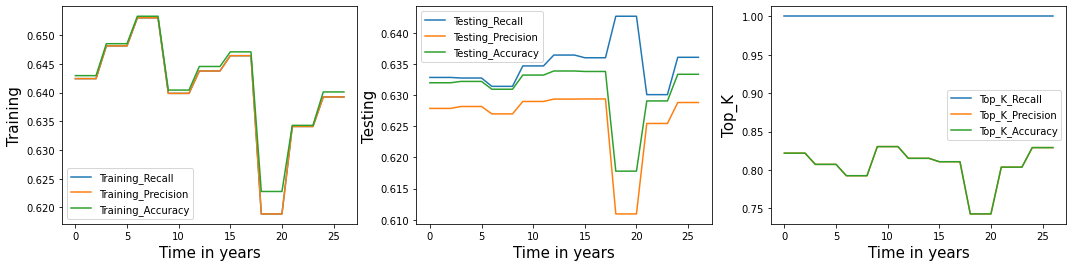

In [11]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [12]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   

========================================= 0 ==================================================
TeA= 0.6319825621169949 TeP= 0.6278643543313136 TeR= 0.6328381278204629
KA= 0.8219672131147543 KP= 0.8219672131147543 KR= 1.0
AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=43)
========================================= 1 ==================================================
TeA= 0.6319825621169949 TeP= 0.6278643543313136 TeR= 0.6328381278204629
KA= 0.8219672131147543 KP= 0.8219672131147543 KR= 1.0
AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=43)
========================================= 2 ==================================================
TeA= 0.6319825621169949 TeP= 0.6278643543313136 TeR= 0.6328381278204629
KA= 0.8219672131147543 KP= 0.8219672131147543 KR= 1.0
AdaBoostClassifier(learning_rate=0.03, n_estimators=500, random_state=43)
========================================= 3 ==================================================
TeA= 0.6321977833168